<H1>EXPERIMENTS</H1>

In [1]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pyodbc
from scipy import spatial, stats
from scipy.stats import kurtosis, skew
import itertools #for list iterations
import operator #for sorting dictionary
import pickle
import time
import subprocess
import random
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.models.doc2vec
import numpy as np


from nltk.tokenize import RegexpTokenizer


C:\Users\mvall\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<H3>DATABASE CONNECTION</H3>

In [ ]:
# TEST DATABASE
config = dict(server=   'DESKTOP-C38DL4M', 
              port=      1433,                  
              database= 'test',
              username= 'manuel',
              password= 'password')

connection_string = ('SERVER={server},{port};'   +
                     'DATABASE={database};'      +
                     'UID={username};'           +
                     'PWD={password}')

In [2]:
# THESIS DATABASE
config = dict(server=   'DESKTOP-C38DL4M', 
              port=      1433,                  
              database= 'thesis',
              username= 'manuel',
              password= 'password')

connection_string = ('SERVER={server},{port};'   +
                     'DATABASE={database};'      +
                     'UID={username};'           +
                     'PWD={password}')

In [3]:
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 13 for SQL Server};' +
    connection_string.format(**config)
    )

cursor = conn.cursor()

In [32]:
conn.close()

In [4]:
just_movies = []
cursor.execute("SELECT * FROM movies")
movies = cursor.fetchall()
for movie in movies:
    if not 'season' in str(movie[1]).lower():
        if not 'series' in str(movie[1]).lower():
            if not 'collect' in str(movie[1]).lower():
                if not 'pack' in str(movie[1]).lower():
                    if movie[3] != None:
                        just_movies.append(movie[0])
        
len(just_movies)

2042

In [86]:
#cursor.execute("SELECT * FROM movies")
#table = cursor.fetchall()
pairs = []
for x in range(25):
    pairs.append((random.choice(just_movies), random.choice(just_movies)))

In [87]:
pairs25 = pairs

In [69]:
pairs100 = pairs

In [7]:
for pair in pairs:
    if pair[0] == pair[1]:
        print(pair)

In [131]:
with open('data/pairs25.pickle', 'wb') as output_file:
    pickle.dump(pairs25, output_file)
    
with open('data/pairs100.pickle', 'wb') as output_file:
    pickle.dump(pairs100, output_file)

In [6]:
with open("data/pairs100.pickle", "rb") as input_file:
    pairs = pickle.load(input_file)

<h2>SINGLE SIMILARITY</h2>

<H3> AVERAGE OF ALL PERCEPTIONS FOR A MOVIE </H3>

In [100]:
start_time = time.time()

# Initialize catalog of single perception vectors
movie2vec_single = {}
cursor.execute("SELECT * FROM movie2vec_single")
movies = cursor.fetchall()
for movie in movies:
    if movie[0] in just_movies:
        movie2vec_single[movie[0]] = movie[1:]

print('Loaded! in ', round((time.time() - start_time), 2), len(movie2vec_single))

Loaded! in  93.12 2042


<H3> MEDOID OF SINGLE SHARED PERSPECTIVE </H3>

In [8]:
start_time = time.time()

# Initialize catalog of shared perspective vectors

movie2vec_single = {}
for movie in just_movies:    
    cursor.execute('''SELECT movie2vec.* FROM sharedvec1 INNER JOIN movie2vec
                    ON sharedvec1.rid = movie2vec.id 
                    WHERE movie2vec.pid = ?''', str(movie))
    perspectives = cursor.fetchone()
    movie2vec_single[movie] = perspectives[2:102]

print('Loaded! in ', round((time.time() - start_time), 2), 'sec. with', len(movie2vec_single), 'perspectives')

Loaded! in  31.11 sec. with 2042 perspectives


In [94]:
experimentsA25= []
        
start_time = time.time()

for pair in pairs:
    
# Initialize starting movie

    start = (pair[0], movie2vec_single[pair[0]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start[1:]

# Initialize target movie

    target = (pair[1], movie2vec_single[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())

# Initialize some lists

    discarded = []
    topk_cosine = []
    steps = 1
    discarded.append(start[0])

# Process limited to total amount of movies

    while len(discarded) < len(movies):

# Create "top similar to selected movie" display
        
        cosine = {}
        for key in movie2vec_single:
            if key not in discarded:
                v1 = selected
                v2 = movie2vec_single[key]
                v1v2 = str(key)
                cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)

        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        topk_cosine = sorted_cosine[:9]     
        
#     Show Display

        print('Top Display %s' %steps)
        for movie in topk_cosine:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie[0]))
            print(movie[0], cursor.fetchone())
        print('-'*100)

# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in [row[0] for row in topk_cosine]:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            experimentsA25.append((start[0], target[0], steps))
            break
        else:
            steps = steps + 1

# Calculate most similar movie from display to target

        cosine = {}
        for movie in topk_cosine:
            if movie[0] not in discarded:
                v1 = target[1]
                v2 = movie2vec_single[movie[0]]
                v1v2 = str(movie[0])
                cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)

        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0]    

# Add movies not chosen to the discarded list to avoid repetition

        for row in topk_cosine:
            discarded.append(row[0])

# Update selected movie to start again

        selected = movie2vec_single[closest[0]]
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest[0]))
        print('Selected:', cursor.fetchone())    
        
timeA25 = round((time.time() - start_time), 2)

Start = ('Clerks ', )
Target = ('Journey to the Center of the Earth', )
Top Display 1
B00164KYTG ('Step Brothers ', )
B0007OCG4W ('Closer ', )
B00DL477I0 ('Don Jon', )
B00003CXE4 ('Me, Myself & Irene ', )
B00000JDIQ ('Payback', )
B00068S404 ('Harold & Kumar Go to White Castle ', )
6303471390 ('Dressed to Kill ', )
B000I0RNVQ ('Clerks II ', )
6304681526 ('Chasing Amy ', )
----------------------------------------------------------------------------------------------------
Selected: ('Don Jon', )
Top Display 2
B009AMAGQM ('Beautiful Creatures ', )
B0090SI4LU ('The Host', )
B00CS5RBPM ('Home Run', )
B0073U2F12 ('The Darkest Hour ', )
B008RNYMG0 ("That's My Boy", )
B00HX0KIAM ('Ride Along', )
B005LAIHE0 ('The Five', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B005LAIGSM ('The Vow', )
----------------------------------------------------------------------------------------------------
Selected: ('Ride Along', )
Top Display 3
B00JA3RPAG ('3 Days To Kill ', )
B008JFUORW ('The Hangover 

Selected: ('Runaway Bride ', )
Top Display 20
0790750414 ('The Whole Nine Yards ', )
6304337183 ('The First Wives Club ', )
B0006GAI6O ('Shall We Dance? ', )
6302753295 ('McLintock! ', )
B005LAIGXW ('This Means War', )
0792839137 ('The Man in the Iron Mask', )
B001WAKOW6 ('New In Town ', )
6304112254 ('Baby Boom ', )
B00008NRI7 ('Two Weeks Notice ', )
----------------------------------------------------------------------------------------------------
Selected: ('New In Town ', )
Top Display 21
B00CC3464E ('Admission', )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
0790740885 ('The Witches', )
B00BN3ED8I ('Movie 43', )
B0001I55MO ('Bad Santa', )
B002ZG99G8 ('The Losers', )
B0041KKYGU ('Bad Teacher ', )
B004A8ZX3C ("Mr. Popper's Penguins", )
6305499071 ("There's Something About Mary ", )
----------------------------------------------------------------------------------------------------
Selected: ('Bad Teacher ', )
Top Display 22
B004XCM89M ('Your Highness ', )
B0015I2RSO ('27 Dress

Selected: ('Dumb and Dumber', )
Top Display 40
0790732157 ('Ace Ventura: Pet Detective', )
B00AZMFINM ('A Haunted House', )
6303964745 ('Mallrats ', )
B00003CY57 ('Scary Movie 2', )
B0011KQSZ4 ('Death At A Funeral', )
0792846710 ('Killer Klowns From Outer Space ', )
6302946387 ('Robin Hood ', )
B001DWNUII ("Jeff Dunham's Very Special Christmas Special", )
B00003CXQR ('What Women Want', )
----------------------------------------------------------------------------------------------------
Selected: ("Jeff Dunham's Very Special Christmas Special", )
Top Display 41
B000E5LEXS ('Jeff Dunham: Arguing with Myself', )
B002R0EIVI ('Michael Jackson: This Is It ', )
B005CRM0Q8 ('Jeff Dunham: Controlled Chaos ', )
6304698771 ('How the Grinch Stole Christmas / Horton Hears a Who', )
B005LAIH86 ('Think Like a Man', )
B001M5UDGS ("Dr. Horrible's Sing", )
B00005NKW0 ('Jingle All the Way ', )
0780651359 ('The Mask', )
B002ZG97TW ('Grown Ups', )
----------------------------------------------------------

Selected: ('Beastly', )
Top Display 8
B005LAIGSM ('The Vow', )
B0017JHQPK ('Definitely, Maybe ', )
0790725657 ('A Little Princess ', )
B008Y1YJN6 ('Sparkle', )
B001Y8DJVE ('Confessions Of A Shopaholic', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B005LAIHCW ('House at the End of the Street ', )
B002ZG9968 ('The Back', )
B001BEK86K ('Then She Found Me ', )
----------------------------------------------------------------------------------------------------
Selected: ('Confessions Of A Shopaholic', )
Top Display 9
B00DL46ZN8 ('The Way, Way Back', )
B005LAIGXW ('This Means War', )
B001PR0Y6W ('I Love You, Man', )
B0002IQJ8W ('Mean Girls ', )
B001REZM6K ('Marley and Me ', )
6304337183 ('The First Wives Club ', )
B00118T632 ('Dan In Real Life', )
B0038N9X3G ('Leap Year ', )
0783241569 ('Notting Hill ', )
----------------------------------------------------------------------------------------------------
Target Reached in 9 steps
+++++++++++++++++++++++++++++++++++++++++++++++++++++++

B008220BW0 ('Of Men and Mavericks ', )
----------------------------------------------------------------------------------------------------
Selected: ('Bandits', )
Top Display 3
B001L2ZSKS ('Eagle Eye ', )
B0000640VN ('Kate & Leopold', )
B00029NLGO ('The Prince and Me ', )
0783241569 ('Notting Hill ', )
B004A8ZX28 ('Unknown', )
B0000897EE ('Maid in Manhattan ', )
B00A2H9UG6 ('Playing for Keeps', )
B00G7QPXAI ('Austenland', )
B002AL2TYC ('The Most Wonderful Time of the Year', )
----------------------------------------------------------------------------------------------------
Selected: ('Unknown', )
Top Display 4
B00HX0KIAM ('Ride Along', )
B00JA3RPAG ('3 Days To Kill ', )
B003Y5H4SO ('Devil', )
B000127ZC8 ('Foolproof', )
B005LAIHCW ('House at the End of the Street ', )
B009AMAGQM ('Beautiful Creatures ', )
B00BEIYNIW ("You're Next", )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B002ZG98N2 ('Priest ', )
----------------------------------------------------------------------------

Top Display 12
B002935GMS ('Race To Witch Mountain', )
B001EAWMGA ('Outlander', )
B003B3V0N4 ('When In Rome', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
630026923X ('Auntie Mame ', )
B002ZG994U ('The A', )
0767836324 ('Hook', )
B00005R874 ('Evolution', )
B004EPZ03O ('The Muppets', )
----------------------------------------------------------------------------------------------------
Selected: ('Evolution', )
Top Display 13
B000RJO578 ('Hot Fuzz ', )
B0000509C5 ('Maximum Overdrive', )
B0029W2V9U ('Alien Trespass', )
B0012KJ0DK ("Fool's Gold ", )
B002UZCJ8Y ('Surrogates', )
B0009ETCVA ('Cursed', )
B000BUNZXS ('The Cave ', )
B002ZG982S ('Jonah Hex', )
B002VECM3Q ('Ninja Assassin ', )
----------------------------------------------------------------------------------------------------
Selected: ('Maximum Overdrive', )
Top Display 14
0780618556 ('Dumb and Dumber', )
B00HX0KIAM ('Ride Along', )
B00005JKMW ('Not Another Teen Movie ', )
B005LAII2Q ('The Watch', )
B004LWZW7E ('In Time', )
6304680

Top Display 18
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B005LAIHCW ('House at the End of the Street ', )
B000127ZC8 ('Foolproof', )
B0081HLM2E ('Headhunters', )
B0007Z2556 ('Boogeyman ', )
B005LAIIA8 ('Frankenweenie ', )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B003Y5H54W ('Red Riding Hood', )
B004LWZW7E ('In Time', )
----------------------------------------------------------------------------------------------------
Selected: ('Foolproof', )
Top Display 19
B001BEK86K ('Then She Found Me ', )
B0021L8V3Y ('Dear John', )
B0021L8UPS ('Orphan', )
B0041KKYHE ('Water for Elephants', )
B00008YOD2 ('Saw II ', )
0784012822 ('The Arrival / The Arrival II', )
B009AMAGQM ('Beautiful Creatures ', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
B002ZG98N2 ('Priest ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Arrival / The Arrival II', )
Top Display 20
0792160207 ('Double Jeopardy', )
0790750414 ('Th

Selected: ('Clear And Present Danger ', )
Top Display 38
0790731509 ('Cool Hand Luke', )
0788821075 ('Pretty Woman ', )
B00116GEK2 ('Jesse Stone: Sea Change', )
B00G7QPXAI ('Austenland', )
6305128324 ('Friendly Persuasion ', )
B000OVLBG2 ('Jesse Stone: Death In Paradise', )
6302969972 ('Coneheads ', )
B002QW7AJY ('Pandorum ', )
6303109950 ('Tombstone ', )
----------------------------------------------------------------------------------------------------
Selected: ('Jesse Stone: Sea Change', )
Top Display 39
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
6304457278 ('The Cowboys ', )
6301586034 ('Desk Set ', )
0790729709 ('The Bodyguard ', )
B00F37VHPM ('Doctor Who', )
B0034G4P94 ('Warrior', )
B000069I1B ('Queen of the Damned ', )
B001GMAVGE ('Get Smart ', )
6302380596 ("On Her Majesty's Secret Service ", )
----------------------------------------------------------------------------------------------------
Selected: ('The Bodyguard ', )
Top Display 40
B008Y1YJN6 ('Sparkle', )
07928

Selected: ('Compliance ', )
Top Display 58
B000BYY11O ('Flightplan ', )
6305132100 ('Sliding Doors ', )
B0051MKMNC ('Limitless ', )
B000JBXHQY ('Snakes on a Plane ', )
B00005JKZH ('Dragonfly ', )
B008KZ06A6 ('October Baby', )
B007ZZKWHY ('Iron Sky ', )
B00A2H9VKG ('Promised Land', )
B00005JNQA ('The Interpreter ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Interpreter ', )
Top Display 59
B000G5SILC ('The Sentinel ', )
B0015OKWL2 ('Righteous Kill', )
B00D6MB83W ('White House Down', )
0767803434 ('Air Force One', )
B004EPYZO4 ('The Rite', )
6300216748 ('Three Days of the Condor ', )
B00005JNNZ ('Coach Carter ', )
6301562925 ('Halloween 5 ', )
B00005JOKM ('Good Night, and Good Luck.', )
----------------------------------------------------------------------------------------------------
Target Reached in 59 steps
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
St

B008Y1YJN6 ('Sparkle', )
6302269431 ('Rocketeer ', )
B005LAIGSM ('The Vow', )
----------------------------------------------------------------------------------------------------
Selected: ('Howard the Duck ', )
Top Display 13
6300183483 ('The Last Starfighter ', )
6301744136 ('Short Circuit  ', )
0792836634 ("Child's Play ", )
6301969634 ('House of Dark Shadows ', )
6300214370 ('Footloose ', )
6302736951 ('Mysterious Island ', )
6302787068 ('Aladdin ', )
6301963911 ('Annie Hall ', )
6300215520 ('When Worlds Collide ', )
----------------------------------------------------------------------------------------------------
Selected: ('Mysterious Island ', )
Top Display 14
6303122876 ('The Dark Crystal ', )
6302824559 ('Real Genius ', )
6304457324 ('Jeremiah Johnson ', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
6304030959 ('Jumanji ', )
0767817664 ('Fright Night', )
6302098424 ('Journey to the Center of the Earth ', )
6301802322 ('Better Off Dead ', )
B0000040DS ('Christmas in 

6302794331 ('The Muppet Christmas Carol  ', )
B009NNM77E ('Lego: The Piece of Resistance', )
B0000040DS ('Christmas in Connecticut  ', )
6302178924 ('Robin Hood ', )
----------------------------------------------------------------------------------------------------
Selected: ('Robin Hood ', )
Top Display 9
6304089767 ('Toy Story ', )
0783234066 ('The Land Before Time', )
B00005JM7T ("Dr. Seuss' The Cat In The Hat ", )
6302269431 ('Rocketeer ', )
B005LAII0I ('Mirror Mirror', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
B00BEIYH1A ('Kick', )
B009AMAH3O ('Escape From Planet Earth', )
0767836324 ('Hook', )
----------------------------------------------------------------------------------------------------
Selected: ("Dr. Seuss' The Cat In The Hat ", )
Top Display 10
6305949557 ('Toy Story 2 ', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B000DBHX4M ('Zathura ', )
B00005JM5Q ('Ella Enchanted ', )
B001DPHDCY ('Horton Hears a Who ', )
B00288KNJU ('Coraline ', )
B005QODEDU 

B001BEK86K ('Then She Found Me ', )
0792838963 ('Moonstruck', )
B00005V4XW ('Bandits', )
6301777387 ('M*A*S*H ', )
B005LAIGXW ('This Means War', )
0790729709 ('The Bodyguard ', )
B005LAIHCW ('House at the End of the Street ', )
6304411448 ('Benny & Joon ', )
0792837207 ('When Harry Met Sally... ', )
----------------------------------------------------------------------------------------------------
Selected: ('This Means War', )
Top Display 29
0790750414 ('The Whole Nine Yards ', )
B005F3XV62 ('Zookeeper', )
6304337183 ('The First Wives Club ', )
B005LAII94 ('Savages', )
B001Y8DJVE ('Confessions Of A Shopaholic', )
079074676X ('Victor Victoria ', )
B00008NRI7 ('Two Weeks Notice ', )
B0012KJ0DK ("Fool's Gold ", )
0783217048 ('To Wong Foo Thanks for Everything ', )
----------------------------------------------------------------------------------------------------
Selected: ('Confessions Of A Shopaholic', )
Top Display 30
B00DL46ZN8 ('The Way, Way Back', )
B001PR0Y6W ('I Love You, Man', 

Selected: ('Joyful Noise  ', )
Top Display 48
B00003CXMO ('Bring It on ', )
6300247236 ('9 to 5 ', )
B00005JLYW ("Charlie's Angels: Full Throttle ", )
B002ZG976U ('Burlesque', )
B00063KGPU ('The Princess Diaries 2 ', )
B00005JP03 ('The Fast and the Furious: Tokyo Drift', )
0780618548 ('The Long Kiss Goodnight', )
B00003CXKJ ('Bedazzled', )
B00006SFKM ('Happy Accidents', )
----------------------------------------------------------------------------------------------------
Selected: ("Charlie's Angels: Full Throttle ", )
Top Display 49
B000XA5K48 ("Shoot 'Em Up", )
B000BTITKS ('Transporter 2', )
B002VECM3Q ('Ninja Assassin ', )
B000K7UBSO ('Crank ', )
B00005JMX6 ('The Girl Next Door ', )
B000056PMV ("Charlie's Angels ", )
0792837096 ('Some Like It Hot ', )
B002USF1VS ("Jennifer's Body ", )
B004EPYZQC ('Fast Five', )
----------------------------------------------------------------------------------------------------
Selected: ('Fast Five', )
Top Display 50
0790729997 ('Mortal Kombat', )
B

B000YABV7W ('Fred Claus', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
B000F3UAFC ('Good Woman, A', )
6302206294 ('Robin Hood ', )
0790731878 ('Vegas Vacation ', )
B000HDZK1Y ('Nacho Libre ', )
B000FUTVLY ('Take the Lead', )
B00DB43PLI ('Summer in February', )
B000CEXGAK ('The Legend of Zorro ', )
----------------------------------------------------------------------------------------------------
Selected: ('Vegas Vacation ', )
Top Display 67
6304005512 ('The Ghost and Mr. Chicken ', )
0780651359 ('The Mask', )
630220366X ('What About Bob ', )
0783225482 ('Death Becomes Her', )
B0001Z3TX4 ('50 First Dates ', )
0790749351 ('Pee', )
6301978420 ('The Thin Man ', )
6300268179 ("What's Up Doc ", )
6302914469 ('Dennis the Menace ', )
----------------------------------------------------------------------------------------------------
Selected: ('50 First Dates ', )
Top Display 68
1404918051 ('13 Going on 30', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
B00005JNQG ('The Pacifier ', 

0784011648 ('On Golden Pond', )
----------------------------------------------------------------------------------------------------
Selected: ('Seabiscuit ', )
Top Display 85
B000ARTN3I ('Cinderella Man ', )
B00005JNNZ ('Coach Carter ', )
B00005JMOW ('Hidalgo ', )
B0038M2AZA ('Temple Grandin', )
B0001US66E ('Miracle ', )
6301662954 ('Enemy Below ', )
0792102320 ("In Harm's Way ", )
B005LAIGN2 ('Red Tails', )
B000R7NBMK ('The War ', )
----------------------------------------------------------------------------------------------------
Selected: ('Coach Carter ', )
Top Display 86
B00005ASOC ('Finding Forrester', )
B000056VP3 ('Remember the Titans ', )
0800128052 ('Rudy ', )
B00005JM2Y ('Bend It Like Beckham ', )
6301976258 ('Sergeant York ', )
B00020BVYW ('The Snow Walker', )
0783240694 ('October Sky ', )
0800141741 ('Jerry Maguire', )
B000ZIZ0RA ('Becoming Jane', )
----------------------------------------------------------------------------------------------------
Selected: ('Finding Fo

Target = ('12 Monkeys ', )
Top Display 1
0792837614 ('West Side Story ', )
0790729369 ('The Bridges of Madison County ', )
0790730987 ('Driving Miss Daisy', )
6305470448 ('Shakespeare in Love ', )
0790729377 ('A Streetcar Named Desire ', )
6301670140 ('Rebecca ', )
B001L2ZSKS ('Eagle Eye ', )
6303599109 ('Doctor Zhivago ', )
0780631641 ('Absolute Power ', )
----------------------------------------------------------------------------------------------------
Selected: ('Shakespeare in Love ', )
Top Display 2
B0000640VN ('Kate & Leopold', )
B0036TGSIK ('Easy A', )
B001L57ZZG ('The Duchess', )
B000ZOXDFA ('Elizabeth ', )
B002KISB56 ('Emma', )
B000YAA68C ('P.S. I Love You', )
6300251004 ('Scrooge ', )
B001PPGAIA ('Australia', )
B0007N1BBC ('North and South ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Duchess', )
Top Display 3
6304331851 ('Camelot ', )
6300215644 ('A Place in the Sun ', )
630266232X ('Laura ', )
B00

B000RJO578 ('Hot Fuzz ', )
----------------------------------------------------------------------------------------------------
Selected: ('Blade ', )
Top Display 6
0780623711 ('Rush Hour ', )
B001HN697M ('Underworld: Rise of the Lycans', )
6304457278 ('The Cowboys ', )
6302380596 ("On Her Majesty's Secret Service ", )
B002ZG98UA ('Resident Evil: Afterlife', )
0790732157 ('Ace Ventura: Pet Detective', )
B0013FZUQK ('The Forbidden Kingdom ', )
B007C4ZJ0S ('Haywire', )
0790729687 ('Interview With the Vampire', )
----------------------------------------------------------------------------------------------------
Selected: ('The Forbidden Kingdom ', )
Top Display 7
0790729997 ('Mortal Kombat', )
B0077MFBYO ('Emperor And The White Snake ', )
B00005JL3K ('XXX ', )
B0012RLX7Y ('Hitman', )
B0085A9HXS ('The Raid: Redemption ', )
B005LAIGLE ('Contraband', )
B005S9EJS2 ('None', )
B004H2CXBQ ('The Man From Nowhere', )
B002AT4K9G ('Fast & Furious', )
------------------------------------------------

Top Display 25
B00BEIYKM6 ('The Place Beyond the Pines', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
B002ZG98LO ('Predators', )
B00BEIYOHC ('Insidious Chapter 2', )
B004EPYZT4 ('Conan the Barbarian', )
B007ZZKWHY ('Iron Sky ', )
B0090SI3CA ('Killer Joe', )
B009AMAKWM ('The Mortal Instruments: City of Bones', )
B0090SI4LU ('The Host', )
----------------------------------------------------------------------------------------------------
Selected: ('Halo 4: Forward Unto Dawn', )
Top Display 26
B005S9EL08 ('The Three Stooges', )
B001GMAVGE ('Get Smart ', )
B001DDBCUA ('Sex and the City: The Movie ', )
B00DL477I0 ('Don Jon', )
B00BB67UNW ('Broken City', )
B002DGTAGY ('Angels&Demons ', )
B00CENSU1W ('Justice League: The Flashpoint Paradox', )
B000OVLBEO ('Ghost Rider ', )
B0051CSI0G ('Stake Land ', )
----------------------------------------------------------------------------------------------------
Selected: ('Ghost Rider ', )
Top Display 27
B0034JKZ3G ('The Princess and The Frog ', )
B000

B000BMY2L0 ('Godzilla ', )
B000035P81 ('Lake Placid ', )
0790736101 ('Horror of Dracula ', )
B008RV5K4U ('Batman: The Dark Knight Returns, Part 1', )
B002AL2TYC ('The Most Wonderful Time of the Year', )
B0027FG29Y ('Superman/Batman: Public Enemies ', )
B00BBAQD6S ('Superman: Unbound', )
B0021L8V34 ('Legion', )
----------------------------------------------------------------------------------------------------
Selected: ('Batman: The Dark Knight Returns, Part 1', )
Top Display 46
B001GLX74I ('Star Wars: The Clone Wars ', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
B00F37VHPM ('Doctor Who', )
B003NFM3JK ("Disney's A Christmas Carol", )
B004LWZW9C ("New Year's Eve", )
B001EAWMGA ('Outlander', )
B0001FT50A ('Gospel of John', )
B002ZG994U ('The A', )
B001DPHDCY ('Horton Hears a Who ', )
----------------------------------------------------------------------------------------------------
Selected: ('Outlander', )
Top Display 47
B005LAIIKS ('The Odd Life of Timothy Green', )
B000GUJYZQ 

6301586034 ('Desk Set ', )
B00005JG70 ('The Thing From Another World ', )
6301976061 ('12 Angry Men ', )
B00005JM4Z ('2 Fast 2 Furious ', )
0792110188 ('El Dorado ', )
B00004RYDC ('The Fifth Element', )
B00A2LFXVI ('Batman: The Dark Knight Returns, Part 2', )
----------------------------------------------------------------------------------------------------
Selected: ('Jeremiah Johnson ', )
Top Display 64
6302736951 ('Mysterious Island ', )
6304415346 ('Star Trek ', )
078322706X ('Meet Joe Black ', )
B003GAMOIW ('The Adjustment Bureau ', )
0767805267 ('Fifth Element ', )
B003Z94WC0 ('Mrs. Miracle', )
0767836359 ('A River Runs Through It', )
630201106X ('Quigley Down Under ', )
B000ROAK2W ('Meet the Robinsons', )
----------------------------------------------------------------------------------------------------
Selected: ('Mysterious Island ', )
Top Display 65
6302824559 ('Real Genius ', )
6302178924 ('Robin Hood ', )
6300185788 ('Howard the Duck ', )
6302468027 ('Fried Green Tomatoes

0790743221 ('The Philadelphia Story ', )
0790736489 ('The Postman ', )
0790731452 ('Mars Attacks!', )
6300184234 ('Back to the Future ', )
0792837592 ('Seven Brides for Seven Brothers ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Philadelphia Story ', )
Top Display 82
0790743949 ('Arsenic and Old Lace ', )
6300215555 ("We're No Angels ", )
6300267962 ('Mister Roberts ', )
0790744066 ('Gigi ', )
0790744473 ('Brigadoon ', )
6304406096 ('Never Say Never Again ', )
6301977033 ('Yours Mine And Ours ', )
0780622588 ('The Wedding Singer', )
6300215628 ('Houseboat ', )
----------------------------------------------------------------------------------------------------
Selected: ('Brigadoon ', )
Top Display 83
630176031X ('The King and I ', )
0790746050 ('Quo Vadis ', )
0800100832 ('From Here to Eternity ', )
0780626478 ('Blast From the Past ', )
0790732262 ('The Witches of Eastwick', )
0790729377 ('A Streetcar Named De

B000BNX3AU ('Must Love Dogs ', )
B002SG7Z7A ('Gamer', )
B005SH63HO ('Justice League: Doom', )
----------------------------------------------------------------------------------------------------
Selected: ('GoldenEye ', )
Top Display 100
6302380561 ('From Russia With Love ', )
B0081HLM2E ('Headhunters', )
6304196784 ('Fish Called Wanda ', )
B0009X7BD2 ('Layer Cake ', )
630365147X ('Goldfinger ', )
6303686850 ('Earth vs the Flying Saucers ', )
B002UOMGZQ ('9 [Blu', )
6300262731 ('An American Werewolf in London ', )
0788811355 ('The English Patient ', )
----------------------------------------------------------------------------------------------------
Selected: ('Fish Called Wanda ', )
Top Display 101
6304308388 ('The Apartment ', )
B000G1R38U ('Akeelah and the Bee ', )
0792837614 ('West Side Story ', )
6301599233 ('Butch Cassidy & Sundance Kid ', )
6304457359 ('The Man Who Would Be King ', )
6303599109 ('Doctor Zhivago ', )
6302994063 ('Strictly Ballroom ', )
6303464831 ('I.Q. ', )
B00

Top Display 3
0783240171 ('Out of Africa', )
079284209X ('Ronin ', )
6302503493 ('The Uninvited ', )
0790729377 ('A Streetcar Named Desire ', )
B00092ZMDY ('The Eagles ', )
0780631641 ('Absolute Power ', )
0783219172 ('Frighteners ', )
0780626478 ('Blast From the Past ', )
0790738074 ('The Music Man ', )
----------------------------------------------------------------------------------------------------
Selected: ('A Streetcar Named Desire ', )
Top Display 4
6301670140 ('Rebecca ', )
6300215555 ("We're No Angels ", )
6304331851 ('Camelot ', )
B000GFRI4K ('Broken Trail', )
0767802551 ('Donnie Brasco', )
0792164962 ('The Firm', )
0790746050 ('Quo Vadis ', )
B004A8ZWSS ('The Tourist', )
B0041KKZHI ('Mildred Pierce', )
----------------------------------------------------------------------------------------------------
Selected: ('Quo Vadis ', )
Top Display 5
0790744473 ('Brigadoon ', )
0790744066 ('Gigi ', )
0767821785 ('The Guns of Navarone', )
0792837614 ('West Side Story ', )
6300215644

B007EQR0D8 ('Man on a Ledge', )
079283318X ('GoldenEye ', )
B001L2ZSKS ('Eagle Eye ', )
B00029NLGO ('The Prince and Me ', )
----------------------------------------------------------------------------------------------------
Selected: ('A Christmas Kiss', )
Top Display 11
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B0002IKSFM ('Love Comes Softly', )
B000GUJYZQ ('Ice Age ', )
B0000040DS ('Christmas in Connecticut  ', )
B0024NSFYY ('Tinker Bell And The Lost Treasure', )
B005LAIIKS ('The Odd Life of Timothy Green', )
B003Z94WC0 ('Mrs. Miracle', )
B000YAA68C ('P.S. I Love You', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
----------------------------------------------------------------------------------------------------
Selected: ('Mrs. Miracle', )
Top Display 12
0790740281 ('Defending Your Life ', )
6303442447 ('The Santa Clause ', )
1424810248 ('Facing the Giants', )
6302227127 ("The Bishop's Wife ", )
B001CTA1UM ('Four Christmases', )
B000TGUUFA ('The Christmas Card 

Target = ('Alien Trespass', )
Top Display 1
6302642256 ('Flight of the Navigator ', )
6300185788 ('Howard the Duck ', )
0800130227 ('Matilda', )
B001UV4XXS ('Cloudy with a Chance of Meatballs ', )
6302914469 ('Dennis the Menace ', )
0788812807 ('Lady and the Tramp ', )
6305177473 ('The Parent Trap ', )
6302468027 ('Fried Green Tomatoes ', )
6301777387 ('M*A*S*H ', )
----------------------------------------------------------------------------------------------------
Selected: ('Howard the Duck ', )
Top Display 2
6300183483 ('The Last Starfighter ', )
6302269431 ('Rocketeer ', )
0792836634 ("Child's Play ", )
0790725657 ('A Little Princess ', )
6301969634 ('House of Dark Shadows ', )
B005LAIGSM ('The Vow', )
6300214370 ('Footloose ', )
6302736951 ('Mysterious Island ', )
0788806270 ('Bambi ', )
----------------------------------------------------------------------------------------------------
Selected: ('Mysterious Island ', )
Top Display 3
6303122876 ('The Dark Crystal ', )
6302824559 

Selected: ('Monsters vs. Aliens', )
Top Display 13
B003Y5H5AG ('The Smurfs', )
B001OMU6UM ('Bolt ', )
B004EPZ03O ('The Muppets', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
B00288KNJU ('Coraline ', )
B004EPZ034 ('Alvin and the Chipmunks: Chipwrecked', )
B001NCDFTW ('Madagascar: Escape 2 Africa ', )
B002935GMS ('Race To Witch Mountain', )
B002XTBEDI ('Cranford: Return to Cranford', )
----------------------------------------------------------------------------------------------------
Selected: ('The Smurfs', )
Top Display 14
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B009AMAH3O ('Escape From Planet Earth', )
B002ZG9904 ('Shrek Forever After ', )
6305949557 ('Toy Story 2 ', )
B008Y1YJ90 ('Arthur Christmas ', )
B00005JNQS ('Robots ', )
6304291701 ('Swiss Family Robinson ', )
B00E00OGE2 ('Turbo', )
B009NNM77E ('Lego: The Piece of Resistance', )
----------------------------------------------------------------------------------------------------
Selected: ('Toy Story 

B00G2P79BU ('Bad Grandpa', )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B00AZMFINM ('A Haunted House', )
B00BPEJWAE ("The World's End", )
B001H5X7I4 ('Tropic Thunder', )
B00005JKMW ('Not Another Teen Movie ', )
B000PATZJW ('Norbit ', )
B002BFBAUG ('Adventureland ', )
0790731517 ('Grumpy Old Men', )
----------------------------------------------------------------------------------------------------
Selected: ('Bad Grandpa', )
Top Display 32
B00009MEC4 ('May', )
B00BN3ED8I ('Movie 43', )
B005LAIHGI ('The Dictator ', )
B0090SI53C ('Grown Ups 2', )
B002ZG99G8 ('The Losers', )
B004RC8NUQ ('No Strings Attached ', )
B004AV5GX6 ('Dinner for Schmucks', )
B00008972B ('Jackass ', )
B005LAIHE0 ('The Five', )
----------------------------------------------------------------------------------------------------
Selected: ('Grown Ups 2', )
Top Display 33
B00BEIYH1A ('Kick', )
B00JA3RPAG ('3 Days To Kill ', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B00BEIYOHC ('Insidious Chapter 2'

B002VECM3Q ('Ninja Assassin ', )
B000GJ0NU2 ('An American Haunting ', )
B005LAIHAY ('Lockout', )
B0001Z52RU ('The Butterfly Effect ', )
B005FITIGO ('Margin Call', )
0783241917 ('End of Days ', )
B009AMAL4Y ('Killing Them Softly', )
----------------------------------------------------------------------------------------------------
Selected: ('Skyline', )
Top Display 52
B0000YEE6C ('House Of The Dead', )
B00005JKXE ('Kung Pow! Enter the Fist', )
B00005NTOH ('Freddy Got Fingered', )
B00HEPC0TS ('Homefront', )
B002JT69IM ('Drag Me to Hell ', )
B002ZG99B8 ('The Green Hornet', )
B005LAIH0O ('The Devil Inside', )
0790748207 ('House on Haunted Hill ', )
B002IKIHE6 ('Land of the Lost ', )
----------------------------------------------------------------------------------------------------
Selected: ('Land of the Lost ', )
Top Display 53
B001LM6VV8 ('Zack and Miri Make a Porno ', )
B002ZG984Q ('Killers', )
0790749858 ('Space Jam', )
B00DCLT8RA ('Sharknado ', )
B000XA5K48 ("Shoot 'Em Up", )
B00BE

Selected: ('The Monster Squad ', )
Top Display 69
0783233582 ('Abbott & Costello Meet Frankenstein', )
6301802322 ('Better Off Dead ', )
6300183467 ('Sixteen Candles ', )
6303625800 ('March of the Wooden Soldiers ', )
0790736055 ('House of Wax ', )
0790736101 ('Horror of Dracula ', )
6302194296 ('Nosferatu ', )
6300270025 ('High Road to China ', )
6302503493 ('The Uninvited ', )
----------------------------------------------------------------------------------------------------
Selected: ('Abbott & Costello Meet Frankenstein', )
Top Display 70
6300183092 ('Wolfman ', )
0783240961 ('The Invisible Man', )
0767825411 ('Ghostbusters ', )
B00005NG6E ('Friday the 13th, Part VI: Jason Lives', )
6300262731 ('An American Werewolf in London ', )
B00005B6L0 ('Shadow of the Vampire ', )
0767817664 ('Fright Night', )
B00DTPRZ0G ('Curse of Chucky ', )
0788832182 ('Lilo & Stitch', )
----------------------------------------------------------------------------------------------------
Selected: ('Friday

Selected: ('Rush Hour ', )
Top Display 14
0790741105 ('Caddyshack ', )
6303610811 ('Tommy Boy ', )
0790743949 ('Arsenic and Old Lace ', )
6304286511 ('Overboard ', )
0790732157 ('Ace Ventura: Pet Detective', )
B00164KYTG ('Step Brothers ', )
0790731509 ('Cool Hand Luke', )
078062369X ('Blade ', )
B0000897EE ('Maid in Manhattan ', )
----------------------------------------------------------------------------------------------------
Selected: ('Cool Hand Luke', )
Top Display 15
0792110188 ('El Dorado ', )
0792838963 ('Moonstruck', )
0792837207 ('When Harry Met Sally... ', )
0792133153 ('Clear And Present Danger ', )
157492589X ('Lonesome Dove ', )
B00HX0KIAM ('Ride Along', )
0780631641 ('Absolute Power ', )
0792834976 ('Road House ', )
0790743221 ('The Philadelphia Story ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Philadelphia Story ', )
Top Display 16
0790744066 ('Gigi ', )
0790738074 ('The Music Man ', )
0790

Top Display 34
0790730987 ('Driving Miss Daisy', )
0792839137 ('The Man in the Iron Mask', )
0800141644 ('The Craft', )
6301586026 ('An Affair to Remember  ', )
0780628799 ('The Green Mile ', )
0780626478 ('Blast From the Past ', )
6303049079 ('Mrs Doubtfire ', )
B00094AS9A ('Dear Frankie', )
B003GAMOIW ('The Adjustment Bureau ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Green Mile ', )
Top Display 35
0767812166 ('Starman', )
B0012IWO0I ('The Water Horse: Legend of the Deep ', )
6302227127 ("The Bishop's Wife ", )
B0011N1WE8 ('Penelope', )
0783219598 ('Babe', )
6303257844 ('Speed ', )
0790725657 ('A Little Princess ', )
B004A8ZWSS ('The Tourist', )
6301647734 ('Harvey ', )
----------------------------------------------------------------------------------------------------
Selected: ('Speed ', )
Top Display 36
B000GFLKEY ('Inside Man ', )
0790736527 ("The Devil's Advocate ", )
B00005V4XW ('Bandits', )
B00008EYA

Selected: ('Ghost & Mrs. Muir ', )
Top Display 54
B005HWAOHK ('Larry Crowne ', )
1417024917 ('Scoop', )
B00DB43PLI ('Summer in February', )
B00007E2F5 ('Sweet Home Alabama', )
B001BPJJ82 ('The Fall ', )
B0067EKY7M ('Salmon Fishing in the Yemen', )
B00BEIYGK2 ('About Time', )
630141277X ('Working Girl ', )
B00DL46ZN8 ('The Way, Way Back', )
----------------------------------------------------------------------------------------------------
Selected: ('Working Girl ', )
Top Display 55
6305108277 ('Hope Floats ', )
6304308388 ('The Apartment ', )
B001PA0FF4 ('Doubt ', )
B00005ASOC ('Finding Forrester', )
6301412761 ('Say Anything ', )
1419827154 ('August Rush', )
0783240694 ('October Sky ', )
B00014NEZI ('Runaway Jury ', )
0800141741 ('Jerry Maguire', )
----------------------------------------------------------------------------------------------------
Selected: ('October Sky ', )
Top Display 56
B002JCSWV6 ('Invictus', )
B000BHZ2BO ('March of the Penguins', )
0792838467 ('War Games', )
B0

Top Display 74
6300181847 ('This Island Earth ', )
6303651488 ('Thunderball ', )
B005SH63HO ('Justice League: Doom', )
0767817664 ('Fright Night', )
B00E00OGE2 ('Turbo', )
0767802659 ('Starship Troopers', )
B00005JLK0 ('Ghost Ship ', )
B000V5IP6K ('Battlestar Galactica ', )
B002ZG97CO ('Daybreakers', )
----------------------------------------------------------------------------------------------------
Selected: ('This Island Earth ', )
Top Display 75
B00005R874 ('Evolution', )
0790736055 ('House of Wax ', )
6300184234 ('Back to the Future ', )
6303686850 ('Earth vs the Flying Saucers ', )
0790747324 ('The Time Machine', )
B0029W2V9U ('Alien Trespass', )
B00005JG70 ('The Thing From Another World ', )
6300181286 ('Frankenstein ', )
B00HNGZHDE ('RoboCop', )
----------------------------------------------------------------------------------------------------
Selected: ('The Thing From Another World ', )
Top Display 76
6303824358 ('A Christmas Carol ', )
B000BUNZXS ('The Cave ', )
B008RNYMG0

Top Display 14
B008J691HU ('People Like Us', )
B0051MKMNC ('Limitless ', )
6305428115 ('Enemy Of The State', )
B005LAIHAY ('Lockout', )
0792140346 ('Primal Fear ', )
B00000JDIQ ('Payback', )
B004EPZ06G ('The Hangover Part II', )
B004NBY242 ('Tucker And Dale Vs Evil ', )
B000QFCD7W ('Wild Hogs ', )
----------------------------------------------------------------------------------------------------
Selected: ('Tucker And Dale Vs Evil ', )
Top Display 15
B000GLL1U6 ('Feast ', )
B000BUNZXS ('The Cave ', )
B0001GV4PI ('Night of the Comet', )
B002ZG97XI ('Hot Tub Time Machine', )
B002USF1VS ("Jennifer's Body ", )
B0012KJ0DK ("Fool's Gold ", )
0783219172 ('Frighteners ', )
0790736039 ("Stephen King's It ", )
B000UJ48OU ('Hostel ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Cave ', )
Top Display 16
B00C7C00JU ('The Lords of Salem', )
0784011168 ("Jacob's Ladder", )
B0085A9HXS ('The Raid: Redemption ', )
B00009MEC4 ('Ma

Selected: ('The Bounty Hunter', )
Top Display 34
B0038N9X3G ('Leap Year ', )
B001BEK86K ('Then She Found Me ', )
B002ZG989G ('Life as We Know It', )
0792164482 ('Runaway Bride ', )
B002ZG98RS ('Remember Me', )
B004LWZWBU ('The Big Year', )
B004L3AQLU ('Love And Other Drugs ', )
0792839137 ('The Man in the Iron Mask', )
B0021L8V3Y ('Dear John', )
----------------------------------------------------------------------------------------------------
Selected: ('Leap Year ', )
Top Display 35
6304112254 ('Baby Boom ', )
B001REZM6K ('Marley and Me ', )
B000E5KQOQ ('An Unfinished Life', )
B0036TGSIK ('Easy A', )
B00DL46ZN8 ('The Way, Way Back', )
B008220BW0 ('Of Men and Mavericks ', )
B00008NRI7 ('Two Weeks Notice ', )
B001DJ7PR8 ('Vicky Cristina Barcelona', )
B001Y8DJVE ('Confessions Of A Shopaholic', )
----------------------------------------------------------------------------------------------------
Selected: ('The Way, Way Back', )
Top Display 36
B002ZG98FU ('Morning Glory', )
B00GEKO51U (

Selected: ('Sex and the City 2', )
Top Display 54
B0033AGJ5Y ('Eat Pray Love ', )
B00BPEJZEM ('The Best Man Holiday', )
0790732246 ('What Ever Happened to Baby Jane?', )
B002ZG994U ('The A', )
B002ZG98N2 ('Priest ', )
B00A2H9L2E ('None', )
B000QGDY06 ('Premonition ', )
B00FQY4C86 ('American Horror Story', )
B00E00OGE2 ('Turbo', )
----------------------------------------------------------------------------------------------------
Selected: ('None', )
Top Display 55
B00BEIYOHC ('Insidious Chapter 2', )
B009AMAH3O ('Escape From Planet Earth', )
B001OMU6UM ('Bolt ', )
B00BEIYKM6 ('The Place Beyond the Pines', )
B009AMALGM ('Paranormal Activity 4', )
B001HN6922 ('Cars 2', )
B003Y5H5FG ('Fright Night', )
B0034JKZ3G ('The Princess and The Frog ', )
6300183483 ('The Last Starfighter ', )
----------------------------------------------------------------------------------------------------
Selected: ('Fright Night', )
Top Display 56
B009AMAKWM ('The Mortal Instruments: City of Bones', )
B001GCUO7

Selected: ('Moonstruck', )
Top Display 12
6304411448 ('Benny & Joon ', )
B005LAIGXW ('This Means War', )
B002ZG988M ('Letters to Juliet', )
0790738074 ('The Music Man ', )
6304286511 ('Overboard ', )
6304383827 ('Emma ', )
6303637574 ('While You Were Sleeping ', )
B000YAA68C ('P.S. I Love You', )
6303049079 ('Mrs Doubtfire ', )
----------------------------------------------------------------------------------------------------
Selected: ('Benny & Joon ', )
Top Display 13
6304925131 ('The Rainmaker ', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
0780622383 ('Dolores Claiborne ', )
6302928540 ('Dave ', )
0790729709 ('The Bodyguard ', )
0792839137 ('The Man in the Iron Mask', )
6301777387 ('M*A*S*H ', )
6302800420 ('Tootsie ', )
6301971345 ('Mr. Brooks', )
----------------------------------------------------------------------------------------------------
Selected: ('Dolores Claiborne ', )
Top Display 14
0790729660 ('A Time to Kill', )
B0000640VK ('The Shipping News', )
B002VECM1S ("It's Compli

Top Display 32
6300275213 ('Splash ', )
6303167314 ('A Charlie Brown Christmas', )
0783229356 ('Smokey and the Bandit', )
0800130227 ('Matilda', )
B0011KQSZ4 ('Death At A Funeral', )
0790731878 ('Vegas Vacation ', )
6303153348 ('Ref ', )
B000XUOIQY ('Tinker Bell', )
6300183467 ('Sixteen Candles ', )
----------------------------------------------------------------------------------------------------
Selected: ('Tinker Bell', )
Top Display 33
6305949557 ('Toy Story 2 ', )
B000028U3R ('The Iron Giant', )
6303047564 ('The Last Unicorn ', )
B004EPZ070 ('Something Borrowed', )
6305784078 ('The Aristocats ', )
B001DPHDCY ('Horton Hears a Who ', )
6301647734 ('Harvey ', )
6300214710 ('Pretty in Pink ', )
0783219598 ('Babe', )
----------------------------------------------------------------------------------------------------
Selected: ('The Last Unicorn ', )
Top Display 34
6302178924 ('Robin Hood ', )
6304089767 ('Toy Story ', )
6303314015 ('The Lion King ', )
1616842490 ('The Chronicles of Na

Top Display 50
6303625800 ('March of the Wooden Soldiers ', )
6300251004 ('Scrooge ', )
6300271285 ('Little Shop of Horrors ', )
6304039530 ('Dial M for Murder ', )
6305229449 ('Mulan ', )
6300181286 ('Frankenstein ', )
0783225873 ('The Sting ', )
B00005JLK0 ('Ghost Ship ', )
6301055845 ('The Last Emperor ', )
----------------------------------------------------------------------------------------------------
Selected: ('Little Shop of Horrors ', )
Top Display 51
6300270270 ('Bad Seed ', )
6304107250 ('Great Race ', )
B000005XPV ('Imitation of Life ', )
6302753295 ('McLintock! ', )
6301991311 ("Pete's Dragon ", )
B0038N9X3G ('Leap Year ', )
B000XA5K48 ("Shoot 'Em Up", )
0780651359 ('The Mask', )
0792846303 ('The Fog ', )
----------------------------------------------------------------------------------------------------
Selected: ('Great Race ', )
Top Display 52
6300216233 ('The Odd Couple ', )
0790731517 ('Grumpy Old Men', )
6301972279 ('The Long, Long Trailer ', )
6303610811 ('Tommy 

B00005JOL4 ('Derailed ', )
0783224079 ('Peacemaker ', )
B000Y7WGOW ('The Kingdom ', )
B00188M5TM ('Changeling ', )
----------------------------------------------------------------------------------------------------
Selected: ('Shadow of a Doubt ', )
Top Display 69
B0081HLM2E ('Headhunters', )
B00005JMX6 ('The Girl Next Door ', )
0783237413 ('The Haunting', )
0784011168 ("Jacob's Ladder", )
0792846338 ('Misery ', )
0790736039 ("Stephen King's It ", )
6303471390 ('Dressed to Kill ', )
0767816234 ('Wild Things', )
B00005JH9M ('The Gift', )
----------------------------------------------------------------------------------------------------
Selected: ('Misery ', )
Top Display 70
0792845986 ('Wuthering Heights ', )
B00018D42W ('The Texas Chainsaw Massacre', )
6301649737 ('Manhunter ', )
B003UD7J94 ('The Pillars of the Earth', )
B00005QW5Y ('The Mists of Avalon', )
0790729687 ('Interview With the Vampire', )
0783116926 ('The Changeling', )
0793927501 ('The Edge ', )
6304136242 ('Halloween: C

Top Display 88
B00005JKBB ('Spy Game ', )
6303651488 ('Thunderball ', )
B00004RYDC ('The Fifth Element', )
0790742802 ('The Omega Man', )
6303686850 ('Earth vs the Flying Saucers ', )
B000646MNE ('None', )
0792839072 ('How the West Was Won', )
6304258984 ('The Rock ', )
B000FFL2G6 ('16 Blocks ', )
----------------------------------------------------------------------------------------------------
Selected: ('None', )
Top Display 89
6302037123 ('The Year Without a Santa Claus ', )
6304872402 ('Anastasia ', )
B00005JPS6 ('Bee Movie ', )
B0016Q2D5M ('Journey to the Center of the Earth', )
B000005PE9 ('The Hobbit', )
078881172X ('Peter Pan ', )
078881107X ("Kiki's Delivery Service ", )
B00004ZEU5 ("The Complete Monty Python's Flying Circus", )
6302787068 ('Aladdin ', )
----------------------------------------------------------------------------------------------------
Selected: ("Kiki's Delivery Service ", )
Top Display 90
0788803743 ('Pocahontas ', )
B001Y8DJVE ('Confessions Of A Shopahol

Selected: ('The Man in the Iron Mask', )
Top Display 6
B005LAIGSM ('The Vow', )
0790750414 ('The Whole Nine Yards ', )
0792164482 ('Runaway Bride ', )
B002ZG998G ('The Bounty Hunter', )
6301777387 ('M*A*S*H ', )
6304337183 ('The First Wives Club ', )
6304411448 ('Benny & Joon ', )
B004A8ZWSS ('The Tourist', )
B000EMGICS ('Rumor Has It...', )
----------------------------------------------------------------------------------------------------
Selected: ('The First Wives Club ', )
Top Display 7
B0041KKYGU ('Bad Teacher ', )
0790725657 ('A Little Princess ', )
B005LAIGXW ('This Means War', )
B0001AVZA8 ('None', )
B0012KJ0DK ("Fool's Gold ", )
6304112254 ('Baby Boom ', )
6303637574 ('While You Were Sleeping ', )
B0015I2RSO ('27 Dresses ', )
B004XCM89M ('Your Highness ', )
----------------------------------------------------------------------------------------------------
Selected: ('While You Were Sleeping ', )
Top Display 8
6302753295 ('McLintock! ', )
6305609756 ('Scrooged ', )
6301586034

Top Display 12
6303314015 ('The Lion King ', )
B003NFM3JK ("Disney's A Christmas Carol", )
6302320402 ('101 Dalmatians ', )
157492589X ('Lonesome Dove ', )
0792837592 ('Seven Brides for Seven Brothers ', )
6304291701 ('Swiss Family Robinson ', )
0783234066 ('The Land Before Time', )
078322995X ('The Prince of Egypt ', )
6305949557 ('Toy Story 2 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Seven Brides for Seven Brothers ', )
Top Display 13
6305282854 ('Carousel ', )
0792833198 ('The Birdcage', )
0790741105 ('Caddyshack ', )
0790744759 ('Meet Me in St Louis ', )
0800130944 ('Sleepless in Seattle', )
0790731983 ('Cabaret ', )
6300215733 ("Donovan's Reef ", )
0767853636 ('Annie ', )
B0002IKSFM ('Love Comes Softly', )
----------------------------------------------------------------------------------------------------
Selected: ("Donovan's Reef ", )
Top Display 14
6303109950 ('Tombstone ', )
6300269043 ('Outlaw Josey W

Selected: ('Darkness Falls ', )
Top Display 32
B0001GV4PI ('Night of the Comet', )
6301427076 ('Pet Sematary ', )
B0009X763C ('The Ring Two', )
0780630858 ('A Nightmare on Elm Street 2 ', )
B000BYY11O ('Flightplan ', )
B003Y5H5FG ('Fright Night', )
B00000JDIQ ('Payback', )
0783237413 ('The Haunting', )
B000FAOC2M ('The Hills Have Eyes', )
----------------------------------------------------------------------------------------------------
Selected: ('The Ring Two', )
Top Display 33
0783229887 ('Bride of Chucky ', )
6300214192 ('Friday the 13th 2 ', )
B000FC2HRW ('Final Destination 3 ', )
B00006LPHA ('Halloween: Resurrection', )
B00005JLZK ('Final Destination 2', )
B00064MW6A ('Catwoman ', )
B0000AMRUL ('Dreamcatcher ', )
6303964745 ('Mallrats ', )
B00003CXE4 ('Me, Myself & Irene ', )
----------------------------------------------------------------------------------------------------
Selected: ('Final Destination 2', )
Top Display 34
B00003CY57 ('Scary Movie 2', )
B00005JM4Q ('Anger Mana

Target = ('Adventures in Babysitting ', )
Top Display 1
B0000640VK ('The Shipping News', )
B00012QLAA ('Matchstick Men ', )
6304681526 ('Chasing Amy ', )
B0001CNRRU ('21 Grams', )
B0036TGSIK ('Easy A', )
0780622383 ('Dolores Claiborne ', )
6304925131 ('The Rainmaker ', )
B002VECM1S ("It's Complicated", )
B0013K7ZPE ('Atonement ', )
----------------------------------------------------------------------------------------------------
Selected: ('Easy A', )
Top Display 2
6305470448 ('Shakespeare in Love ', )
B00008NRI7 ('Two Weeks Notice ', )
B0038N9X3G ('Leap Year ', )
B0000640VN ('Kate & Leopold', )
B0000040DS ('Christmas in Connecticut  ', )
6302227127 ("The Bishop's Wife ", )
B000TGUUFA ('The Christmas Card ', )
B0011N1WE8 ('Penelope', )
0790738074 ('The Music Man ', )
----------------------------------------------------------------------------------------------------
Selected: ('Christmas in Connecticut  ', )
Top Display 3
B00006HBUA ('Scooby', )
6303442447 ('The Santa Clause ', )
076

Selected: ('Hancock ', )
Top Display 21
B00DL47YY2 ('Out of the Furnace', )
B0034G4P94 ('Warrior', )
B004A8ZX28 ('Unknown', )
B004LWZWBU ('The Big Year', )
B005NKIPWC ('The Double ', )
B005LAIGLE ('Contraband', )
B002ZG998G ('The Bounty Hunter', )
B002ZG98N2 ('Priest ', )
B000127ZC8 ('Foolproof', )
----------------------------------------------------------------------------------------------------
Selected: ('The Bounty Hunter', )
Top Display 22
B002P413IC ('The Ugly Truth ', )
B0090SI53C ('Grown Ups 2', )
B001BEK86K ('Then She Found Me ', )
B001451HWU ('AVP: Aliens vs. Predator ', )
B002ZG989G ('Life as We Know It', )
B002ZG99UE ("Valentine's Day", )
B005LAIGXW ('This Means War', )
B002ZG98RS ('Remember Me', )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
----------------------------------------------------------------------------------------------------
Selected: ('Life as We Know It', )
Top Display 23
6304112254 ('Baby Boom ', )
0790750414 ('The Whole Nine Yards ', )
B004A8ZWSS 

Top Display 39
B0009ETCVA ('Cursed', )
0790736039 ("Stephen King's It ", )
B002ZG98KK ('Piranha', )
B000PATZJW ('Norbit ', )
B000BUNZXS ('The Cave ', )
B008VPCL7G ('Chernobyl Diaries ', )
B004QL7K6G ('Wanderlust', )
6300183181 ('Jaws 3 ', )
B000GLL1U6 ('Feast ', )
----------------------------------------------------------------------------------------------------
Selected: ('Norbit ', )
Top Display 40
B001LM6VV8 ('Zack and Miri Make a Porno ', )
B00005JKMW ('Not Another Teen Movie ', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
B003Y5H524 ('Just Go With It', )
B002IKIHE6 ('Land of the Lost ', )
B005LAIHGI ('The Dictator ', )
B000QGDY06 ('Premonition ', )
B002ZG984Q ('Killers', )
B0062P332Y ('Killer Elite ', )
----------------------------------------------------------------------------------------------------
Selected: ('Dodgeball: A True Underdog Story', )
Top Display 41
B00005JM1F ('Old School ', )
B00005JN5T ('Meet the Fockers ', )
B00GEKO51U ('Delivery Man', )
B00008972B ('Ja

Selected: ('Crank ', )
Top Display 58
B005LAIHAY ('Lockout', )
B000XA5K48 ("Shoot 'Em Up", )
6302256615 ('Point Break ', )
B00005JLYW ("Charlie's Angels: Full Throttle ", )
B00005JP03 ('The Fast and the Furious: Tokyo Drift', )
B00005JKXE ('Kung Pow! Enter the Fist', )
B00005R874 ('Evolution', )
B002VECM3Q ('Ninja Assassin ', )
B002ZG982S ('Jonah Hex', )
----------------------------------------------------------------------------------------------------
Selected: ('Point Break ', )
Top Display 59
B00004Z4WR ('Gone in 60 Seconds', )
0790740044 ('Funny Farm ', )
B002ZG99TA ('Unstoppable', )
B001QB9H10 ('Transporter 3 ', )
6300213714 ('The Warriors ', )
079283318X ('GoldenEye ', )
630220366X ('What About Bob ', )
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
6304415346 ('Star Trek ', )
----------------------------------------------------------------------------------------------------
Selected: ('Funny Farm ', )
Top Display 60
1558908455 ('From Dusk Till Dawn', )
6305499071 ("There's Something Ab

Selected: ('McLintock! ', )
Top Display 9
B000CQM4XI ('Just Like Heaven ', )
6301802330 ('Big Jake ', )
0792164482 ('Runaway Bride ', )
B00008NRI7 ('Two Weeks Notice ', )
B0006GAI6O ('Shall We Dance? ', )
B0000040DS ('Christmas in Connecticut  ', )
0790750414 ('The Whole Nine Yards ', )
0800130944 ('Sleepless in Seattle', )
6303464831 ('I.Q. ', )
----------------------------------------------------------------------------------------------------
Selected: ('Runaway Bride ', )
Top Display 10
0788821075 ('Pretty Woman ', )
B002ZG998G ('The Bounty Hunter', )
B005LAIGXW ('This Means War', )
0788806270 ('Bambi ', )
0792839137 ('The Man in the Iron Mask', )
0790725657 ('A Little Princess ', )
6300183467 ('Sixteen Candles ', )
B000YAA68C ('P.S. I Love You', )
B002ZG989G ('Life as We Know It', )
----------------------------------------------------------------------------------------------------
Selected: ('P.S. I Love You', )
Top Display 11
B000F4PDF8 ('Eight Below ', )
B005LAIIKS ('The Odd Li

In [96]:
experimentsA_rand25= []
        
start_time = time.time()

for pair in pairs:
    
# Initialize starting movie

    start = (pair[0], movie2vec_single[pair[0]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start[1:]

# Initialize target movie

    target = (pair[1], movie2vec_single[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())

# Initialize some lists

    discarded = []
    topk_cosine = []
    steps = 1
    discarded.append(start[0])

# Process limited to total amount of movies

    while len(discarded) < len(movies):

# Create "top similar to selected movie" display
        
        cosine = {}
        for key in movie2vec_single:
            if key not in discarded:
                v1 = selected
                v2 = movie2vec_single[key]
                v1v2 = str(key)
                cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)

        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        topk_cosine = sorted_cosine[:9]     
        
#     Show Display

        print('Top Display %s' %steps)
        for movie in topk_cosine:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie[0]))
            print(movie[0], cursor.fetchone())
        print('-'*100)

# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in [row[0] for row in topk_cosine]:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            experimentsA_rand25.append((start[0], target[0], steps))
            break
        else:
            steps = steps + 1

# Calculate most similar movie from display to target

#         cosine = {}
#         for movie in topk_cosine:
#             if movie[0] not in discarded:
#                 v1 = target[1]
#                 v2 = movie2vec_single[movie[0]]
#                 v1v2 = str(movie[0])
#                 cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)

#         sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
#         closest = sorted_cosine[0]    
        
        closest = random.choice(topk_cosine)

# Add movies not chosen to the discarded list to avoid repetition

        for row in topk_cosine:
            discarded.append(row[0])

# Update selected movie to start again

        selected = movie2vec_single[closest[0]]
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest[0]))
        print('Selected:', cursor.fetchone())    
        
timeA_rand25 = round((time.time() - start_time), 2)

Start = ('Clerks ', )
Target = ('Journey to the Center of the Earth', )
Top Display 1
B00164KYTG ('Step Brothers ', )
B0007OCG4W ('Closer ', )
B00DL477I0 ('Don Jon', )
B00003CXE4 ('Me, Myself & Irene ', )
B00000JDIQ ('Payback', )
B00068S404 ('Harold & Kumar Go to White Castle ', )
6303471390 ('Dressed to Kill ', )
B000I0RNVQ ('Clerks II ', )
6304681526 ('Chasing Amy ', )
----------------------------------------------------------------------------------------------------
Selected: ('Clerks II ', )
Top Display 2
B004UXUWEC ('Our Idiot Brother', )
B004XCM89M ('Your Highness ', )
B005LAIHGI ('The Dictator ', )
B003Y5H5B0 ('21 Jump Street', )
B008RNYMG0 ("That's My Boy", )
B00G2P79BU ('Bad Grandpa', )
0780618556 ('Dumb and Dumber', )
B00CC3464E ('Admission', )
B000UVKGPI ('Shrek the Third ', )
----------------------------------------------------------------------------------------------------
Selected: ('21 Jump Street', )
Top Display 3
B00HX0KIAM ('Ride Along', )
B005LAIGWS ('Ghost Rider: 

Selected: ('Real Steel', )
Top Display 20
B002DGTAGY ('Angels&Demons ', )
B002935GMS ('Race To Witch Mountain', )
B00BEIYNIW ("You're Next", )
B0085A9HXS ('The Raid: Redemption ', )
B00HNGZHDE ('RoboCop', )
B007L6VMDK ('Friends With Kids', )
B002ZG97LK ('Footloose', )
B002VECM3Q ('Ninja Assassin ', )
B00005JPS6 ('Bee Movie ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Raid: Redemption ', )
Top Display 21
B0077MFBYO ('Emperor And The White Snake ', )
B004H2CXBQ ('The Man From Nowhere', )
B00HEPC0TS ('Homefront', )
B00HLSW6TW ('The Legend of Hercules', )
B0009S4IHY ('Kung Fu Hustle ', )
B000BUNZXS ('The Cave ', )
0790729997 ('Mortal Kombat', )
B007C4ZJ0S ('Haywire', )
B000XA5K48 ("Shoot 'Em Up", )
----------------------------------------------------------------------------------------------------
Selected: ('Homefront', )
Top Display 22
B004RC8NUQ ('No Strings Attached ', )
B0013J55B6 ('Hancock ', )
B005LAIIB2 ('

Selected: ('The Princess Diaries 2 ', )
Top Display 40
079074676X ('Victor Victoria ', )
0790732262 ('The Witches of Eastwick', )
6300216047 ('Barbarella ', )
B007HHWJD0 ('Joyful Noise  ', )
B000J3OTSM ('Step Up ', )
B002ZG976U ('Burlesque', )
B000XUOIQY ('Tinker Bell', )
6300246981 ('The Song of Bernadette ', )
B000FUTVLY ('Take the Lead', )
----------------------------------------------------------------------------------------------------
Selected: ('Joyful Noise  ', )
Top Display 41
6300214184 ('Flashdance ', )
B00003CXMO ('Bring It on ', )
B001NLJ3N0 ('Secret Life Of Bees, The ', )
6300247236 ('9 to 5 ', )
B00005JLYW ("Charlie's Angels: Full Throttle ", )
B00005JM4B ('Bringing Down The House ', )
B0090SI53C ('Grown Ups 2', )
B00005JP03 ('The Fast and the Furious: Tokyo Drift', )
0780618548 ('The Long Kiss Goodnight', )
----------------------------------------------------------------------------------------------------
Selected: ("Charlie's Angels: Full Throttle ", )
Top Display 42

Selected: ('Christmas in Connecticut  ', )
Top Display 10
B00006HBUA ('Scooby', )
6303442447 ('The Santa Clause ', )
0767836324 ('Hook', )
B00004WMDT ('Center Stage ', )
B008IG0D00 ('A Christmas Kiss', )
B000GUJYZQ ('Ice Age ', )
B003B3V0N4 ('When In Rome', )
6300215733 ("Donovan's Reef ", )
1424810248 ('Facing the Giants', )
----------------------------------------------------------------------------------------------------
Selected: ('The Santa Clause ', )
Top Display 11
6304291701 ('Swiss Family Robinson ', )
B008Y1YJ90 ('Arthur Christmas ', )
B001CTA1UM ('Four Christmases', )
6302794331 ('The Muppet Christmas Carol  ', )
6303167314 ('A Charlie Brown Christmas', )
6302320402 ('101 Dalmatians ', )
B003Z94WC0 ('Mrs. Miracle', )
B005LAIIKS ('The Odd Life of Timothy Green', )
6304005512 ('The Ghost and Mr. Chicken ', )
----------------------------------------------------------------------------------------------------
Selected: ('Mrs. Miracle', )
Top Display 12
0790740281 ('Defending Yo

Top Display 28
B0018BD9DA ('In Bruges', )
B002ZG97B0 ('Date Night ', )
079212569X ('Patriot Games ', )
B005LAIGLE ('Contraband', )
B00003CXQR ('What Women Want', )
B00008EYA5 ('S.W.A.T. ', )
B000068MBI ('High Crimes', )
B002KISB56 ('Emma', )
6304337183 ('The First Wives Club ', )
----------------------------------------------------------------------------------------------------
Selected: ('S.W.A.T. ', )
Top Display 29
B00005JOL4 ('Derailed ', )
0780618548 ('The Long Kiss Goodnight', )
B001H5X7I4 ('Tropic Thunder', )
B005LAIGXW ('This Means War', )
B005NKIPUY ('The Double', )
B009EU6F1U ('Hit & Run', )
B004A8ZWWO ('Tower Heist', )
0792164962 ('The Firm', )
B00008NRI7 ('Two Weeks Notice ', )
----------------------------------------------------------------------------------------------------
Selected: ('This Means War', )
Top Display 30
0790750414 ('The Whole Nine Yards ', )
B005F3XV62 ('Zookeeper', )
0783241569 ('Notting Hill ', )
B005LAII94 ('Savages', )
B001Y8DJVE ('Confessions Of A S

Selected: ('The Green Mile ', )
Top Display 48
0767812166 ('Starman', )
078322706X ('Meet Joe Black ', )
0790729369 ('The Bridges of Madison County ', )
6304457324 ('Jeremiah Johnson ', )
6305962596 ('The Man From Snowy River ', )
0790737345 ('City of Angels', )
0783219598 ('Babe', )
6300267962 ('Mister Roberts ', )
6303257844 ('Speed ', )
----------------------------------------------------------------------------------------------------
Selected: ('Jeremiah Johnson ', )
Top Display 49
B00000F4ZY ("A Knight's Tale ", )
6304415346 ('Star Trek ', )
6305128324 ('Friendly Persuasion ', )
0767836359 ('A River Runs Through It', )
630201106X ('Quigley Down Under ', )
0767817664 ('Fright Night', )
0792846303 ('The Fog ', )
6300184234 ('Back to the Future ', )
6300269043 ('Outlaw Josey Wales ', )
----------------------------------------------------------------------------------------------------
Selected: ('Fright Night', )
Top Display 50
0790736055 ('House of Wax ', )
0790736101 ('Horror of D

Top Display 2
B00008NRI7 ('Two Weeks Notice ', )
B0041KKYGU ('Bad Teacher ', )
B003B3V0N4 ('When In Rome', )
B005LAIGXW ('This Means War', )
B004XCM89M ('Your Highness ', )
6304337183 ('The First Wives Club ', )
0790750414 ('The Whole Nine Yards ', )
B000056PMV ("Charlie's Angels ", )
B002ZG989G ('Life as We Know It', )
----------------------------------------------------------------------------------------------------
Selected: ('Bad Teacher ', )
Top Display 3
B004RC8NUQ ('No Strings Attached ', )
B00CC3464E ('Admission', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B003Y5H574 ('Crazy, Stupid, Love', )
B00466HN6S ('Hop', )
B0011N1WE8 ('Penelope', )
B0015I2RSO ('27 Dresses ', )
B001CTA1UM ('Four Christmases', )
----------------------------------------------------------------------------------------------------
Selected: ("What to Expect When You're Expecting ", )
Top Display 4
B007R6D74G ('Journey 2: The Mysterious Island  '

Selected: ('Lady and the Tramp ', )
Top Display 20
0800130227 ('Matilda', )
6301390725 ('Bedknobs and Broomsticks ', )
6302178924 ('Robin Hood ', )
B009AMAH3O ('Escape From Planet Earth', )
B000028U3R ('The Iron Giant', )
B00288KNJU ('Coraline ', )
6302468027 ('Fried Green Tomatoes ', )
6303314015 ('The Lion King ', )
0783234066 ('The Land Before Time', )
----------------------------------------------------------------------------------------------------
Selected: ('Fried Green Tomatoes ', )
Top Display 21
0790730987 ('Driving Miss Daisy', )
0783225482 ('Death Becomes Her', )
6301744136 ('Short Circuit  ', )
6304107641 ('Down Periscope ', )
6302736951 ('Mysterious Island ', )
0780626478 ('Blast From the Past ', )
0783229356 ('Smokey and the Bandit', )
B0002IKSFM ('Love Comes Softly', )
6304112254 ('Baby Boom ', )
----------------------------------------------------------------------------------------------------
Selected: ('Mysterious Island ', )
Top Display 22
6302824559 ('Real Genius

Selected: ('Eat Pray Love ', )
Top Display 38
B00BEIYKM6 ('The Place Beyond the Pines', )
6304383827 ('Emma ', )
B000CCW2OS ('In Her Shoes', )
B004EPZ01G ('Dolphin Tale', )
B000BITVAG ('Ladies in Lavender', )
0788821075 ('Pretty Woman ', )
B001UV4XXS ('Cloudy with a Chance of Meatballs ', )
0767853636 ('Annie ', )
B002ZG988M ('Letters to Juliet', )
----------------------------------------------------------------------------------------------------
Selected: ('Emma ', )
Top Display 39
0790729709 ('The Bodyguard ', )
B000069I1B ('Queen of the Damned ', )
B0012OVCE6 ('Sense & Sensibility ', )
6304411448 ('Benny & Joon ', )
6305470448 ('Shakespeare in Love ', )
6303637574 ('While You Were Sleeping ', )
B004EPZ070 ('Something Borrowed', )
B0009OL7Z4 ('The Wedding Date ', )
6305108277 ('Hope Floats ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Wedding Date ', )
Top Display 40
0767809254 ('Steel Magnolias ', )
6305537

Selected: ('Journey 2: The Mysterious Island  ', )
Top Display 12
B002ZG9904 ('Shrek Forever After ', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B007REV4LQ ('Seven Psychopaths', )
B008Y1YJN6 ('Sparkle', )
B009AMAH3O ('Escape From Planet Earth', )
B004A8ZWSS ('The Tourist', )
B004AKCMD4 ("Legend of the Guardians: The Owls of Ga'hoole ", )
B00CS5RBPM ('Home Run', )
B004LWZW7Y ('Puss in Boots', )
----------------------------------------------------------------------------------------------------
Selected: ('Sparkle', )
Top Display 13
0790729709 ('The Bodyguard ', )
B0017JHQPK ('Definitely, Maybe ', )
B0090SI4LU ('The Host', )
B002ZG975Q ('Beastly', )
6302269431 ('Rocketeer ', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
B0041KKYHE ('Water for Elephants', )
B002ZG97LK ('Footloose', )
0788812807 ('Lady and the Tramp ', )
----------------------------------------------------------------------------------------------------
Target Reached in 13 steps
++++++++++++++++++++++++++++++++

Top Display 37
B009AMAGQM ('Beautiful Creatures ', )
B0090SI4LU ('The Host', )
B0073U2F12 ('The Darkest Hour ', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B00682LS4G ('Abduction', )
B0064JV4LU ('Intouchables ', )
B00H9HZGQ0 ('Her [Blu', )
B008Y1YJN6 ('Sparkle', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
----------------------------------------------------------------------------------------------------
Selected: ('The Darkest Hour ', )
Top Display 38
B002ZG98UA ('Resident Evil: Afterlife', )
B001451HWU ('AVP: Aliens vs. Predator ', )
B00BEIYH1A ('Kick', )
B005LAIGPA ('Chronicle', )
B002ZG97LK ('Footloose', )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B004AV5GX6 ('Dinner for Schmucks', )
B00HHYF570 ('Odd Thomas', )
B000AA4JKW ('The Amityville Horror', )
----------------------------------------------------------------------------------------------------
Selected: ('The Amityville Horror', )
Top Display 39
B009AMALGM ('Paranormal Activity 4', )
B004EPZ06G ('The Hangover P

Top Display 55
6305428115 ('Enemy Of The State', )
157492589X ('Lonesome Dove ', )
6304383827 ('Emma ', )
779913027X ('The Secret World of Arrietty ', )
B0017MO10U ('Stargate: Continuum', )
6300277089 ('Anne of Green Gables ', )
6301963911 ('Annie Hall ', )
6305949557 ('Toy Story 2 ', )
B0012KJ0DK ("Fool's Gold ", )
----------------------------------------------------------------------------------------------------
Selected: ('The Secret World of Arrietty ', )
Top Display 56
B001BPJJ82 ('The Fall ', )
0790736365 ('Dangerous Beauty ', )
B0007Q6VXC ('House of Flying Daggers', )
6302736951 ('Mysterious Island ', )
B000BT97AO ('MirrorMask', )
B00003CXBK ('Princess Mononoke', )
B004EPZ03O ('The Muppets', )
6302098424 ('Journey to the Center of the Earth ', )
1558807381 ('Legend ', )
----------------------------------------------------------------------------------------------------
Selected: ('Dangerous Beauty ', )
Top Display 57
B000F8DBDK ("The World's Fastest Indian", )
0790737345 ('City

Top Display 74
B001H5X7I4 ('Tropic Thunder', )
6305784078 ('The Aristocats ', )
B000XUOIQY ('Tinker Bell', )
B0009OL7Z4 ('The Wedding Date ', )
B0010V5SW8 ('Beowulf ', )
078322995X ('The Prince of Egypt ', )
B00005JLYQ ('Holes ', )
B000IFRT2O ('Monster House ', )
6302182557 ('Willow ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Wedding Date ', )
Top Display 75
0767809254 ('Steel Magnolias ', )
6305108277 ('Hope Floats ', )
6305537798 ('10 Things I Hate About You ', )
B004X181TY ('Jane Eyre ', )
0800141741 ('Jerry Maguire', )
B00009XITP ('What a Girl Wants ', )
B000BNX3AU ('Must Love Dogs ', )
6304044836 ('Sabrina ', )
B00063KGPU ('The Princess Diaries 2 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Hope Floats ', )
Top Display 76
0792837207 ('When Harry Met Sally... ', )
B00003CXO0 ('Meet the Parents ', )
1415718113 ("Breakfast at Tiffany's

Selected: ('Ghost ', )
Top Display 94
6302503493 ('The Uninvited ', )
6301662946 ('The Blue Max ', )
B0034G4OUO ('Faster', )
6304415346 ('Star Trek ', )
630150528X ('The African Queen ', )
6301969294 ('The Fountainhead ', )
0792834976 ('Road House ', )
0790729717 ('The Color Purple', )
6301802330 ('Big Jake ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Fountainhead ', )
Top Display 95
6305132666 ('The American President ', )
6302753295 ('McLintock! ', )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
6303696813 ('Crimson Tide ', )
6301977688 ('Pride and Prejudice ', )
6301797957 ('All About Eve ', )
076781505X ('Les Miserables', )
0780618548 ('The Long Kiss Goodnight', )
B0038N9X3G ('Leap Year ', )
----------------------------------------------------------------------------------------------------
Selected: ('Crimson Tide ', )
Top Display 96
0790746344 ('Where Eagles Dare ', )
B000GFLKEY ('Inside Man ', )
6301662954

Selected: ('Eraserhead', )
Top Display 114
6304510861 ('Lost Highway ', )
1572522232 ('Suspiria  ', )
0784011796 ('Pi ', )
B0000640S9 ('Audition', )
B002UOMGZQ ('9 [Blu', )
B001D2WU8O ('The Strangers [Blu', )
0767836359 ('A River Runs Through It', )
6300214311 ('Friday the 13th, Part 3 ', )
B00187FPC2 ('Funny Games', )
----------------------------------------------------------------------------------------------------
Selected: ('Pi ', )
Top Display 115
B0060ZJ74O ('Moneyball ', )
B000OYC7BW ('The Number 23 ', )
6304297912 ('Trainspotting ', )
630349255X ('Baraka ', )
0783225997 ('The Deer Hunter', )
6305499365 ('Office Space ', )
B000CSUNQQ ('The Weather Man ', )
6300216268 ('Harold & Maude ', )
B00005JL7Q ('About a Boy ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Number 23 ', )
Top Display 116
B00BEIYGK2 ('About Time', )
B00003CY5H ('Score', )
B00005JOL4 ('Derailed ', )
B00005JOX2 ('Lucky Number Slevin', )
B

6302320402 ('101 Dalmatians ', )
B00H5RYIBI ('The Pirate Fairy', )
----------------------------------------------------------------------------------------------------
Selected: ('The Lion King ', )
Top Display 6
B001HN6922 ('Cars 2', )
6303929338 ('The Many Adventures of Winnie the Pooh ', )
0788806270 ('Bambi ', )
1616842490 ('The Chronicles of Narnia: The Voyage of the Dawn Treader ', )
6302642248 ('Pinocchio ', )
6300275213 ('Splash ', )
0788812807 ('Lady and the Tramp ', )
6305784078 ('The Aristocats ', )
6301390725 ('Bedknobs and Broomsticks ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Chronicles of Narnia: The Voyage of the Dawn Treader ', )
Top Display 7
6303047564 ('The Last Unicorn ', )
157492589X ('Lonesome Dove ', )
B009AMAH3O ('Escape From Planet Earth', )
6300277089 ('Anne of Green Gables ', )
B0006GAI6O ('Shall We Dance? ', )
0783234066 ('The Land Before Time', )
B00005JPH2 ('The Chronicles of N

Selected: ('Howard the Duck ', )
Top Display 24
6300183483 ('The Last Starfighter ', )
6302269431 ('Rocketeer ', )
0800130227 ('Matilda', )
6301744136 ('Short Circuit  ', )
0792836634 ("Child's Play ", )
6301969634 ('House of Dark Shadows ', )
6300214370 ('Footloose ', )
6302736951 ('Mysterious Island ', )
6302787068 ('Aladdin ', )
----------------------------------------------------------------------------------------------------
Selected: ('House of Dark Shadows ', )
Top Display 25
6301963911 ('Annie Hall ', )
6302178924 ('Robin Hood ', )
6302182557 ('Willow ', )
6301175239 ("Mr. Magoo's Christmas Carol ", )
B0017MO10U ('Stargate: Continuum', )
6300270025 ('High Road to China ', )
6304030959 ('Jumanji ', )
6301802322 ('Better Off Dead ', )
0767853636 ('Annie ', )
----------------------------------------------------------------------------------------------------
Selected: ('Annie ', )
Top Display 26
0783237979 ('Cats', )
B0012RLX7Y ('Hitman', )
B00AJLHVES ("Tyler Perry's Madea Gets A

Selected: ('Enchanted April ', )
Top Display 44
0784011648 ('On Golden Pond', )
0792139771 ('Braveheart ', )
B00005JM2Y ('Bend It Like Beckham ', )
0790732262 ('The Witches of Eastwick', )
6305470448 ('Shakespeare in Love ', )
B001BPJJ82 ('The Fall ', )
6300215628 ('Houseboat ', )
630482615X ('Mrs. Brown ', )
0784011176 ('The Piano', )
----------------------------------------------------------------------------------------------------
Selected: ('Houseboat ', )
Top Display 45
6301586042 ('Ghost & Mrs. Muir ', )
0790743221 ('The Philadelphia Story ', )
6301586034 ('Desk Set ', )
0767821556 ('Bell, Book and Candle', )
6302468027 ('Fried Green Tomatoes ', )
B002ZG988M ('Letters to Juliet', )
0790744066 ('Gigi ', )
6301647734 ('Harvey ', )
B00007E2F5 ('Sweet Home Alabama', )
----------------------------------------------------------------------------------------------------
Selected: ('Ghost & Mrs. Muir ', )
Top Display 46
630266232X ('Laura ', )
B00005JPSM ('No Reservations', )
0790743949

Selected: ('Tropic Thunder', )
Top Display 63
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
B00008EYA5 ('S.W.A.T. ', )
B00005ALS2 ('Space Cowboys', )
B00003CY6C ('American Pie 2 ', )
6304925077 ('Untouchables ', )
B000OVLBFS ('Jesse Stone: Night Passage', )
B004A8ZWWO ('Tower Heist', )
B001IZNIZU ('Burn After Reading ', )
0780619552 ('Austin Powers ', )
----------------------------------------------------------------------------------------------------
Selected: ('S.W.A.T. ', )
Top Display 64
B00005JOL4 ('Derailed ', )
0780618548 ('The Long Kiss Goodnight', )
B009EU6F1U ('Hit & Run', )
0792164962 ('The Firm', )
B002ZG98C8 ('Machete', )
B000068MBI ('High Crimes', )
079284209X ('Ronin ', )
6303257844 ('Speed ', )
0780623711 ('Rush Hour ', )
----------------------------------------------------------------------------------------------------
Selected: ('Rush Hour ', )
Top Display 65
6303610811 ('Tommy Boy ', )
B00164KYTG ('Step Brothers ', )
078062369X ('Blade ', )
6304681496 ('Con Air ', )
B00003

Top Display 82
0783222475 ("Dante's Peak ", )
B00005JLK0 ('Ghost Ship ', )
6301963725 ('Predator 2 ', )
B00005JKXX ('Eight Legged Freaks ', )
6304819927 ('Zombie ', )
B00005JKYF ('Castle in the Sky ', )
B006BZ8NXY ('Dead, The', )
B003Y5H54W ('Red Riding Hood', )
630426786X ('Dead Man ', )
----------------------------------------------------------------------------------------------------
Selected: ('Ghost Ship ', )
Top Display 83
B00008YOD2 ('Saw II ', )
6300181847 ('This Island Earth ', )
6302503493 ('The Uninvited ', )
B00005JKJM ('From Hell ', )
B00005JOX2 ('Lucky Number Slevin', )
0780619412 ('Nightmare on Elm Street ', )
B00005JG70 ('The Thing From Another World ', )
0784012822 ('The Arrival / The Arrival II', )
B002XTBEDS ('The 39 Steps', )
----------------------------------------------------------------------------------------------------
Selected: ('Lucky Number Slevin', )
Top Display 84
B00BEIYKX0 ('The Company You Keep', )
630420065X ('Mission Impossible ', )
B000GFLKEY ('Ins

Selected: ("Breakfast at Tiffany's ", )
Top Display 100
6300216047 ('Barbarella ', )
B000J3OTSM ('Step Up ', )
6305110859 ('Sabrina', )
B0001AVZA8 ('None', )
630339406X ('Big ', )
B001DDBCUA ('Sex and the City: The Movie ', )
6304578482 ("Romy and Michele's High School Reunion ", )
0792838912 ('9 1/2 Weeks ', )
B00003CXWL ('Heartbreakers ', )
----------------------------------------------------------------------------------------------------
Selected: ('Heartbreakers ', )
Top Display 101
B0001A79EO ('The Haunted Mansion ', )
B00003CXSM ('The Wedding Planner', )
B004EPZ070 ('Something Borrowed', )
B002ZG97XI ('Hot Tub Time Machine', )
6304361009 ('Heathers ', )
B00063KGPU ('The Princess Diaries 2 ', )
6301398912 ('Beaches ', )
6303964745 ('Mallrats ', )
6305892946 ('Scream 3', )
----------------------------------------------------------------------------------------------------
Selected: ('Mallrats ', )
Top Display 102
B0001AW0HU ('Scary Movie 3 ', )
6302814782 ('The Lost Boys ', )
B000

Selected: ('Zulu', )
Top Display 120
6302010306 ('The Final Countdown ', )
0792837797 ('Red Dawn ', )
6301965817 ('Battle of Britain ', )
0767802470 ('Das Boot ', )
B001FB55J4 ('Defiance', )
6305238065 ('Cube', )
6300268748 ('Battle of the Bulge ', )
B000PKG8SS ('The Host ', )
B00005JMOW ('Hidalgo ', )
----------------------------------------------------------------------------------------------------
Selected: ('Battle of Britain ', )
Top Display 121
6300252051 ('El Cid ', )
B008CP2E7C ('Searching For Sugar Man ', )
B00005YUO1 ('Conspiracy', )
B0001US66E ('Miracle ', )
B0038M2AZA ('Temple Grandin', )
0792839730 ('A Bridge Too Far', )
B000OVLBGC ('The Lives of Others', )
6301628454 ('The Robe ', )
0800128052 ('Rudy ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Lives of Others', )
Top Display 122
B003498S2G ('Five Minutes of Heaven ', )
B0010HOZVW ('The Brave One ', )
0780018664 ('M ', )
B000KLQUV2 ('Jesus Camp'

Selected: ('The Squid and the Whale ', )
Top Display 138
B000EOTTV8 ('Transamerica ', )
B000CSUNQQ ('The Weather Man ', )
B000E1YVZU ('Rent ', )
B00005JKTI ('The Hours', )
B000067J3S ('In the Bedroom', )
6301963717 ("Miller's Crossing ", )
0792838084 ('Blue Velvet ', )
6301412761 ('Say Anything ', )
0780619250 ('Crash ', )
----------------------------------------------------------------------------------------------------
Selected: ('Blue Velvet ', )
Top Display 139
B002TVQ48A ('Bad Lieutenant: Port of Call New Orleans ', )
B00009W0U4 ('Irreversible', )
0767836286 ('Arlington Road', )
B000QUCNOU ('Zodiac', )
6300214664 ('Silver Bullet ', )
6302510023 ('Bond: Spy Who Loved Me ', )
0792836685 ('Pumpkinhead ', )
B0013D8L7M ('Teeth', )
0767830520 ('Taxi Driver ', )
----------------------------------------------------------------------------------------------------
Selected: ('Zodiac', )
Top Display 140
B003102IPQ ('The Fourth Kind ', )
B00005BCKG ('The Pledge', )
B00008EY9G ('Identity', )


Top Display 4
B00003CXRA ('Enemy At the Gates', )
B005LAIGYQ ('Act of Valor', )
6301662946 ('The Blue Max ', )
0790746344 ('Where Eagles Dare ', )
6303696813 ('Crimson Tide ', )
B00003CX73 ('Three Kings', )
0792837797 ('Red Dawn ', )
B0000ACOXL ('Traitor', )
B002UZCJ8Y ('Surrogates', )
----------------------------------------------------------------------------------------------------
Selected: ('Red Dawn ', )
Top Display 5
6303829406 ('Zulu', )
B000Y7WGOW ('The Kingdom ', )
6301965817 ('Battle of Britain ', )
6304415346 ('Star Trek ', )
B001FB55J4 ('Defiance', )
B004EPZ08O ('Final Destination 5', )
630105573X ('Empire of the Sun ', )
0792845684 ('Escape From New York ', )
6304039522 ('Bonnie & Clyde ', )
----------------------------------------------------------------------------------------------------
Selected: ('Escape From New York ', )
Top Display 6
0790731975 ('Dirty Harry ', )
6304681496 ('Con Air ', )
0790752387 ("Kelly's Heroes ", )
B00004RFF8 ('Fort Apache ', )
0792838467 ('

Selected: ('None', )
Top Display 24
B0039UT3LK ('Crazy Heart', )
B004LWZW7E ('In Time', )
6305470448 ('Shakespeare in Love ', )
B000EMGICS ('Rumor Has It...', )
B003L20IE2 ('Scott Pilgrim vs. The World ', )
B00005V4XW ('Bandits', )
B00003CXIF ('Where the Heart Is ', )
B00006SFKM ('Happy Accidents', )
B002ZG99UE ("Valentine's Day", )
----------------------------------------------------------------------------------------------------
Selected: ('Crazy Heart', )
Top Display 25
B007HHWJD0 ('Joyful Noise  ', )
B000F1IQNC ('Nanny McPhee ', )
B00BEIYFWG ('None', )
6300214184 ('Flashdance ', )
0790729709 ('The Bodyguard ', )
B00BEIYPN0 ('Runner, Runner', )
B0000897EE ('Maid in Manhattan ', )
6300267962 ('Mister Roberts ', )
B007C4ZJ0S ('Haywire', )
----------------------------------------------------------------------------------------------------
Selected: ('Flashdance ', )
Top Display 26
B00003CXMO ('Bring It on ', )
0792839137 ('The Man in the Iron Mask', )
6300183467 ('Sixteen Candles ', )

Selected: ('Becoming Jane', )
Top Display 42
B0007N1BBC ('North and South ', )
0780623746 ('A Christmas Carol', )
6301977688 ('Pride and Prejudice ', )
6305892806 ('Mansfield Park ', )
6304406096 ('Never Say Never Again ', )
0790743221 ('The Philadelphia Story ', )
076781505X ('Les Miserables', )
B002KISB56 ('Emma', )
B00ARX2VZW ('A Royal Affair', )
----------------------------------------------------------------------------------------------------
Selected: ('Emma', )
Top Display 43
B001L57ZZG ('The Duchess', )
6304331851 ('Camelot ', )
B0012OVCE6 ('Sense & Sensibility ', )
6301670140 ('Rebecca ', )
B001C46P2K ('The Young Victoria ', )
6300215644 ('A Place in the Sun ', )
B000IJ7H2C ('Jane Eyre ', )
630266232X ('Laura ', )
0767802594 ('Much Ado About Nothing', )
----------------------------------------------------------------------------------------------------
Selected: ('The Young Victoria ', )
Top Display 44
B008Y1YJN6 ('Sparkle', )
B000CEXG0U ('Bleak House', )
B00DB43PLI ('Summer 

Selected: ('Jackass ', )
Top Display 62
B00005JKMW ('Not Another Teen Movie ', )
6302946387 ('Robin Hood ', )
6300213986 ('Airplane ', )
0780618556 ('Dumb and Dumber', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
B00003CY57 ('Scary Movie 2', )
B00164KYTG ('Step Brothers ', )
B0011KQSZ4 ('Death At A Funeral', )
B000E6EHE0 ('Just Friends', )
----------------------------------------------------------------------------------------------------
Selected: ('Not Another Teen Movie ', )
Top Display 63
B000PATZJW ('Norbit ', )
6305499071 ("There's Something About Mary ", )
B002IKIHE6 ('Land of the Lost ', )
B0000509C5 ('Maximum Overdrive', )
B000HDZK1Y ('Nacho Libre ', )
0790732157 ('Ace Ventura: Pet Detective', )
0783115202 ('Three Amigos!', )
B0000AKCKI ('Bruce Almighty ', )
B00BPEJWAE ("The World's End", )
----------------------------------------------------------------------------------------------------
Selected: ('Land of the Lost ', )
Top Display 64
B005LAIHGI ('The Dictator ', )
B

Selected: ('August Rush', )
Top Display 82
630518299X ('Truman Show ', )
B0051MKMNC ('Limitless ', )
0790720434 ('The Secret Garden ', )
B001PA0FF4 ('Doubt ', )
6303187064 ('The Crow ', )
B00005JLR8 ('In America', )
B00006HAWN ('Enough', )
B00020BVYW ('The Snow Walker', )
0792139771 ('Braveheart ', )
----------------------------------------------------------------------------------------------------
Selected: ('Truman Show ', )
Top Display 83
B005FITIDC ('Machine Gun Preacher', )
B0013XZ2QA ("Charlie Wilson's War ", )
B000NOK1KC ('Freedom Writers ', )
6301976258 ('Sergeant York ', )
0790729393 ('Sleepers', )
630587493X ('Bicentennial Man', )
B005HWAOHK ('Larry Crowne ', )
0790731452 ('Mars Attacks!', )
B002VECMAE ('The Men Who Stare At Goats', )
----------------------------------------------------------------------------------------------------
Selected: ('Sergeant York ', )
Top Display 84
B000056VP3 ('Remember the Titans ', )
B00005JNNZ ('Coach Carter ', )
0800128052 ('Rudy ', )
B0000

Selected: ('Bell, Book and Candle', )
Top Display 100
B000XUOIQY ('Tinker Bell', )
0792837096 ('Some Like It Hot ', )
0767809254 ('Steel Magnolias ', )
6300246787 ('Hello Dolly ', )
0783227388 ('Uncle Buck', )
6300216233 ('The Odd Couple ', )
0783225199 ('Blues Brothers ', )
6301217977 ('Coming to America ', )
6302914469 ('Dennis the Menace ', )
----------------------------------------------------------------------------------------------------
Selected: ('Coming to America ', )
Top Display 101
0783229356 ('Smokey and the Bandit', )
B000FUTVLY ('Take the Lead', )
6303066720 ('The Three Musketeers ', )
6302206294 ('Robin Hood ', )
0780618548 ('The Long Kiss Goodnight', )
6305428239 ('Rushmore', )
B000LXHK22 ('A Good Year ', )
6300213730 ('Beverly Hills Cop ', )
B00003CXKJ ('Bedazzled', )
----------------------------------------------------------------------------------------------------
Selected: ('Rushmore', )
Top Display 102
6305177473 ('The Parent Trap ', )
6305428220 ('The Faculty',

Selected: ('Selena', )
Top Display 120
6305126062 ('Horse Whisperer ', )
B003Y5H4Y8 ('The Debt', )
B001NFNFF8 ('In the Electric Mist ', )
0792838912 ('9 1/2 Weeks ', )
B001QOGYAO ('The Lovely Bones', )
B00005K3OI ('Someone Like You', )
B000KF0GWW ('The Guardian', )
0780622383 ('Dolores Claiborne ', )
B00003CY5X ('Rush Hour 2 ', )
----------------------------------------------------------------------------------------------------
Selected: ('In the Electric Mist ', )
Top Display 121
B00005JL98 ('Time After Time ', )
B00005UQ9V ('Hearts in Atlantis', )
1573625736 ("Stephen King's Storm of the Century ", )
B00HHYF570 ('Odd Thomas', )
B00018D42W ('The Texas Chainsaw Massacre', )
B003EYVXTG ("Winter's Bone", )
B001LK8SKW ('Wonder Woman', )
B00018U9FW ('School of Rock ', )
0784012822 ('The Arrival / The Arrival II', )
----------------------------------------------------------------------------------------------------
Selected: ('The Texas Chainsaw Massacre', )
Top Display 122
B0002IQJ8W ('Me

Top Display 138
079283321X ('Rocky ', )
630021639X ('The Godfather, Part II ', )
0792100085 ('Saturday Night Fever ', )
B003UESJHO ('The Fighter', )
B004H2CXBQ ('The Man From Nowhere', )
B00003CXLV ('The Replacements ', )
B004LWZW8I ('Immortals', )
B000A0GXRE ('Fever Pitch ', )
0783226039 ('Spartacus', )
----------------------------------------------------------------------------------------------------
Selected: ('The Man From Nowhere', )
Top Display 139
B0009S4IHY ('Kung Fu Hustle ', )
B000056PMV ("Charlie's Angels ", )
B001QB9H10 ('Transporter 3 ', )
6303111874 ('Getaway ', )
B00005R87Q ('The Fast and the Furious', )
B000F5WR4W ('Running Scared', )
B00003CXJ1 ('Shanghai Noon', )
0790735172 ('Enter the Dragon ', )
B00008AOVL ('Transporter, The', )
----------------------------------------------------------------------------------------------------
Selected: ('Transporter, The', )
Top Display 140
B0000DKDUR ('Bad Boys II ', )
0767802519 ('The Professional', )
B00005JKWI ('Blade 2 ', )


Top Display 14
B0000897EE ('Maid in Manhattan ', )
B0034G4P94 ('Warrior', )
0790729709 ('The Bodyguard ', )
B001UV4XRY ('Edge of Darkness', )
B00BEJL6JK ('300: Rise of an Empire ', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B009AMAGQM ('Beautiful Creatures ', )
B008J691HU ('People Like Us', )
B002VECMAE ('The Men Who Stare At Goats', )
----------------------------------------------------------------------------------------------------
Selected: ('300: Rise of an Empire ', )
Top Display 15
B002ZG97O2 ('From Paris with Love', )
B00A2H9WW8 ('Carrie ', )
B005LAII94 ('Savages', )
B004XCM89M ('Your Highness ', )
B00HLSW6TW ('The Legend of Hercules', )
B009EU6F1U ('Hit & Run', )
B0041KKYGU ('Bad Teacher ', )
B0039UT3LK ('Crazy Heart', )
B003L20IE2 ('Scott Pilgrim vs. The World ', )
----------------------------------------------------------------------------------------------------
Selected: ('Scott Pilgrim vs. The World ', )
Top Display 16
B0001AVZA8 ('None', )
B0090SI3ZW ('The Man 

Selected: ('Sparkle', )
Top Display 13
0790729709 ('The Bodyguard ', )
B00CS5RBPM ('Home Run', )
B0017JHQPK ('Definitely, Maybe ', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
6302269431 ('Rocketeer ', )
B0041KKYHE ('Water for Elephants', )
B005LAIIKS ('The Odd Life of Timothy Green', )
B002ZG97LK ('Footloose', )
0788812807 ('Lady and the Tramp ', )
----------------------------------------------------------------------------------------------------
Selected: ('Rocketeer ', )
Top Display 14
6300185788 ('Howard the Duck ', )
6300214370 ('Footloose ', )
6302178924 ('Robin Hood ', )
6303122876 ('The Dark Crystal ', )
B0034JKZ3G ('The Princess and The Frog ', )
6301969634 ('House of Dark Shadows ', )
6304030959 ('Jumanji ', )
6301744136 ('Short Circuit  ', )
B004EPYZT4 ('Conan the Barbarian', )
----------------------------------------------------------------------------------------------------
Selected: ('Conan the Barbarian', )
Top Display 15
B0012RLX7Y ('Hitman', )
B008JFUN1O ('I

Selected: ('Dangerous Beauty ', )
Top Display 33
630266232X ('Laura ', )
B000F8DBDK ("The World's Fastest Indian", )
6305470448 ('Shakespeare in Love ', )
B004EPZ01G ('Dolphin Tale', )
0790737345 ('City of Angels', )
0783240171 ('Out of Africa', )
779913027X ('The Secret World of Arrietty ', )
0792139771 ('Braveheart ', )
B000CEXG0U ('Bleak House', )
----------------------------------------------------------------------------------------------------
Selected: ('Laura ', )
Top Display 34
6301586042 ('Ghost & Mrs. Muir ', )
6302510198 ('Bond: View to a Kill ', )
6304411448 ('Benny & Joon ', )
079074676X ('Victor Victoria ', )
6300214567 ('Witness ', )
B0036TGSIK ('Easy A', )
B0000640VN ('Kate & Leopold', )
6302516986 ('My Cousin Vinny ', )
B0009OL7Z4 ('The Wedding Date ', )
----------------------------------------------------------------------------------------------------
Selected: ('Bond: View to a Kill ', )
Top Display 35
630251004X ('Bond: For Your Eyes Only ', )
0792160207 ('Double 

Selected: ('When Worlds Collide ', )
Top Display 51
6302824559 ('Real Genius ', )
B00001QEE2 ('Hercules ', )
6305428115 ('Enemy Of The State', )
6301802322 ('Better Off Dead ', )
6300270033 ('The Outsiders ', )
0783227361 ('Dazed and Confused', )
B00003CX43 ('Red Planet', )
6304291701 ('Swiss Family Robinson ', )
1560689994 ('Time Bandits ', )
----------------------------------------------------------------------------------------------------
Selected: ('Better Off Dead ', )
Top Display 52
0790749351 ('Pee', )
0783229356 ('Smokey and the Bandit', )
6304285396 ('Pollyanna ', )
6300270025 ('High Road to China ', )
6302642248 ('Pinocchio ', )
6303167314 ('A Charlie Brown Christmas', )
0790749858 ('Space Jam', )
6302182557 ('Willow ', )
6302969972 ('Coneheads ', )
----------------------------------------------------------------------------------------------------
Selected: ('Coneheads ', )
Top Display 53
1616842490 ('The Chronicles of Narnia: The Voyage of the Dawn Treader ', )
6302914469 

Selected: ("We're No Angels ", )
Top Display 69
0790729377 ('A Streetcar Named Desire ', )
079284517X ('The Big Country ', )
0800100832 ('From Here to Eternity ', )
6301670140 ('Rebecca ', )
B000OVLBFS ('Jesse Stone: Night Passage', )
0790746050 ('Quo Vadis ', )
B00014NEZI ('Runaway Jury ', )
6300215644 ('A Place in the Sun ', )
6304925077 ('Untouchables ', )
----------------------------------------------------------------------------------------------------
Selected: ('Jesse Stone: Night Passage', )
Top Display 70
B00116GEK2 ('Jesse Stone: Sea Change', )
B000OVLBG2 ('Jesse Stone: Death In Paradise', )
B0024396EW ('Jesse Stone: Thin Ice', )
B000GFRI4K ('Broken Trail', )
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
0790729687 ('Interview With the Vampire', )
0792164962 ('The Firm', )
6304457278 ('The Cowboys ', )
0790730960 ('Batman Returns ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Cowboys ', )
Top Dis

Selected: ('Halloween 4 ', )
Top Display 87
6301562925 ('Halloween 5 ', )
6304136242 ('Halloween: Curse of Michael Myers ', )
B00005NG6E ('Friday the 13th, Part VI: Jason Lives', )
6303579388 ('Jason Goes to Hell ', )
6304983794 ('Day of the Dead ', )
0783103107 ('Godzilla Vs Biollante ', )
6300182177 ('Jaws 2 ', )
6305171769 ('Halloween H20 ', )
B004LWZW2O ('Scream 4', )
----------------------------------------------------------------------------------------------------
Selected: ('Day of the Dead ', )
Top Display 88
B00005JG70 ('The Thing From Another World ', )
B00005JM4Z ('2 Fast 2 Furious ', )
B00005JPH2 ('The Chronicles of Narnia: Prince Caspian', )
6300214338 ('Trading Places ', )
B00004RYDC ('The Fifth Element', )
B00003CXBK ('Princess Mononoke', )
B00A2LFXVI ('Batman: The Dark Knight Returns, Part 2', )
6303471501 ('Mad Max ', )
B000F6IOBG ('Underworld: Evolution ', )
----------------------------------------------------------------------------------------------------
Selected:

Selected: ("Darby O'Gill & The Little People ", )
Top Display 105
B0001A79EO ('The Haunted Mansion ', )
B002P7UCJ0 ('Bruno', )
B00005O5DJ ('Cats & Dogs ', )
B00C7BZYRO ('The Spectacular Now', )
6300246787 ('Hello Dolly ', )
6302206294 ('Robin Hood ', )
0783233078 ('Fast Times at Ridgemont High ', )
6301217977 ('Coming to America ', )
B000NIVJF4 ('The Last King of Scotland ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Haunted Mansion ', )
Top Display 106
6305892946 ('Scream 3', )
B0000509C5 ('Maximum Overdrive', )
B002ZG976U ('Burlesque', )
B002ZG98KK ('Piranha', )
630420065X ('Mission Impossible ', )
B000BYRCGU ('Into the Blue', )
B004EPZ070 ('Something Borrowed', )
0783237413 ('The Haunting', )
0783236352 ('Shadow of a Doubt ', )
----------------------------------------------------------------------------------------------------
Selected: ('Burlesque', )
Top Display 107
B002R0EIVI ('Michael Jackson: This Is It

Selected: ('The Men Who Stare At Goats', )
Top Display 123
0790729393 ('Sleepers', )
B000OVLBEO ('Ghost Rider ', )
6305508550 ('Office Space ', )
B00BEIYMAG ('The Conjuring ', )
6305718903 ('Stigmata ', )
6302814391 ('Exorcist II ', )
B005HWAOHK ('Larry Crowne ', )
6301094352 ('Friday the 13th Part 7:New Blood ', )
630587493X ('Bicentennial Man', )
----------------------------------------------------------------------------------------------------
Selected: ('Larry Crowne ', )
Top Display 124
B005WFWVL4 ('Contagion ', )
B005FITIK0 ('Young Adult', )
B00005JPSM ('No Reservations', )
B00A2H9VKG ('Promised Land', )
B00007E2F5 ('Sweet Home Alabama', )
B005CRM0Q8 ('Jeff Dunham: Controlled Chaos ', )
0790733234 ('Conspiracy Theory ', )
6301797957 ('All About Eve ', )
6304481691 ('Mr Smith Goes to Washington ', )
----------------------------------------------------------------------------------------------------
Selected: ('No Reservations', )
Top Display 125
6305126062 ('Horse Whisperer ', )


Selected: ('Crazy, Stupid, Love', )
Top Display 7
B004XCM89M ('Your Highness ', )
B001WAKOW6 ('New In Town ', )
B004A8ZX3C ("Mr. Popper's Penguins", )
B00466HN6S ('Hop', )
B007MDB548 ('Secret of the Wings ', )
B003Y5H524 ('Just Go With It', )
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
0788821075 ('Pretty Woman ', )
B009NNM77E ('Lego: The Piece of Resistance', )
----------------------------------------------------------------------------------------------------
Selected: ('Pretty Woman ', )
Top Display 8
0792164482 ('Runaway Bride ', )
0783241569 ('Notting Hill ', )
6304337183 ('The First Wives Club ', )
0790750414 ('The Whole Nine Yards ', )
0792110188 ('El Dorado ', )
B0006GAI6O ('Shall We Dance? ', )
0792839137 ('The Man in the Iron Mask', )
0790731509 ('Cool Hand Luke', )
0790725657 ('A Little Princess ', )
----------------------------------------------------------------------------------------------------
Selected: ('The First Wives Club ', )
Top Display 9
B005LAIGXW ('This M

Selected: ('The Tourist', )
Top Display 27
B001BEK86K ('Then She Found Me ', )
B004L3AQLU ('Love And Other Drugs ', )
B00H9LHVHI ('Labor Day', )
B002ZG989G ('Life as We Know It', )
B0000640VN ('Kate & Leopold', )
B0041KKYHE ('Water for Elephants', )
B00266E6G0 ('Whitechapel ', )
B002ZG998G ('The Bounty Hunter', )
B004LWZWBU ('The Big Year', )
----------------------------------------------------------------------------------------------------
Selected: ('Then She Found Me ', )
Top Display 28
B0038N9X3G ('Leap Year ', )
B00005V4XW ('Bandits', )
B00005JPE3 ('Music and Lyrics ', )
B00G7QPXAI ('Austenland', )
B00DL46ZN8 ('The Way, Way Back', )
B000E5KQOQ ('An Unfinished Life', )
B002ZG98FU ('Morning Glory', )
B001REZM6K ('Marley and Me ', )
B000EMGICS ('Rumor Has It...', )
----------------------------------------------------------------------------------------------------
Selected: ('An Unfinished Life', )
Top Display 29
B00AEK9BKQ ('The Sessions', )
6300214567 ('Witness ', )
B0017JHQPK ('D

Selected: ('Tootsie ', )
Top Display 45
B002VECM1S ("It's Complicated", )
6304196784 ('Fish Called Wanda ', )
0767811100 ('As Good As It Gets', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
B00118T632 ('Dan In Real Life', )
6305108277 ('Hope Floats ', )
0790736527 ("The Devil's Advocate ", )
0767812166 ('Starman', )
630141277X ('Working Girl ', )
----------------------------------------------------------------------------------------------------
Selected: ('As Good As It Gets', )
Top Display 46
6300214338 ('Trading Places ', )
6300213730 ('Beverly Hills Cop ', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
6300216233 ('The Odd Couple ', )
B00005ASOC ('Finding Forrester', )
0790731975 ('Dirty Harry ', )
0790741393 ('Joe Versus the Volcano ', )
B0039UT3LK ('Crazy Heart', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
----------------------------------------------------------------------------------------------------
Selected: ('Joe Versus the Volcano ', )
Top Display 47
B00BPEJWAE ("The Wo

Top Display 64
B00168OINK ('Kung Fu Panda ', )
B00HLSW6TW ('The Legend of Hercules', )
B001FB55Y4 ('RocknRolla ', )
B00003CXBK ('Princess Mononoke', )
0790735172 ('Enter the Dragon ', )
B004LWZW8I ('Immortals', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
B00003CXJ1 ('Shanghai Noon', )
B00005JKXE ('Kung Pow! Enter the Fist', )
----------------------------------------------------------------------------------------------------
Selected: ('Kung Fu Panda ', )
Top Display 65
B000K2UW06 ("Jet Li's Fearless ", )
B0007Q6VXC ('House of Flying Daggers', )
6305077754 ('They Live', )
B00003CXPC ('Billy Elliot ', )
0767810864 ('Jason and the Argonauts', )
0783240287 ('Joseph and the Amazing Technicolor Dreamcoat', )
B00005JMBJ ('Cowboy Bebop ', )
B00008AOVL ('Transporter, The', )
0780618548 ('The Long Kiss Goodnight', )
----------------------------------------------------------------------------------------------------
Selected: ('They Live', )
Top Display 66
630201106X ('Quigley Down U

Selected: ('Odd Thomas', )
Top Display 82
B00005JOY9 ('Scary Movie 4', )
0780622642 ('Lost in Space ', )
6301969782 ('Night of the Living Dead ', )
B00005JL6X ('Rose Red ', )
B000GJ0NU2 ('An American Haunting ', )
B00A2H9WW8 ('Carrie ', )
B00GMV8KGW ('Inside Llewyn Davis ', )
B000AA4JKW ('The Amityville Horror', )
B003ES5JDS ('Batman: Under the Red Hood ', )
----------------------------------------------------------------------------------------------------
Selected: ('Inside Llewyn Davis ', )
Top Display 83
6304925131 ('The Rainmaker ', )
B00JAQJMJ0 ('The Grand Budapest Hotel', )
B00EO10IEE ('Parkland', )
B00D2CYU2W ('Behind the Candelabra', )
B00C7BZYRO ('The Spectacular Now', )
B005NKIPUY ('The Double', )
0790733234 ('Conspiracy Theory ', )
B00ECR7KX2 ('Much Ado About Nothing ', )
0792846109 ('Manhattan', )
----------------------------------------------------------------------------------------------------
Selected: ('The Rainmaker ', )
Top Display 84
6301971345 ('Mr. Brooks', )
B00

Top Display 100
B00003CY57 ('Scary Movie 2', )
6300214699 ('Clue ', )
B007C3TVEY ('We Need to Talk About Kevin ', )
B00005JLZK ('Final Destination 2', )
0784011168 ("Jacob's Ladder", )
B008220C38 ('Anna Karenina', )
B00005JNY3 ('The Skeleton Key ', )
B002ZG982S ('Jonah Hex', )
B00003CY5H ('Score', )
----------------------------------------------------------------------------------------------------
Selected: ("Jacob's Ladder", )
Top Display 101
6305297525 ('What Dreams May Come ', )
B00008LUNW ('Darkness Falls ', )
B000031WD7 ('The Red Violin', )
B00003CWPL ('Eraserhead', )
0783116926 ('The Changeling', )
B0007Z0NY6 ('Racing Stripes ', )
6300262731 ('An American Werewolf in London ', )
6305428115 ('Enemy Of The State', )
B00DS7F6RY ('Bling Ring ', )
----------------------------------------------------------------------------------------------------
Selected: ('What Dreams May Come ', )
Top Display 102
0783241917 ('End of Days ', )
1572522232 ('Suspiria  ', )
B008JFUN1O ('I, Frankenstei

Selected: ('Ref ', )
Top Display 120
6304136242 ('Halloween: Curse of Michael Myers ', )
B00005O5DJ ('Cats & Dogs ', )
B007REV6K0 ('God Bless America', )
B002XMGGJM ('Law Abiding Citizen ', )
6300214664 ('Silver Bullet ', )
6305574928 ('Election ', )
0767816234 ('Wild Things', )
0800125762 ('A Few Good Men ', )
B000BNX3AU ('Must Love Dogs ', )
----------------------------------------------------------------------------------------------------
Selected: ('Must Love Dogs ', )
Top Display 121
0767809254 ('Steel Magnolias ', )
B0001I55NS ('Timeline ', )
B00007E2F5 ('Sweet Home Alabama', )
6305428239 ('Rushmore', )
6300215628 ('Houseboat ', )
6305892806 ('Mansfield Park ', )
6300246787 ('Hello Dolly ', )
5554819125 ('Six Days Seven Nights ', )
6305609756 ('Scrooged ', )
----------------------------------------------------------------------------------------------------
Selected: ('Hello Dolly ', )
Top Display 122
6300268853 ('Mame ', )
0783219458 ('Liar Liar ', )
B0000CEB4V ('Concert For Ge

Selected: ('The Song of Bernadette ', )
Top Display 138
0784011176 ('The Piano', )
0800105141 ('Gandhi ', )
B00003OSTW ('The Shoes of the Fisherman ', )
630482615X ('Mrs. Brown ', )
B000NIVJF4 ('The Last King of Scotland ', )
6300247090 ("Twelve O'clock High ", )
6304308388 ('The Apartment ', )
B00005JM2Y ('Bend It Like Beckham ', )
B00005JOSG ('None', )
----------------------------------------------------------------------------------------------------
Selected: ('The Shoes of the Fisherman ', )
Top Display 139
B00005YUO1 ('Conspiracy', )
B004EPYZO4 ('The Rite', )
B0011P4X8S ('Kite Runner ', )
6300181472 ('Midway ', )
B001C46P2K ('The Young Victoria ', )
0767802594 ('Much Ado About Nothing', )
6300146030 ('The Name of the Rose ', )
0790733889 ("All the President's Men ", )
B0002C9D9K ('Luther ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Young Victoria ', )
Top Display 140
B0018M6J90 ('Miss Pettigrew Lives for

Selected: ('Fantastic Voyage ', )
Top Display 158
6301661729 ('Planet of the Apes ', )
6301801709 ('Wizards ', )
6304546335 ('Clash of the Titans ', )
B00005JPD0 ('Deja Vu', )
079073639X ('Sphere ', )
6304844948 ('Alien Resurrection ', )
B002ZG97CO ('Daybreakers', )
0784011648 ('On Golden Pond', )
B003EYVXSW ('Splice', )
----------------------------------------------------------------------------------------------------
Selected: ('On Golden Pond', )
Top Display 159
B00005JLR8 ('In America', )
B000005XPV ('Imitation of Life ', )
B00005JLD4 ('Rabbit', )
6305426651 ('Life Is Beautiful ', )
B00005K3OI ('Someone Like You', )
0788814664 ('Good Will Hunting', )
0782006760 ('Father Goose ', )
B0001EFTH4 ('Cheaper by the Dozen', )
B0000CABBW ('Whale Rider ', )
----------------------------------------------------------------------------------------------------
Selected: ('Father Goose ', )
Top Display 160
1417024917 ('Scoop', )
0790743515 ('To Have & Have Not ', )
0792844882 ('Showgirls', )
B00

6305191867 ('Henry: Portrait of a Serial Killer ', )
B002V3HT2G ('Halloween II ', )
B00005R1N3 ('Black Christmas', )
B000Y7WGOW ('The Kingdom ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Last House on the Left ', )
Top Display 179
B004LWZW2O ('Scream 4', )
B00005JPUN ('The Invasion', )
0790742829 ("Salem's Lot", )
0767827716 ('Christine', )
B001MEJY8W ('Martyrs ', )
6304047843 ('License ', )
B005TK22CU ("Don't Be Afraid of the Dark ", )
6304457383 ('Wait Until Dark ', )
0792838416 ('Invasion of the Body Snatchers', )
----------------------------------------------------------------------------------------------------
Selected: ('Wait Until Dark ', )
Top Display 180
6300181987 ('Duel ', )
B000YDMIN0 ('P2 ', )
B00008EY9G ('Identity', )
B00111YM5Q ('30 Days of Night', )
6300183580 ('Rope ', )
B0000WN140 ('Once Upon a Time in Mexico', )
B001D2WU8O ('The Strangers [Blu', )
0800184319 ('I Know What You Did Last Summe

Selected: ('Mirrors ', )
Top Display 13
B00064MW6A ('Catwoman ', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
0783241569 ('Notting Hill ', )
B00A2H9WW8 ('Carrie ', )
B002ZG998G ('The Bounty Hunter', )
B00BEIYH1A ('Kick', )
0780618548 ('The Long Kiss Goodnight', )
B0021L8V3Y ('Dear John', )
B00004WMDT ('Center Stage ', )
----------------------------------------------------------------------------------------------------
Selected: ('Notting Hill ', )
Top Display 14
0788821075 ('Pretty Woman ', )
B001BEK86K ('Then She Found Me ', )
0792838963 ('Moonstruck', )
6301777387 ('M*A*S*H ', )
B005LAIGXW ('This Means War', )
0790729709 ('The Bodyguard ', )
6304411448 ('Benny & Joon ', )
0792837207 ('When Harry Met Sally... ', )
0790741393 ('Joe Versus the Volcano ', )
----------------------------------------------------------------------------------------------------
Selected: ('This Means War', )
Top Display 15
0790750414 ('The Whole Nine Yards ', )
B005F3XV62 ('Zookeeper', )
6304337183 ('The First

Selected: ('Space Cowboys', )
Top Display 31
B00003CY6C ('American Pie 2 ', )
0783229356 ('Smokey and the Bandit', )
B004QOB8UC ('Jesse Stone: Innocents Lost', )
6303269826 ('Wyatt Earp ', )
B0000399WC ('Papillon', )
B00004RFF8 ('Fort Apache ', )
B00GEKO51U ('Delivery Man', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
0792160207 ('Double Jeopardy', )
----------------------------------------------------------------------------------------------------
Selected: ('Smokey and the Bandit', )
Top Display 32
6302178924 ('Robin Hood ', )
0783227388 ('Uncle Buck', )
0783225482 ('Death Becomes Her', )
6305177473 ('The Parent Trap ', )
6302269431 ('Rocketeer ', )
6304286511 ('Overboard ', )
6302468027 ('Fried Green Tomatoes ', )
6301802322 ('Better Off Dead ', )
6304107641 ('Down Periscope ', )
----------------------------------------------------------------------------------------------------
Selected: ('Better Off Dead ', )
Top Display 33
0790749351 ('Pee', )
6301963911 ('Annie Hall ', )

Selected: ('Bambi ', )
Top Display 11
0790740885 ('The Witches', )
B004EPZ034 ('Alvin and the Chipmunks: Chipwrecked', )
6300275213 ('Splash ', )
B002ZG9904 ('Shrek Forever After ', )
6303047564 ('The Last Unicorn ', )
B004LWZW7Y ('Puss in Boots', )
6303442447 ('The Santa Clause ', )
B007MDB548 ('Secret of the Wings ', )
B001WAKOW6 ('New In Town ', )
----------------------------------------------------------------------------------------------------
Selected: ('Alvin and the Chipmunks: Chipwrecked', )
Top Display 12
B005LAIIKS ('The Odd Life of Timothy Green', )
B003B3V0N4 ('When In Rome', )
B009NNM77E ('Lego: The Piece of Resistance', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B00466HN6S ('Hop', )
0800130227 ('Matilda', )
B004EPZ084 ('Horrible Bosses', )
B009AMAH3O ('Escape From Planet Earth', )
B00CC3464E ('Admission', )
----------------------------------------------------------------------------------------------------
Selected: ('Tinker Bell and the Great Fairy Resc

Top Display 29
6304107641 ('Down Periscope ', )
B00005ALS0 ('Best in Show', )
6303109950 ('Tombstone ', )
B00008NRI7 ('Two Weeks Notice ', )
6301802330 ('Big Jake ', )
0780623711 ('Rush Hour ', )
0790743949 ('Arsenic and Old Lace ', )
6305609756 ('Scrooged ', )
0792838963 ('Moonstruck', )
----------------------------------------------------------------------------------------------------
Selected: ('Moonstruck', )
Top Display 30
079074676X ('Victor Victoria ', )
B000YAA68C ('P.S. I Love You', )
B0000897EE ('Maid in Manhattan ', )
0790730987 ('Driving Miss Daisy', )
0767853636 ('Annie ', )
6300214710 ('Pretty in Pink ', )
6301398912 ('Beaches ', )
0780622588 ('The Wedding Singer', )
6301586034 ('Desk Set ', )
----------------------------------------------------------------------------------------------------
Selected: ('Annie ', )
Top Display 31
0783237979 ('Cats', )
6300183483 ('The Last Starfighter ', )
B0012RLX7Y ('Hitman', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
078063164

Selected: ('The Ides of March ', )
Top Display 49
B00ARA4SLU ('Hitchcock ', )
0792164962 ('The Firm', )
6303696813 ('Crimson Tide ', )
B000GFLKEY ('Inside Man ', )
B0010ZR160 ('Gone Baby Gone', )
B000GFRI4K ('Broken Trail', )
6304925131 ('The Rainmaker ', )
B0011HOEY4 ('American Gangster ', )
B00092ZLS0 ('Hide and Seek ', )
----------------------------------------------------------------------------------------------------
Selected: ('Hitchcock ', )
Top Display 50
B00D2CYU2W ('Behind the Candelabra', )
0767802551 ('Donnie Brasco', )
B00AEK9BKQ ('The Sessions', )
0767821785 ('The Guns of Navarone', )
B000ZIZ0RA ('Becoming Jane', )
B0041KKZHI ('Mildred Pierce', )
0792846338 ('Misery ', )
B00005JKJM ('From Hell ', )
B0013XZ2QA ("Charlie Wilson's War ", )
----------------------------------------------------------------------------------------------------
Selected: ('Donnie Brasco', )
Top Display 51
078322706X ('Meet Joe Black ', )
0792833260 ('Rain Man', )
6300269043 ('Outlaw Josey Wales '

Selected: ('Bruno', )
Top Display 69
B002JT69IM ('Drag Me to Hell ', )
B0041KKYCY ('I Spit on Your Grave ', )
B002ZG99B8 ('The Green Hornet', )
B005LAIIB2 ('The Big Wedding', )
B00BEIYRQA ('The Counselor', )
B0079ZWTOO ('Goon', )
B00DL477I0 ('Don Jon', )
B001DPHD9C ("You Don't Mess With the Zohan ", )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
----------------------------------------------------------------------------------------------------
Selected: ('Goon', )
Top Display 70
0792839242 ('The Texas Chainsaw Massacre 2 ', )
B00003CXS7 ("Dude, Where's My Car?", )
B000QGDY06 ('Premonition ', )
B00003CY6P ('Ghosts of Mars ', )
6300183181 ('Jaws 3 ', )
B00005JKXE ('Kung Pow! Enter the Fist', )
B005S9EL08 ('The Three Stooges', )
B002SG7Z7A ('Gamer', )
0790748207 ('House on Haunted Hill ', )
----------------------------------------------------------------------------------------------------
Selected: ('House on Haunted Hill ', )
Top Display 71
B0000YEE6C ('House Of The Dead', )
B003

Selected: ('Law Abiding Citizen ', )
Top Display 87
B000Y7WGOW ('The Kingdom ', )
B00008YJDK ('Narc', )
B0000ACOXL ('Traitor', )
B00003CXRA ('Enemy At the Gates', )
B000BDGW4Y ('Four Brothers', )
B005LAIGYQ ('Act of Valor', )
B001FB55J4 ('Defiance', )
0790731975 ('Dirty Harry ', )
B0034G4OSG ("Brooklyn's Finest", )
----------------------------------------------------------------------------------------------------
Selected: ('The Kingdom ', )
Top Display 88
0790746344 ('Where Eagles Dare ', )
6304258984 ('The Rock ', )
0792837797 ('Red Dawn ', )
B000BOH8UA ('The Great Raid ', )
B002ZG97RE ('Green Zone', )
B001C4CI8A ('Body of Lies ', )
0800102150 ('Glory', )
6301662954 ('Enemy Below ', )
6304681496 ('Con Air ', )
----------------------------------------------------------------------------------------------------
Selected: ('Glory', )
Top Display 89
0792846133 ('The Best Years of Our Lives', )
6300247090 ("Twelve O'clock High ", )
B00CZB9BCU ('Emperor ', )
6301965817 ('Battle of Britain

Top Display 107
1573625736 ("Stephen King's Storm of the Century ", )
B00005JMWP ('Taking Lives ', )
0784011206 ('Rambo: First Blood', )
630201106X ('Quigley Down Under ', )
B006ZL84EW ('Endeavour ', )
0783225873 ('The Sting ', )
B000AA4JKW ('The Amityville Horror', )
B0001I55NS ('Timeline ', )
6305126062 ('Horse Whisperer ', )
----------------------------------------------------------------------------------------------------
Selected: ('Quigley Down Under ', )
Top Display 108
630426786X ('Dead Man ', )
B000QFCD7W ('Wild Hogs ', )
630587493X ('Bicentennial Man', )
B001NPD9JA ('Inkheart', )
0782006760 ('Father Goose ', )
B005S9ELVC ('Gangster Squad', )
B001LRJH0K ('Appaloosa ', )
6303066720 ('The Three Musketeers ', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
----------------------------------------------------------------------------------------------------
Selected: ('Gangster Squad', )
Top Display 109
B001FB55LW ('Yes Man ', )
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
B006

Selected: ('Office Space ', )
Top Display 143
B000BYY11O ('Flightplan ', )
B00DCLT8RA ('Sharknado ', )
630179799X ('History of the World Part 1 ', )
B00003CY6L ('Serendipity ', )
B004EPYZXK ('Apollo 18', )
B009OCR1OI ('Compliance ', )
B002QW7AJY ('Pandorum ', )
6300216268 ('Harold & Maude ', )
B00003CY5C ('Final Fantasy ', )
----------------------------------------------------------------------------------------------------
Selected: ('Flightplan ', )
Top Display 144
6301008944 ('Adventures in Babysitting ', )
6301888901 ('Die Hard 2:Die Harder ', )
B005LZW8FO ('Another Earth ', )
0783237413 ('The Haunting', )
B001E95ZNS ('Rachel Getting Married', )
0790748193 ('Message in a Bottle ', )
B003Q6D25K ('Paranormal Activity 2', )
0780630858 ('A Nightmare on Elm Street 2 ', )
B00002E233 ('Deep Blue Sea', )
----------------------------------------------------------------------------------------------------
Selected: ('Another Earth ', )
Top Display 145
B0015OKWKI ('Visitor, The', )
B0010HOZVW

Selected: ('Ed Wood ', )
Top Display 163
B005FITIK0 ('Young Adult', )
B00005JLSK ('About Schmidt', )
B00005JKNB ('The Majestic ', )
6303327974 ('Natural Born Killers ', )
B00005T30L ('Ghost World', )
B00005B6L0 ('Shadow of the Vampire ', )
6300213919 ('Mommie Dearest ', )
B00008XERA ('Confessions of a Dangerous Mind', )
0783243456 ('Psycho ', )
----------------------------------------------------------------------------------------------------
Selected: ('Natural Born Killers ', )
Top Display 164
B000H0MKO2 ('Thank You for Smoking ', )
B000CS464G ('The Squid and the Whale ', )
B000274T94 ('Walking Tall', )
0792833236 ('Raging Bull', )
B00187FPC2 ('Funny Games', )
6303430570 ('Clerks ', )
B00005U14H ('Bully ', )
6301016289 ('Wall Street ', )
0784010528 ('The Doors', )
----------------------------------------------------------------------------------------------------
Selected: ('Wall Street ', )
Top Display 165
6301599896 ('The Verdict ', )
B004A2AN56 ('Wall Street: Money Never Sleeps '

Selected: ('Sleepaway Camp', )
Top Display 183
079284632X ('The Last House on the Left ', )
6305814694 ('Jaws 4:Revenge ', )
6300214664 ('Silver Bullet ', )
B00000IC7B ('Happiness ', )
6305692688 ('The 13th Warrior', )
6305972052 ('The Beyond', )
6304147074 ('Maniac ', )
B000YDMIN0 ('P2 ', )
B0000VCZNE ('Cabin Fever', )
----------------------------------------------------------------------------------------------------
Selected: ('The Beyond', )
Top Display 184
B000RGN2IY ('Vacancy ', )
B0000640S9 ('Audition', )
B000009O8A ('I Spit on Your Grave', )
B001MEJY8W ('Martyrs ', )
B0009S2T0M ('Oldboy', )
B00BEIYMAG ('The Conjuring ', )
B0007XBM5W ('Alone in the Dark', )
0792836685 ('Pumpkinhead ', )
6304346158 ('Kids ', )
----------------------------------------------------------------------------------------------------
Selected: ('Vacancy ', )
Top Display 185
B000RO6K80 ('Disturbia ', )
B00005JON3 ('Wolf Creek', )
B000F6IOAM ('When a Stranger Calls', )
0792836677 ('Lifeforce ', )
B00006684

Selected: ('Racing Stripes ', )
Top Display 14
B00CS5RBPM ('Home Run', )
B001NCDFTW ('Madagascar: Escape 2 Africa ', )
B003Y5H5AG ('The Smurfs', )
B008Y1YJ90 ('Arthur Christmas ', )
B00E00OGE2 ('Turbo', )
B0011N1WE8 ('Penelope', )
B000BHZ2BO ('March of the Penguins', )
B00HX0KIAM ('Ride Along', )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
----------------------------------------------------------------------------------------------------
Selected: ('Turbo', )
Top Display 15
B009AMAH3O ('Escape From Planet Earth', )
B009H3LN8Y ('The Words', )
B001HN6922 ('Cars 2', )
B004EPZ034 ('Alvin and the Chipmunks: Chipwrecked', )
B005LAIIKS ('The Odd Life of Timothy Green', )
6304291701 ('Swiss Family Robinson ', )
B001OMU6UM ('Bolt ', )
B002ZG99UE ("Valentine's Day", )
B007MDB548 ('Secret of the Wings ', )
----------------------------------------------------------------------------------------------------
Selected: ("Valentine's Day", )
Top Display 16
B004RC8NUQ ('No Strings Attached ', )

Selected: ('The Crazies', )
Top Display 32
B003Y5H4SO ('Devil', )
B0001Z52RU ('The Butterfly Effect ', )
B000RJO578 ('Hot Fuzz ', )
B000YPUF9W ('Resident Evil: Extinction ', )
B000BUNZXS ('The Cave ', )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B00BEIYGT8 ('The Purge', )
B003Y5H5FG ('Fright Night', )
B008220CFG ('The Possession', )
----------------------------------------------------------------------------------------------------
Selected: ('The Cave ', )
Top Display 33
B000GLL1U6 ('Feast ', )
B004NBY242 ('Tucker And Dale Vs Evil ', )
0784011168 ("Jacob's Ladder", )
0780619412 ('Nightmare on Elm Street ', )
B002VECM3Q ('Ninja Assassin ', )
B00008LUNW ('Darkness Falls ', )
0783219172 ('Frighteners ', )
B003Y5H54W ('Red Riding Hood', )
B00008YOD2 ('Saw II ', )
----------------------------------------------------------------------------------------------------
Selected: ('Nightmare on Elm Street ', )
Top Display 34
0767817664 ('Fright Night', )
B000035P81 ('Lake Placid ', )
0792846

Selected: ('Step Brothers ', )
Top Display 50
B00BPEJZEM ('The Best Man Holiday', )
0790741105 ('Caddyshack ', )
0780623711 ('Rush Hour ', )
6303964745 ('Mallrats ', )
B000J3OTO6 ('Talladega Nights ', )
B000TZJBP6 ('Knocked Up ', )
B00000JDIQ ('Payback', )
6302800420 ('Tootsie ', )
6302946387 ('Robin Hood ', )
----------------------------------------------------------------------------------------------------
Selected: ('Rush Hour ', )
Top Display 51
B00008NRI7 ('Two Weeks Notice ', )
6303610811 ('Tommy Boy ', )
0790743949 ('Arsenic and Old Lace ', )
6304286511 ('Overboard ', )
078062369X ('Blade ', )
6304681496 ('Con Air ', )
B00003CXJ1 ('Shanghai Noon', )
B00003CXQX ("The Emperor's New Groove ", )
6300214338 ('Trading Places ', )
----------------------------------------------------------------------------------------------------
Selected: ("The Emperor's New Groove ", )
Top Display 52
B00003CXE4 ('Me, Myself & Irene ', )
6305818282 ('The 10th Kingdom ', )
0792833198 ('The Birdcage', 

Selected: ('The Ides of March ', )
Top Display 70
6300216748 ('Three Days of the Condor ', )
B0011HOEY4 ('American Gangster ', )
0790736527 ("The Devil's Advocate ", )
B0013XZ2QA ("Charlie Wilson's War ", )
B00014NEZI ('Runaway Jury ', )
0800125762 ('A Few Good Men ', )
0783224079 ('Peacemaker ', )
B0034G4OSG ("Brooklyn's Finest", )
B005FITIGO ('Margin Call', )
----------------------------------------------------------------------------------------------------
Selected: ("Brooklyn's Finest", )
Top Display 71
B00008YJDK ('Narc', )
0792116887 ('Hunt for Red October ', )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
6300216543 ('Serpico ', )
1556072821 ('Becket ', )
B002UZCJ8Y ('Surrogates', )
0790729660 ('A Time to Kill', )
B001L57ZZG ('The Duchess', )
0790733420 ('True Romance ', )
----------------------------------------------------------------------------------------------------
Selected: ('Narc', )
Top Display 72
B000BDGW4Y ('Four Brothers', )
B002XMGGJM ('Law Abiding Citizen ', )
B0000

Selected: ('El Dorado ', )
Top Display 90
6303109950 ('Tombstone ', )
6300215954 ('Hatari ', )
6300269043 ('Outlaw Josey Wales ', )
0792842499 ('The Good, the Bad and the Ugly ', )
0782010059 ('Rio Grande', )
0792834976 ('Road House ', )
6305962596 ('The Man From Snowy River ', )
0780631641 ('Absolute Power ', )
0767809254 ('Steel Magnolias ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Man From Snowy River ', )
Top Display 91
B00006AGHJ ('Spirit: Stallion of the Cimarron', )
0780628799 ('The Green Mile ', )
6305538948 ('Ravenous ', )
B000QFCD7W ('Wild Hogs ', )
6303111874 ('Getaway ', )
6301662946 ('The Blue Max ', )
B00111YM5Q ('30 Days of Night', )
0780621832 ('She Wore a Yellow Ribbon ', )
B001QB9H10 ('Transporter 3 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Wild Hogs ', )
Top Display 92
0783217048 ('To Wong Foo Thanks for Everything 

Selected: ('The Watch', )
Top Display 5
B005LAIHE0 ('The Five', )
B00HX0KIAM ('Ride Along', )
B008JFUORW ('The Hangover Part III ', )
B009AMAGQM ('Beautiful Creatures ', )
B005LAIHGI ('The Dictator ', )
B002ZG97II ('Due Date', )
B004EPYZOO ('Drive Angry', )
B007REV4LQ ('Seven Psychopaths', )
B006LL3WAM ('Jack and Jill ', )
----------------------------------------------------------------------------------------------------
Selected: ('Seven Psychopaths', )
Top Display 6
B00JA3RPAG ('3 Days To Kill ', )
B004A8ZWW4 ('Real Steel', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B004A8ZX28 ('Unknown', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B009NNMAZI ('White House Down', )
B00HEPC0TS ('Homefront', )
B004RC8NUQ ('No Strings Attached ', )
B00682LS4G ('Abduction', )
----------------------------------------------------------------------------------------------------
Selected: ('White House Down', )
Top Display 7
B00A2H9UG6 ('Playing for Keeps', )
B003UESJF6 ('Megamind ',

Selected: ('AVP: Aliens vs. Predator ', )
Top Display 25
B00BEIYOHC ('Insidious Chapter 2', )
B0090SI53C ('Grown Ups 2', )
B004LWZW7E ('In Time', )
0767834739 ('Resident Evil: Apocalypse ', )
B002ZG98LO ('Predators', )
B000AA4JKW ('The Amityville Horror', )
B0051CSI0G ('Stake Land ', )
B0090SI3ZW ('The Man with the Iron Fists', )
B009AMALGM ('Paranormal Activity 4', )
----------------------------------------------------------------------------------------------------
Selected: ('Paranormal Activity 4', )
Top Display 26
B004EPZ06G ('The Hangover Part II', )
B00HHYF570 ('Odd Thomas', )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B002IRYYCI ('The Objective', )
B0083XXVFW ('Anchorman 2: The Legend Continues', )
B0021L8UFI ('The Haunting in Connecticut ', )
B0021L8UXA ('The Crazies', )
B002VPE1BQ ('The Last Airbender', )
B000V6YROS ('Fantastic Four 2', )
----------------------------------------------------------------------------------------------------
Selected: ('Odd Thomas', )
Top Di

Selected: ('Lady and the Tramp ', )
Top Display 43
6301390725 ('Bedknobs and Broomsticks ', )
6300275213 ('Splash ', )
6302468027 ('Fried Green Tomatoes ', )
6303314015 ('The Lion King ', )
0783234066 ('The Land Before Time', )
6300185788 ('Howard the Duck ', )
B008Y1YJN6 ('Sparkle', )
6302269431 ('Rocketeer ', )
6302642256 ('Flight of the Navigator ', )
----------------------------------------------------------------------------------------------------
Selected: ('Fried Green Tomatoes ', )
Top Display 44
0790730987 ('Driving Miss Daisy', )
0783225482 ('Death Becomes Her', )
6301744136 ('Short Circuit  ', )
6304107641 ('Down Periscope ', )
6302736951 ('Mysterious Island ', )
0780626478 ('Blast From the Past ', )
0783229356 ('Smokey and the Bandit', )
6302428122 ('Bill Cosby, Himself ', )
6305177473 ('The Parent Trap ', )
----------------------------------------------------------------------------------------------------
Selected: ('Bill Cosby, Himself ', )
Top Display 45
6304698771 ('H

Selected: ('Patriot Games ', )
Top Display 63
0792140346 ('Primal Fear ', )
B0012QE4Q2 ('The Other Boleyn Girl', )
0792164962 ('The Firm', )
B00000IO3S ('And Then There Were None', )
6300216748 ('Three Days of the Condor ', )
6301977688 ('Pride and Prejudice ', )
0790742802 ('The Omega Man', )
B000AXWHS0 ("The Devil's Rejects", )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
----------------------------------------------------------------------------------------------------
Selected: ('And Then There Were None', )
Top Display 64
B002KISB56 ('Emma', )
B00000INCI ('A Woman of Substance ', )
079072961X ('The Fugitive', )
B000ZIZ0RA ('Becoming Jane', )
6302413435 ('Witness for the Prosecution ', )
076781505X ('Les Miserables', )
6301976061 ('12 Angry Men ', )
0790733927 ('Dog Day Afternoon ', )
6300277089 ('Anne of Green Gables ', )
----------------------------------------------------------------------------------------------------
Selected: ('12 Angry Men ', )
Top Display 65
1558908358 ('Tro

Top Display 10
B0002IKSFM ('Love Comes Softly', )
B009NNM77E ('Lego: The Piece of Resistance', )
B000BITVAG ('Ladies in Lavender', )
6304005512 ('The Ghost and Mr. Chicken ', )
6303442447 ('The Santa Clause ', )
B001PPGAIA ('Australia', )
B00005JM5Q ('Ella Enchanted ', )
B007MDB548 ('Secret of the Wings ', )
0780631641 ('Absolute Power ', )
----------------------------------------------------------------------------------------------------
Selected: ('Australia', )
Top Display 11
B000ZOXDFA ('Elizabeth ', )
6305470448 ('Shakespeare in Love ', )
0783240171 ('Out of Africa', )
B001BPJJ82 ('The Fall ', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
0780626478 ('Blast From the Past ', )
630176031X ('The King and I ', )
0767853636 ('Annie ', )
B000CEXG0U ('Bleak House', )
----------------------------------------------------------------------------------------------------
Selected: ('Elizabeth ', )
Top Display 12
B001L57ZZG ('The Duchess', )
6305358567 ('Elizabeth ', )
6301670140 ('

Selected: ('One Night with the King', )
Top Display 48
B0001FT50A ('Gospel of John', )
6302643627 ('Jesus of Nazareth ', )
B000F8DBDK ("The World's Fastest Indian", )
6305892806 ('Mansfield Park ', )
6300277089 ('Anne of Green Gables ', )
B0034G4P58 ('The Eagle', )
6301996135 ('The Civil War ', )
B000NA28HU ('Eragon ', )
B00005JKYF ('Castle in the Sky ', )
----------------------------------------------------------------------------------------------------
Selected: ("The World's Fastest Indian", )
Top Display 49
B005LAIGQ4 ('Big Miracle', )
B0038M2AZA ('Temple Grandin', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
0790736365 ('Dangerous Beauty ', )
B00005JPOE ('Amazing Grace ', )
B00BEIYL6G ('Jobs', )
B00003OSTW ('The Shoes of the Fisherman ', )
B004LWZWBU ('The Big Year', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
----------------------------------------------------------------------------------------------------
Selected: ('The Shoes of the Fisherman ', )
Top Display 50
078322706X

Selected: ('When Harry Met Sally... ', )
Top Display 68
0800130944 ('Sleepless in Seattle', )
0792833198 ('The Birdcage', )
0788821075 ('Pretty Woman ', )
0792838963 ('Moonstruck', )
0792164482 ('Runaway Bride ', )
6302800420 ('Tootsie ', )
0790743949 ('Arsenic and Old Lace ', )
0780628799 ('The Green Mile ', )
630339406X ('Big ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Green Mile ', )
Top Display 69
0790720434 ('The Secret Garden ', )
0790740281 ('Defending Your Life ', )
0790737345 ('City of Angels', )
B0000640VK ('The Shipping News', )
6301647734 ('Harvey ', )
B00005JLCS ('Divine Secrets of the Ya', )
0790729997 ('Mortal Kombat', )
6303049079 ('Mrs Doubtfire ', )
6302728657 ('Enchanted April ', )
----------------------------------------------------------------------------------------------------
Selected: ('Defending Your Life ', )
Top Display 70
B00005JLR8 ('In America', )
1419827154 ('August Rush', )
63

Top Display 86
B00BEIYPN0 ('Runner, Runner', )
B00005ALS2 ('Space Cowboys', )
6302206294 ('Robin Hood ', )
B000HDZK1Y ('Nacho Libre ', )
B000CEXGAK ('The Legend of Zorro ', )
B000KF0GWW ('The Guardian', )
0780618548 ('The Long Kiss Goodnight', )
0767802683 ("My Best Friend's Wedding", )
0792839137 ('The Man in the Iron Mask', )
----------------------------------------------------------------------------------------------------
Selected: ('Nacho Libre ', )
Top Display 87
B00005JKMW ('Not Another Teen Movie ', )
B0011KQSZ4 ('Death At A Funeral', )
B002BFBAUG ('Adventureland ', )
6301217977 ('Coming to America ', )
B000E6EHE0 ('Just Friends', )
6300213986 ('Airplane ', )
B0001AW0HU ('Scary Movie 3 ', )
B00008972B ('Jackass ', )
B0007Z0NY6 ('Racing Stripes ', )
----------------------------------------------------------------------------------------------------
Selected: ('Racing Stripes ', )
Top Display 88
B00E1LQEFE ('Fruitvale Station', )
B005J4TLN4 ('Attack the Block', )
B005LAIIAI ('Th

Selected: ('Star Trek IV ', )
Top Display 104
B00005JLR2 ('Treasure Planet', )
6300184234 ('Back to the Future ', )
B001GLX74I ('Star Wars: The Clone Wars ', )
6302642248 ('Pinocchio ', )
6300181286 ('Frankenstein ', )
B000056PMU ('The 6th Day', )
6301562941 ('The Abyss ', )
B00005JKMN ('Super Troopers', )
B00005JOY9 ('Scary Movie 4', )
----------------------------------------------------------------------------------------------------
Selected: ('Super Troopers', )
Top Display 105
B00001U0BK ('Austin Powers ', )
630220366X ('What About Bob ', )
6300214699 ('Clue ', )
B00005JKXX ('Eight Legged Freaks ', )
6300214338 ('Trading Places ', )
6301871952 ('Gremlins 2:the New Batch ', )
B00003CXE4 ('Me, Myself & Irene ', )
B00005JLYQ ('Holes ', )
B002AT4K9G ('Fast & Furious', )
----------------------------------------------------------------------------------------------------
Selected: ('Fast & Furious', )
Top Display 106
B001HN697M ('Underworld: Rise of the Lycans', )
B00005JP03 ('The Fast 

Selected: ('Fantastic Four 2', )
Top Display 122
B000PMLJMG ('Dead Silence ', )
B005LAIH0O ('The Devil Inside', )
B0041KKYCY ('I Spit on Your Grave ', )
0790749068 ('Batman Beyond ', )
B001ER4CSO ('Hellboy II: The Golden Army ', )
6303187064 ('The Crow ', )
B0007P0Y7C ('Elektra ', )
B00005R87Q ('The Fast and the Furious', )
B000056T5E ('Book of Shadows ', )
----------------------------------------------------------------------------------------------------
Selected: ('Elektra ', )
Top Display 123
B00003CXDR ('Titan A.E. ', )
6304083769 ('Ghost in the Shell ', )
B000W4HJ44 ('Hairspray ', )
6304844948 ('Alien Resurrection ', )
6302815673 ('Masters of the Universe ', )
B0006FO9B0 ('Farscape: The Peacekeeper Wars', )
6301963660 ('2010: The Year We Make Contact ', )
B0027FG29Y ('Superman/Batman: Public Enemies ', )
630130053X ('Halloween 4 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Ghost in the Shell ', )
Top Display

Top Display 140
0792839242 ('The Texas Chainsaw Massacre 2 ', )
B0000E2R6O ('Jeepers Creepers 2 ', )
6301589025 ('Friday the 13th 8 ', )
B0002VYOV8 ('White Chicks ', )
B00003CY6P ('Ghosts of Mars ', )
6302765536 ('Home Alone 2 ', )
6300274195 ('Dumbo ', )
B0000DKDUR ('Bad Boys II ', )
6300213714 ('The Warriors ', )
----------------------------------------------------------------------------------------------------
Selected: ('Ghosts of Mars ', )
Top Display 141
6303464831 ('I.Q. ', )
6302637899 ('Rocky Horror Picture Show ', )
6304675348 ('Scream ', )
0783241542 ('American Pie ', )
1415723702 ('Failure to Launch', )
B002QW7AJY ('Pandorum ', )
0780608372 ('Friday ', )
079216587X ('Bringing Out the Dead', )
6301562925 ('Halloween 5 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Rocky Horror Picture Show ', )
Top Display 142
630402925X ("Darby O'Gill & The Little People ", )
6303118240 ('My Neighbor Totoro ', )
B003Y5H

Selected: ('The Sand Pebbles', )
Top Display 160
6301888901 ('Die Hard 2:Die Harder ', )
B000F8DV1M ('Firewall ', )
B00005AFQ9 ('Sexy Beast', )
B00005JG70 ('The Thing From Another World ', )
0800132009 ('The Bridge on the River Kwai ', )
B00188M5TM ('Changeling ', )
B00004RF9H ('The Dirty Dozen', )
0792839730 ('A Bridge Too Far', )
B00003CWM2 ('The Beach ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Bridge on the River Kwai ', )
Top Display 161
6301562178 ('The Towering Inferno ', )
B00020BW4G ('Touching the Void', )
6300252051 ('El Cid ', )
B0000CGNEH ('Winged Migration ', )
B000006GFG ('Legend of Hell House ', )
B00000FYPB ('Barry Lyndon ', )
B00005JLT5 ('The Pianist', )
0783240961 ('The Invisible Man', )
B00695E1BY ('The Artist ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Pianist', )
Top Display 162
0783107986 ('The World At War ', 

B000R7I3XM ('Blades of Glory ', )
B0008FXT1Y ('Be Cool ', )
B0009X7BD2 ('Layer Cake ', )
6302510007 ('Live and Let Die ', )
B00005JNX0 ('Madagascar ', )
B000H0MKO2 ('Thank You for Smoking ', )
B00003CXLV ('The Replacements ', )
----------------------------------------------------------------------------------------------------
Selected: ('Blades of Glory ', )
Top Display 181
B00005JNEW ('Friday Night Lights ', )
B00003CXPC ('Billy Elliot ', )
B002SG7Z7A ('Gamer', )
6303853102 ('Clueless ', )
0790731983 ('Cabaret ', )
B0002PYSUQ ('Garfield ', )
B000O174CM ('Dreamgirls ', )
B00005JNQG ('The Pacifier ', )
B00016MSV2 ('The Rundown ', )
----------------------------------------------------------------------------------------------------
Selected: ('Garfield ', )
Top Display 182
B001HN699A ('Where the Wild Things Are', )
6305499365 ('Office Space ', )
B0002OXRSG ('Saved!', )
B001CD6FKI ('Speed Racer ', )
B0007A0F4E ('Christmas with the Kranks', )
B00000FZC6 ('None', )
6303521517 ('Wallace & G

Top Display 3
B008Y1YJ90 ('Arthur Christmas ', )
0788806270 ('Bambi ', )
078322995X ('The Prince of Egypt ', )
B003Y5H5AG ('The Smurfs', )
6304089767 ('Toy Story ', )
6303314015 ('The Lion King ', )
6302320402 ('101 Dalmatians ', )
6302642248 ('Pinocchio ', )
B000028U3R ('The Iron Giant', )
----------------------------------------------------------------------------------------------------
Selected: ('The Smurfs', )
Top Display 4
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B002ZG9904 ('Shrek Forever After ', )
B00005JNQS ('Robots ', )
B007MDB548 ('Secret of the Wings ', )
6304291701 ('Swiss Family Robinson ', )
B00E00OGE2 ('Turbo', )
B003Y5H574 ('Crazy, Stupid, Love', )
B009NNM77E ('Lego: The Piece of Resistance', )
B001CTA1UM ('Four Christmases', )
----------------------------------------------------------------------------------------------------
Selected: ('Tinker Bell and the Great Fairy Rescue ', )
Top Display 5
B0024NSFYY ('Tinker Bell And The Lost Treasure', )
B008I

Selected: ('The Raid: Redemption ', )
Top Display 23
B002VECM3Q ('Ninja Assassin ', )
B0077MFBYO ('Emperor And The White Snake ', )
B00HLSW6TW ('The Legend of Hercules', )
B002935GMS ('Race To Witch Mountain', )
B0009S4IHY ('Kung Fu Hustle ', )
B002UZCJ8Y ('Surrogates', )
B000BUNZXS ('The Cave ', )
0790729997 ('Mortal Kombat', )
B000XA5K48 ("Shoot 'Em Up", )
----------------------------------------------------------------------------------------------------
Selected: ('Race To Witch Mountain', )
Top Display 24
B00006HBUA ('Scooby', )
0767805267 ('Fifth Element ', )
B0081HLM2E ('Headhunters', )
B001GCUO7A ('Monsters vs. Aliens', )
B001NCDFTW ('Madagascar: Escape 2 Africa ', )
B00003CXBK ('Princess Mononoke', )
B009AMAJPA ('Dead Man Down', )
B003B3V0N4 ('When In Rome', )
B004EPZ03O ('The Muppets', )
----------------------------------------------------------------------------------------------------
Selected: ('Fifth Element ', )
Top Display 25
B003GAMOIW ('The Adjustment Bureau ', )
6305

Selected: ('Bleak House', )
Top Display 43
B0007N1BBC ('North and South ', )
B000CEXGAK ('The Legend of Zorro ', )
157492589X ('Lonesome Dove ', )
B0006GAI6O ('Shall We Dance? ', )
B000069I1B ('Queen of the Damned ', )
B0012QE4Q2 ('The Other Boleyn Girl', )
6301586026 ('An Affair to Remember  ', )
B000QUU7KC ('The Ultimate Gift', )
B0017MO10U ('Stargate: Continuum', )
----------------------------------------------------------------------------------------------------
Selected: ('The Ultimate Gift', )
Top Display 44
B000ROAK2W ('Meet the Robinsons', )
B00150N8EY ('Belle And The Beast', )
B0017JHQPK ('Definitely, Maybe ', )
B001NLJ3N0 ('Secret Life Of Bees, The ', )
B004AKCMD4 ("Legend of the Guardians: The Owls of Ga'hoole ", )
6305784078 ('The Aristocats ', )
B000XUOIQY ('Tinker Bell', )
6301647734 ('Harvey ', )
B001DPHDCY ('Horton Hears a Who ', )
----------------------------------------------------------------------------------------------------
Selected: ('Tinker Bell', )
Top Displa

Selected: ('Sliding Doors ', )
Top Display 61
B000BYY11O ('Flightplan ', )
B005LZW8FO ('Another Earth ', )
B009OCR1OI ('Compliance ', )
B00005JKZH ('Dragonfly ', )
0790748193 ('Message in a Bottle ', )
6305508550 ('Office Space ', )
6301008944 ('Adventures in Babysitting ', )
1419827154 ('August Rush', )
630339406X ('Big ', )
----------------------------------------------------------------------------------------------------
Selected: ('Adventures in Babysitting ', )
Top Display 62
0792846710 ('Killer Klowns From Outer Space ', )
0790749351 ('Pee', )
6300213730 ('Beverly Hills Cop ', )
6305364648 ('True Lies', )
6302765536 ('Home Alone 2 ', )
B0000E2R6O ('Jeepers Creepers 2 ', )
B000K7UBSO ('Crank ', )
B000FAOC2M ('The Hills Have Eyes', )
6303153348 ('Ref ', )
----------------------------------------------------------------------------------------------------
Selected: ('True Lies', )
Top Display 63
B004A8ZWWO ('Tower Heist', )
0790732238 ('Under Siege', )
B00004Z4WR ('Gone in 60 Secon

Selected: ('Final Fantasy ', )
Top Display 81
B002ZG99B8 ('The Green Hornet', )
B001LK8SKW ('Wonder Woman', )
B008RV5K4U ('Batman: The Dark Knight Returns, Part 1', )
B009AMAKWM ('The Mortal Instruments: City of Bones', )
6301963725 ('Predator 2 ', )
B00HHYF570 ('Odd Thomas', )
6305784906 ('The World Is Not Enough ', )
B0000YEE6C ('House Of The Dead', )
0783103107 ('Godzilla Vs Biollante ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Mortal Instruments: City of Bones', )
Top Display 82
B002ZG97LK ('Footloose', )
B003Y5H5FG ('Fright Night', )
B001HN69C2 ("The Time Traveler's Wife", )
B008220C38 ('Anna Karenina', )
B00GMV8KGW ('Inside Llewyn Davis ', )
B000NA28HU ('Eragon ', )
B005S9ELVC ('Gangster Squad', )
B00CENSU1W ('Justice League: The Flashpoint Paradox', )
B00005JL6X ('Rose Red ', )
----------------------------------------------------------------------------------------------------
Selected: ('Gangster Squa

Top Display 99
B009AMAL4Y ('Killing Them Softly', )
B001GCUO4S ('The Final Destination', )
B0079ZWTOO ('Goon', )
B002JT69IM ('Drag Me to Hell ', )
B002ZG971U ('A Nightmare on Elm Street', )
6301969782 ('Night of the Living Dead ', )
B002IKIHE6 ('Land of the Lost ', )
6304435096 ('The Gates of Hell ', )
B0000VCZNE ('Cabin Fever', )
----------------------------------------------------------------------------------------------------
Selected: ('The Gates of Hell ', )
Top Display 100
B00003CY6P ('Ghosts of Mars ', )
B000GLL1U6 ('Feast ', )
0800184319 ('I Know What You Did Last Summer ', )
B0001GV4PI ('Night of the Comet', )
0783229887 ('Bride of Chucky ', )
0790729393 ('Sleepers', )
6303471501 ('Mad Max ', )
0767817664 ('Fright Night', )
B004EPZ08O ('Final Destination 5', )
----------------------------------------------------------------------------------------------------
Selected: ('Fright Night', )
Top Display 101
0790736055 ('House of Wax ', )
6302736951 ('Mysterious Island ', )
078061

Selected: ('Facing the Giants', )
Top Display 16
6303442447 ('The Santa Clause ', )
0792139771 ('Braveheart ', )
B0000040DS ('Christmas in Connecticut  ', )
B008J691HU ('People Like Us', )
1419827154 ('August Rush', )
0788806270 ('Bambi ', )
6303122876 ('The Dark Crystal ', )
0790740885 ('The Witches', )
B00005JPL5 ('Bridge to Terabithia ', )
----------------------------------------------------------------------------------------------------
Selected: ('Braveheart ', )
Top Display 17
0800135954 ('Legends of the Fall ', )
6305470448 ('Shakespeare in Love ', )
0792164482 ('Runaway Bride ', )
B003GAMOIW ('The Adjustment Bureau ', )
0790736365 ('Dangerous Beauty ', )
0790731509 ('Cool Hand Luke', )
B000035Z2S ('Tarzan ', )
0790744066 ('Gigi ', )
0790750414 ('The Whole Nine Yards ', )
----------------------------------------------------------------------------------------------------
Selected: ('Legends of the Fall ', )
Top Display 18
6303109950 ('Tombstone ', )
0790730987 ('Driving Miss Da

Selected: ('Mr. Brooks', )
Top Display 36
B001L58000 ('Ghost Town', )
B00A2H9WW8 ('Carrie ', )
6305132666 ('The American President ', )
6302206294 ('Robin Hood ', )
B000F3UAFC ('Good Woman, A', )
6302928540 ('Dave ', )
B000AXWHS0 ("The Devil's Rejects", )
B00682LS4G ('Abduction', )
B000R4SMCW ('Fracture ', )
----------------------------------------------------------------------------------------------------
Selected: ('Fracture ', )
Top Display 37
B0002234LS ('Secret Window', )
B00003CXUX ('Along Came a Spider ', )
B009OCR1OI ('Compliance ', )
B00005JKJM ('From Hell ', )
B00005JMET ('Intolerable Cruelty ', )
B00005JLZN ('The Life of David Gale ', )
0790740249 ('Copycat ', )
0784013470 ('Stir Of Echoes', )
B002DU39GW ('State of Play', )
----------------------------------------------------------------------------------------------------
Selected: ('Secret Window', )
Top Display 38
6300214443 ('The Dead Zone ', )
0792846338 ('Misery ', )
B002UJIY70 ('A Perfect Getaway ', )
B000068MBI ('Hi

Selected: ('Northanger Abbey ', )
Top Display 54
B0007N1BBC ('North and South ', )
B0041KKZHI ('Mildred Pierce', )
6300248550 ('Jane Eyre ', )
B004X181TY ('Jane Eyre ', )
0800129806 ('First Knight ', )
B000ZIZ0RA ('Becoming Jane', )
B000IJ7H2C ('Jane Eyre ', )
B000005PE9 ('The Hobbit', )
B0041KKYCY ('I Spit on Your Grave ', )
----------------------------------------------------------------------------------------------------
Selected: ('Jane Eyre ', )
Top Display 55
B00006JDVX ('The Importance of Being Earnest', )
B003NFM3JK ("Disney's A Christmas Carol", )
B000OVLBFS ('Jesse Stone: Night Passage', )
B00005JPH2 ('The Chronicles of Narnia: Prince Caspian', )
0790743221 ('The Philadelphia Story ', )
B00003L9C1 ('To Sir, With Love', )
B000CEXG0U ('Bleak House', )
B0006GAI6O ('Shall We Dance? ', )
6301978420 ('The Thin Man ', )
----------------------------------------------------------------------------------------------------
Selected: ('Bleak House', )
Top Display 56
B001EAWMGA ('Outland

Top Display 90
B00005JLYW ("Charlie's Angels: Full Throttle ", )
6305364648 ('True Lies', )
6305132100 ('Sliding Doors ', )
B001E95ZNS ('Rachel Getting Married', )
0800141741 ('Jerry Maguire', )
0783236352 ('Shadow of a Doubt ', )
6305428220 ('The Faculty', )
1404918051 ('13 Going on 30', )
630557605X ('Never Been Kissed ', )
----------------------------------------------------------------------------------------------------
Selected: ('Never Been Kissed ', )
Top Display 91
6303853102 ('Clueless ', )
6304361009 ('Heathers ', )
6304286325 ('The Cutting Edge ', )
B00005ALS1 ('Pay It Forward', )
B0001Z3TX4 ('50 First Dates ', )
B000056VP3 ('Remember the Titans ', )
6304681526 ('Chasing Amy ', )
630518299X ('Truman Show ', )
6305574928 ('Election ', )
----------------------------------------------------------------------------------------------------
Selected: ('50 First Dates ', )
Top Display 92
B00008KDGZ ('How to Lose a Guy in 10 Days', )
B00005JNQG ('The Pacifier ', )
B0001EFTH4 ('Chea

Selected: ('Journey to the Center of the Earth ', )
Top Display 108
0307514161 ('Rudolph the Red Nosed Reindeer', )
B000FA4TLQ ('Gojira ', )
6304291698 ('20,000 Leagues Under the Sea ', )
6301977033 ('Yours Mine And Ours ', )
B00005JLR2 ('Treasure Planet', )
0792838408 ('The Great Escape', )
078322995X ('The Prince of Egypt ', )
6303686850 ('Earth vs the Flying Saucers ', )
6304507348 ('The Blob ', )
----------------------------------------------------------------------------------------------------
Selected: ('Earth vs the Flying Saucers ', )
Top Display 109
6300181847 ('This Island Earth ', )
B00005JG70 ('The Thing From Another World ', )
630021463X ('Star Trek IV ', )
0790742802 ('The Omega Man', )
B00E5G03I4 ('The Avengers', )
6300181286 ('Frankenstein ', )
0790736055 ('House of Wax ', )
6304546335 ('Clash of the Titans ', )
6301055845 ('The Last Emperor ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Avenger

Selected: ('Quo Vadis ', )
Top Display 128
6300215644 ('A Place in the Sun ', )
0800100832 ('From Here to Eternity ', )
6300215555 ("We're No Angels ", )
079284517X ('The Big Country ', )
B001U0HBPG ('The Curious Case of Benjamin Button ', )
6304546386 ('The Adventures of Robin Hood ', )
0790736101 ('Horror of Dracula ', )
0792102320 ("In Harm's Way ", )
6300247090 ("Twelve O'clock High ", )
----------------------------------------------------------------------------------------------------
Selected: ('The Adventures of Robin Hood ', )
Top Display 129
6304480415 ('Oklahoma! ', )
6304457359 ('The Man Who Would Be King ', )
630027179X ('Excalibur ', )
076781505X ('Les Miserables', )
0783226039 ('Spartacus', )
079215519X ('The Court Jester', )
B003UD7J94 ('The Pillars of the Earth', )
6304504012 ('Evita ', )
0790732246 ('What Ever Happened to Baby Jane?', )
----------------------------------------------------------------------------------------------------
Selected: ('Les Miserables', )
T

Top Display 148
B00003CXPC ('Billy Elliot ', )
B0001US66E ('Miracle ', )
0767816234 ('Wild Things', )
B00005JLBQ ('Road to Perdition ', )
0767819586 ('Girl, Interrupted ', )
B00003CXRA ('Enemy At the Gates', )
B000BOH8UA ('The Great Raid ', )
B00005JPSM ('No Reservations', )
B005LAIGN2 ('Red Tails', )
----------------------------------------------------------------------------------------------------
Selected: ('Wild Things', )
Top Display 149
1417068329 ('Brick', )
0790736489 ('The Postman ', )
B0037QGS0A ('Chloe', )
6303153348 ('Ref ', )
B001NPD9RM ('Paul Blart: Mall Cop', )
6304383177 ('Bringing Up Baby ', )
B000F5WR4W ('Running Scared', )
B0011P4X8S ('Kite Runner ', )
0767821556 ('Bell, Book and Candle', )
----------------------------------------------------------------------------------------------------
Selected: ('Running Scared', )
Top Display 150
B001FB55Y4 ('RocknRolla ', )
B00003CXUP ('Valentine', )
B00D6MB83W ('White House Down', )
1558908455 ('From Dusk Till Dawn', )
15736

Selected: ('Another Earth ', )
Top Display 166
B00005JKZH ('Dragonfly ', )
B0015OKWKI ('Visitor, The', )
B001UV4XWY ('The Box', )
6301661729 ('Planet of the Apes ', )
6302561868 ('Alien 3 ', )
B005FITIK0 ('Young Adult', )
0792153189 ('Deep Impact ', )
B00C7BZYRO ('The Spectacular Now', )
079073639X ('Sphere ', )
----------------------------------------------------------------------------------------------------
Selected: ('Deep Impact ', )
Top Display 167
B00005JP90 ('Hollywoodland', )
B000OYC7BW ('The Number 23 ', )
B00005JK8K ('Windtalkers', )
B000M4RG42 ('Flags of Our Fathers ', )
B0060ZJ74O ('Moneyball ', )
630394325X ('The Buccaneers ', )
B00006JDVV ('Reign Of Fire', )
B003L20ICE ('The Kids Are All Right', )
B00004YA66 ('Frequency', )
----------------------------------------------------------------------------------------------------
Selected: ('Hollywoodland', )
Top Display 168
B006HGXGWU ('Take Shelter', )
B0000VJG72 ('Out Of Time', )
B00005JPD0 ('Deja Vu', )
B000EQHXNW ('Match 

6300216403 ('Paper Moon ', )
B0009X7BD2 ('Layer Cake ', )
6301412761 ('Say Anything ', )
B009NNM828 ('Noah ', )
6300216233 ('The Odd Couple ', )
B0006TPE4C ('I Heart Huckabees', )
----------------------------------------------------------------------------------------------------
Selected: ('The Odd Couple ', )
Top Display 186
6300249964 ('Raising Arizona ', )
B0015OKWKS ('Last Chance Harvey', )
B000021Y6M ('The Shop Around the Corner ', )
6300216500 ('Chinatown ', )
6305034397 ('The Graduate', )
B0007CNXUK ('Finding Neverland ', )
B000LXH0AE ('Stranger Than Fiction', )
0790732009 ('Deliverance ', )
B0000639HT ('Big Eden', )
----------------------------------------------------------------------------------------------------
Selected: ('Finding Neverland ', )
Top Display 187
0788814664 ('Good Will Hunting', )
0767812417 ('OLIVER', )
B00005JMFH ('Brother Bear ', )
B0007OCG4W ('Closer ', )
630445600X ('Sling Blade ', )
B000O174CM ('Dreamgirls ', )
B000X1Z0BU ('Once', )
6305949638 ('The Ci

Selected: ('Meet the Robinsons', )
Top Display 6
B000TGUUFA ('The Christmas Card ', )
B000QUU7KC ('The Ultimate Gift', )
B0000040DS ('Christmas in Connecticut  ', )
B0011N1WE8 ('Penelope', )
078881107X ("Kiki's Delivery Service ", )
B000GUJYZQ ('Ice Age ', )
B0017JHQPK ('Definitely, Maybe ', )
B003UESJF6 ('Megamind ', )
B0024NSFYY ('Tinker Bell And The Lost Treasure', )
----------------------------------------------------------------------------------------------------
Selected: ("Kiki's Delivery Service ", )
Top Display 7
0790720434 ('The Secret Garden ', )
B00094AS9A ('Dear Frankie', )
0788806270 ('Bambi ', )
6302227127 ("The Bishop's Wife ", )
0790725657 ('A Little Princess ', )
B007MDB548 ('Secret of the Wings ', )
B00H5RYIBI ('The Pirate Fairy', )
6300275213 ('Splash ', )
0783219598 ('Babe', )
----------------------------------------------------------------------------------------------------
Selected: ('Babe', )
Top Display 8
B00005JM5Q ('Ella Enchanted ', )
B0090SI1RM ('Cloudy w

Selected: ('Patriot Games ', )
Top Display 26
0792140346 ('Primal Fear ', )
B00005V4XW ('Bandits', )
0788821075 ('Pretty Woman ', )
6302510198 ('Bond: View to a Kill ', )
B0012OVCE6 ('Sense & Sensibility ', )
B005LAIILM ('Parker', )
0792160207 ('Double Jeopardy', )
6303192254 ('Hondo ', )
0780631641 ('Absolute Power ', )
----------------------------------------------------------------------------------------------------
Selected: ('Absolute Power ', )
Top Display 27
0790729369 ('The Bridges of Madison County ', )
0790730987 ('Driving Miss Daisy', )
0780651359 ('The Mask', )
6300215733 ("Donovan's Reef ", )
B004EPYZOO ('Drive Angry', )
B00029NLGO ('The Prince and Me ', )
0790729717 ('The Color Purple', )
6303109950 ('Tombstone ', )
0790738074 ('The Music Man ', )
----------------------------------------------------------------------------------------------------
Selected: ('Drive Angry', )
Top Display 28
B007C4ZJ0S ('Haywire', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B002DGTA

Selected: ('Jesus of Nazareth ', )
Top Display 45
B0001FT50A ('Gospel of John', )
B000JJSJO6 ('One Night with the King', )
B000F8DBDK ("The World's Fastest Indian", )
0767836359 ('A River Runs Through It', )
B0007Q6VXC ('House of Flying Daggers', )
6305297525 ('What Dreams May Come ', )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
630438551X ('Romeo & Juliet ', )
B0038M2AZA ('Temple Grandin', )
----------------------------------------------------------------------------------------------------
Selected: ('One Night with the King', )
Top Display 46
B001NPD9JA ('Inkheart', )
6305892806 ('Mansfield Park ', )
6300277089 ('Anne of Green Gables ', )
B00DB43PLI ('Summer in February', )
B0034G4P58 ('The Eagle', )
6301996135 ('The Civil War ', )
B004LWZW7E ('In Time', )
B000NA28HU ('Eragon ', )
B000ZIZ0RA ('Becoming Jane', )
----------------------------------------------------------------------------------------------------
Selected: ('The Civil War ', )
Top Display 47
6301965817 ('Battle of Brit

B0017MO10U ('Stargate: Continuum', )
B009H3LN8Y ('The Words', )
1417068329 ('Brick', )
----------------------------------------------------------------------------------------------------
Selected: ('The Words', )
Top Display 64
B001UV4XUG ('500 Days of Summer', )
B009AMAKWM ('The Mortal Instruments: City of Bones', )
B00BEIYOHC ('Insidious Chapter 2', )
B004LWZWBU ('The Big Year', )
B003GAMOIW ('The Adjustment Bureau ', )
B0010YSD7M ('Stargate ', )
B009AMAJPA ('Dead Man Down', )
6301963911 ('Annie Hall ', )
B00GMV8KGW ('Inside Llewyn Davis ', )
----------------------------------------------------------------------------------------------------
Selected: ('Inside Llewyn Davis ', )
Top Display 65
B00CTMQ7WM ('Broken Circle Breakdown', )
B003Y5H4SO ('Devil', )
B00JAQJMJ0 ('The Grand Budapest Hotel', )
B00D2CYU2W ('Behind the Candelabra', )
B00C7BZYRO ('The Spectacular Now', )
B005NKIPUY ('The Double', )
B0001Z52RU ('The Butterfly Effect ', )
0790733234 ('Conspiracy Theory ', )
B007L6VRBM

Selected: ('Contagion ', )
Top Display 83
B004EPZ08O ('Final Destination 5', )
B004EPYZXK ('Apollo 18', )
B00DL477I0 ('Don Jon', )
B0041KKYCY ('I Spit on Your Grave ', )
0792836634 ("Child's Play ", )
0784011796 ('Pi ', )
B000056T5E ('Book of Shadows ', )
B005HWAOHK ('Larry Crowne ', )
B0064JV4LU ('Intouchables ', )
----------------------------------------------------------------------------------------------------
Selected: ('I Spit on Your Grave ', )
Top Display 84
B00008YOD2 ('Saw II ', )
B002JT69IM ('Drag Me to Hell ', )
0780656946 ('The Texas Chainsaw Massacre: The Beginning', )
B002ZG98KK ('Piranha', )
B003Y5H54W ('Red Riding Hood', )
B00HLSW6TW ('The Legend of Hercules', )
B004UXUWEC ('Our Idiot Brother', )
0780619412 ('Nightmare on Elm Street ', )
0790748207 ('House on Haunted Hill ', )
----------------------------------------------------------------------------------------------------
Selected: ('Piranha', )
Top Display 85
B004LWZW2O ('Scream 4', )
B000FAOC2M ('The Hills Have 

Selected: ('AVP: Aliens vs. Predator ', )
Top Display 15
B00BEIYG98 ('Dark Skies', )
B0073U2F12 ('The Darkest Hour ', )
B00BEIYOHC ('Insidious Chapter 2', )
B0090SI53C ('Grown Ups 2', )
B002ZG998G ('The Bounty Hunter', )
B000QGDY06 ('Premonition ', )
0767834739 ('Resident Evil: Apocalypse ', )
B002ZG98LO ('Predators', )
B000AA4JKW ('The Amityville Horror', )
----------------------------------------------------------------------------------------------------
Selected: ('Resident Evil: Apocalypse ', )
Top Display 16
B00064MW6A ('Catwoman ', )
B0009ETCVA ('Cursed', )
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
B00HEPC0TS ('Homefront', )
B00005JL3K ('XXX ', )
B001JNNDC4 ('Mirrors ', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
B0021L8UXA ('The Crazies', )
B00005R87Q ('The Fast and the Furious', )
----------------------------------------------------------------------------------------------------
Selected: ('The Fast and the Furious', )
Top Display 17
B000K7UBSO ('Crank ', )
B00005JP03 (

Selected: ('Dog Day Afternoon ', )
Top Display 35
B008J691HU ('People Like Us', )
B000ROAK2W ('Meet the Robinsons', )
0792140346 ('Primal Fear ', )
0790736527 ("The Devil's Advocate ", )
0790736365 ('Dangerous Beauty ', )
B002DU39GW ('State of Play', )
6305428115 ('Enemy Of The State', )
B002ZG99N6 ('The Town', )
6300216543 ('Serpico ', )
----------------------------------------------------------------------------------------------------
Selected: ('Dangerous Beauty ', )
Top Display 36
B000F8DBDK ("The World's Fastest Indian", )
6305470448 ('Shakespeare in Love ', )
0790737345 ('City of Angels', )
0783240171 ('Out of Africa', )
B00062IZ0Y ('The Inheritance', )
779913027X ('The Secret World of Arrietty ', )
0792139771 ('Braveheart ', )
B000CEXG0U ('Bleak House', )
6300215644 ('A Place in the Sun ', )
----------------------------------------------------------------------------------------------------
Selected: ('City of Angels', )
Top Display 37
B004A8ZWSS ('The Tourist', )
B0000640VN ('

Selected: ('Eragon ', )
Top Display 53
B003UD7J94 ('The Pillars of the Earth', )
B00CENSU1W ('Justice League: The Flashpoint Paradox', )
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B001NPD9JA ('Inkheart', )
B008220C38 ('Anna Karenina', )
B002ZG984Q ('Killers', )
B000JJSJO6 ('One Night with the King', )
B001LK8SKW ('Wonder Woman', )
B008RV5K4U ('Batman: The Dark Knight Returns, Part 1', )
----------------------------------------------------------------------------------------------------
Selected: ('Killers', )
Top Display 54
B002P413IC ('The Ugly Truth ', )
B005LAII2Q ('The Watch', )
B00BB67UNW ('Broken City', )
B001LM6VV8 ('Zack and Miri Make a Porno ', )
B002ZG97TW ('Grown Ups', )
B000PATZJW ('Norbit ', )
B00AZMFINM ('A Haunted House', )
B009AMALGM ('Paranormal Activity 4', )
0792164482 ('Runaway Bride ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Watch', )
Top Display 55
B005LAIHGI ('The Dictator ', )
B00

Selected: ('Superman/Batman: Apocalypse ', )
Top Display 73
B00BBAQD6S ('Superman: Unbound', )
B002R0ELCY ('Justice League: Crisis on Two Earths (Two', )
B000NA6CP4 ("Charlotte's Web ", )
0790730960 ('Batman Returns ', )
B0027FG29Y ('Superman/Batman: Public Enemies ', )
B001HN697M ('Underworld: Rise of the Lycans', )
B001QB9H1U ('Punisher: War Zone', )
B00F37VHPM ('Doctor Who', )
B002ZG99H2 ('The Other Guys ', )
----------------------------------------------------------------------------------------------------
Selected: ('Doctor Who', )
Top Display 74
078062369X ('Blade ', )
B00E5G03I4 ('The Avengers', )
B000957O7S ('Hitch ', )
B001DWNUII ("Jeff Dunham's Very Special Christmas Special", )
B00FQY4C86 ('American Horror Story', )
B002R0EIVI ('Michael Jackson: This Is It ', )
B005M0X078 ('The Phantom of the Opera at the Royal Albert Hall ', )
B00005ALS2 ('Space Cowboys', )
B00A2LFXVI ('Batman: The Dark Knight Returns, Part 2', )
------------------------------------------------------------

Selected: ('A Good Year ', )
Top Display 93
B005S9EJS2 ('None', )
B000QFCD7W ('Wild Hogs ', )
B0011HOEY4 ('American Gangster ', )
B001FB55Y4 ('RocknRolla ', )
6301978536 ('Random Harvest ', )
6305962596 ('The Man From Snowy River ', )
078401115X ('Angel Heart', )
0780628799 ('The Green Mile ', )
0767802519 ('The Professional', )
----------------------------------------------------------------------------------------------------
Selected: ('American Gangster ', )
Top Display 94
B0060ZJ7AI ('The Ides of March ', )
6304432488 ('Die Hard With a Vengeance ', )
1417068329 ('Brick', )
B001NFNFF8 ('In the Electric Mist ', )
B00008YJDK ('Narc', )
6303471501 ('Mad Max ', )
0783113943 ('Gia ', )
B0034G4OSG ("Brooklyn's Finest", )
6304981627 ('Point of No Return ', )
----------------------------------------------------------------------------------------------------
Selected: ("Brooklyn's Finest", )
Top Display 95
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
B000GFLKEY ('Inside Man ', )
B00JAQJMJ0 (

Selected: ('Sahara ', )
Top Display 113
B000PKG8SS ('The Host ', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
0782006760 ('Father Goose ', )
6305622825 ('Entrapment ', )
6304383177 ('Bringing Up Baby ', )
0780621964 ('Mortal Kombat 2 ', )
B000FFL2G6 ('16 Blocks ', )
B00003CXS4 ('Snatch ', )
0788832182 ('Lilo & Stitch', )
----------------------------------------------------------------------------------------------------
Selected: ('The Host ', )
Top Display 114
0790748193 ('Message in a Bottle ', )
B00068S404 ('Harold & Kumar Go to White Castle ', )
B000ZBEOF6 ('Across the Universe ', )
B000K4WPCC ('The Covenant', )
1415726698 ('World Trade Center', )
B0000E2R6O ('Jeepers Creepers 2 ', )
B00003CXDR ('Titan A.E. ', )
0767802659 ('Starship Troopers', )
0790742802 ('The Omega Man', )
----------------------------------------------------------------------------------------------------
Selected: ('World Trade Center', )
Top Display 115
B00005JOZI ('United 93', )
B00004Z4WQ ('Sca

Top Display 14
B000S6LS66 ('Jeff Dunham: Spark of Insanity', )
B005LAIH86 ('Think Like a Man', )
B004EPYZOO ('Drive Angry', )
B00HEPC0TS ('Homefront', )
B0041KKYGU ('Bad Teacher ', )
B005LAIILM ('Parker', )
B004AV5GX6 ('Dinner for Schmucks', )
B00A2H9UG6 ('Playing for Keeps', )
0780618556 ('Dumb and Dumber', )
----------------------------------------------------------------------------------------------------
Selected: ('Dumb and Dumber', )
Top Display 15
0790732157 ('Ace Ventura: Pet Detective', )
B006LL3WAM ('Jack and Jill ', )
B000I0RNVQ ('Clerks II ', )
B008RNYMG0 ("That's My Boy", )
B00AZMFINM ('A Haunted House', )
B002ZG99H2 ('The Other Guys ', )
B000UNYK4E ('Evan Almighty ', )
6303964745 ('Mallrats ', )
B005LAIGSM ('The Vow', )
----------------------------------------------------------------------------------------------------
Selected: ("That's My Boy", )
Top Display 16
B008JFUORW ('The Hangover Part III ', )
B003Y5H5B0 ('21 Jump Street', )
B0090SI3ZW ('The Man with the Iron Fi

Selected: ('Papillon', )
Top Display 33
B00005JL3K ('XXX ', )
B0034G4P94 ('Warrior', )
B00005V4XW ('Bandits', )
B0013J55B6 ('Hancock ', )
6300214338 ('Trading Places ', )
0790729369 ('The Bridges of Madison County ', )
6305428115 ('Enemy Of The State', )
6302878616 ('The Sandlot ', )
B00DL47YY2 ('Out of the Furnace', )
----------------------------------------------------------------------------------------------------
Selected: ('The Sandlot ', )
Top Display 34
6302946387 ('Robin Hood ', )
6300183467 ('Sixteen Candles ', )
6305499071 ("There's Something About Mary ", )
B0000040DS ('Christmas in Connecticut  ', )
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
6300214710 ('Pretty in Pink ', )
B001DDBCUA ('Sex and the City: The Movie ', )
630339406X ('Big ', )
0790749858 ('Space Jam', )
----------------------------------------------------------------------------------------------------
Selected: ('Ice Age: Dawn of the Dinosaurs ', )
Top Display 35
B00682LS4G ('Abduction', )
B00164KYV4 (

Selected: ('Dumbo ', )
Top Display 53
6301647734 ('Harvey ', )
0792846710 ('Killer Klowns From Outer Space ', )
6302182557 ('Willow ', )
6302637899 ('Rocky Horror Picture Show ', )
6302642248 ('Pinocchio ', )
6304872402 ('Anastasia ', )
B00005JNQS ('Robots ', )
0790742705 ('Gremlins ', )
6300214370 ('Footloose ', )
----------------------------------------------------------------------------------------------------
Selected: ('Footloose ', )
Top Display 54
6302269431 ('Rocketeer ', )
B000J3OTSM ('Step Up ', )
0790749351 ('Pee', )
6302824559 ('Real Genius ', )
6304005512 ('The Ghost and Mr. Chicken ', )
B000QFCD7W ('Wild Hogs ', )
630026923X ('Auntie Mame ', )
6304030959 ('Jumanji ', )
B0007Z0NY6 ('Racing Stripes ', )
----------------------------------------------------------------------------------------------------
Selected: ('Rocketeer ', )
Top Display 55
6301969634 ('House of Dark Shadows ', )
B00005NKW0 ('Jingle All the Way ', )
B0016Q2D5M ('Journey to the Center of the Earth', )
63

Top Display 73
0792837096 ('Some Like It Hot ', )
6300216047 ('Barbarella ', )
6305470448 ('Shakespeare in Love ', )
B00003CXWL ('Heartbreakers ', )
0792846109 ('Manhattan', )
B00063KGPU ('The Princess Diaries 2 ', )
0792838963 ('Moonstruck', )
6301717570 ('Cleopatra ', )
0790732262 ('The Witches of Eastwick', )
----------------------------------------------------------------------------------------------------
Selected: ('Some Like It Hot ', )
Top Display 74
6301797957 ('All About Eve ', )
0790743949 ('Arsenic and Old Lace ', )
0790737345 ('City of Angels', )
630482615X ('Mrs. Brown ', )
0780626702 ('Suspicion ', )
6300214184 ('Flashdance ', )
0790741393 ('Joe Versus the Volcano ', )
B00A27O5AW ('None', )
B000069HYD ('The Sweetest Thing', )
----------------------------------------------------------------------------------------------------
Selected: ('Arsenic and Old Lace ', )
Top Display 75
0790741105 ('Caddyshack ', )
6305609756 ('Scrooged ', )
B00003CXQX ("The Emperor's New Groove 

Top Display 91
B004LWZWBU ('The Big Year', )
B004DK5CW4 ('Secretariat', )
B00005JPSM ('No Reservations', )
0788811355 ('The English Patient ', )
B0064JV4LU ('Intouchables ', )
B0081FSMMO ('Hatfields & McCoys ', )
B001NLJ3N0 ('Secret Life Of Bees, The ', )
B00DL47ORO ('Blackfish', )
B000LXHK22 ('A Good Year ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Big Year', )
Top Display 92
B000EMGICS ('Rumor Has It...', )
B004LWZW8I ('Immortals', )
B008JFUN1O ('I, Frankenstein', )
B00005JPE3 ('Music and Lyrics ', )
B00BEIYPN0 ('Runner, Runner', )
B001LK8SKW ('Wonder Woman', )
B000G1R38U ('Akeelah and the Bee ', )
6304089767 ('Toy Story ', )
B005NKIPUY ('The Double', )
----------------------------------------------------------------------------------------------------
Selected: ('I, Frankenstein', )
Top Display 93
B0002VEUTO ('The Chronicles of Riddick ', )
B002ZG97CO ('Daybreakers', )
B008JPZUYE ('Jeff Dunham: Minding the

Selected: ('Imitation of Life ', )
Top Display 109
B00CTMQ7WM ('Broken Circle Breakdown', )
0792165055 ('Romeo & Juliet', )
0783113943 ('Gia ', )
6303022901 ('The Joy Luck Club ', )
B00005JLCS ('Divine Secrets of the Ya', )
B00005JMCN ('Seabiscuit ', )
B001BPJJ82 ('The Fall ', )
B0021L8V3Y ('Dear John', )
6301398912 ('Beaches ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Fall ', )
Top Display 110
779913027X ('The Secret World of Arrietty ', )
B000BT97AO ('MirrorMask', )
B000BNX3AU ('Must Love Dogs ', )
6300215628 ('Houseboat ', )
0784011648 ('On Golden Pond', )
B00005JLPK ('Frida', )
6301055845 ('The Last Emperor ', )
B000X1Z0BU ('Once', )
B0001KZNV0 ('Girl with a Pearl Earring ', )
----------------------------------------------------------------------------------------------------
Selected: ('Must Love Dogs ', )
Top Display 111
0767809254 ('Steel Magnolias ', )
B001DPHDCY ('Horton Hears a Who ', )
B00007E2F5 (

Top Display 127
6304618344 ('Face/Off ', )
B009MO5E10 ('Premium Rush', )
B00005JKBB ('Spy Game ', )
B00004Z4WR ('Gone in 60 Seconds', )
0792842499 ('The Good, the Bad and the Ugly ', )
B0000E2R6O ('Jeepers Creepers 2 ', )
B000TGJ8A8 ('Next [Blu', )
079073639X ('Sphere ', )
B000KF0GWW ('The Guardian', )
----------------------------------------------------------------------------------------------------
Selected: ('The Good, the Bad and the Ugly ', )
Top Display 128
6305492247 ('Lock, Stock, and Two Smoking Barrels ', )
B0010DR4BO ('The Assassination of Jesse James by the Coward Robert Ford', )
1573625736 ("Stephen King's Storm of the Century ", )
630365147X ('Goldfinger ', )
0783224079 ('Peacemaker ', )
0790735172 ('Enter the Dragon ', )
6305283362 ('South Pacific ', )
0792108280 ('Stalag 17 ', )
B002ZG99N6 ('The Town', )
----------------------------------------------------------------------------------------------------
Selected: ('Goldfinger ', )
Top Display 129
6303651453 ('Dr. No', 

Selected: ('Sliding Doors ', )
Top Display 145
B005LZW8FO ('Another Earth ', )
B009OCR1OI ('Compliance ', )
B00005JKZH ('Dragonfly ', )
0790748193 ('Message in a Bottle ', )
6305508550 ('Office Space ', )
6301008944 ('Adventures in Babysitting ', )
B004XQO90E ('Source Code ', )
B00005JMX6 ('The Girl Next Door ', )
B001E95ZNS ('Rachel Getting Married', )
----------------------------------------------------------------------------------------------------
Selected: ('Source Code ', )
Top Display 146
B00005JPD0 ('Deja Vu', )
6300181537 ('Andromeda Strain ', )
6303471390 ('Dressed to Kill ', )
B00006AGHD ('Insomnia ', )
B0034G4OXQ ('Hereafter', )
6300214052 ('Dragonslayer ', )
6301590740 ('Being There ', )
B000YENUI6 ('Eastern Promises ', )
6301589025 ('Friday the 13th 8 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Hereafter', )
Top Display 147
B00009W0U4 ('Irreversible', )
B0016Q2D66 ('Revolutionary Road', )
B002ZG993

Selected: ('The Kids Are All Right', )
Top Display 165
B003UESJEM ('The Company Men', )
B000EQHXNW ('Match Point', )
B0015OKWKS ('Last Chance Harvey', )
6303026206 ('Age of Innocence ', )
B000F3UAFC ('Good Woman, A', )
B000VKL6T8 ('The Nanny Diaries ', )
B0007OCG56 ('Spanglish', )
630595805X ('High Fidelity ', )
B0001ADAVK ('Mona Lisa Smile', )
----------------------------------------------------------------------------------------------------
Selected: ('The Nanny Diaries ', )
Top Display 166
B000VY1EYG ('Waitress ', )
B00005JM55 ('Legally Blonde 2 ', )
6304056958 ('The Women ', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
6303853102 ('Clueless ', )
B00005JNQG ('The Pacifier ', )
B0018M6J90 ('Miss Pettigrew Lives for a Day ', )
B0000797IO ('The Good Girl', )
B0000ZMGWA ('In the Cut (R', )
----------------------------------------------------------------------------------------------------
Selected: ('The Good Girl', )
Top Display 167
B00007976T ('One Hour Photo ', )
B0007OCG4W ('Clo

Selected: ('Crimson Tide ', )
Top Display 2
0790746344 ('Where Eagles Dare ', )
B000GFLKEY ('Inside Man ', )
6301662946 ('The Blue Max ', )
B0060ZJ7AI ('The Ides of March ', )
0792164962 ('The Firm', )
6301662954 ('Enemy Below ', )
0792838467 ('War Games', )
079284209X ('Ronin ', )
0767821785 ('The Guns of Navarone', )
----------------------------------------------------------------------------------------------------
Selected: ('Ronin ', )
Top Display 3
B0085A9HXS ('The Raid: Redemption ', )
B002ZG97O2 ('From Paris with Love', )
B0000897EE ('Maid in Manhattan ', )
0767802551 ('Donnie Brasco', )
0783224079 ('Peacemaker ', )
B001L2ZSKS ('Eagle Eye ', )
6303111874 ('Getaway ', )
6300181847 ('This Island Earth ', )
B00000F4ZY ("A Knight's Tale ", )
----------------------------------------------------------------------------------------------------
Selected: ('Getaway ', )
Top Display 4
0780622642 ('Lost in Space ', )
B00003CY5X ('Rush Hour 2 ', )
B001451HWU ('AVP: Aliens vs. Predator ', )

Selected: ('Hop', )
Top Display 22
0790740885 ('The Witches', )
B008Y1YJ90 ('Arthur Christmas ', )
B005LAII62 ('ParaNorman', )
B000E6EHE0 ('Just Friends', )
6303122876 ('The Dark Crystal ', )
6302794331 ('The Muppet Christmas Carol  ', )
6302178924 ('Robin Hood ', )
B00005JPS6 ('Bee Movie ', )
B004EPZ03O ('The Muppets', )
----------------------------------------------------------------------------------------------------
Selected: ('The Muppets', )
Top Display 23
B001GCUO7A ('Monsters vs. Aliens', )
0783240287 ('Joseph and the Amazing Technicolor Dreamcoat', )
B002935GMS ('Race To Witch Mountain', )
B00006HBUA ('Scooby', )
6304089767 ('Toy Story ', )
630176031X ('The King and I ', )
B000035Z2S ('Tarzan ', )
B005M0X078 ('The Phantom of the Opera at the Royal Albert Hall ', )
B00005JNQS ('Robots ', )
----------------------------------------------------------------------------------------------------
Selected: ('Race To Witch Mountain', )
Top Display 24
B0018BD9DA ('In Bruges', )
07678052

Selected: ('Abduction', )
Top Display 40
B0090SI4LU ('The Host', )
B005LAIILM ('Parker', )
B0009ETCVA ('Cursed', )
B004EPZ0BG ('Friends with Benefits', )
B00DL477I0 ('Don Jon', )
B005LAII2Q ('The Watch', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
B005NKIPUY ('The Double', )
B002ZG98LO ('Predators', )
----------------------------------------------------------------------------------------------------
Selected: ('Parker', )
Top Display 41
B004EPYZQC ('Fast Five', )
B002ZG97II ('Due Date', )
B001GMAVGE ('Get Smart ', )
B0062P332Y ('Killer Elite ', )
B004EPZ084 ('Horrible Bosses', )
B00AZMFINM ('A Haunted House', )
B009AMAKBI ('The Paperboy', )
B00005ALS2 ('Space Cowboys', )
B000S6LS66 ('Jeff Dunham: Spark of Insanity', )
----------------------------------------------------------------------------------------------------
Selected: ('Get Smart ', )
Top Display 42
B001DDBCUA ('Sex and the City: The Movie ', )
6302878616 ('The Sandlot ', )
B001H5X7I4 ('Tropic Thunder', )
B0029W2V9U ('Alien Tr

Selected: ('Doctor Zhivago ', )
Top Display 2
6304196784 ('Fish Called Wanda ', )
B003EYVXUU ('Let Me In [Blu', )
6302413435 ('Witness for the Prosecution ', )
B004DK5CW4 ('Secretariat', )
0792838963 ('Moonstruck', )
B001L57ZZG ('The Duchess', )
B0034G4P94 ('Warrior', )
B000LXHK22 ('A Good Year ', )
630176031X ('The King and I ', )
----------------------------------------------------------------------------------------------------
Selected: ('Witness for the Prosecution ', )
Top Display 3
0767821785 ('The Guns of Navarone', )
0790743949 ('Arsenic and Old Lace ', )
079284615X ('Henry V', )
6304925077 ('Untouchables ', )
0790736101 ('Horror of Dracula ', )
6300269043 ('Outlaw Josey Wales ', )
1556072821 ('Becket ', )
6304331851 ('Camelot ', )
0780626702 ('Suspicion ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Guns of Navarone', )
Top Display 4
0792164962 ('The Firm', )
B00004RFF8 ('Fort Apache ', )
6300215555 ("

Selected: ("Tyler Perry's Madea Gets A Job ", )
Top Display 22
B005LAIH1S ("Tyler Perry's Good Deeds", )
B00BEL4QFO ("Tyler Perry's Temptation: Confessions Of A Marriage Counselor ", )
B004EPZ01G ('Dolphin Tale', )
0767853636 ('Annie ', )
B000OVLBG2 ('Jesse Stone: Death In Paradise', )
B0034JKZ3G ('The Princess and The Frog ', )
B002ZG998G ('The Bounty Hunter', )
B002R0EIVI ('Michael Jackson: This Is It ', )
B008Y1YJN6 ('Sparkle', )
----------------------------------------------------------------------------------------------------
Selected: ('Sparkle', )
Top Display 23
0790729709 ('The Bodyguard ', )
B00CS5RBPM ('Home Run', )
B0017JHQPK ('Definitely, Maybe ', )
B0090SI4LU ('The Host', )
B002ZG975Q ('Beastly', )
B009AMAGQM ('Beautiful Creatures ', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
6302269431 ('Rocketeer ', )
B0041KKYHE ('Water for Elephants', )
----------------------------------------------------------------------------------------------------
Selected: ('Rocketeer '

Selected: ('Easy A', )
Top Display 42
B0000640VN ('Kate & Leopold', )
B002KISB56 ('Emma', )
6304112254 ('Baby Boom ', )
630266232X ('Laura ', )
B000F1IQNC ('Nanny McPhee ', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
B00094AS9A ('Dear Frankie', )
B000ROAK2W ('Meet the Robinsons', )
B0012OVCE6 ('Sense & Sensibility ', )
----------------------------------------------------------------------------------------------------
Selected: ('Emma', )
Top Display 43
B001C46P2K ('The Young Victoria ', )
6300215644 ('A Place in the Sun ', )
B0007N1BBC ('North and South ', )
B000IJ7H2C ('Jane Eyre ', )
0767802594 ('Much Ado About Nothing', )
6300248550 ('Jane Eyre ', )
B000JJSJO6 ('One Night with the King', )
B000ZOXDFA ('Elizabeth ', )
6300251004 ('Scrooge ', )
----------------------------------------------------------------------------------------------------
Selected: ('Jane Eyre ', )
Top Display 44
6300248569 ('Pride and Prejudice ', )
B0012QE4Q2 ('The Other Boleyn Girl', )
6301967275 ('Chr

Selected: ('Broken Circle Breakdown', )
Top Display 62
B001UV4XUG ('500 Days of Summer', )
B0027P94CQ ('Boat That Rocked ', )
B004L03B3S ('From Beginning To End', )
B002ZG989G ('Life as We Know It', )
B000005XPV ('Imitation of Life ', )
6305297525 ('What Dreams May Come ', )
B002UOMGZQ ('9 [Blu', )
B00DB43PLI ('Summer in February', )
B00BEIYP1W ('Rush', )
----------------------------------------------------------------------------------------------------
Selected: ('Boat That Rocked ', )
Top Display 63
B00B2YH7BS ('Sound City ', )
B00H5RYIBI ('The Pirate Fairy', )
0767805267 ('Fifth Element ', )
B004EPZ03O ('The Muppets', )
B002935GMS ('Race To Witch Mountain', )
0780622588 ('The Wedding Singer', )
6304342462 ('That Thing You Do ', )
B00092ZMDY ('The Eagles ', )
6305282854 ('Carousel ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Eagles ', )
Top Display 64
B0000203YR ('Roy Orbison ', )
6301055845 ('The Last Empe

Selected: ('The Rock ', )
Top Display 81
0790732238 ('Under Siege', )
B000Y7WGOW ('The Kingdom ', )
B00008YJDK ('Narc', )
0792838467 ('War Games', )
0780623711 ('Rush Hour ', )
6301208773 ('Die Hard ', )
B005LAIGYQ ('Act of Valor', )
B000BYRCGU ('Into the Blue', )
6302765536 ('Home Alone 2 ', )
----------------------------------------------------------------------------------------------------
Selected: ('Home Alone 2 ', )
Top Display 82
6302642493 ('The Muppet Movie ', )
6301963725 ('Predator 2 ', )
6304698771 ('How the Grinch Stole Christmas / Horton Hears a Who', )
6303964745 ('Mallrats ', )
B00005JN0A ('EuroTrip ', )
6301008944 ('Adventures in Babysitting ', )
0790749858 ('Space Jam', )
6301963911 ('Annie Hall ', )
0790740044 ('Funny Farm ', )
----------------------------------------------------------------------------------------------------
Selected: ('How the Grinch Stole Christmas / Horton Hears a Who', )
Top Display 83
6302428122 ('Bill Cosby, Himself ', )
B00005JMYF ('Dodgeba

B00067BBLY ('De', )
B002QW7AJY ('Pandorum ', )
6301628667 ('The Agony and the Ecstasy ', )
B00005JKWI ('Blade 2 ', )
6302380596 ("On Her Majesty's Secret Service ", )
6301717570 ('Cleopatra ', )
----------------------------------------------------------------------------------------------------
Selected: ('Superman: Doomsday', )
Top Display 100
6300270122 ('Superman 3 ', )
1419828371 ('Supergirl', )
0767836286 ('Arlington Road', )
078321958X ('The Shadow', )
B000PFSYO4 ('Justice League ', )
B000ZBEOF6 ('Across the Universe ', )
B009NNM828 ('Noah ', )
B002HRF68A ('Battlestar Galactica: The Plan', )
B00005JPNY ('The Golden Compass ', )
----------------------------------------------------------------------------------------------------
Selected: ('Supergirl', )
Top Display 101
B000K4WPCC ('The Covenant', )
6303305520 ('Akira ', )
079073639X ('Sphere ', )
B003L20IEW ('The Last Exorcism', )
B000BKVQTS ('The Brothers Grimm', )
B00005JKZH ('Dragonfly ', )
B00DTPRZ0G ('Curse of Chucky ', )
079

Selected: ('Sergeant York ', )
Top Display 118
B00020BVYW ('The Snow Walker', )
B008KZ06A6 ('October Baby', )
6301976061 ('12 Angry Men ', )
B00005JKNB ('The Majestic ', )
0792846133 ('The Best Years of Our Lives', )
B002XMGGJM ('Law Abiding Citizen ', )
B0010HOZVW ('The Brave One ', )
156219464X ('Grave of the Fireflies ', )
0800179501 ('The Karate Kid', )
----------------------------------------------------------------------------------------------------
Selected: ('The Majestic ', )
Top Display 119
B0013K7ZPE ('Atonement ', )
B005FITIK0 ('Young Adult', )
B0001Z3TX4 ('50 First Dates ', )
B00005JL7Q ('About a Boy ', )
B00005JKLQ ('Shallow Hal', )
6301016289 ('Wall Street ', )
0783241313 ('Man on the Moon ', )
1404974571 ('Bewitched', )
6305364664 ('Commando', )
----------------------------------------------------------------------------------------------------
Selected: ('Wall Street ', )
Top Display 120
6301599896 ('The Verdict ', )
B004A2AN56 ('Wall Street: Money Never Sleeps ', )
0

Top Display 138
B001QB9H1U ('Punisher: War Zone', )
B00000IO3S ('And Then There Were None', )
B000NVT0SE ('Hannibal Rising ', )
B00004RYDC ('The Fifth Element', )
B00005JL2O ('Austin Powers in Goldmember', )
B001ER4CSO ('Hellboy II: The Golden Army ', )
B00005JMCT ('American Wedding ', )
6305784906 ('The World Is Not Enough ', )
0792157648 ('Raiders of the Lost Ark ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Fifth Element', )
Top Display 139
B000VKL6ZM ('The Last Legion', )
B00004RF9H ('The Dirty Dozen', )
B002KSA4F6 ('Life (David Attenborough', )
B00005JNY3 ('The Skeleton Key ', )
B002UNMW7O ('The Boondock Saints II: All Saints Day', )
B000W4HJ44 ('Hairspray ', )
B00000JQUB ('King of Kings ', )
B00005JG70 ('The Thing From Another World ', )
079072961X ('The Fugitive', )
----------------------------------------------------------------------------------------------------
Selected: ('King of Kings ', )
Top Disp

Selected: ('30 Days of Night', )
Top Display 158
B006BZ8NXY ('Dead, The', )
B002USF1VS ("Jennifer's Body ", )
6305538948 ('Ravenous ', )
B001FB5634 ('The Road', )
B002ZG97XI ('Hot Tub Time Machine', )
0782010059 ('Rio Grande', )
6304435096 ('The Gates of Hell ', )
6304844948 ('Alien Resurrection ', )
B00005JKXX ('Eight Legged Freaks ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Gates of Hell ', )
Top Display 159
0792839242 ('The Texas Chainsaw Massacre 2 ', )
B0000YEE6C ('House Of The Dead', )
B00003CXS7 ("Dude, Where's My Car?", )
B0000VCZNE ('Cabin Fever', )
B00005JM4Z ('2 Fast 2 Furious ', )
B0079ZWTOO ('Goon', )
0800184319 ('I Know What You Did Last Summer ', )
0783229887 ('Bride of Chucky ', )
0790729393 ('Sleepers', )
----------------------------------------------------------------------------------------------------
Selected: ('The Texas Chainsaw Massacre 2 ', )
Top Display 160
0780621964 ('Mortal Kombat

B0007KIFI2 ('Flight of the Phoenix ', )
0790743523 ('The Treasure of the Sierra Madre ', )
----------------------------------------------------------------------------------------------------
Selected: ('Blow ', )
Top Display 178
1417068329 ('Brick', )
6302797624 ('Big Chill ', )
0792845129 ('Platoon ', )
630382336X ("The Beatles: A Hard Day's Night ", )
0783113145 ('Bronx Tale ', )
B00003CXLV ('The Replacements ', )
B00003CXFU ('Erin Brockovich ', )
0780621980 ('Boogie Nights', )
6305718903 ('Stigmata ', )
----------------------------------------------------------------------------------------------------
Selected: ('Erin Brockovich ', )
Top Display 179
630362572X ('King Kong Vs. Godzilla ', )
B002VECMB8 ('Up in the Air', )
6305508550 ('Office Space ', )
B0002TT0MI ('Maria Full of Grace', )
6302685141 ('Rebel Without a Cause ', )
B00275EHBY ('The Invention of Lying', )
B000021Y6M ('The Shop Around the Corner ', )
B00005YU1M ("Monster's Ball", )
B0018M6J90 ('Miss Pettigrew Lives for a 

Selected: ('Hop', )
Top Display 31
0790740885 ('The Witches', )
B005LAII62 ('ParaNorman', )
B000E6EHE0 ('Just Friends', )
B004EPZ03O ('The Muppets', )
6303442447 ('The Santa Clause ', )
B000F4PDF8 ('Eight Below ', )
B00288KNJU ('Coraline ', )
B00004WMDT ('Center Stage ', )
B000J3OTSM ('Step Up ', )
----------------------------------------------------------------------------------------------------
Selected: ('Step Up ', )
Top Display 32
0783241569 ('Notting Hill ', )
B007HHWJD0 ('Joyful Noise  ', )
6300214370 ('Footloose ', )
6304112254 ('Baby Boom ', )
1415718113 ("Breakfast at Tiffany's ", )
B0039UT3LK ('Crazy Heart', )
6300214567 ('Witness ', )
6300183467 ('Sixteen Candles ', )
6304030959 ('Jumanji ', )
----------------------------------------------------------------------------------------------------
Selected: ('Witness ', )
Top Display 33
B00G7QPXAI ('Austenland', )
B000ROAK2W ('Meet the Robinsons', )
B004QOB8UC ('Jesse Stone: Innocents Lost', )
B0062P332Y ('Killer Elite ', )
B00

Selected: ('Crazy, Stupid, Love', )
Top Display 11
B004XCM89M ('Your Highness ', )
B005LAIIA8 ('Frankenweenie ', )
B0041KKYGU ('Bad Teacher ', )
B003Y5H5AG ('The Smurfs', )
B00466HN6S ('Hop', )
B007MDB548 ('Secret of the Wings ', )
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
0788821075 ('Pretty Woman ', )
B009NNM77E ('Lego: The Piece of Resistance', )
----------------------------------------------------------------------------------------------------
Selected: ('Hop', )
Top Display 12
0790740885 ('The Witches', )
B008Y1YJ90 ('Arthur Christmas ', )
B004EPZ034 ('Alvin and the Chipmunks: Chipwrecked', )
B005LAII62 ('ParaNorman', )
B008IG0D00 ('A Christmas Kiss', )
B000E6EHE0 ('Just Friends', )
6303122876 ('The Dark Crystal ', )
6302794331 ('The Muppet Christmas Carol  ', )
B0000040DS ('Christmas in Connecticut  ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Witches', )
Top Display 13
0788806270 ('Bambi ', )
B0

Selected: ('Inkheart', )
Top Display 29
B000031WD7 ('The Red Violin', )
B009H3LN8Y ('The Words', )
B001LK8SKW ('Wonder Woman', )
B00DL47YY2 ('Out of the Furnace', )
B00682LS4G ('Abduction', )
B0001I55NS ('Timeline ', )
B00005JPL5 ('Bridge to Terabithia ', )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
B002ZG994U ('The A', )
----------------------------------------------------------------------------------------------------
Selected: ('Abduction', )
Top Display 30
B007L6VMDK ('Friends With Kids', )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B0009ETCVA ('Cursed', )
B004EPZ0BG ('Friends with Benefits', )
B00DL477I0 ('Don Jon', )
B005LAII2Q ('The Watch', )
B002ZG97LK ('Footloose', )
B009AMAKWM ('The Mortal Instruments: City of Bones', )
B005NKIPUY ('The Double', )
----------------------------------------------------------------------------------------------------
Selected: ('Footloose', )
Top Display 31
B004A8ZWW4 ('Real Steel', )
B004EPYZXK ('Apollo 18', )
B003Y5H54W ('Red Riding Hood'

Selected: ('Toy Story ', )
Top Display 49
6303314015 ('The Lion King ', )
B000035Z2S ('Tarzan ', )
6303929338 ('The Many Adventures of Winnie the Pooh ', )
6303047564 ('The Last Unicorn ', )
6301991311 ("Pete's Dragon ", )
1616842490 ('The Chronicles of Narnia: The Voyage of the Dawn Treader ', )
0783234066 ('The Land Before Time', )
6302642248 ('Pinocchio ', )
B000NA6CP4 ("Charlotte's Web ", )
----------------------------------------------------------------------------------------------------
Selected: ("Pete's Dragon ", )
Top Display 50
0790744759 ('Meet Me in St Louis ', )
630026923X ('Auntie Mame ', )
6300267997 ('A Star Is Born ', )
6301390725 ('Bedknobs and Broomsticks ', )
6304005512 ('The Ghost and Mr. Chicken ', )
6301977033 ('Yours Mine And Ours ', )
6301978536 ('Random Harvest ', )
B000HA4WDY ("Dr. Seuss' How the Grinch Stole Christmas ", )
B001DPHDCY ('Horton Hears a Who ', )
---------------------------------------------------------------------------------------------------

Top Display 68
0783229887 ('Bride of Chucky ', )
B00005JKMN ('Super Troopers', )
6302969972 ('Coneheads ', )
0792846710 ('Killer Klowns From Outer Space ', )
0790748207 ('House on Haunted Hill ', )
6300213986 ('Airplane ', )
630339406X ('Big ', )
B00005JM4Z ('2 Fast 2 Furious ', )
6304507348 ('The Blob ', )
----------------------------------------------------------------------------------------------------
Selected: ('House on Haunted Hill ', )
Top Display 69
B0000YEE6C ('House Of The Dead', )
0792836634 ("Child's Play ", )
0780656946 ('The Texas Chainsaw Massacre: The Beginning', )
B009AMAL4Y ('Killing Them Softly', )
B008VPCL7G ('Chernobyl Diaries ', )
B003L20IEC ('The Human Centipede', )
B001GCUO4S ('The Final Destination', )
B002ZG982S ('Jonah Hex', )
B000056T5E ('Book of Shadows ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Human Centipede', )
Top Display 70
B00BEIYGT8 ('The Purge', )
B009OCR1OI ('Complian

Selected: ('October Baby', )
Top Display 88
B000K4WPCC ('The Covenant', )
B005J4TLN4 ('Attack the Block', )
B005FITIDC ('Machine Gun Preacher', )
B00DS7F6RY ('Bling Ring ', )
B0024NSFYY ('Tinker Bell And The Lost Treasure', )
0790740281 ('Defending Your Life ', )
630394325X ('The Buccaneers ', )
B0051MKMNC ('Limitless ', )
B00006HAWN ('Enough', )
----------------------------------------------------------------------------------------------------
Selected: ('Machine Gun Preacher', )
Top Display 89
630587493X ('Bicentennial Man', )
630518299X ('Truman Show ', )
6301976258 ('Sergeant York ', )
7799437278 ('Soul Surfer ', )
630482615X ('Mrs. Brown ', )
6301620208 ('The Day After ', )
B000NOK1KC ('Freedom Writers ', )
0790748193 ('Message in a Bottle ', )
B000KLQUV2 ('Jesus Camp', )
----------------------------------------------------------------------------------------------------
Selected: ('Soul Surfer ', )
Top Display 90
B00005JPOE ('Amazing Grace ', )
B00003CWN2 ("Boys Don't Cry ", )
B

Selected: ('Mandingo ', )
Top Display 106
0790731983 ('Cabaret ', )
B00BEIYMAG ('The Conjuring ', )
0783114893 ('The Hitcher', )
6302468027 ('Fried Green Tomatoes ', )
0800179501 ('The Karate Kid', )
B000005QH3 ('Vanishing Point ', )
B00005O061 ('Cannibal Holocaust ', )
B0000INU6S ('LeapFrog: Letter Factory', )
6300216977 ('Ordinary People ', )
----------------------------------------------------------------------------------------------------
Selected: ('Cannibal Holocaust ', )
Top Display 107
B002JT69IM ('Drag Me to Hell ', )
6304819927 ('Zombie ', )
0780630866 ('A Nightmare on Elm Street 3 ', )
B0013D8L7M ('Teeth', )
B000HEVZ9E ('X', )
B0041KKYCY ('I Spit on Your Grave ', )
B00005R87Q ('The Fast and the Furious', )
B0013FZUQA ('The Ruins', )
6305669651 ('Caligula ', )
----------------------------------------------------------------------------------------------------
Selected: ('The Ruins', )
Top Display 108
6300269477 ('Them ', )
B000FAOC2M ('The Hills Have Eyes', )
B00002E233 ('De

Selected: ('School of Rock ', )
Top Display 124
B001NFNFF8 ('In the Electric Mist ', )
6302637899 ('Rocky Horror Picture Show ', )
B001NLJ3N0 ('Secret Life Of Bees, The ', )
B000W4HJ44 ('Hairspray ', )
B0001I55M4 ('Calendar Girls', )
B0001Z3TX4 ('50 First Dates ', )
B009MO5E10 ('Premium Rush', )
0800128052 ('Rudy ', )
B00005ASOC ('Finding Forrester', )
----------------------------------------------------------------------------------------------------
Selected: ('Rocky Horror Picture Show ', )
Top Display 125
6300274195 ('Dumbo ', )
630402925X ("Darby O'Gill & The Little People ", )
B00005JKXE ('Kung Pow! Enter the Fist', )
6300214699 ('Clue ', )
6303118240 ('My Neighbor Totoro ', )
B005S9EJ8W ('The Raven', )
B0000VCZNE ('Cabin Fever', )
B0000E2R6O ('Jeepers Creepers 2 ', )
B002UOMGZQ ('9 [Blu', )
----------------------------------------------------------------------------------------------------
Selected: ('Jeepers Creepers 2 ', )
Top Display 126
6301008944 ('Adventures in Babysitting

Selected: ('The Hangover Part III ', )
Top Display 2
B00HX0KIAM ('Ride Along', )
B000UVKGPI ('Shrek the Third ', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B002ZG98UA ('Resident Evil: Afterlife', )
B004EPZ06G ('The Hangover Part II', )
B00BEIYKM6 ('The Place Beyond the Pines', )
B0090SI53C ('Grown Ups 2', )
B005LAIHE0 ('The Five', )
B005LAIIA8 ('Frankenweenie ', )
----------------------------------------------------------------------------------------------------
Selected: ('Ride Along', )
Top Display 3
B00JA3RPAG ('3 Days To Kill ', )
B004A8ZX28 ('Unknown', )
B009NNMAZI ('White House Down', )
B009AMAGQM ('Beautiful Creatures ', )
B006LL3WAM ('Jack and Jill ', )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B005LAII2Q ('The Watch', )
B002UJIY70 ('A Perfect Getaway ', )
B00BEIYNIW ("You're Next", )
----------------------------------------------------------------------------------------------------
Selected: ('Jack and Jill ', )
Top Display 4
0780618556 ('Dumb and Dumber', 

New vectors

In [102]:
# Using averages
jumpsA = []
for row in experimentsA: # 2 min for 50 pairs 
    jumpsA.append(row[2])
print(jumpsA)    

print('Average jumps A', len(jumpsA), np.average(jumpsA), np.std(jumpsA), 'in', timeA)

[9, 4, 14, 5, 10, 10, 11, 5, 9, 4, 8, 12, 4, 6, 10]
Average jumps A 15 8.06666666667 3.10841152717 in 12.29


In [105]:
#Using centroids
jumpsA = []
for row in experimentsA: # 2 min for 50 pairs 
    jumpsA.append(row[2])
print(jumpsA)    

print('Average jumps A', len(jumpsA), np.average(jumpsA), np.std(jumpsA), 'in', timeA)

[7, 27, 14, 7, 6, 25, 93, 110, 11, 4, 21, 72, 29, 10, 58]
Average jumps A 15 32.9333333333 32.8947141988 in 50.18


<h2>SHARED PERSPECTIVES</h2>

In [9]:
start_time = time.time()

# Initialize catalog of shared perspective vectors

movie2vec_perspectives = {}
for movie in just_movies:    
    cursor.execute('''SELECT TOP 3 movie2vec.*, sharedvec.members FROM sharedvec INNER JOIN movie2vec
                    ON sharedvec.rid = movie2vec.id 
                    WHERE movie2vec.pid = ? ORDER BY movie2vec.pid, sharedvec.members DESC ''', str(movie))
    perspectives = cursor.fetchall()
    movie2vec_perspectives[movie] = perspectives

print('Loaded! in ', round((time.time() - start_time), 2), 'sec. with', len(movie2vec_perspectives), 'perspectives')

Loaded! in  77.03 sec. with 2042 perspectives


In [7]:
with open('data/movie2vec_perspectives.pickle', 'wb') as output_file:
    pickle.dump(movie2vec_perspectives, output_file)

In [110]:
with open("data/movie2vec_perspectives.pickle", "rb") as input_file:
    movie2vec_perspectives = pickle.load(input_file)

In [90]:
experimentsB25 = []
start_time = time.time()
for pair in pairs:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    #for base in movie2vec_perspectives[target[0]]:
    #    print(base[0], inverted_reviews[base[0]])
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            #print(base[0], inverted_reviews[base[0]])
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
            topk_cosine = sorted_cosine[:15]
   
            
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    if len(display) % 3 == 0 and len(display) != 0:
                        break
        
        print('Display', '-'*50)
        for movie in display:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
            print(movie, cursor.fetchone())    
    
# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            experimentsB25.append((start[0], target[0], steps))
            print((len(set(discarded)))/(steps+1))
            break
        else:
            steps = steps + 1

# Calculate most similar movie from display to target 9 comparison
 
#         cosine = {}
#         v1 = movie2vec_single[target[0]]
#         for movie in display:
#             if movie not in discarded:
#                 v2 = movie2vec_single[movie]
#                 v1v2 = str(movie)
#                 cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)

#         sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
#         closest = sorted_cosine[0][0]


# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

        cosine = {}
        for movie in display:
            if movie not in discarded:
                for perspective in movie2vec_perspectives[movie]:
                    v1 = perspective[2:102]
                    for perspective_target in movie2vec_perspectives[target[0]]:
                        v2 = perspective_target[2:102]
                        v1v2 = str(perspective[0]+'-'+perspective_target[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0]
        print(closest)
        s = closest[0]
        closest = s[s.index('|')+1:s.index('-')]

# Calculate most similar movie from display to target by perpsective 27 comparison

#         cosine = {}
#         for movie in display:
#             if movie not in discarded:
#                 v1 = movie2vec_single[movie]
#                 for perspective_target in movie2vec_perspectives[target[0]]:
#                     v2 = perspective_target[2:102]
#                     v1v2 = str(perspective[0]+'-'+perspective_target[0])
#                     cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)

#         sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
#         closest = sorted_cosine[0] 
#         s = closest[0]
#         closest = s[s.index('|')+1:s.index('-')]
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
timeB25 = round((time.time() - start_time), 2)

Start = ('Clerks ', )
Target = ('Journey to the Center of the Earth', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B00005JNC2 ('Garden State', )
B0079ZWTOO ('Goon', )
6303407188 ('Ed Wood ', )
B00068S404 ('Harold & Kumar Go to White Castle ', )
B001LM6VV8 ('Zack and Miri Make a Porno ', )
B000G8O0MK ('RV ', )
0780618556 ('Dumb and Dumber', )
0780619412 ('Nightmare on Elm Street ', )
6303964745 ('Mallrats ', )
('AG3G6Z8MA7KT6|B00068S404-A3VILVKSEMCFWL|B0016Q2D5M', 0.55781022251704482)
Selected: ('Harold & Kumar Go to White Castle ', )
Selected movie perspectives:
Display --------------------------------------------------
B004AV5GX6 ('Dinner for Schmucks', )
B000PATZJW ('Norbit ', )
B00BPEJWAE ("The World's End", )
B00164KYTG ('Step Brothers ', )
B00BEL4QFO ("Tyler Perry's Temptation: Confessions Of A Marriage Counselor ", )
0792836685 ('Pumpkinhead ', )
B002ZG99UE ("Valentine's Day", )
B007L6VRBM ('Seeking a Friend 

Display --------------------------------------------------
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B008JFUORW ('The Hangover Part III ', )
B004EPYZOO ('Drive Angry', )
B005LAIILM ('Parker', )
B00682LS4G ('Abduction', )
6303012140 ('Demolition Man ', )
B000F8DV1M ('Firewall ', )
B00003CY5H ('Score', )
B00004Z4WR ('Gone in 60 Seconds', )
('A3V1JHRWLS1YLT|B005LAIILM-A3VILVKSEMCFWL|B0016Q2D5M', 0.70038833005396717)
Selected: ('Parker', )
Selected movie perspectives:
Display --------------------------------------------------
B00GEKO51U ('Delivery Man', )
B00BEIYGT8 ('The Purge', )
B002ZG97RE ('Green Zone', )
B005LAIHCW ('House at the End of the Street ', )
B005NKIPWC ('The Double ', )
B001BEK86K ('Then She Found Me ', )
B007C4ZJ0S ('Haywire', )
6300213919 ('Mommie Dearest ', )
6303637574 ('While You Were Sleeping ', )
('A248P6F309UXRF|B001BEK86K-A3VILVKSEMCFWL|B0016Q2D5M', 0.73345402095377799)
Selected: ('Then She Found Me ', )
Selected movie perspectives:
Display ----------------

Display --------------------------------------------------
B00BEIYFWG ('None', )
6303111874 ('Getaway ', )
B007C4ZJ0S ('Haywire', )
6303637574 ('While You Were Sleeping ', )
6300215628 ('Houseboat ', )
B007HHWJD0 ('Joyful Noise  ', )
B00007E2F5 ('Sweet Home Alabama', )
1415718113 ("Breakfast at Tiffany's ", )
B00006SFKM ('Happy Accidents', )
('A1NKDHSM1D0O00|B00007E2F5-A1V3IO23FZFF9L|B0002IQJ8W', 0.62365628730784095)
Selected: ('Sweet Home Alabama', )
Selected movie perspectives:
Display --------------------------------------------------
6305132100 ('Sliding Doors ', )
630557605X ('Never Been Kissed ', )
B00020BVYW ('The Snow Walker', )
B00005JPSM ('No Reservations', )
B00005JPS6 ('Bee Movie ', )
B002ZG988M ('Letters to Juliet', )
B0001EFTH4 ('Cheaper by the Dozen', )
B002ZG9968 ('The Back', )
B002VECM1S ("It's Complicated", )
('A3ARLR1FNRXSTA|B00005JPS6-A1V3IO23FZFF9L|B0002IQJ8W', 0.63480439781195153)
Selected: ('Bee Movie ', )
Selected movie perspectives:
Display --------------------

Display --------------------------------------------------
B008JFUN1O ('I, Frankenstein', )
B002ZG98Z0 ('Sex and the City 2', )
B009EU6F1U ('Hit & Run', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
B0010V5SW8 ('Beowulf ', )
0792845684 ('Escape From New York ', )
B000VIRD6U ('Sunshine [Blu', )
B00003CX43 ('Red Planet', )
B0002VEUTO ('The Chronicles of Riddick ', )
('AYJ0YY96HNT94|B002ZG98Z0-A1V3IO23FZFF9L|B0002IQJ8W', 0.52866049758318368)
Selected: ('Sex and the City 2', )
Selected movie perspectives:
Display --------------------------------------------------
B002P7UCJ0 ('Bruno', )
B00DB43PLI ('Summer in February', )
B002ZG98RS ('Remember Me', )
0767853636 ('Annie ', )
6303617719 ('French Kiss ', )
B001DDBCUA ('Sex and the City: The Movie ', )
B00BN3ED8I ('Movie 43', )
B005FITIK0 ('Young Adult', )
6305669651 ('Caligula ', )
('A3UJ3XZM2GJIBJ|0767853636-A1V3IO23FZFF9L|B0002IQJ8W', 0.56390080553663025)
Selected: ('Annie ', )
Selected movie perspectives:
Display ----------------------------

Display --------------------------------------------------
B008220BW0 ('Of Men and Mavericks ', )
0783217048 ('To Wong Foo Thanks for Everything ', )
B0051MKMNC ('Limitless ', )
B002935GMS ('Race To Witch Mountain', )
B005S9ELVC ('Gangster Squad', )
B000K7UBSO ('Crank ', )
B004A8ZX3C ("Mr. Popper's Penguins", )
B004A8ZWW4 ('Real Steel', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
('A2I7TYL5V6HX5H|B0051MKMNC-A2FBWEM0ZO11WL|0790729709', 0.73960326333830195)
Selected: ('Limitless ', )
Selected movie perspectives:
Display --------------------------------------------------
B00DL477I0 ('Don Jon', )
B002ZG99N6 ('The Town', )
B002ZG97CO ('Daybreakers', )
B00005ALS1 ('Pay It Forward', )
B0001Z52RU ('The Butterfly Effect ', )
B000056PMU ('The 6th Day', )
B004LWZW7E ('In Time', )
0792836634 ("Child's Play ", )
6301969634 ('House of Dark Shadows ', )
('AJ8UA8S6OZS54|B00DL477I0-A2FBWEM0ZO11WL|0790729709', 0.71020585212689491)
Selected: ('Don Jon', )
Selected movie perspectives:
Display 

Display --------------------------------------------------
B000UVKGPI ('Shrek the Third ', )
B0001AW0HU ('Scary Movie 3 ', )
B006LL3WAM ('Jack and Jill ', )
B009AMAGQM ('Beautiful Creatures ', )
B00C7BZYRO ('The Spectacular Now', )
B007REV4LQ ('Seven Psychopaths', )
B0001A79EO ('The Haunted Mansion ', )
6302428122 ('Bill Cosby, Himself ', )
B002ZG97XI ('Hot Tub Time Machine', )
('A33I7TEX4OT1XQ|B0001AW0HU-A1NI0VOVXZBM7Y|B00005JKMW', 0.64836531514478735)
Selected: ('Scary Movie 3 ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CY57 ('Scary Movie 2', )
B00068S404 ('Harold & Kumar Go to White Castle ', )
B0002VYOV8 ('White Chicks ', )
6303964745 ('Mallrats ', )
0780618556 ('Dumb and Dumber', )
B00005JOY9 ('Scary Movie 4', )
B00005JMCT ('American Wedding ', )
B00005JL2O ('Austin Powers in Goldmember', )
B001PR0Y4O ('Night at the Museum: Battle of the Smithsonian ', )
('A1V3IO23FZFF9L|B00003CY57-A2E1UPR4LZJSF2|B00005JKMW', 0.686574285749883

Display --------------------------------------------------
B00005V4XW ('Bandits', )
B001DDBCUA ('Sex and the City: The Movie ', )
B00BB67UNW ('Broken City', )
6303696813 ('Crimson Tide ', )
B002XMGGJM ('Law Abiding Citizen ', )
B0021L8UXA ('The Crazies', )
B000TGJ8A8 ('Next [Blu', )
6303257844 ('Speed ', )
6305428115 ('Enemy Of The State', )
('A13THUNXRSCYI5|B001DDBCUA-AOMPYFMZU7S1O|B0015OKWL2', 0.64301804717822697)
Selected: ('Sex and the City: The Movie ', )
Selected movie perspectives:
Display --------------------------------------------------
B00H9LHVHI ('Labor Day', )
B008U1ANHG ('A Princess for Christmas', )
B000YAA68C ('P.S. I Love You', )
B002ZG989G ('Life as We Know It', )
6302643627 ('Jesus of Nazareth ', )
B002VECM1S ("It's Complicated", )
B002ZG98Z0 ('Sex and the City 2', )
B00000IC7B ('Happiness ', )
0792838963 ('Moonstruck', )
('A3GT4XTM291ML8|B002ZG989G-AOMPYFMZU7S1O|B0015OKWL2', 0.6181601658164747)
Selected: ('Life as We Know It', )
Selected movie perspectives:
Display 

Selected movie perspectives:
Display --------------------------------------------------
B00BEIYG98 ('Dark Skies', )
B00005R874 ('Evolution', )
B004EPZ06G ('The Hangover Part II', )
B00116GEK2 ('Jesse Stone: Sea Change', )
B000OVLBFS ('Jesse Stone: Night Passage', )
B001QOGYBI ('Fantastic Mr. Fox', )
B00000IO3S ('And Then There Were None', )
B001FB55Y4 ('RocknRolla ', )
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
('A3ONIFUQYJID68|B000E5KJF2-AOMPYFMZU7S1O|B0015OKWL2', 0.57587509593060771)
Selected: ('Kiss Kiss Bang Bang ', )
Selected movie perspectives:
Display --------------------------------------------------
B001H5X7I4 ('Tropic Thunder', )
B002ZG97TW ('Grown Ups', )
B001IZNIZU ('Burn After Reading ', )
B0007KIFI2 ('Flight of the Phoenix ', )
0790733234 ('Conspiracy Theory ', )
B000056PMV ("Charlie's Angels ", )
0792164962 ('The Firm', )
0767816234 ('Wild Things', )
B0059XTUR2 ('Coriolanus', )
('A18AQ3EFPYBKH0|0767816234-AOMPYFMZU7S1O|B0015OKWL2', 0.60752044713801223)
Selected: ('Wild Things

Display --------------------------------------------------
B004QL7K6G ('Wanderlust', )
B000EMGICS ('Rumor Has It...', )
B00DL477I0 ('Don Jon', )
B004LWZW7E ('In Time', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B009AMAL4Y ('Killing Them Softly', )
6301016289 ('Wall Street ', )
B00008XERA ('Confessions of a Dangerous Mind', )
B00008NRI7 ('Two Weeks Notice ', )
('A1LK0VZTNAMS0C|B005LAIGWS-A1UFY2YWV81UZB|B002ZG97II', 0.71814946823731618)
Selected: ('Ghost Rider: Spirit of Vengeance ', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9WW8 ('Carrie ', )
B008JFUN1O ('I, Frankenstein', )
B005LAIIS0 ('The Grey ', )
0792845684 ('Escape From New York ', )
B0000YEE6C ('House Of The Dead', )
B005LAIIA8 ('Frankenweenie ', )
B005LAIGPA ('Chronicle', )
6300214052 ('Dragonslayer ', )
B000OVLBEO ('Ghost Rider ', )
('A11F3YONMF67ML|B005LAIIA8-A1UFY2YWV81UZB|B002ZG97II', 0.68770664506546697)
Selected: ('Frankenweenie ', )
Selected movie perspective

Selected movie perspectives:
Display --------------------------------------------------
B0090SI53C ('Grown Ups 2', )
B00HX0KIAM ('Ride Along', )
6303651488 ('Thunderball ', )
6300267997 ('A Star Is Born ', )
6300214184 ('Flashdance ', )
0800179501 ('The Karate Kid', )
630242335X ('Star Trek VI ', )
6300214400 ('Star Trek III ', )
6301543408 ('Star Trek V ', )
('A23ZDJX2043XBR|0800179501-A1N7VE8V4HRWJ4|6300269477', 0.68085198606766983)
Selected: ('The Karate Kid', )
Selected movie perspectives:
Display --------------------------------------------------
6300182320 ('Xanadu ', )
1569494126 ('Schoolhouse Rock! ', )
6300263681 ('The Monster Squad ', )
B002ZG99CC ('The Karate Kid', )
6304681526 ('Chasing Amy ', )
079284677X ('The Amityville Horror ', )
B000N6U0DS ('The Pursuit of Happyness ', )
B00003CXPC ('Billy Elliot ', )
B00020BVYW ('The Snow Walker', )
('A36WU83Y7RSFWM|6300182320-A1N7VE8V4HRWJ4|6300269477', 0.58298703915399164)
Selected: ('Xanadu ', )
Selected movie perspectives:
Displa

Target = ('Madagascar ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B001CTA1UM ('Four Christmases', )
B00005JPS6 ('Bee Movie ', )
B000S6LS66 ('Jeff Dunham: Spark of Insanity', )
B0011KQSZ4 ('Death At A Funeral', )
B000E6EHE0 ('Just Friends', )
B0001I55MO ('Bad Santa', )
B000CS464G ('The Squid and the Whale ', )
B000E1YVZU ('Rent ', )
B005CRM0Q8 ('Jeff Dunham: Controlled Chaos ', )
('A6OKB19K5L1K9|B00005JPS6-A181KU002Y438I|B00005JNX0', 0.66143195988062686)
Selected: ('Bee Movie ', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIHAY ('Lockout', )
B00E00OGE2 ('Turbo', )
B00168OINK ('Kung Fu Panda ', )
B004EPZ034 ('Alvin and the Chipmunks: Chipwrecked', )
B00466HN6S ('Hop', )
B005LAIIKS ('The Odd Life of Timothy Green', )
1415725659 ('None', )
B000G8O0MK ('RV ', )
B00005JPUN ('The Invasion', )
('A3KIOWQCPMAC2O|B00466HN6S-A181KU002Y438I|B00005JNX0', 0.672946957184267)
S

Display --------------------------------------------------
B001GMAVGE ('Get Smart ', )
B004EPZ03O ('The Muppets', )
B0007Z0NY6 ('Racing Stripes ', )
B0009S4IHY ('Kung Fu Hustle ', )
B0034JKZ3G ('The Princess and The Frog ', )
B0077MFBYO ('Emperor And The White Snake ', )
B0090SI3ZW ('The Man with the Iron Fists', )
B000FGGE5Y ('Ultraviolet ', )
0790729997 ('Mortal Kombat', )
('A329U9CDUPKXAC|B000FGGE5Y-AD7WSMZTFWHKZ|078322172X', 0.56358599175594903)
Selected: ('Ultraviolet ', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG98UA ('Resident Evil: Afterlife', )
B00005JKWI ('Blade 2 ', )
B00006L91H ('Dog Soldiers', )
B000F6IOBG ('Underworld: Evolution ', )
6304080859 ('The City of Lost Children ', )
B0013J55B6 ('Hancock ', )
6300181847 ('This Island Earth ', )
B001HN697M ('Underworld: Rise of the Lycans', )
B000YPUF9W ('Resident Evil: Extinction ', )
('A2KSRJFZ2R9JK3|B00005JKWI-AD7WSMZTFWHKZ|078322172X', 0.55798633141144882)
Selected: ('Blade

Selected movie perspectives:
Display --------------------------------------------------
6305229449 ('Mulan ', )
0790720434 ('The Secret Garden ', )
6303206204 ('The Secret of NIMH ', )
B00CS5RBPM ('Home Run', )
B0016Q2D5M ('Journey to the Center of the Earth', )
B003UESJF6 ('Megamind ', )
B00005JLR2 ('Treasure Planet', )
B001OMU6UM ('Bolt ', )
B000YABV7W ('Fred Claus', )
('AYQVBR921NBYB|0790720434-AD7WSMZTFWHKZ|078322172X', 0.53602785096095318)
Selected: ('The Secret Garden ', )
Selected movie perspectives:
Display --------------------------------------------------
0783235593 ('The Man Who Knew Too Much ', )
6303824358 ('A Christmas Carol ', )
0767811100 ('As Good As It Gets', )
0790740281 ('Defending Your Life ', )
6302227127 ("The Bishop's Wife ", )
B008Y1YJ90 ('Arthur Christmas ', )
0800130227 ('Matilda', )
6300270033 ('The Outsiders ', )
B004A8ZWWO ('Tower Heist', )
('AS3JE5AFFKON3|B008Y1YJ90-A39IM5CLDU5BIY|078322172X', 0.5972363198214421)
Selected: ('Arthur Christmas ', )
Selected

Selected: ('The Raid: Redemption ', )
Selected movie perspectives:
Display --------------------------------------------------
B00HLSW6TW ('The Legend of Hercules', )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
B00B2YH7BS ('Sound City ', )
B002VECM3Q ('Ninja Assassin ', )
B004H2CXBQ ('The Man From Nowhere', )
B0077MFBYO ('Emperor And The White Snake ', )
B006BZ8NXY ('Dead, The', )
B000TJBN7Q ('28 Weeks Later ', )
0790731037 ('The Wild Bunch ', )
('A1NSA8C6RV4K4N|B000TJBN7Q-AJMUQMXJSLPZ5|B0001LQJMG', 0.39250251317226381)
Selected: ('28 Weeks Later ', )
Selected movie perspectives:
Display --------------------------------------------------
B00111YM5Q ('30 Days of Night', )
B00005ALS2 ('Space Cowboys', )
B004XQO90E ('Source Code ', )
B0021L8UXA ('The Crazies', )
0790742802 ('The Omega Man', )
B000VIRD6U ('Sunshine [Blu', )
B000RGN2IY ('Vacancy ', )
6304277385 ('Last Man on Earth ', )
B000R7NBMK ('The War ', )
('A32O63Q6KX15PP|B0021L8UXA-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.4602681030910715

Display --------------------------------------------------
B0068RHSCW ('Dream House', )
0783241569 ('Notting Hill ', )
B00005V4XW ('Bandits', )
B00005JMX6 ('The Girl Next Door ', )
6304112254 ('Baby Boom ', )
B00DL46ZN8 ('The Way, Way Back', )
B000EQHXNW ('Match Point', )
6300213919 ('Mommie Dearest ', )
B002ZG993Q ('The American', )
('A1GAOXAVDOGY3G|B0068RHSCW-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.35526081603874105)
Selected: ('Dream House', )
Selected movie perspectives:
Display --------------------------------------------------
B009AMAGQM ('Beautiful Creatures ', )
B005LAIIS0 ('The Grey ', )
B0041KKYHE ('Water for Elephants', )
B00A2H9VKG ('Promised Land', )
B005S9ELVC ('Gangster Squad', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B00005JKBB ('Spy Game ', )
B000F8DV1M ('Firewall ', )
B0012RLX7Y ('Hitman', )
('A2FNH54H3Q4C4F|B009AMAGQM-AJMUQMXJSLPZ5|B0001LQJMG', 0.38436565832009562)
Selected: ('Beautiful Creatures ', )
Selected movie perspectives:
Display ----------------------------

Selected: ('Lake Placid ', )
Selected movie perspectives:
Display --------------------------------------------------
B000AXWHS0 ("The Devil's Rejects", )
6302814782 ('The Lost Boys ', )
B00HEPC0TS ('Homefront', )
B00002E233 ('Deep Blue Sea', )
B00000IO3S ('And Then There Were None', )
0790731908 ("National Lampoon's Vacation ", )
6303012140 ('Demolition Man ', )
079073463X ('Ladyhawke ', )
B001PPGAIA ('Australia', )
('A2VOL5ZISJIG5K|B000AXWHS0-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.41437603793548938)
Selected: ("The Devil's Rejects", )
Selected movie perspectives:
Display --------------------------------------------------
B00008LUNW ('Darkness Falls ', )
B000AMJG4Y ('Final Fantasy VII ', )
B002C6VMKC ('Gojira ', )
B00005JLZK ('Final Destination 2', )
B005S9EJS2 ('None', )
B000CNER1S ('Doom ', )
B00005JKJM ('From Hell ', )
B008RNYMG0 ("That's My Boy", )
B0060ZJ74O ('Moneyball ', )
('A2EIK4L9730WWJ|B00008LUNW-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.46119376540882029)
Selected: ('Darkness Falls ', )
Selecte

Selected: ('The Covenant', )
Selected movie perspectives:
Display --------------------------------------------------
B001UV4XXS ('Cloudy with a Chance of Meatballs ', )
6303122876 ('The Dark Crystal ', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
0767817656 ('Candyman', )
B005CRM0Q8 ('Jeff Dunham: Controlled Chaos ', )
B000NA28HU ('Eragon ', )
6304291701 ('Swiss Family Robinson ', )
B000KF0GWW ('The Guardian', )
B00006JDVV ('Reign Of Fire', )
('AGCTXSZDTF21H|B009B8YZIK-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.4882284818788557)
Selected: ('Halo 4: Forward Unto Dawn', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JDS ('Batman: Under the Red Hood ', )
B003Y5H54W ('Red Riding Hood', )
B005S9EL08 ('The Three Stooges', )
B00CS5RBPM ('Home Run', )
B0021AENIM ('Green Lantern: First Flight ', )
B00005JPS6 ('Bee Movie ', )
B001D2WU8O ('The Strangers [Blu', )
B00018U9FW ('School of Rock ', )
B00003CXLV ('The Replacements ', )
('AFY5KWQP0BVW0|B005S9EL08-A1Z6

Selected movie perspectives:
Display --------------------------------------------------
B005J4TLN4 ('Attack the Block', )
B0001GV4PI ('Night of the Comet', )
B00005JKWI ('Blade 2 ', )
6305574928 ('Election ', )
6304361009 ('Heathers ', )
0800141741 ('Jerry Maguire', )
B001DDBCUA ('Sex and the City: The Movie ', )
1415723702 ('Failure to Launch', )
0784013470 ('Stir Of Echoes', )
('A27HPECI5S6GPD|B0001GV4PI-AJMUQMXJSLPZ5|B0001LQJMG', 0.42743622633287737)
Selected: ('Night of the Comet', )
Selected movie perspectives:
Display --------------------------------------------------
B000CDGVOE ("Howl's Moving Castle", )
B000GUJYZQ ('Ice Age ', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B002UZCJ8Y ('Surrogates', )
6300215520 ('When Worlds Collide ', )
B0000040DS ('Christmas in Connecticut  ', )
0784012822 ('The Arrival / The Arrival II', )
B003Y5H5FG ('Fright Night', )
6300181537 ('Andromeda Strain ', )
('AS6SH2JM2YY3H|B002UZCJ8Y-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.40049000032178184)
S

Selected movie perspectives:
Display --------------------------------------------------
6301966988 ('Ghost ', )
6301972279 ('The Long, Long Trailer ', )
6303521517 ('Wallace & Gromit: "The Wrong Trousers"', )
B004EPZ01G ('Dolphin Tale', )
B002ZG976U ('Burlesque', )
B0081FSMMO ('Hatfields & McCoys ', )
B001HN6922 ('Cars 2', )
6306012389 ('Return to Me ', )
B0002IKSFM ('Love Comes Softly', )
('A8K99UDUSHKDM|B0081FSMMO-AJMUQMXJSLPZ5|B0001LQJMG', 0.36104810746374927)
Selected: ('Hatfields & McCoys ', )
Selected movie perspectives:
Display --------------------------------------------------
B0027P94CQ ('Boat That Rocked ', )
B003NFM3JK ("Disney's A Christmas Carol", )
B002AL2TYC ('The Most Wonderful Time of the Year', )
B000OCY7JO ('The Wind That Shakes the Barley', )
B00HHYF570 ('Odd Thomas', )
B001N26GFM ('The Boy in the Striped Pajamas', )
6300181472 ('Midway ', )
6301996135 ('The Civil War ', )
0792102320 ("In Harm's Way ", )
('A2E999K4Z3RUH2|0792102320-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.3578

Selected: ('Vanishing Point ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JP03 ('The Fast and the Furious: Tokyo Drift', )
B00004Z4WR ('Gone in 60 Seconds', )
6304618344 ('Face/Off ', )
0792838416 ('Invasion of the Body Snatchers', )
B0009VBTQY ('Ong', )
630426786X ('Dead Man ', )
0783226152 ('American Graffiti ', )
0784011206 ('Rambo: First Blood', )
6305958181 ('Ghost Dog ', )
('AV0Z8ZSZGT7U9|B00005JP03-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.42777965065797519)
Selected: ('The Fast and the Furious: Tokyo Drift', )
Selected movie perspectives:
Display --------------------------------------------------
B000J3OTSM ('Step Up ', )
079284209X ('Ronin ', )
B004EPZ08O ('Final Destination 5', )
6305297525 ('What Dreams May Come ', )
6301963911 ('Annie Hall ', )
B002QEHPQA ('Public Enemies (Two', )
B00005JKMN ('Super Troopers', )
B00005JLR2 ('Treasure Planet', )
B001QB9H1U ('Punisher: War Zone', )
('A35LTDW9VIW5MG|B000J3OTSM-AJMUQMXJSLPZ5|B0001LQJMG',

Selected: ('Mr. Brooks', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXUX ('Along Came a Spider ', )
B006ZL84EW ('Endeavour ', )
B000005QLO ('Edward Scissorhands', )
B00013RC2K ('Thirteen', )
6304844948 ('Alien Resurrection ', )
6301969294 ('The Fountainhead ', )
B00005JMUK ('Monster', )
B007C3TVEY ('We Need to Talk About Kevin ', )
0792841409 ('Paths of Glory', )
('A1079CQTAUIX6J|B00003CXUX-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.40651125901578677)
Selected: ('Along Came a Spider ', )
Selected movie perspectives:
Display --------------------------------------------------
6304765789 ('The Game ', )
6305428115 ('Enemy Of The State', )
B00003CXI6 ('What Lies Beneath ', )
078401020X ('Basic Instinct', )
B000068MBI ('High Crimes', )
B00BEIYKX0 ('The Company You Keep', )
6305892806 ('Mansfield Park ', )
6303066720 ('The Three Musketeers ', )
B000FUTVLY ('Take the Lead', )
('A1SFSLK9W43BHR|6303066720-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.39641146583947817)
S

Selected: ('Hellboy II: The Golden Army ', )
Selected movie perspectives:
Display --------------------------------------------------
B000YPUF9W ('Resident Evil: Extinction ', )
B00BBAQD6S ('Superman: Unbound', )
0767802497 ('Anaconda', )
B000VQQJ8U ("Ocean's Thirteen ", )
B000DBHX4M ('Zathura ', )
B001QB9H10 ('Transporter 3 ', )
B009JBZH54 ('The Dark Knight Trilogy ', )
B005QODEDU ('Ice Age: A Mammoth Christmas Special ', )
B003L20IE2 ('Scott Pilgrim vs. The World ', )
('A1G9J7UEZAU29Q|0767802497-A1Z6A5E6VKCMCZ|B0001LQJMG', 0.42991664641230454)
Selected: ('Anaconda', )
Selected movie perspectives:
Display --------------------------------------------------
B000BYRCGU ('Into the Blue', )
B00005JP97 ('Black Snake Moan ', )
6303625800 ('March of the Wooden Soldiers ', )
B00003CX73 ('Three Kings', )
B0002234LS ('Secret Window', )
6300181987 ('Duel ', )
B007549W62 ('Divide, The', )
0767808673 ('Spice World', )
0790729393 ('Sleepers', )
('A2ODBHT4URXVXQ|B0002234LS-A1Z6A5E6VKCMCZ|B0001LQJMG', 

Selected movie perspectives:
Display --------------------------------------------------
B00H5RYIBI ('The Pirate Fairy', )
B003Y5H5AG ('The Smurfs', )
B001DPHDCY ('Horton Hears a Who ', )
0783233582 ('Abbott & Costello Meet Frankenstein', )
B0000AOWLW ('The Lion King', )
0783227361 ('Dazed and Confused', )
0783225199 ('Blues Brothers ', )
079073463X ('Ladyhawke ', )
B002UOMGZQ ('9 [Blu', )
('AYYZV1HXUCVT3|B0000AOWLW-A6QPAO2ZF27SD|0792837614', 0.65400719677671537)
Selected: ('The Lion King', )
Selected movie perspectives:
Display --------------------------------------------------
6303824358 ('A Christmas Carol ', )
B00000JMQC ('Return to Oz ', )
B000005PE9 ('The Hobbit', )
B000BYRCGU ('Into the Blue', )
B002C6VMKC ('Gojira ', )
B009JBZH54 ('The Dark Knight Trilogy ', )
B002ZG9904 ('Shrek Forever After ', )
B00113O7MM ('Alvin and the Chipmunks ', )
B007MDB548 ('Secret of the Wings ', )
('A14IRFD4J19BE|B000BYRCGU-A6QPAO2ZF27SD|0792837614', 0.64046763206858504)
Selected: ('Into the Blue', )

Target = ('Eraserhead', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B0041KKYGU ('Bad Teacher ', )
B00BEIYGK2 ('About Time', )
B002ZG989G ('Life as We Know It', )
B002UOMGZQ ('9 [Blu', )
B0081FSMMO ('Hatfields & McCoys ', )
B0001A79EO ('The Haunted Mansion ', )
B003B3V0N4 ('When In Rome', )
6304383827 ('Emma ', )
B000VKL6T8 ('The Nanny Diaries ', )
('A3ANO8MT4P12D8|B0041KKYGU-A29Y0S7SYKJFXQ|B00003CWPL', 0.55208320604166294)
Selected: ('Bad Teacher ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BPEJWAE ("The World's End", )
B00168OINK ('Kung Fu Panda ', )
B00CC3464E ('Admission', )
B003Y5H5B0 ('21 Jump Street', )
B00HEPC0TS ('Homefront', )
B004EPZ084 ('Horrible Bosses', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B008RNYMG0 ("That's My Boy", )
B0083XXVFW ('Anchorman 2: The Legend Continues', )
('A3ITTX33YHDJSE|B007R6D74G-A29Y0S7SYKJFXQ|B00003CWPL', 0.6141853

Selected: ('The Odd Life of Timothy Green', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGQ4 ('Big Miracle', )
B002ZG9904 ('Shrek Forever After ', )
B00113O7MM ('Alvin and the Chipmunks ', )
B00AEK9BKQ ('The Sessions', )
B00682LS4G ('Abduction', )
B004A8ZWWO ('Tower Heist', )
6300249964 ('Raising Arizona ', )
078881172X ('Peter Pan ', )
B001HN6922 ('Cars 2', )
('A2EDXG8W5M4G2J|B00AEK9BKQ-A29Y0S7SYKJFXQ|B00003CWPL', 0.5370693833586333)
Selected: ('The Sessions', )
Selected movie perspectives:
Display --------------------------------------------------
B00CS5RBPM ('Home Run', )
B009AMAKBI ('The Paperboy', )
B005LAII94 ('Savages', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
B006IW8EA2 ('The Flowers of War', )
B00DL47YY2 ('Out of the Furnace', )
B003EYVXTG ("Winter's Bone", )
B00H9HZGQ0 ('Her [Blu', )
B00ARX2VZW ('A Royal Affair', )
('AS8G48CYSGZ3G|B009AMAKBI-A29Y0S7SYKJFXQ|B00003CWPL', 0.48792861416785493)
Selected: ('The Paperboy', )
Sel

Display --------------------------------------------------
B00003CXMO ('Bring It on ', )
6303637574 ('While You Were Sleeping ', )
B00016MSV2 ('The Rundown ', )
B00004WMDT ('Center Stage ', )
B0013FZUQK ('The Forbidden Kingdom ', )
B008J691HU ('People Like Us', )
6302800420 ('Tootsie ', )
6304383177 ('Bringing Up Baby ', )
B000J3OTO6 ('Talladega Nights ', )
('A3BW0UW0WSJD2V|B0013FZUQK-A29Y0S7SYKJFXQ|B00003CWPL', 0.51487405294142941)
Selected: ('The Forbidden Kingdom ', )
Selected movie perspectives:
Display --------------------------------------------------
B0085A9HXS ('The Raid: Redemption ', )
B0009VBTQY ('Ong', )
B00003CY5X ('Rush Hour 2 ', )
B00006CXHU ('Ice Age (2', )
B001EAWMGA ('Outlander', )
6303122876 ('The Dark Crystal ', )
B004EPYZOO ('Drive Angry', )
B007C4ZJ0S ('Haywire', )
B0009S4IHY ('Kung Fu Hustle ', )
('A12G9WIQS05KM8|B00006CXHU-A29Y0S7SYKJFXQ|B00003CWPL', 0.48725864524990681)
Selected: ('Ice Age (2', )
Selected movie perspectives:
Display ----------------------------

Display --------------------------------------------------
6303265693 ('Hellraiser ', )
0780630858 ('A Nightmare on Elm Street 2 ', )
B0000VCZNE ('Cabin Fever', )
6300214311 ('Friday the 13th, Part 3 ', )
6305171769 ('Halloween H20 ', )
6304136242 ('Halloween: Curse of Michael Myers ', )
B002V3HT2G ('Halloween II ', )
6300214605 ('Friday the 13th: The Final Chapter ', )
B00003CXUP ('Valentine', )
('A1G9J7UEZAU29Q|B0000VCZNE-A29Y0S7SYKJFXQ|B00003CWPL', 0.54680951897697183)
Selected: ('Cabin Fever', )
Selected movie perspectives:
Display --------------------------------------------------
B0013D8L7M ('Teeth', )
B000FAOC2M ('The Hills Have Eyes', )
B00008LUNW ('Darkness Falls ', )
B0001AW0HU ('Scary Movie 3 ', )
B002TVQ4GW ('Triangle ', )
B0000E2R6O ('Jeepers Creepers 2 ', )
B008VPCL7G ('Chernobyl Diaries ', )
6304819927 ('Zombie ', )
B0021L8UXA ('The Crazies', )
('A3E0PBI14KUBHJ|B0013D8L7M-A29Y0S7SYKJFXQ|B00003CWPL', 0.55406690226846167)
Selected: ('Teeth', )
Selected movie perspectives:


Selected: ('Gremlins 2:the New Batch ', )
Selected movie perspectives:
Display --------------------------------------------------
0790742705 ('Gremlins ', )
B001DWNUII ("Jeff Dunham's Very Special Christmas Special", )
1560689994 ('Time Bandits ', )
B00003CY6L ('Serendipity ', )
6302320402 ('101 Dalmatians ', )
B0034G4P1W ('The Pirates! Band of Misfits', )
B00006HBUA ('Scooby', )
B001GLX74I ('Star Wars: The Clone Wars ', )
B00005JM7T ("Dr. Seuss' The Cat In The Hat ", )
('AWG2O9C42XW5G|B001DWNUII-A29Y0S7SYKJFXQ|B00003CWPL', 0.54294258236035342)
Selected: ("Jeff Dunham's Very Special Christmas Special", )
Selected movie perspectives:
Display --------------------------------------------------
B000E5LEXS ('Jeff Dunham: Arguing with Myself', )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
B005CRM0Q8 ('Jeff Dunham: Controlled Chaos ', )
B002R0EIVI ('Michael Jackson: This Is It ', )
B0011KQSZ4 ('Death At A Funeral', )
B001NPD9RM ('Paul Blart: Mall Cop', )
B00008972B ('Jackass ', )
B0000

Target = ('Alien Trespass', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B00003CX43 ('Red Planet', )
6303686850 ('Earth vs the Flying Saucers ', )
B0017JHQPK ('Definitely, Maybe ', )
6302787068 ('Aladdin ', )
6303206204 ('The Secret of NIMH ', )
1419827154 ('August Rush', )
0800179501 ('The Karate Kid', )
6301802330 ('Big Jake ', )
6303269826 ('Wyatt Earp ', )
('AF54B4LNM3HXG|B0017JHQPK-A3NDREP0N9BUL0|B0029W2V9U', 0.5887972871741789)
Selected: ('Definitely, Maybe ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYGK2 ('About Time', )
B002ZG989G ('Life as We Know It', )
B003EYVXUU ('Let Me In [Blu', )
B00164KYV4 ("He's Just Not That Into You", )
6301412761 ('Say Anything ', )
B00003CY6L ('Serendipity ', )
B0038N9X3G ('Leap Year ', )
B000EMGICS ('Rumor Has It...', )
B0041KKYCY ('I Spit on Your Grave ', )
('A1YR5SDZPWJUYC|B003EYVXUU-A3NDREP0N9BUL0|B0029W2V9U', 0.5881426

Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
6304961685 ('In the Heat of the Night ', )
6302753295 ('McLintock! ', )
6302787068 ('Aladdin ', )
0783241569 ('Notting Hill ', )
6305108277 ('Hope Floats ', )
6300215628 ('Houseboat ', )
B00008NRI7 ('Two Weeks Notice ', )
6302800420 ('Tootsie ', )
6303507689 ("Nobody's Fool ", )
('A2RGBZ6KYYRILS|6302787068-A2I6TD61IGTSSQ|6301404440', 0.61314037809063049)
Selected: ('Aladdin ', )
Selected movie perspectives:
Display --------------------------------------------------
6302969972 ('Coneheads ', )
6303206204 ('The Secret of NIMH ', )
6300277089 ('Anne of Green Gables ', )
B00H5RYIBI ('The Pirate Fairy', )
6305784078 ('The Aristocats ', )
0788803743 ('Pocahontas ', )
0790720434 ('The Secret Garden ', )
0788812807 ('Lady and the Tramp ', )
6302227127 ("The Bishop's Wife ", )
('A25GS7DFWENY7S|6302969972-A2I6TD61IGTSSQ|6301404440', 0.63341611326407277)
Selected: ('Coneheads ', )
Se

Selected: ('The Host', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B005LAIIS0 ('The Grey ', )
B004LWZW7E ('In Time', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B00H9LHVHI ('Labor Day', )
B009AMAGQM ('Beautiful Creatures ', )
1419802356 ('Everything Is Illuminated', )
B005LAIGQ4 ('Big Miracle', )
B008220BW0 ('Of Men and Mavericks ', )
('A1LK0VZTNAMS0C|B005LAIGWS-A1TDC511IET8A2|0783237413', 0.70591504539740735)
Selected: ('Ghost Rider: Spirit of Vengeance ', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9WW8 ('Carrie ', )
B00JA3RPAG ('3 Days To Kill ', )
B008JFUN1O ('I, Frankenstein', )
0792845684 ('Escape From New York ', )
B0000YEE6C ('House Of The Dead', )
B00C7BZYRO ('The Spectacular Now', )
B005LAIHAY ('Lockout', )
B005LAIGPA ('Chronicle', )
6300214052 ('Dragonslayer ', )
('AOIK5Y70IZXY9|B005LAIHAY-A1TDC511IET8A2|0783237413'

Selected: ('Never Been Kissed ', )
Selected movie perspectives:
Display --------------------------------------------------
6305132100 ('Sliding Doors ', )
6302642256 ('Flight of the Navigator ', )
0780622642 ('Lost in Space ', )
B0002IQJ8W ('Mean Girls ', )
6305537798 ('10 Things I Hate About You ', )
B00005T30L ('Ghost World', )
6305499365 ('Office Space ', )
B00003CXQR ('What Women Want', )
6305499071 ("There's Something About Mary ", )
('A2S2FQA8XJ3B20|0780622642-A1TDC511IET8A2|0783237413', 0.65964344792482754)
Selected: ('Lost in Space ', )
Selected movie perspectives:
Display --------------------------------------------------
B000ROAK2W ('Meet the Robinsons', )
6301744136 ('Short Circuit  ', )
6301390725 ('Bedknobs and Broomsticks ', )
B002ZG98LO ('Predators', )
0792846311 ('The Howling ', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B00005ALS2 ('Space Cowboys', )
B00001ZWTS ('Wild Wild West ', )
6304872402 ('Anastasia ', )
('A1LG4Z0HBKK3RD|B007R6D74G-A1TDC511IET8A2|07832

Selected movie perspectives:
Display --------------------------------------------------
B00168OINK ('Kung Fu Panda ', )
B005LAIIA8 ('Frankenweenie ', )
B004EPZ03O ('The Muppets', )
B005LAIHCW ('House at the End of the Street ', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B002ZG97CO ('Daybreakers', )
B0034JKZ3G ('The Princess and The Frog ', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
B002ZG975Q ('Beastly', )
('AQJAOIEHBTPSU|B005LAIHCW-A3VSQX5RUEZ1HM|6301798562', 0.55875497390563167)
Selected: ('House at the End of the Street ', )
Selected movie perspectives:
Display --------------------------------------------------
B003EYVXUU ('Let Me In [Blu', )
B004A8ZX28 ('Unknown', )
B00A2H9VKG ('Promised Land', )
B0021L8UPS ('Orphan', )
B003Y5H4SO ('Devil', )
B008220CFG ('The Possession', )
B002IRYYCI ('The Objective', )
B009AMALGM ('Paranormal Activity 4', )
B007REV4LQ ('Seven Psychopaths', )
('A1YR5SDZPWJUYC|B003EYVXUU-A32OSNIJ1JOHCM|6301798562', 0.47065276873452488)
Selected: ('Let Me 

Target = ('Swimming Pool ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B005LAIHE0 ('The Five', )
B009AMAL4Y ('Killing Them Softly', )
6303464831 ('I.Q. ', )
078322706X ('Meet Joe Black ', )
0783241569 ('Notting Hill ', )
0792837614 ('West Side Story ', )
0790748193 ('Message in a Bottle ', )
078401115X ('Angel Heart', )
B000YAA68C ('P.S. I Love You', )
('A36GEO8IRSNRPI|B005LAIHE0-A38KP1POQ191WT|B00005JMIJ', 0.50418602775265253)
Selected: ('The Five', )
Selected movie perspectives:
Display --------------------------------------------------
B004A8ZWWO ('Tower Heist', )
B005LAII94 ('Savages', )
B007REV4LQ ('Seven Psychopaths', )
B001PR0Y6W ('I Love You, Man', )
B002ZG97II ('Due Date', )
B0083XXVFW ('Anchorman 2: The Legend Continues', )
B004UXUWEC ('Our Idiot Brother', )
B0038N9X3G ('Leap Year ', )
B000N6U0DS ('The Pursuit of Happyness ', )
('A2WOXS8C047TJX|B005LAII94-A38KP1POQ191WT|B00005JMIJ', 0.56767997690904914)

Display --------------------------------------------------
0790734680 ('Midnight in the Garden of Good & Evil ', )
B00008EY60 ('Radio', )
B00DL46ZN8 ('The Way, Way Back', )
B0000640VK ('The Shipping News', )
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
6304681526 ('Chasing Amy ', )
0767812166 ('Starman', )
6301398912 ('Beaches ', )
630339406X ('Big ', )
('A2UVWAH7UEIA0G|0790734680-AR8JRW08OOEM6|6301008944', 0.65029144161039776)
Selected: ('Midnight in the Garden of Good & Evil ', )
Selected movie perspectives:
Display --------------------------------------------------
630266232X ('Laura ', )
0783236352 ('Shadow of a Doubt ', )
0792833260 ('Rain Man', )
B004EPZ0BG ('Friends with Benefits', )
6305132666 ('The American President ', )
B00003CXQX ("The Emperor's New Groove ", )
B000GFRI4K ('Broken Trail', )
6304429754 ('Red River ', )
0767802551 ('Donnie Brasco', )
('A28W8VUMW705ML|B00003CXQX-AR8JRW08OOEM6|6301008944', 0.7512249152115581)
Selected: ("The Emperor's New Groove ", )
Selected movie pe

Selected movie perspectives:
Display --------------------------------------------------
0790750414 ('The Whole Nine Yards ', )
0792164482 ('Runaway Bride ', )
0790730987 ('Driving Miss Daisy', )
0783225199 ('Blues Brothers ', )
1558908358 ('Tron', )
630021639X ('The Godfather, Part II ', )
6304112254 ('Baby Boom ', )
B0038N9X3G ('Leap Year ', )
6304383827 ('Emma ', )
('A6VJBC16YVBYY|0792164482-A280AE65KKPUVM|0792139771', 0.62912655806117679)
Selected: ('Runaway Bride ', )
Selected movie perspectives:
Display --------------------------------------------------
6300184234 ('Back to the Future ', )
0792837207 ('When Harry Met Sally... ', )
0790748193 ('Message in a Bottle ', )
B007L6VRBM ('Seeking a Friend for the End of the World', )
B00DL46ZN8 ('The Way, Way Back', )
B00003CXSM ('The Wedding Planner', )
B000021Y6M ('The Shop Around the Corner ', )
0792833287 ('Midnight Cowboy', )
B0067EKY7M ('Salmon Fishing in the Yemen', )
('A2OFFFNU4RZ0G5|6300184234-A280AE65KKPUVM|0792139771', 0.607551

Selected: ('Tarzan ', )
Selected movie perspectives:
Display --------------------------------------------------
630176031X ('The King and I ', )
6302643627 ('Jesus of Nazareth ', )
6304107250 ('Great Race ', )
0783222475 ("Dante's Peak ", )
B009JBZH54 ('The Dark Knight Trilogy ', )
6304925077 ('Untouchables ', )
B000005PE9 ('The Hobbit', )
B00000JMQC ('Return to Oz ', )
B00003BDZW ('Vampire Hunter D ', )
('A1GSJ4TMAE2MYC|6302643627-A1LDAIGOQ6N4DW|0792139771', 0.66617226774231952)
Selected: ('Jesus of Nazareth ', )
Selected movie perspectives:
Display --------------------------------------------------
B0001FT50A ('Gospel of John', )
0792139771 ('Braveheart ', )
B00CZB9BCU ('Emperor ', )
6301586026 ('An Affair to Remember  ', )
6303675212 ('Miracle on 34th Street ', )
0792845129 ('Platoon ', )
B00000JQUB ('King of Kings ', )
6305718903 ('Stigmata ', )
078322544X ('Jesus Christ Superstar ', )
Target Reached in 30 steps
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Selected movie perspectives:
Display --------------------------------------------------
B007MDB548 ('Secret of the Wings ', )
6305470448 ('Shakespeare in Love ', )
6300184234 ('Back to the Future ', )
6302787068 ('Aladdin ', )
6302928540 ('Dave ', )
6303206204 ('The Secret of NIMH ', )
B000VY1EYG ('Waitress ', )
B0018M6J90 ('Miss Pettigrew Lives for a Day ', )
B00005UQ9V ('Hearts in Atlantis', )
('A2RGBZ6KYYRILS|6302787068-A19V0VJMKKRMC8|6301963911', 0.69544630977100241)
Selected: ('Aladdin ', )
Selected movie perspectives:
Display --------------------------------------------------
6302969972 ('Coneheads ', )
6301744136 ('Short Circuit  ', )
6303167314 ('A Charlie Brown Christmas', )
B00H5RYIBI ('The Pirate Fairy', )
6305784078 ('The Aristocats ', )
0788803743 ('Pocahontas ', )
0790720434 ('The Secret Garden ', )
0788812807 ('Lady and the Tramp ', )
6302227127 ("The Bishop's Wife ", )
('A2A54VLS6GNHZ6|6303167314-A19V0VJMKKRMC8|6301963911', 0.63223583164747743)
Selected: ('A Charlie Bro

Display --------------------------------------------------
B005LAIHGI ('The Dictator ', )
6300213986 ('Airplane ', )
B000I0RNVQ ('Clerks II ', )
6300268179 ("What's Up Doc ", )
0783227388 ('Uncle Buck', )
0790743221 ('The Philadelphia Story ', )
630026923X ('Auntie Mame ', )
6301963911 ('Annie Hall ', )
B00003CY6L ('Serendipity ', )
Target Reached in 32 steps
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
8.757575757575758


In [91]:
experimentsB_rand25 = []
start_time = time.time()
for pair in pairs:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    #for base in movie2vec_perspectives[target[0]]:
    #    print(base[0], inverted_reviews[base[0]])
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            #print(base[0], inverted_reviews[base[0]])
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
            topk_cosine = sorted_cosine[:15]
   
            
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    if len(display) % 3 == 0 and len(display) != 0:
                        break
        
        print('Display', '-'*50)
        for movie in display:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
            print(movie, cursor.fetchone())    
    
# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            experimentsB_rand25.append((start[0], target[0], steps))
            print((len(set(discarded)))/(steps+1))
            break
        else:
            steps = steps + 1

# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

#         cosine = {}
#         for movie in display:
#             if movie not in discarded:
#                 for perspective in movie2vec_perspectives[movie]:
#                     v1 = perspective[2:102]
#                     for perspective_target in movie2vec_perspectives[target[0]]:
#                         v2 = perspective_target[2:102]
#                         v1v2 = str(perspective[0]+'-'+perspective_target[0])
#                         cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
#         print(len(cosine))
#         sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
#         closest = sorted_cosine[0] 
#         s = closest[0]
#         closest = s[s.index('|')+1:s.index('-')]
        
        
        closest = random.choice(display)
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
timeB_rand25 = round((time.time() - start_time), 2)

Start = ('Clerks ', )
Target = ('Journey to the Center of the Earth', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B00005JNC2 ('Garden State', )
B0079ZWTOO ('Goon', )
6303407188 ('Ed Wood ', )
B00068S404 ('Harold & Kumar Go to White Castle ', )
B001LM6VV8 ('Zack and Miri Make a Porno ', )
B000G8O0MK ('RV ', )
0780618556 ('Dumb and Dumber', )
0780619412 ('Nightmare on Elm Street ', )
6303964745 ('Mallrats ', )
Selected: ('Zack and Miri Make a Porno ', )
Selected movie perspectives:
Display --------------------------------------------------
B008JFUORW ('The Hangover Part III ', )
B001WAKOW6 ('New In Town ', )
B009NNM77E ('Lego: The Piece of Resistance', )
B000J3OTO6 ('Talladega Nights ', )
B000I0RNVQ ('Clerks II ', )
B00005U14H ('Bully ', )
B002ZG99B8 ('The Green Hornet', )
B004XCM89M ('Your Highness ', )
B002ZG97RE ('Green Zone', )
Selected: ('Talladega Nights ', )
Selected movie perspectives:
Display --------------

Display --------------------------------------------------
B00005JL3K ('XXX ', )
B00005JP03 ('The Fast and the Furious: Tokyo Drift', )
B002ZG98LO ('Predators', )
0792845684 ('Escape From New York ', )
0790731975 ('Dirty Harry ', )
6305364648 ('True Lies', )
B0012KJ0DK ("Fool's Gold ", )
B000056PMU ('The 6th Day', )
B000CNER1S ('Doom ', )
Selected: ('The Fast and the Furious: Tokyo Drift', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPYZOO ('Drive Angry', )
B000J3OTSM ('Step Up ', )
B002VECM3Q ('Ninja Assassin ', )
B000JBXHQY ('Snakes on a Plane ', )
6305814694 ('Jaws 4:Revenge ', )
7799437278 ('Soul Surfer ', )
B000067J3S ('In the Bedroom', )
B00005JKMN ('Super Troopers', )
B00005JLR2 ('Treasure Planet', )
Selected: ('Soul Surfer ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXBK ('Princess Mononoke', )
B00CS5RBPM ('Home Run', )
B002VECLVO ('A Single Man', )
1424810248 ('Facing the G

Selected: ('Scream 4', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG98UA ('Resident Evil: Afterlife', )
B00A2H9UG6 ('Playing for Keeps', )
B00BEIYH1A ('Kick', )
6304675348 ('Scream ', )
B00116GEFW ('Day of the Dead', )
B004EPZ08O ('Final Destination 5', )
6305892946 ('Scream 3', )
1558908498 ('Scream 2', )
0783229887 ('Bride of Chucky ', )
Selected: ('Scream 3', )
Selected movie perspectives:
Display --------------------------------------------------
B000E6EHE0 ('Just Friends', )
6302643627 ('Jesus of Nazareth ', )
B00004RYDC ('The Fifth Element', )
0790748207 ('House on Haunted Hill ', )
6303012140 ('Demolition Man ', )
B00003CY6C ('American Pie 2 ', )
0767819438 ('Urban Legend ', )
B000WC389G ('Hatchet ', )
6305171769 ('Halloween H20 ', )
Selected: ('House on Haunted Hill ', )
Selected movie perspectives:
Display --------------------------------------------------
0792846303 ('The Fog ', )
0790742829 ("Salem's Lot", )
0783219172 ('Fri

Display --------------------------------------------------
0790732238 ('Under Siege', )
B000A0GXRE ('Fever Pitch ', )
B000BTITKS ('Transporter 2', )
B00002E233 ('Deep Blue Sea', )
B00000IO3S ('And Then There Were None', )
0790731908 ("National Lampoon's Vacation ", )
6302098424 ('Journey to the Center of the Earth ', )
0792157648 ('Raiders of the Lost Ark ', )
B00G7QPXAI ('Austenland', )
Selected: ('Raiders of the Lost Ark ', )
Selected movie perspectives:
Display --------------------------------------------------
0792837592 ('Seven Brides for Seven Brothers ', )
6300275213 ('Splash ', )
0790742705 ('Gremlins ', )
6300214567 ('Witness ', )
6301562941 ('The Abyss ', )
0783240961 ('The Invisible Man', )
0792157850 ('Indiana Jones and the Temple of Doom ', )
0792157869 ('Indiana Jones and the Last Crusade ', )
6300270025 ('High Road to China ', )
Selected: ('The Invisible Man', )
Selected movie perspectives:
Display --------------------------------------------------
6301963717 ("Miller's 

Selected movie perspectives:
Display --------------------------------------------------
B005S9ELVC ('Gangster Squad', )
0767805267 ('Fifth Element ', )
B002ZG99G8 ('The Losers', )
B0062P332Y ('Killer Elite ', )
B00266E6G0 ('Whitechapel ', )
B0009S4IHY ('Kung Fu Hustle ', )
B002TVQ4GW ('Triangle ', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
B002ZG99CC ('The Karate Kid', )
Selected: ('Whitechapel ', )
Selected movie perspectives:
Display --------------------------------------------------
B00ARA4SLU ('Hitchcock ', )
B001VLBDB2 ('Wallander: Sidetracked ', )
0790729393 ('Sleepers', )
B006ZL84EW ('Endeavour ', )
B002AT4K9G ('Fast & Furious', )
B00AATFJJ8 ('Ripper Street ', )
B00FQY4C86 ('American Horror Story', )
B000CEXG0U ('Bleak House', )
B002KSA4F6 ('Life (David Attenborough', )
Selected: ('Bleak House', )
Selected movie perspectives:
Display --------------------------------------------------
B000CDGVOE ("Howl's Moving Castle", )
B000R4SMCW ('Fracture ', )
B000IJ7H2C ('Jane Eyre ', 

Selected: ('House Of The Dead', )
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H5GK ('Skyline', )
B002TVQ48A ('Bad Lieutenant: Port of Call New Orleans ', )
6305669651 ('Caligula ', )
B000FS9UK8 ('Basic Instinct 2 ', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B005LAIILM ('Parker', )
B00064AE0G ('Open Water ', )
B00005JL3K ('XXX ', )
B00006FI0R ('Jason X', )
Selected: ('XXX ', )
Selected movie perspectives:
Display --------------------------------------------------
B0012RLX7Y ('Hitman', )
B00004WMDT ('Center Stage ', )
6303651488 ('Thunderball ', )
B00005R87Q ('The Fast and the Furious', )
B004EPYZQC ('Fast Five', )
B0090SI3ZW ('The Man with the Iron Fists', )
B00C7C00JU ('The Lords of Salem', )
6300183181 ('Jaws 3 ', )
B00005JKXE ('Kung Pow! Enter the Fist', )
Selected: ('Thunderball ', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JJ2 ('Jesse Stone: No Remorse', )
630251018X (

Selected movie perspectives:
Display --------------------------------------------------
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B008Y1YJ90 ('Arthur Christmas ', )
B000XUOIQY ('Tinker Bell', )
B009AMAH3O ('Escape From Planet Earth', )
B002ZG99KO ("The Sorcerer's Apprentice", )
0782006760 ('Father Goose ', )
6304258984 ('The Rock ', )
0783225768 ('Conan the Barbarian', )
0783222475 ("Dante's Peak ", )
Selected: ('Conan the Barbarian', )
Selected movie perspectives:
Display --------------------------------------------------
B004LWZW8I ('Immortals', )
B004EPYZT4 ('Conan the Barbarian', )
B004XCM89M ('Your Highness ', )
6304353634 ('The Ghost and the Darkness ', )
6303122876 ('The Dark Crystal ', )
B00001QEE2 ('Hercules ', )
0767805267 ('Fifth Element ', )
B000BYRCGU ('Into the Blue', )
0783225873 ('The Sting ', )
Selected: ('The Dark Crystal ', )
Selected movie perspectives:
Display --------------------------------------------------
6300184234 ('Back to the Future ', )
B0013FZUQK

Selected: ('Ice Age: A Mammoth Christmas Special ', )
Selected movie perspectives:
Display --------------------------------------------------
B007MDB548 ('Secret of the Wings ', )
B002ZG9904 ('Shrek Forever After ', )
B005LAIIA8 ('Frankenweenie ', )
B002UOMGZQ ('9 [Blu', )
B00168OINK ('Kung Fu Panda ', )
B0007Z0NY6 ('Racing Stripes ', )
B009AMAGQM ('Beautiful Creatures ', )
B004EPZ084 ('Horrible Bosses', )
B003Y5H5B0 ('21 Jump Street', )
Selected: ('Racing Stripes ', )
Selected movie perspectives:
Display --------------------------------------------------
B00CS5RBPM ('Home Run', )
B003Y5H5AG ('The Smurfs', )
B00003CXKJ ('Bedazzled', )
B00005O5DJ ('Cats & Dogs ', )
B002ZG989G ('Life as We Know It', )
B001L58000 ('Ghost Town', )
0790731975 ('Dirty Harry ', )
B00HX0KIAM ('Ride Along', )
B00092ZMDY ('The Eagles ', )
Selected: ('Cats & Dogs ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005NKW0 ('Jingle All the Way ', )
B001REZM6K ('Marley an

Selected movie perspectives:
Display --------------------------------------------------
0780621832 ('She Wore a Yellow Ribbon ', )
0792110188 ('El Dorado ', )
079212569X ('Patriot Games ', )
B000GFRI4K ('Broken Trail', )
B000Y7WGOW ('The Kingdom ', )
B00005JPKE ('Letters from Iwo Jima ', )
0783225199 ('Blues Brothers ', )
079073463X ('Ladyhawke ', )
0783103107 ('Godzilla Vs Biollante ', )
Selected: ('Godzilla Vs Biollante ', )
Selected movie perspectives:
Display --------------------------------------------------
0783219857 ('Waterworld', )
6304618344 ('Face/Off ', )
078321958X ('The Shadow', )
B002C6VMKC ('Gojira ', )
0767834739 ('Resident Evil: Apocalypse ', )
6301792769 ('Star Wars ', )
B0000AOWLW ('The Lion King', )
0782008372 ('Highlander: ', )
B000IFRT2O ('Monster House ', )
Selected: ('Resident Evil: Apocalypse ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYG98 ('Dark Skies', )
B004EPYZO4 ('The Rite', )
B008RNYMG0 ("That's My 

Selected: ('Some Like It Hot ', )
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H524 ('Just Go With It', )
0780619552 ('Austin Powers ', )
6301978587 ('Yentl ', )
0792833198 ('The Birdcage', )
0780608372 ('Friday ', )
0783219105 ('Happy Gilmore ', )
6301586026 ('An Affair to Remember  ', )
0792838467 ('War Games', )
6302914469 ('Dennis the Menace ', )
Selected: ('Friday ', )
Selected movie perspectives:
Display --------------------------------------------------
B000CPH9PM ('Waiting... ', )
B002AT4K9G ('Fast & Furious', )
6303610811 ('Tommy Boy ', )
B002ZG99CC ('The Karate Kid', )
B0034G4OVS ('Frozen', )
0790731878 ('Vegas Vacation ', )
0790731517 ('Grumpy Old Men', )
B00003CXE4 ('Me, Myself & Irene ', )
6302516986 ('My Cousin Vinny ', )
Selected: ('Frozen', )
Selected movie perspectives:
Display --------------------------------------------------
B001L2ZSKS ('Eagle Eye ', )
0780626478 ('Blast From the Past ', )
7799437278 ('Soul Surfer ', 

Selected: ('Tropic Thunder', )
Selected movie perspectives:
Display --------------------------------------------------
0780618548 ('The Long Kiss Goodnight', )
6304411448 ('Benny & Joon ', )
0792160207 ('Double Jeopardy', )
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
B0060ZJ74O ('Moneyball ', )
B001IZNIZU ('Burn After Reading ', )
B003498S2G ('Five Minutes of Heaven ', )
B009AMAL4Y ('Killing Them Softly', )
B009H3LN8Y ('The Words', )
Selected: ('Double Jeopardy', )
Selected movie perspectives:
Display --------------------------------------------------
B006ZL84EW ('Endeavour ', )
B0014D5RBE ('Lars and the Real Girl', )
B001PR0Y6W ('I Love You, Man', )
B00005JLR8 ('In America', )
6301966988 ('Ghost ', )
B00006684S ('Panic Room', )
B00005YU1M ("Monster's Ball", )
B004UXUUDA ("Sarah's Key", )
B00012QLAA ('Matchstick Men ', )
Selected: ('Endeavour ', )
Selected movie perspectives:
Display --------------------------------------------------
B00A27O5AW ('None', )
B000V5IP6K ('Battlestar Galactica ',

Selected: ('Crazy Heart', )
Selected movie perspectives:
Display --------------------------------------------------
B0000897EE ('Maid in Manhattan ', )
B007C4ZJ0S ('Haywire', )
0792839137 ('The Man in the Iron Mask', )
B002XMGGJM ('Law Abiding Citizen ', )
B0034G4P94 ('Warrior', )
B002ZG98FU ('Morning Glory', )
0767802551 ('Donnie Brasco', )
B00003CWRX ('The Insider', )
6301562178 ('The Towering Inferno ', )
Selected: ('Haywire', )
Selected movie perspectives:
Display --------------------------------------------------
B000MMN6YS ('Perfume ', )
6301963725 ('Predator 2 ', )
B0077MFBYO ('Emperor And The White Snake ', )
B00064MW6A ('Catwoman ', )
B002VECM3Q ('Ninja Assassin ', )
B00005JKWI ('Blade 2 ', )
6300216047 ('Barbarella ', )
6304432488 ('Die Hard With a Vengeance ', )
0767802519 ('The Professional', )
Selected: ('Blade 2 ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JLZK ('Final Destination 2', )
B002LMV7Q6 ('The Taking of Pelha

Selected: ('Gospel of John', )
Selected movie perspectives:
Display --------------------------------------------------
B000JJSJO6 ('One Night with the King', )
6301996135 ('The Civil War ', )
B0038M2AZA ('Temple Grandin', )
B000KLQUV2 ('Jesus Camp', )
B00000JQUB ('King of Kings ', )
B0002C9D9K ('Luther ', )
B000F8DBDK ("The World's Fastest Indian", )
B000JLTR8Q ('Lady in the Water ', )
B0034G4OXQ ('Hereafter', )
Selected: ('Luther ', )
Selected movie perspectives:
Display --------------------------------------------------
B0034G4P58 ('The Eagle', )
6303593666 ('Triumph of the Will ', )
630027120X ('The Mission ', )
B0002I84JO ('Latter Days ', )
B001BYLFFS ('Expelled: No Intelligence Allowed', )
B00003OSTW ('The Shoes of the Fisherman ', )
B00029QXAK ('Dogville', )
B000VKL6ZM ('The Last Legion', )
0790746050 ('Quo Vadis ', )
Selected: ('Latter Days ', )
Selected movie perspectives:
Display --------------------------------------------------
B000CCW2OS ('In Her Shoes', )
B00003CXPP ('Men 

Selected movie perspectives:
Display --------------------------------------------------
0800125762 ('A Few Good Men ', )
6301978587 ('Yentl ', )
6300215598 ('Funny Face ', )
6302728657 ('Enchanted April ', )
B003Z94WC0 ('Mrs. Miracle', )
0800130944 ('Sleepless in Seattle', )
0767020308 ('Emma', )
B00ECR7KX2 ('Much Ado About Nothing ', )
B000ZIZ0RA ('Becoming Jane', )
Selected: ('Mrs. Miracle', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIIKS ('The Odd Life of Timothy Green', )
B005LAIGQ4 ('Big Miracle', )
B004EPZ034 ('Alvin and the Chipmunks: Chipwrecked', )
B000W4HJ44 ('Hairspray ', )
B002ZG988M ('Letters to Juliet', )
B008IG0D00 ('A Christmas Kiss', )
B002ZG989G ('Life as We Know It', )
B000VY1EYG ('Waitress ', )
6302227127 ("The Bishop's Wife ", )
Selected: ('Big Miracle', )
Selected movie perspectives:
Display --------------------------------------------------
B00CZB9BCU ('Emperor ', )
B000NOK1KC ('Freedom Writers ', )
B008220BW0 

Selected: ('What About Bob ', )
Selected movie perspectives:
Display --------------------------------------------------
6305132666 ('The American President ', )
0792837207 ('When Harry Met Sally... ', )
6300184234 ('Back to the Future ', )
0790731908 ("National Lampoon's Vacation ", )
B00009XITP ('What a Girl Wants ', )
0790731878 ('Vegas Vacation ', )
6303442447 ('The Santa Clause ', )
B0002PYSUQ ('Garfield ', )
B00AENNHOE ('Robot and Frank', )
Selected: ('When Harry Met Sally... ', )
Selected movie perspectives:
Display --------------------------------------------------
6304286511 ('Overboard ', )
6300215555 ("We're No Angels ", )
0792843819 ('The Adventures of Priscilla, Queen of the Desert ', )
B004RC8NUQ ('No Strings Attached ', )
B001UV4XGU ('Sunshine Cleaning', )
B00003CXFU ('Erin Brockovich ', )
6305108277 ('Hope Floats ', )
B00164KYTG ('Step Brothers ', )
6301966988 ('Ghost ', )
Selected: ('Sunshine Cleaning', )
Selected movie perspectives:
Display ----------------------------

Selected: ('Final Fantasy VII ', )
Selected movie perspectives:
Display --------------------------------------------------
B0009S4IHY ('Kung Fu Hustle ', )
B0034G4OUO ('Faster', )
B0012RLX7Y ('Hitman', )
B000ARFPMQ ('High Tension ', )
B00004RYDC ('The Fifth Element', )
B001HN699A ('Where the Wild Things Are', )
B00005O5DJ ('Cats & Dogs ', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
B0007P0Y7C ('Elektra ', )
Selected: ('Kung Fu Hustle ', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JEC ('Superman/Batman: Apocalypse ', )
6305364664 ('Commando', )
B001QOGYBI ('Fantastic Mr. Fox', )
B000K2UW06 ("Jet Li's Fearless ", )
B00030590I ('Hero', )
B0009VBTQY ('Ong', )
B008RV5K4U ('Batman: The Dark Knight Returns, Part 1', )
6304457278 ('The Cowboys ', )
B0009UC7H0 ('Sahara ', )
Selected: ('Sahara ', )
Selected movie perspectives:
Display --------------------------------------------------
B0001I55NS ('Timeline ', )
B001LRJH0K ('Appaloosa ', )
63002

Selected: ('Shrek Forever After ', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG99UE ("Valentine's Day", )
B005QODEDU ('Ice Age: A Mammoth Christmas Special ', )
B007MDB548 ('Secret of the Wings ', )
B000UVKGPI ('Shrek the Third ', )
B00BPEJWAE ("The World's End", )
B00BPEJZEM ('The Best Man Holiday', )
B00005JM5Q ('Ella Enchanted ', )
0790742705 ('Gremlins ', )
B0007A0F4E ('Christmas with the Kranks', )
Selected: ('Shrek the Third ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JN5T ('Meet the Fockers ', )
B000PATZJW ('Norbit ', )
B001HN697M ('Underworld: Rise of the Lycans', )
B008U1ANHG ('A Princess for Christmas', )
B000YABV7W ('Fred Claus', )
B00005JMFH ('Brother Bear ', )
6304290888 ('The Hunchback of Notre Dame ', )
1558807381 ('Legend ', )
B004LWZW7Y ('Puss in Boots', )
Selected: ('Norbit ', )
Selected movie perspectives:
Display ------------------------------------------------

Selected movie perspectives:
Display --------------------------------------------------
0767836324 ('Hook', )
0792102320 ("In Harm's Way ", )
1616842490 ('The Chronicles of Narnia: The Voyage of the Dawn Treader ', )
1417024917 ('Scoop', )
B0000VD02Y ('Under the Tuscan Sun ', )
5554819125 ('Six Days Seven Nights ', )
6304383177 ('Bringing Up Baby ', )
B002ZG97XI ('Hot Tub Time Machine', )
0780651359 ('The Mask', )
Selected: ('Hook', )
Selected movie perspectives:
Display --------------------------------------------------
B00029NLGO ('The Prince and Me ', )
0790738074 ('The Music Man ', )
0783219172 ('Frighteners ', )
0790731010 ('Chariots of Fire', )
B001GCUO7A ('Monsters vs. Aliens', )
6300214508 ('Young Sherlock Holmes ', )
B00005JL2O ('Austin Powers in Goldmember', )
0767839129 ('The Messenger: The Story of Joan of Arc ', )
6301978536 ('Random Harvest ', )
Selected: ('The Music Man ', )
Selected movie perspectives:
Display --------------------------------------------------
630024703

Selected: ('Easy A', )
Selected movie perspectives:
Display --------------------------------------------------
6302468027 ('Fried Green Tomatoes ', )
B0007CNXUK ('Finding Neverland ', )
6306012389 ('Return to Me ', )
B007L6VMDK ('Friends With Kids', )
B0037QGS0A ('Chloe', )
B002ZG99UE ("Valentine's Day", )
6301412761 ('Say Anything ', )
6300214710 ('Pretty in Pink ', )
B00005JMCW ('Freaky Friday', )
Selected: ('Return to Me ', )
Selected movie perspectives:
Display --------------------------------------------------
B0002IKSFM ('Love Comes Softly', )
B002ZG97TW ('Grown Ups', )
6303047564 ('The Last Unicorn ', )
B000F3UAFC ('Good Woman, A', )
B00G2P79BU ('Bad Grandpa', )
B000127ZC8 ('Foolproof', )
B000005XPV ('Imitation of Life ', )
B000NA6CP4 ("Charlotte's Web ", )
B000VY1EYG ('Waitress ', )
Selected: ('The Last Unicorn ', )
Selected movie perspectives:
Display --------------------------------------------------
0788806270 ('Bambi ', )
6302178924 ('Robin Hood ', )
6300275213 ('Splash ', 

Selected movie perspectives:
Display --------------------------------------------------
B005LAIH1S ("Tyler Perry's Good Deeds", )
0783217048 ('To Wong Foo Thanks for Everything ', )
B005S9ELVC ('Gangster Squad', )
B002C6VMKC ('Gojira ', )
B001M5UDGS ("Dr. Horrible's Sing", )
0783225873 ('The Sting ', )
B007ZZKWHY ('Iron Sky ', )
0767802683 ("My Best Friend's Wedding", )
0767817710 ('The Quick and the Dead', )
Selected: ('Gojira ', )
Selected movie perspectives:
Display --------------------------------------------------
6303257429 ('Curse of the Demon ', )
B000FA4TLQ ('Gojira ', )
B000A0GP0Y ('The Longest Yard ', )
B000HA4WDY ("Dr. Seuss' How the Grinch Stole Christmas ", )
B009JBZH54 ('The Dark Knight Trilogy ', )
B000BYRCGU ('Into the Blue', )
6302098424 ('Journey to the Center of the Earth ', )
B00004ZEU5 ("The Complete Monty Python's Flying Circus", )
6303929338 ('The Many Adventures of Winnie the Pooh ', )
Selected: ('The Dark Knight Trilogy ', )
Selected movie perspectives:
Displa

Selected movie perspectives:
Display --------------------------------------------------
B0051MKMNC ('Limitless ', )
B002ZG99TA ('Unstoppable', )
B00A2H9WW8 ('Carrie ', )
B00000JDIQ ('Payback', )
6304457278 ('The Cowboys ', )
B002R0ELCY ('Justice League: Crisis on Two Earths (Two', )
B0021AENIM ('Green Lantern: First Flight ', )
B000PFSYO4 ('Justice League ', )
B000PE0G0A ('Superman: Doomsday', )
Selected: ('Justice League ', )
Selected movie perspectives:
Display --------------------------------------------------
B0027FG29Y ('Superman/Batman: Public Enemies ', )
B001614E68 ('Batman: Gotham Knight ', )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B00024JC3U ('Starsky & Hutch ', )
6300214338 ('Trading Places ', )
B004LWZW2O ('Scream 4', )
B00006HBUA ('Scooby', )
B00DL47YY2 ('Out of the Furnace', )
0790730960 ('Batman Returns ', )
Selected: ('Scream 4', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9L2E ('None', )
B008JFUORW ('The Hango

Selected: ('Fracture ', )
Selected movie perspectives:
Display --------------------------------------------------
6300214567 ('Witness ', )
B000CEXG0U ('Bleak House', )
0792140346 ('Primal Fear ', )
B00005JLQN ('Phone Booth', )
B0002234LS ('Secret Window', )
B00003CXUX ('Along Came a Spider ', )
B0037QGS0A ('Chloe', )
B00121QGPY ('Michael Clayton ', )
B000067J3S ('In the Bedroom', )
Selected: ('Primal Fear ', )
Selected movie perspectives:
Display --------------------------------------------------
B005NKIPUY ('The Double', )
079212569X ('Patriot Games ', )
0800125762 ('A Few Good Men ', )
6302516986 ('My Cousin Vinny ', )
0792833260 ('Rain Man', )
0790743949 ('Arsenic and Old Lace ', )
0783236352 ('Shadow of a Doubt ', )
0790734680 ('Midnight in the Garden of Good & Evil ', )
0767802519 ('The Professional', )
Selected: ('My Cousin Vinny ', )
Selected movie perspectives:
Display --------------------------------------------------
6303111874 ('Getaway ', )
0800141741 ('Jerry Maguire', )
6

Selected: ('Dennis the Menace ', )
Selected movie perspectives:
Display --------------------------------------------------
6302642256 ('Flight of the Navigator ', )
6302182557 ('Willow ', )
6300216233 ('The Odd Couple ', )
B00003CXHR ('Dinosaur ', )
6303167314 ('A Charlie Brown Christmas', )
6305949557 ('Toy Story 2 ', )
0783219458 ('Liar Liar ', )
6303464831 ('I.Q. ', )
B00003CXO0 ('Meet the Parents ', )
Selected: ('Willow ', )
Selected movie perspectives:
Display --------------------------------------------------
6301390725 ('Bedknobs and Broomsticks ', )
6304089767 ('Toy Story ', )
6300263681 ('The Monster Squad ', )
6304546335 ('Clash of the Titans ', )
6301928555 ('Near Dark ', )
0767827716 ('Christine', )
B00001QEE2 ('Hercules ', )
B00003BDZW ('Vampire Hunter D ', )
6301773578 ('Star Wars ', )
Selected: ('Clash of the Titans ', )
Selected movie perspectives:
Display --------------------------------------------------
6304872402 ('Anastasia ', )
0782009980 ('Invasion of the Body Sn

Selected: ('Inside Man ', )
Selected movie perspectives:
Display --------------------------------------------------
B002DU39GW ('State of Play', )
B001L2ZSKS ('Eagle Eye ', )
B002ZG99KO ("The Sorcerer's Apprentice", )
B002LMV7Q6 ('The Taking of Pelham 1 2 3 ', )
0792164962 ('The Firm', )
0790746344 ('Where Eagles Dare ', )
B00005JLQN ('Phone Booth', )
6300268470 ('Rio Bravo ', )
B000G5SILC ('The Sentinel ', )
Selected: ('The Sentinel ', )
Selected movie perspectives:
Display --------------------------------------------------
6305428115 ('Enemy Of The State', )
B00003CXUX ('Along Came a Spider ', )
B00005JKL8 ('Behind Enemy Lines', )
B00005JKBB ('Spy Game ', )
B0012QCZ5O ('Vantage Point ', )
B000F8DV1M ('Firewall ', )
0790749912 ('None', )
B00008EYA5 ('S.W.A.T. ', )
B000R4SMCW ('Fracture ', )
Selected: ('Fracture ', )
Selected movie perspectives:
Display --------------------------------------------------
6303696813 ('Crimson Tide ', )
6300214567 ('Witness ', )
B000CEXG0U ('Bleak House',

Selected movie perspectives:
Display --------------------------------------------------
B00BPEJZEM ('The Best Man Holiday', )
B004EPZ08O ('Final Destination 5', )
B004A8ZWW4 ('Real Steel', )
B00BEIYGK2 ('About Time', )
6305108277 ('Hope Floats ', )
B002ZG9968 ('The Back', )
B004LWZW9C ("New Year's Eve", )
B004RC8NUQ ('No Strings Attached ', )
B001UV4XGU ('Sunshine Cleaning', )
Selected: ('The Best Man Holiday', )
Selected movie perspectives:
Display --------------------------------------------------
0767836324 ('Hook', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B002VECM1S ("It's Complicated", )
B00A2H9UG6 ('Playing for Keeps', )
B000CQM4XI ('Just Like Heaven ', )
B00E00OGE2 ('Turbo', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
B008U1ANHG ('A Princess for Christmas', )
B00164KYV4 ("He's Just Not That Into You", )
Selected: ("He's Just Not That Into You", )
Selected movie perspectives:
Display --------------------------------------------------
B001QOGYAO ('The

Selected movie perspectives:
Display --------------------------------------------------
B00BEIYOHC ('Insidious Chapter 2', )
B000BNX3AU ('Must Love Dogs ', )
B005LAIH86 ('Think Like a Man', )
B001HN69C2 ("The Time Traveler's Wife", )
B0009OL7Z4 ('The Wedding Date ', )
B007L6VMDK ('Friends With Kids', )
0790733234 ('Conspiracy Theory ', )
B002ZG984Q ('Killers', )
B000JMK6LW ('A Scanner Darkly ', )
Selected: ('Friends With Kids', )
Selected movie perspectives:
Display --------------------------------------------------
B00AENNHOE ('Robot and Frank', )
B00BEIYG98 ('Dark Skies', )
B00DB43PLI ('Summer in February', )
B000TZJBP6 ('Knocked Up ', )
B0015OKWKS ('Last Chance Harvey', )
B001C0JCBA ('Forgetting Sarah Marshall ', )
0790729393 ('Sleepers', )
B000028U3R ('The Iron Giant', )
B00005JPE3 ('Music and Lyrics ', )
Selected: ('Knocked Up ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CY57 ('Scary Movie 2', )
B000I0RNVQ ('Clerks II ', )
B004

Selected movie perspectives:
Display --------------------------------------------------
0767830520 ('Taxi Driver ', )
B000006GFG ('Legend of Hell House ', )
B00005JKZH ('Dragonfly ', )
6302872766 ('The Haunting ', )
6301973232 ('Night of the Hunter ', )
1558804226 ('Touch of Evil ', )
B00005R1N3 ('Black Christmas', )
B00000I1DU ("Don't Look Now ", )
B0009ETCUQ ('Hostage', )
Selected: ('Legend of Hell House ', )
Selected movie perspectives:
Display --------------------------------------------------
B0021L8UXA ('The Crazies', )
B002JT69IM ('Drag Me to Hell ', )
B0013D8L7M ('Teeth', )
0790742829 ("Salem's Lot", )
079284677X ('The Amityville Horror ', )
6302194296 ('Nosferatu ', )
630356643X ('Reanimator ', )
0792101324 ("Rosemary's Baby", )
B00005UQ9F ('Session 9', )
Selected: ('Drag Me to Hell ', )
Selected movie perspectives:
Display --------------------------------------------------
B00004Z4WQ ('Scary Movie', )
B003L20IEW ('The Last Exorcism', )
B004NBY242 ('Tucker And Dale Vs Evil ', 

Selected: ('Fast Times at Ridgemont High ', )
Selected movie perspectives:
Display --------------------------------------------------
630402925X ("Darby O'Gill & The Little People ", )
B0007Z0NY6 ('Racing Stripes ', )
6305034397 ('The Graduate', )
0783227361 ('Dazed and Confused', )
6302720419 ('Children of the Corn ', )
B004A2AN56 ('Wall Street: Money Never Sleeps ', )
0783107986 ('The World At War ', )
B00004RF9H ('The Dirty Dozen', )
078321958X ('The Shadow', )
Selected: ('Dazed and Confused', )
Selected movie perspectives:
Display --------------------------------------------------
B000W4HJ44 ('Hairspray ', )
157492589X ('Lonesome Dove ', )
0790741105 ('Caddyshack ', )
0783229526 ('Fear and Loathing in Las Vegas', )
6300267997 ('A Star Is Born ', )
B00005TPMA ('Rock Star', )
B002VECLVO ('A Single Man', )
0783226152 ('American Graffiti ', )
0783226004 ('Sneakers', )
Selected: ('Caddyshack ', )
Selected movie perspectives:
Display --------------------------------------------------
079

Display --------------------------------------------------
6302765536 ('Home Alone 2 ', )
0782006760 ('Father Goose ', )
6305818282 ('The 10th Kingdom ', )
B00005JP63 ('Notes on a Scandal', )
6300251217 ('Straw Dogs ', )
B00005JP3W ('Hard Candy', )
6300270122 ('Superman 3 ', )
B000HCO87C ('The Omen ', )
B00005JP90 ('Hollywoodland', )
Selected: ('The Omen ', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG976U ('Burlesque', )
B002ZG97LK ('Footloose', )
6304480415 ('Oklahoma! ', )
6300247104 ('The Omen ', )
B000JLTR8Q ('Lady in the Water ', )
B003Q6D25K ('Paranormal Activity 2', )
B00018D42W ('The Texas Chainsaw Massacre', )
B005S9EJS2 ('None', )
B00005UQ9W ('Thirteen Ghosts', )
Selected: ('Footloose', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG97XI ('Hot Tub Time Machine', )
B00003CXJC ('The Perfect Storm ', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
B000CEXGAK ('The Legend of Zorro ',

Selected: ('Robin Hood ', )
Selected movie perspectives:
Display --------------------------------------------------
6301599233 ('Butch Cassidy & Sundance Kid ', )
6301744160 ('Fantastic Voyage ', )
6302642248 ('Pinocchio ', )
0790731002 ('Batman Forever', )
0790730960 ('Batman Returns ', )
0790741393 ('Joe Versus the Volcano ', )
B001LRJH0K ('Appaloosa ', )
0767805267 ('Fifth Element ', )
0792139771 ('Braveheart ', )
Selected: ('Fifth Element ', )
Selected movie perspectives:
Display --------------------------------------------------
B000K4WPCC ('The Covenant', )
B0059XTUB8 ('My Week with Marilyn', )
B00094AS9U ('Bride and Prejudice', )
B000BYRCGU ('Into the Blue', )
6303593666 ('Triumph of the Will ', )
0783219172 ('Frighteners ', )
B007ZZKWHY ('Iron Sky ', )
6302814391 ('Exorcist II ', )
076780922X ('A League of Their Own ', )
Selected: ('The Covenant', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CX43 ('Red Planet', )
B000OVLBEO ('G

Selected: ('The Weather Man ', )
Selected movie perspectives:
Display --------------------------------------------------
B000CS464G ('The Squid and the Whale ', )
B0010X8NF0 ('Darjeeling Limited', )
B00005YU1O ('Waking Life', )
B004UXUWEC ('Our Idiot Brother', )
B000N6U0DS ('The Pursuit of Happyness ', )
0790742780 ('Falling Down', )
6305669651 ('Caligula ', )
0792838343 ('Last Tango in Paris ', )
B00DS7F6RY ('Bling Ring ', )
Selected: ('The Pursuit of Happyness ', )
Selected movie perspectives:
Display --------------------------------------------------
B000F8DBDK ("The World's Fastest Indian", )
079283366X ('Rob Roy', )
B005HWAOHK ('Larry Crowne ', )
B000ARTN3I ('Cinderella Man ', )
B00150N8EY ('Belle And The Beast', )
B00008AOVL ('Transporter, The', )
B00005JNNZ ('Coach Carter ', )
078323418X ('THE BEST MAN', )
B00005JLR8 ('In America', )
Selected: ('THE BEST MAN', )
Selected movie perspectives:
Display --------------------------------------------------
0790732246 ('What Ever Happene

Selected movie perspectives:
Display --------------------------------------------------
B000F4PDF8 ('Eight Below ', )
B000F8DBDK ("The World's Fastest Indian", )
B001BYLFFS ('Expelled: No Intelligence Allowed', )
079284615X ('Henry V', )
B00003OSTW ('The Shoes of the Fisherman ', )
0767836324 ('Hook', )
6305283362 ('South Pacific ', )
0767805267 ('Fifth Element ', )
B001M5UDGS ("Dr. Horrible's Sing", )
Selected: ('Henry V', )
Selected movie perspectives:
Display --------------------------------------------------
630305725X ('The Longest Day ', )
1556072821 ('Becket ', )
0792107683 ('Shane ', )
B000ZOXDFA ('Elizabeth ', )
6304331851 ('Camelot ', )
B000ZIZ0RA ('Becoming Jane', )
B0001FT50A ('Gospel of John', )
B00CENSU1W ('Justice League: The Flashpoint Paradox', )
6303824358 ('A Christmas Carol ', )
Selected: ('Becoming Jane', )
Selected movie perspectives:
Display --------------------------------------------------
6305470448 ('Shakespeare in Love ', )
B0007N1BBC ('North and South ', )


Selected: ('Jesse Stone: No Remorse', )
Selected movie perspectives:
Display --------------------------------------------------
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
B0024396EW ('Jesse Stone: Thin Ice', )
B004QOB8UC ('Jesse Stone: Innocents Lost', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
B000OVLBFS ('Jesse Stone: Night Passage', )
0790738074 ('The Music Man ', )
6304239149 ('Giant ', )
0792164962 ('The Firm', )
0790730987 ('Driving Miss Daisy', )
Selected: ('Jesse Stone: Innocents Lost', )
Selected movie perspectives:
Display --------------------------------------------------
B00004RFF8 ('Fort Apache ', )
B005NKIPWC ('The Double ', )
B004EPYZQC ('Fast Five', )
B00BEL4QFO ("Tyler Perry's Temptation: Confessions Of A Marriage Counselor ", )
B00003L9C1 ('To Sir, With Love', )
B001PR0Y4O ('Night at the Museum: Battle of the Smithsonian ', )
B0011HOEY4 ('American Gangster ', )
B0034G4OSG ("Brooklyn's Finest", )
0793927501 ('The Edge ', )
Selected: ("Brooklyn's 

Selected movie perspectives:
Display --------------------------------------------------
6302878616 ('The Sandlot ', )
0790732157 ('Ace Ventura: Pet Detective', )
6304107641 ('Down Periscope ', )
6304546386 ('The Adventures of Robin Hood ', )
1558806768 ("Monty Python's The Meaning of Life ", )
630179799X ('History of the World Part 1 ', )
6301390725 ('Bedknobs and Broomsticks ', )
0800130227 ('Matilda', )
6302642256 ('Flight of the Navigator ', )
Selected: ('Ace Ventura: Pet Detective', )
Selected movie perspectives:
Display --------------------------------------------------
0780618556 ('Dumb and Dumber', )
B006LL3WAM ('Jack and Jill ', )
6300214338 ('Trading Places ', )
B003Y5H5B0 ('21 Jump Street', )
0790731975 ('Dirty Harry ', )
B0001Z3TX4 ('50 First Dates ', )
0790743949 ('Arsenic and Old Lace ', )
6300216268 ('Harold & Maude ', )
6303153348 ('Ref ', )
Selected: ('Trading Places ', )
Selected movie perspectives:
Display --------------------------------------------------
6300213730 

Selected: ('The Lives of Others', )
Selected movie perspectives:
Display --------------------------------------------------
6303593666 ('Triumph of the Will ', )
6301996135 ('The Civil War ', )
B00CZB9BCU ('Emperor ', )
6301590740 ('Being There ', )
6304362498 ('1984 ', )
B006OFN0BQ ('J. Edgar ', )
B00005YUO1 ('Conspiracy', )
0767802551 ('Donnie Brasco', )
0792139771 ('Braveheart ', )
Selected: ('1984 ', )
Selected movie perspectives:
Display --------------------------------------------------
B000BTJDG2 ('The Exorcism of Emily Rose ', )
0792841409 ('Paths of Glory', )
6304346158 ('Kids ', )
B00007976T ('One Hour Photo ', )
B000E1YVZU ('Rent ', )
B000MMN6YS ('Perfume ', )
7799437278 ('Soul Surfer ', )
B00003CXI6 ('What Lies Beneath ', )
0783229526 ('Fear and Loathing in Las Vegas', )
Selected: ('Soul Surfer ', )
Selected movie perspectives:
Display --------------------------------------------------
B002VECLVO ('A Single Man', )
B00005JPOE ('Amazing Grace ', )
B00067BCBI ('Something the 

Selected: ('Letters to Juliet', )
Selected movie perspectives:
Display --------------------------------------------------
6300216047 ('Barbarella ', )
B00003CXTS ('Save the Last Dance', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B000CQM4XI ('Just Like Heaven ', )
B00003CXQX ("The Emperor's New Groove ", )
B000BNX3AU ('Must Love Dogs ', )
0790725657 ('A Little Princess ', )
0792164482 ('Runaway Bride ', )
B00005JL57 ('Y Tu Mama Tambien', )
Selected: ('Save the Last Dance', )
Selected movie perspectives:
Display --------------------------------------------------
B00009XITP ('What a Girl Wants ', )
B00003CXIF ('Where the Heart Is ', )
B00003CXMO ('Bring It on ', )
B005LAII2Q ('The Watch', )
B009AMAKBI ('The Paperboy', )
B005S9EJS2 ('None', )
B00004WMDT ('Center Stage ', )
B005J4TLN4 ('Attack the Block', )
B001DPHD9C ("You Don't Mess With the Zohan ", )
Selected: ('Where the Heart Is ', )
Selected movie perspectives:
Display --------------------------------------------------


Selected movie perspectives:
Display --------------------------------------------------
B001L2ZSKS ('Eagle Eye ', )
B0017MO10U ('Stargate: Continuum', )
6301586034 ('Desk Set ', )
6302120624 ('Inherit the Wind ', )
0790729660 ('A Time to Kill', )
630349255X ('Baraka ', )
B00005JMUK ('Monster', )
079284517X ('The Big Country ', )
630401967X ('Birth of a Nation ', )
Selected: ('Eagle Eye ', )
Selected movie perspectives:
Display --------------------------------------------------
B004A8ZX28 ('Unknown', )
B001DDBCUA ('Sex and the City: The Movie ', )
B00BB67UNW ('Broken City', )
B0021L8UXA ('The Crazies', )
B0034G4OVS ('Frozen', )
B002LMSWN2 ("Trick 'r Treat", )
B000TGJ8A8 ('Next [Blu', )
6305428115 ('Enemy Of The State', )
B001MVYUQQ ('Quarantine ', )
Selected: ("Trick 'r Treat", )
Selected movie perspectives:
Display --------------------------------------------------
B002TVQ4GW ('Triangle ', )
B0015OKWL2 ('Righteous Kill', )
B00A2H9UG6 ('Playing for Keeps', )
B002USF1VS ("Jennifer's Body

Selected: ('Fantastic Four 2', )
Selected movie perspectives:
Display --------------------------------------------------
B004A8ZWWO ('Tower Heist', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B008JFUORW ('The Hangover Part III ', )
B002ZG98KK ('Piranha', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
B0010V5SW8 ('Beowulf ', )
B000VIRD6U ('Sunshine [Blu', )
B001EAWMGA ('Outlander', )
B00005JPH2 ('The Chronicles of Narnia: Prince Caspian', )
Selected: ("What to Expect When You're Expecting ", )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG984Q ('Killers', )
B002ZG9968 ('The Back', )
B007L6VRBM ('Seeking a Friend for the End of the World', )
B007REV4LQ ('Seven Psychopaths', )
B00HX0KIAM ('Ride Along', )
B009EU6F1U ('Hit & Run', )
6304383827 ('Emma ', )
B00A2H9UG6 ('Playing for Keeps', )
B0068RHSCW ('Dream House', )
Selected: ('Playing for Keeps', )
Selected movie perspectives:
Display ---------------------------------------------

Selected: ('The Shoes of the Fisherman ', )
Selected movie perspectives:
Display --------------------------------------------------
6301969251 ('The Greatest Story Ever Told ', )
6300246981 ('The Song of Bernadette ', )
B004L3AQLU ('Love And Other Drugs ', )
B00CZB9BCU ('Emperor ', )
0792838467 ('War Games', )
B00005JKJM ('From Hell ', )
B001BYLFFS ('Expelled: No Intelligence Allowed', )
B000OVLBGC ('The Lives of Others', )
0800105141 ('Gandhi ', )
Selected: ('The Greatest Story Ever Told ', )
Selected movie perspectives:
Display --------------------------------------------------
5554819125 ('Six Days Seven Nights ', )
6303257429 ('Curse of the Demon ', )
B000003KHS ('The Godfather ', )
B00000JQUB ('King of Kings ', )
B0001I2BUI ('Angels in America', )
6302643627 ('Jesus of Nazareth ', )
B0001FT50A ('Gospel of John', )
6301628667 ('The Agony and the Ecstasy ', )
B000059H6T ('Wives and Daughters', )
Selected: ('The Agony and the Ecstasy ', )
Selected movie perspectives:
Display --------

Display --------------------------------------------------
6304429754 ('Red River ', )
0792846303 ('The Fog ', )
6300268470 ('Rio Bravo ', )
B00005JMX6 ('The Girl Next Door ', )
6303696813 ('Crimson Tide ', )
6304030959 ('Jumanji ', )
0800102150 ('Glory', )
B0013FZUQA ('The Ruins', )
0767836359 ('A River Runs Through It', )
Selected: ('The Fog ', )
Selected movie perspectives:
Display --------------------------------------------------
0792102320 ("In Harm's Way ", )
B00005JLK0 ('Ghost Ship ', )
6300184269 ('Weird Science ', )
0792839676 ('Carrie', )
6300247031 ('The Poseidon Adventure ', )
6301802330 ('Big Jake ', )
6304819927 ('Zombie ', )
0783225725 ('High Plains Drifter', )
0792846338 ('Misery ', )
Selected: ('Big Jake ', )
Selected movie perspectives:
Display --------------------------------------------------
0790733420 ('True Romance ', )
0792834976 ('Road House ', )
0780619552 ('Austin Powers ', )
0780621832 ('She Wore a Yellow Ribbon ', )
6301963717 ("Miller's Crossing ", )
0792

Selected movie perspectives:
Display --------------------------------------------------
0783241917 ('End of Days ', )
B0007V6IT4 ('Blade: Trinity', )
B00003BDZW ('Vampire Hunter D ', )
0767825411 ('Ghostbusters ', )
6301792769 ('Star Wars ', )
6304089767 ('Toy Story ', )
6300262731 ('An American Werewolf in London ', )
0780630874 ('A Nightmare on Elm Street 4: The Dream Master', )
B0090SI3ZW ('The Man with the Iron Fists', )
Selected: ('Star Wars ', )
Selected movie perspectives:
Display --------------------------------------------------
6301773578 ('Star Wars ', )
6300214370 ('Footloose ', )
078322947X ('Sorcerer', )
B001GLX74I ('Star Wars: The Clone Wars ', )
6301562941 ('The Abyss ', )
078881172X ('Peter Pan ', )
0792157648 ('Raiders of the Lost Ark ', )
6304353634 ('The Ghost and the Darkness ', )
630347327X ('The Third Man ', )
Selected: ('Raiders of the Lost Ark ', )
Selected movie perspectives:
Display --------------------------------------------------
6300214508 ('Young Sherloc

Target = ('Them ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B00005JL2O ('Austin Powers in Goldmember', )
B000LXH0AE ('Stranger Than Fiction', )
6301590740 ('Being There ', )
B0014D5RBE ('Lars and the Real Girl', )
B000127ZC8 ('Foolproof', )
B000OYC7BW ('The Number 23 ', )
B00003CXTS ('Save the Last Dance', )
B00005JM1F ('Old School ', )
B00BEIYKM6 ('The Place Beyond the Pines', )
Selected: ('Save the Last Dance', )
Selected movie perspectives:
Display --------------------------------------------------
6303853102 ('Clueless ', )
B00009XITP ('What a Girl Wants ', )
B00000INCI ('A Woman of Substance ', )
B002ZG989G ('Life as We Know It', )
1415719284 ('Elizabethtown', )
B005LAII2Q ('The Watch', )
B0038N9X3G ('Leap Year ', )
B00004WMDT ('Center Stage ', )
B005J4TLN4 ('Attack the Block', )
Selected: ('Life as We Know It', )
Selected movie perspectives:
Display --------------------------------------------------
B00BE

Selected: ('Miss Pettigrew Lives for a Day ', )
Selected movie perspectives:
Display --------------------------------------------------
B00000ILEA ('Waking Ned Devine ', )
B005LAIHAY ('Lockout', )
0780626478 ('Blast From the Past ', )
0782006760 ('Father Goose ', )
B007L6VRBM ('Seeking a Friend for the End of the World', )
B003B3V0N4 ('When In Rome', )
B0015OKWKS ('Last Chance Harvey', )
B002VECM1S ("It's Complicated", )
0780614097 ('Mr Blandings Builds His Dream House ', )
Selected: ('Seeking a Friend for the End of the World', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAII94 ('Savages', )
B004A8ZWWO ('Tower Heist', )
B005WFWVL4 ('Contagion ', )
B00HX0KIAM ('Ride Along', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
B003Y5H574 ('Crazy, Stupid, Love', )
B004UXUWEC ('Our Idiot Brother', )
B00AENNHOE ('Robot and Frank', )
0790740044 ('Funny Farm ', )
Selected: ('Savages', )
Selected movie perspectives:
Display ---------------------

Selected: ('Joy Ride', )
Selected movie perspectives:
Display --------------------------------------------------
B002AT4K9G ('Fast & Furious', )
B001GCUO5M ('Shutter Island', )
B00005JOXC ('Bones', )
0783114893 ('The Hitcher', )
6303257844 ('Speed ', )
B000IFRT2O ('Monster House ', )
B002BFBAUG ('Adventureland ', )
B0000639HT ('Big Eden', )
B00005V4XW ('Bandits', )
Selected: ('The Hitcher', )
Selected movie perspectives:
Display --------------------------------------------------
B00DCLT8RA ('Sharknado ', )
6305191867 ('Henry: Portrait of a Serial Killer ', )
0790736039 ("Stephen King's It ", )
0783219458 ('Liar Liar ', )
B00A2H9VKG ('Promised Land', )
B001QOGYAO ('The Lovely Bones', )
B0013FZUQA ('The Ruins', )
6300214664 ('Silver Bullet ', )
B0037QGS0A ('Chloe', )
Selected: ('The Ruins', )
Selected movie perspectives:
Display --------------------------------------------------
B000F4PDF8 ('Eight Below ', )
B000UJ48OU ('Hostel ', )
B000FAOC2M ('The Hills Have Eyes', )
B003L20IEC ('The H

Display --------------------------------------------------
B000MMN6YS ('Perfume ', )
B00BB67UNW ('Broken City', )
B002ZG97O2 ('From Paris with Love', )
B00CTMQ7WM ('Broken Circle Breakdown', )
B0010ZR160 ('Gone Baby Gone', )
B008Y1YJN6 ('Sparkle', )
B005CMSDKA ('Hanna ', )
B000F5WR4W ('Running Scared', )
630557605X ('Never Been Kissed ', )
Selected: ('Sparkle', )
Selected movie perspectives:
Display --------------------------------------------------
B008Y1YJ90 ('Arthur Christmas ', )
B0081FSMMO ('Hatfields & McCoys ', )
B008U1ANHG ('A Princess for Christmas', )
6304239149 ('Giant ', )
B002ZG99H2 ('The Other Guys ', )
B00005JLQE ('8 Mile ', )
B00003CXH0 ('The Virgin Suicides', )
B000W4HJ44 ('Hairspray ', )
B001NLJ3N0 ('Secret Life Of Bees, The ', )
Selected: ('Giant ', )
Selected movie perspectives:
Display --------------------------------------------------
0790729709 ('The Bodyguard ', )
B0039UT3LK ('Crazy Heart', )
B003ES5JJ2 ('Jesse Stone: No Remorse', )
6304285396 ('Pollyanna ', )
0

Selected: ('Changeling ', )
Selected movie perspectives:
Display --------------------------------------------------
0800102150 ('Glory', )
B003WH7AZ6 ('Valhalla Rising', )
B002P7UCJ0 ('Bruno', )
0780629450 ('Hamlet ', )
B00187FPC2 ('Funny Games', )
B0034G4OSG ("Brooklyn's Finest", )
B0010HOZVW ('The Brave One ', )
6301599896 ('The Verdict ', )
0780018664 ('M ', )
Selected: ('M ', )
Selected movie perspectives:
Display --------------------------------------------------
0767830520 ('Taxi Driver ', )
6303073107 ('Rashomon ', )
B00029QXAK ('Dogville', )
B0011HOEY4 ('American Gangster ', )
6301105915 ('The Spy Who Came in From the Cold ', )
B002XMGGJM ('Law Abiding Citizen ', )
0767825411 ('Ghostbusters ', )
0790747324 ('The Time Machine', )
6300181278 ('Dracula ', )
Selected: ('Law Abiding Citizen ', )
Selected movie perspectives:
Display --------------------------------------------------
B000Y7WGOW ('The Kingdom ', )
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
B000BDGW4Y ('Four Bro

Display --------------------------------------------------
B00005JKMN ('Super Troopers', )
6305132666 ('The American President ', )
B00A2H9UG6 ('Playing for Keeps', )
B000I0RNVQ ('Clerks II ', )
B00029LNYQ ('The Ladykillers ', )
B001L58000 ('Ghost Town', )
6304415346 ('Star Trek ', )
B0007KIFI2 ('Flight of the Phoenix ', )
B000G5SILC ('The Sentinel ', )
Selected: ('The American President ', )
Selected movie perspectives:
Display --------------------------------------------------
B0030Y11O2 ('Capitalism: A Love Story ', )
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B00BEIYL6G ('Jobs', )
6305132100 ('Sliding Doors ', )
B0006IIKQW ('The Forgotten', )
6301978536 ('Random Harvest ', )
6303507689 ("Nobody's Fool ", )
B002ZG998G ('The Bounty Hunter', )
6302928540 ('Dave ', )
Selected: ('Capitalism: A Love Story ', )
Selected movie perspectives:
Display --------------------------------------------------
B001BYLFFS ('Expelled: No Intelligence Allowed', )
B005FITIGO ('Margin Call', )
B00005AL

Display --------------------------------------------------
B004A8ZWSS ('The Tourist', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B001FB55J4 ('Defiance', )
B002XMGGJM ('Law Abiding Citizen ', )
B000BDGW4Y ('Four Brothers', )
B00003CXRA ('Enemy At the Gates', )
0767803434 ('Air Force One', )
B00004RFF8 ('Fort Apache ', )
B00005JKL8 ('Behind Enemy Lines', )
Selected: ('Enemy At the Gates', )
Selected movie perspectives:
Display --------------------------------------------------
6301662946 ('The Blue Max ', )
B000BOH8UA ('The Great Raid ', )
B002DKGWSE ('The Last House on the Left ', )
6301662954 ('Enemy Below ', )
0790746344 ('Where Eagles Dare ', )
6305428115 ('Enemy Of The State', )
6303829406 ('Zulu', )
6301965817 ('Battle of Britain ', )
6300181472 ('Midway ', )
Selected: ('The Last House on the Left ', )
Selected movie perspectives:
Display --------------------------------------------------
B00018D42W ('The Texas Chainsaw Massacre', )
B00009MEC4 ('May', )
B0009ETCVA ('Curs

Selected: ('Doomsday ', )
Selected movie perspectives:
Display --------------------------------------------------
B006BZ8NXY ('Dead, The', )
0792836677 ('Lifeforce ', )
630448187X ('The Relic ', )
B001Y8DJVE ('Confessions Of A Shopaholic', )
0767816234 ('Wild Things', )
B00HLSW6TW ('The Legend of Hercules', )
B0085A9HXS ('The Raid: Redemption ', )
B0015XHP22 ('Rambo ', )
B0018BD9DA ('In Bruges', )
Selected: ('Dead, The', )
Selected movie perspectives:
Display --------------------------------------------------
B002935GMS ('Race To Witch Mountain', )
B00111YM5Q ('30 Days of Night', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
0790742802 ('The Omega Man', )
B000R9U3AQ ('Pathfinder', )
B00605MY0S ('The Thing ', )
B000BUNZXS ('The Cave ', )
B00005JLK0 ('Ghost Ship ', )
0783222475 ("Dante's Peak ", )
Selected: ('Ghost Ship ', )
Selected movie perspectives:
Display --------------------------------------------------
0792846303 ('The Fog ', )
078322172X ('12 Monkeys ', )
B00005NKSD (

Selected: ("The World's End", )
Selected movie perspectives:
Display --------------------------------------------------
B00C7C00JU ('The Lords of Salem', )
B000RJO578 ('Hot Fuzz ', )
B001QOGYBI ('Fantastic Mr. Fox', )
B002ZG98FU ('Morning Glory', )
B00BPEJZEM ('The Best Man Holiday', )
B009NNM77E ('Lego: The Piece of Resistance', )
0790741105 ('Caddyshack ', )
630179799X ('History of the World Part 1 ', )
B000R7I3XM ('Blades of Glory ', )
Selected: ('Morning Glory', )
Selected movie perspectives:
Display --------------------------------------------------
B000E5KQOQ ('An Unfinished Life', )
630518299X ('Truman Show ', )
B004HO6I2E ('The Change', )
B002P7UCJ0 ('Bruno', )
B0036TGSIK ('Easy A', )
B007L6VMDK ('Friends With Kids', )
B000VKL6T8 ('The Nanny Diaries ', )
079073155X ('Waiting for Guffman ', )
0767802683 ("My Best Friend's Wedding", )
Selected: ('Bruno', )
Selected movie perspectives:
Display --------------------------------------------------
B0014D5RBE ('Lars and the Real Girl',

Display --------------------------------------------------
B005SH63HO ('Justice League: Doom', )
B003ES5JEC ('Superman/Batman: Apocalypse ', )
B0034G4OUO ('Faster', )
B008RV5K4U ('Batman: The Dark Knight Returns, Part 1', )
B000PFSYO4 ('Justice League ', )
B00A2LFXVI ('Batman: The Dark Knight Returns, Part 2', )
B002C6VMKC ('Gojira ', )
B00B2YH7BS ('Sound City ', )
B00BBAQD6S ('Superman: Unbound', )
Selected: ('Justice League: Doom', )
Selected movie perspectives:
Display --------------------------------------------------
6301599233 ('Butch Cassidy & Sundance Kid ', )
6304415346 ('Star Trek ', )
B000127ZC8 ('Foolproof', )
B0060ZJ74O ('Moneyball ', )
B001LK8SKW ('Wonder Woman', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
B005LAIGYQ ('Act of Valor', )
B003NFM3JK ("Disney's A Christmas Carol", )
B004LWZW2O ('Scream 4', )
Selected: ('Foolproof', )
Selected movie perspectives:
Display --------------------------------------------------
B00006SFKM ('Happy Accidents', )
B00003CY5H ('Score', )
B000F

Selected: ('Mrs. Miracle', )
Selected movie perspectives:
Display --------------------------------------------------
B00H7KJRVY ('The Secret Life of Walter Mitty', )
B00005JPS6 ('Bee Movie ', )
B00004YA66 ('Frequency', )
B000W4HJ44 ('Hairspray ', )
B002ZG988M ('Letters to Juliet', )
0767809254 ('Steel Magnolias ', )
6304383827 ('Emma ', )
B002ZG989G ('Life as We Know It', )
B000VY1EYG ('Waitress ', )
Selected: ('Letters to Juliet', )
Selected movie perspectives:
Display --------------------------------------------------
6300216047 ('Barbarella ', )
B00003CXTS ('Save the Last Dance', )
6300215628 ('Houseboat ', )
B0064JV4LU ('Intouchables ', )
6302642256 ('Flight of the Navigator ', )
B000YABV7W ('Fred Claus', )
6301217977 ('Coming to America ', )
0790725657 ('A Little Princess ', )
B00H5RYIBI ('The Pirate Fairy', )
Selected: ('Houseboat ', )
Selected movie perspectives:
Display --------------------------------------------------
6305110859 ('Sabrina', )
B00005JPE3 ('Music and Lyrics ', 

Selected: ('From Paris with Love', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGXW ('This Means War', )
0783241917 ('End of Days ', )
B005J4TLN4 ('Attack the Block', )
6302380561 ('From Russia With Love ', )
6303111874 ('Getaway ', )
B007C4ZJ0S ('Haywire', )
B005CMSDKA ('Hanna ', )
6304415346 ('Star Trek ', )
6303314015 ('The Lion King ', )
Selected: ('Star Trek ', )
Selected movie perspectives:
Display --------------------------------------------------
6303651488 ('Thunderball ', )
6304457324 ('Jeremiah Johnson ', )
6303909949 ('Star Trek Generations ', )
630242335X ('Star Trek VI ', )
6300214400 ('Star Trek III ', )
6304107641 ('Down Periscope ', )
B000VIRD6U ('Sunshine [Blu', )
6303651453 ('Dr. No', )
B004A8ZX32 ('The Tree of Life ', )
Selected: ('Sunshine [Blu', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG99TA ('Unstoppable', )
B004EPZ08O ('Final Destination 5', )
B0000640S9 ('A

Display --------------------------------------------------
6304258984 ('The Rock ', )
0790732238 ('Under Siege', )
0780623711 ('Rush Hour ', )
6304089767 ('Toy Story ', )
B00003CY6L ('Serendipity ', )
6305364664 ('Commando', )
0790736527 ("The Devil's Advocate ", )
079073463X ('Ladyhawke ', )
B00016MSV2 ('The Rundown ', )
Selected: ('Serendipity ', )
Selected movie perspectives:
Display --------------------------------------------------
B000F4PDF8 ('Eight Below ', )
6302797624 ('Big Chill ', )
6302227127 ("The Bishop's Wife ", )
6302428122 ('Bill Cosby, Himself ', )
6304030959 ('Jumanji ', )
6302787068 ('Aladdin ', )
B00003CXSM ('The Wedding Planner', )
B00003CXQR ('What Women Want', )
1417024917 ('Scoop', )
Selected: ('Aladdin ', )
Selected movie perspectives:
Display --------------------------------------------------
6302969972 ('Coneheads ', )
6303206204 ('The Secret of NIMH ', )
6301744136 ('Short Circuit  ', )
6305784078 ('The Aristocats ', )
0788803743 ('Pocahontas ', )
078881107

Selected: ('Absolute Power ', )
Selected movie perspectives:
Display --------------------------------------------------
0790729369 ('The Bridges of Madison County ', )
0790730987 ('Driving Miss Daisy', )
0780651359 ('The Mask', )
B00005JPUN ('The Invasion', )
6302238331 ('The French Connection ', )
B002XTBEDI ('Cranford: Return to Cranford', )
B002XMGGJM ('Law Abiding Citizen ', )
B006OFN0BQ ('J. Edgar ', )
0780619412 ('Nightmare on Elm Street ', )
Selected: ('Driving Miss Daisy', )
Selected movie perspectives:
Display --------------------------------------------------
6302468027 ('Fried Green Tomatoes ', )
B0002IKSFM ('Love Comes Softly', )
0792843819 ('The Adventures of Priscilla, Queen of the Desert ', )
B0007A0F4E ('Christmas with the Kranks', )
6300214338 ('Trading Places ', )
6300267962 ('Mister Roberts ', )
B004EPZ01G ('Dolphin Tale', )
B002UOMGZQ ('9 [Blu', )
B004EPZ03O ('The Muppets', )
Selected: ('Love Comes Softly', )
Selected movie perspectives:
Display --------------------

Selected movie perspectives:
Display --------------------------------------------------
B00005YU1O ('Waking Life', )
B00005JNC2 ('Garden State', )
B0010X8NF0 ('Darjeeling Limited', )
B0011P4X8S ('Kite Runner ', )
630518299X ('Truman Show ', )
B0021L8V3Y ('Dear John', )
1417068329 ('Brick', )
1415725659 ('None', )
6301963717 ("Miller's Crossing ", )
Selected: ("Miller's Crossing ", )
Selected movie perspectives:
Display --------------------------------------------------
0783240961 ('The Invisible Man', )
0792157648 ('Raiders of the Lost Ark ', )
B000GFLKEY ('Inside Man ', )
6301963911 ('Annie Hall ', )
B00BEIYKX0 ('The Company You Keep', )
B0001EFV7C ('The Cooler', )
0790733420 ('True Romance ', )
0792845986 ('Wuthering Heights ', )
0792140346 ('Primal Fear ', )
Selected: ('Annie Hall ', )
Selected movie perspectives:
Display --------------------------------------------------
630179799X ('History of the World Part 1 ', )
6300185788 ('Howard the Duck ', )
6301969634 ('House of Dark Shado

Selected: ('Teeth', )
Selected movie perspectives:
Display --------------------------------------------------
B002LMSWN2 ("Trick 'r Treat", )
B00A2H9UG6 ('Playing for Keeps', )
B00DCLT8RA ('Sharknado ', )
B00005NKSD ('Ginger Snaps', )
B00005JP3W ('Hard Candy', )
B000035P81 ('Lake Placid ', )
6302728657 ('Enchanted April ', )
B000GUJYZQ ('Ice Age ', )
B007HHWJD0 ('Joyful Noise  ', )
Selected: ('Ice Age ', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG9904 ('Shrek Forever After ', )
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
B005LAIIA8 ('Frankenweenie ', )
B001PR0Y4O ('Night at the Museum: Battle of the Smithsonian ', )
B005LAIHGI ('The Dictator ', )
B004QL7K6G ('Wanderlust', )
B00006CXHU ('Ice Age (2', )
B00005JMFH ('Brother Bear ', )
B000BHZ2BO ('March of the Penguins', )
Selected: ('Brother Bear ', )
Selected movie perspectives:
Display --------------------------------------------------
6305949557 ('Toy Story 2 ', )
6302320402 ('

Selected: ('Dragonfly ', )
Selected movie perspectives:
Display --------------------------------------------------
B0021L8UPS ('Orphan', )
6301661729 ('Planet of the Apes ', )
B00003CXI6 ('What Lies Beneath ', )
B0010YSD7M ('Stargate ', )
B0000640VK ('The Shipping News', )
6300248135 ('The Fly ', )
0783116926 ('The Changeling', )
6303957064 ('The Innocents ', )
B001MEJY8W ('Martyrs ', )
Selected: ('Planet of the Apes ', )
Selected movie perspectives:
Display --------------------------------------------------
6300247104 ('The Omen ', )
0792838416 ('Invasion of the Body Snatchers', )
0792835077 ('Westworld ', )
6301599896 ('The Verdict ', )
6300216500 ('Chinatown ', )
B00003CXDR ('Titan A.E. ', )
6305365121 ('Star Trek: Insurrection', )
B00005JLZN ('The Life of David Gale ', )
6305142467 ('The X', )
Selected: ('The X', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXWL ('Heartbreakers ', )
B0017MO10U ('Stargate: Continuum', )
0788861948 (

Selected: ('Misery ', )
Selected movie perspectives:
Display --------------------------------------------------
078401020X ('Basic Instinct', )
B00018D42W ('The Texas Chainsaw Massacre', )
6301649737 ('Manhunter ', )
0783243456 ('Psycho ', )
0792839676 ('Carrie', )
6300214605 ('Friday the 13th: The Final Chapter ', )
0783226551 ('Cape Fear ', )
0783226004 ('Sneakers', )
6303187064 ('The Crow ', )
Selected: ('Friday the 13th: The Final Chapter ', )
Selected movie perspectives:
Display --------------------------------------------------
6300214311 ('Friday the 13th, Part 3 ', )
6300214176 ('My Bloody Valentine ', )
B0001FR3IG ('Gothika ', )
630130053X ('Halloween 4 ', )
B000FC2HRW ('Final Destination 3 ', )
6304136242 ('Halloween: Curse of Michael Myers ', )
B000AM4P9K ('House of Wax ', )
B00005JND2 ('Seed of Chucky ', )
157362408X ('Dead Alive', )
Selected: ('Seed of Chucky ', )
Selected movie perspectives:
Display --------------------------------------------------
B002IKIHE6 ('Land of t

Selected: ('Hatfields & McCoys ', )
Selected movie perspectives:
Display --------------------------------------------------
B0027P94CQ ('Boat That Rocked ', )
B004A8ZX3C ("Mr. Popper's Penguins", )
B003NFM3JK ("Disney's A Christmas Carol", )
B001NFNFF8 ('In the Electric Mist ', )
B008220C38 ('Anna Karenina', )
B000OCY7JO ('The Wind That Shakes the Barley', )
6301996135 ('The Civil War ', )
0792102320 ("In Harm's Way ", )
6301662946 ('The Blue Max ', )
Selected: ('Boat That Rocked ', )
Selected movie perspectives:
Display --------------------------------------------------
B0029W2V9U ('Alien Trespass', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
B000ZBEOF6 ('Across the Universe ', )
B002ZG976U ('Burlesque', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
B001PR0Y4O ('Night at the Museum: Battle of the Smithsonian ', )
B002JCSWV6 ('Invictus', )
B00B2YH7BS ('Sound City ', )
0782008348 ('High Noon ', )
Selected: ('Sound City ', )
Selected movie perspectives:
Display --

Selected: ('Sunshine [Blu', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG99TA ('Unstoppable', )
B0021L8UXA ('The Crazies', )
B004EPZ08O ('Final Destination 5', )
B000VKL6ZM ('The Last Legion', )
B002QW7AJY ('Pandorum ', )
B00002E233 ('Deep Blue Sea', )
079073639X ('Sphere ', )
B000QGDY06 ('Premonition ', )
B002IRYYCI ('The Objective', )
Selected: ('Deep Blue Sea', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIHAY ('Lockout', )
B00000F4ZY ("A Knight's Tale ", )
B000127ZC8 ('Foolproof', )
6305191867 ('Henry: Portrait of a Serial Killer ', )
B000UJ48OU ('Hostel ', )
7799437278 ('Soul Surfer ', )
B000035P81 ('Lake Placid ', )
B000021Y74 ('Run Lola Run ', )
B00003CX43 ('Red Planet', )
Selected: ('Hostel ', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9L2E ('None', )
B0013D8L7M ('Teeth', )
B000FAOC2M ('The Hills Have Eyes', )
B0013FZUQA ('Th

Selected: ('Megamind ', )
Selected movie perspectives:
Display --------------------------------------------------
B008J691HU ('People Like Us', )
B00BEIYOHC ('Insidious Chapter 2', )
B000GUJYZQ ('Ice Age ', )
B004AKCMD4 ("Legend of the Guardians: The Owls of Ga'hoole ", )
B00177Y9ZC ('Jumper', )
B009NNM77E ('Lego: The Piece of Resistance', )
B000ROAK2W ('Meet the Robinsons', )
6304290888 ('The Hunchback of Notre Dame ', )
6304291698 ('20,000 Leagues Under the Sea ', )
Selected: ('Ice Age ', )
Selected movie perspectives:
Display --------------------------------------------------
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
B00029NLGO ('The Prince and Me ', )
B001NCDFTW ('Madagascar: Escape 2 Africa ', )
B002P7UCJ0 ('Bruno', )
B000I0RNVQ ('Clerks II ', )
6300216233 ('The Odd Couple ', )
B00005JMFH ('Brother Bear ', )
6304698771 ('How the Grinch Stole Christmas / Horton Hears a Who', )
B000BHZ2BO ('March of the Penguins', )
Selected: ('The Odd Couple ', )
Selected movie perspectives:

Selected movie perspectives:
Display --------------------------------------------------
630445600X ('Sling Blade ', )
B00BEIYGT8 ('The Purge', )
B005HWAOHK ('Larry Crowne ', )
0788814664 ('Good Will Hunting', )
6305538948 ('Ravenous ', )
0790741393 ('Joe Versus the Volcano ', )
B00BEL4QFO ("Tyler Perry's Temptation: Confessions Of A Marriage Counselor ", )
B00005JMUK ('Monster', )
B002VECM4A ('Precious ', )
Selected: ('The Purge', )
Selected movie perspectives:
Display --------------------------------------------------
B007C3TVEY ('We Need to Talk About Kevin ', )
B001N26GFM ('The Boy in the Striped Pajamas', )
0790729393 ('Sleepers', )
B001E95ZNS ('Rachel Getting Married', )
B00004Z4WQ ('Scary Movie', )
B003L20IEC ('The Human Centipede', )
B00BB67UNW ('Broken City', )
B00A2H9VKG ('Promised Land', )
B002JT69IM ('Drag Me to Hell ', )
Selected: ('The Boy in the Striped Pajamas', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9UG6 ('Playing

Display --------------------------------------------------
B000G5SILC ('The Sentinel ', )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
B002XTBEDS ('The 39 Steps', )
B000BYY11O ('Flightplan ', )
B000C65Z1G ('The Constant Gardener ', )
B000NIVJF4 ('The Last King of Scotland ', )
6305428115 ('Enemy Of The State', )
0792160207 ('Double Jeopardy', )
B00005JKNF ('Gosford Park', )
Selected: ('The Sentinel ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JKBB ('Spy Game ', )
078401020X ('Basic Instinct', )
0790731975 ('Dirty Harry ', )
B0012QCZ5O ('Vantage Point ', )
B000F8DV1M ('Firewall ', )
630238060X ('Diamonds are Forever ', )
0790749912 ('None', )
B001JNNDC4 ('Mirrors ', )
6301758641 ('To Live and Die in L.a. ', )
Selected: ('Mirrors ', )
Selected movie perspectives:
Display --------------------------------------------------
B00008YOD2 ('Saw II ', )
B0009ETCUQ ('Hostage', )
B00064MW6A ('Catwoman ', )
B000AM4P9K ('House of Wax ', )
079073603

Selected: ('The Godfather ', )
Selected movie perspectives:
Display --------------------------------------------------
6304457278 ('The Cowboys ', )
6300216721 ('Murder on the Orient Express ', )
B003UESJHO ('The Fighter', )
6301586026 ('An Affair to Remember  ', )
157492589X ('Lonesome Dove ', )
6304286511 ('Overboard ', )
630021639X ('The Godfather, Part II ', )
6304925131 ('The Rainmaker ', )
6301562178 ('The Towering Inferno ', )
Selected: ('The Cowboys ', )
Selected movie perspectives:
Display --------------------------------------------------
6303192254 ('Hondo ', )
6303109950 ('Tombstone ', )
630339406X ('Big ', )
0780621832 ('She Wore a Yellow Ribbon ', )
B002ZG982S ('Jonah Hex', )
6304047843 ('License ', )
0792843592 ('Hoosiers', )
630201106X ('Quigley Down Under ', )
6300269043 ('Outlaw Josey Wales ', )
Selected: ('Quigley Down Under ', )
Selected movie perspectives:
Display --------------------------------------------------
0783217048 ('To Wong Foo Thanks for Everything ', )

Selected: ("Winter's Bone", )
Selected movie perspectives:
Display --------------------------------------------------
B008KZ06A6 ('October Baby', )
B004L3AQLU ('Love And Other Drugs ', )
B004LWZWBU ('The Big Year', )
6304039522 ('Bonnie & Clyde ', )
B004DY3N9Y ('Black Death ', )
B003UD7J94 ('The Pillars of the Earth', )
B0002TT0MI ('Maria Full of Grace', )
B0036TGTDE ('Blue Valentine', )
B000NVT0SE ('Hannibal Rising ', )
Selected: ('Love And Other Drugs ', )
Selected movie perspectives:
Display --------------------------------------------------
B0037QGS0A ('Chloe', )
B000BNX3AU ('Must Love Dogs ', )
B0006GAI6O ('Shall We Dance? ', )
B007HHWJD0 ('Joyful Noise  ', )
B0000VD02Y ('Under the Tuscan Sun ', )
0783113943 ('Gia ', )
1404918051 ('13 Going on 30', )
B005CRM0Q8 ('Jeff Dunham: Controlled Chaos ', )
B000G1R38U ('Akeelah and the Bee ', )
Selected: ('Gia ', )
Selected movie perspectives:
Display --------------------------------------------------
0790736365 ('Dangerous Beauty ', )
B001

Selected: ('The Man Who Knew Too Much ', )
Selected movie perspectives:
Display --------------------------------------------------
B0059XTUR2 ('Coriolanus', )
0767821785 ('The Guns of Navarone', )
B00005JPOE ('Amazing Grace ', )
0783235690 ('Marnie ', )
0783233493 ('The Wiz', )
0783233582 ('Abbott & Costello Meet Frankenstein', )
B00695E1BY ('The Artist ', )
B00005JLQH ('Far from Heaven', )
B00188M5TM ('Changeling ', )
Selected: ('Changeling ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JPD0 ('Deja Vu', )
B005WFWVL4 ('Contagion ', )
B000056T5E ('Book of Shadows ', )
0780629450 ('Hamlet ', )
B00187FPC2 ('Funny Games', )
B0034G4OSG ("Brooklyn's Finest", )
0780018664 ('M ', )
6302800897 ('Anatomy of a Murder ', )
6300216543 ('Serpico ', )
Selected: ('Serpico ', )
Selected movie perspectives:
Display --------------------------------------------------
0780621980 ('Boogie Nights', )
6300215520 ('When Worlds Collide ', )
6300216632 ('Mandin

Selected: ('Baraka ', )
Selected movie perspectives:
Display --------------------------------------------------
0783219857 ('Waterworld', )
0780627024 ('Pleasantville ', )
B00030590I ('Hero', )
6303022901 ('The Joy Luck Club ', )
1556072821 ('Becket ', )
630438551X ('Romeo & Juliet ', )
B000HA4WDY ("Dr. Seuss' How the Grinch Stole Christmas ", )
B000BYRCGU ('Into the Blue', )
B000K2UW06 ("Jet Li's Fearless ", )
Selected: ('Romeo & Juliet ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JNNZ ('Coach Carter ', )
6303118240 ('My Neighbor Totoro ', )
6300214710 ('Pretty in Pink ', )
B003Y5H5FG ('Fright Night', )
6304353634 ('The Ghost and the Darkness ', )
6303980813 ('I, Claudius ', )
079284615X ('Henry V', )
0792165055 ('Romeo & Juliet', )
0790743515 ('To Have & Have Not ', )
Selected: ('My Neighbor Totoro ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JNX0 ('Madagascar ', )
1569494126 (

Selected: ('Titus', )
Selected movie perspectives:
Display --------------------------------------------------
0792845986 ('Wuthering Heights ', )
6302158176 ('The Godfather, Part III ', )
6304362498 ('1984 ', )
0790731983 ('Cabaret ', )
6300146030 ('The Name of the Rose ', )
6303957064 ('The Innocents ', )
B002ZG99B8 ('The Green Hornet', )
B00006AUJR ('Frailty', )
B009NNM828 ('Noah ', )
Selected: ('The Godfather, Part III ', )
Selected movie perspectives:
Display --------------------------------------------------
B000N3AXQU ('Rocky Balboa ', )
B0001DMVBC ('House of Sand and Fog', )
B0041G683W ('Les Miserables: The 25th Anniversary Concert ', )
B00000JQUB ('King of Kings ', )
B000NA28HU ('Eragon ', )
6300213781 ('Popeye', )
0780622383 ('Dolores Claiborne ', )
B0001CNRRU ('21 Grams', )
B00005JL5F ('Changing Lanes', )
Selected: ('Rocky Balboa ', )
Selected movie perspectives:
Display --------------------------------------------------
079283321X ('Rocky ', )
B00005JNEW ('Friday Night Light

Display --------------------------------------------------
6303430570 ('Clerks ', )
630420065X ('Mission Impossible ', )
6303305520 ('Akira ', )
B00003BDZW ('Vampire Hunter D ', )
B00005JOVM ('BloodRayne', )
B003GAMOIW ('The Adjustment Bureau ', )
0780630874 ('A Nightmare on Elm Street 4: The Dream Master', )
6300181286 ('Frankenstein ', )
B003EYVXSW ('Splice', )
Selected: ('BloodRayne', )
Selected movie perspectives:
Display --------------------------------------------------
6305718903 ('Stigmata ', )
B000069I1B ('Queen of the Damned ', )
B00005B6L0 ('Shadow of the Vampire ', )
B00003CY6C ('American Pie 2 ', )
6304981627 ('Point of No Return ', )
6304509103 ('Hunger ', )
B00005JP96 ('The Black Dahlia', )
0767817478 ('Godzilla', )
0767802497 ('Anaconda', )
Selected: ('Godzilla', )
Selected movie perspectives:
Display --------------------------------------------------
6300182177 ('Jaws 2 ', )
B00008AOVL ('Transporter, The', )
B00005JLZW ('Down with Love ', )
0780621964 ('Mortal Kombat 2

Selected: ('Seeking a Friend for the End of the World', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAII94 ('Savages', )
B004A8ZWWO ('Tower Heist', )
B005WFWVL4 ('Contagion ', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
B003Y5H574 ('Crazy, Stupid, Love', )
B008Y1YJ90 ('Arthur Christmas ', )
B00DL46ZN8 ('The Way, Way Back', )
B004UXUWEC ('Our Idiot Brother', )
B00AENNHOE ('Robot and Frank', )
Selected: ('Contagion ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYG98 ('Dark Skies', )
B009AMAGQM ('Beautiful Creatures ', )
B004A8ZX28 ('Unknown', )
6304983794 ('Day of the Dead ', )
B00CS5RBPM ('Home Run', )
0790742802 ('The Omega Man', )
B006HGXGWU ('Take Shelter', )
6300181537 ('Andromeda Strain ', )
B000035P81 ('Lake Placid ', )
Selected: ('Day of the Dead ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BPEJZEM ('The Best Man Holiday',

Selected: ('Secret Life Of Bees, The ', )
Selected movie perspectives:
Display --------------------------------------------------
B000TGUUFA ('The Christmas Card ', )
B000QUU7KC ('The Ultimate Gift', )
B008Y1YJN6 ('Sparkle', )
B001PPGAIA ('Australia', )
B001N26GFM ('The Boy in the Striped Pajamas', )
B001NPD9JA ('Inkheart', )
B00CTMQ7WM ('Broken Circle Breakdown', )
B0034G4P94 ('Warrior', )
B000EMGJ72 ('The Family Stone ', )
Selected: ('Inkheart', )
Selected movie perspectives:
Display --------------------------------------------------
B006ZL84EW ('Endeavour ', )
B000NOK1KC ('Freedom Writers ', )
B008220CFG ('The Possession', )
B001PR0Y4O ('Night at the Museum: Battle of the Smithsonian ', )
B001GCUO7A ('Monsters vs. Aliens', )
B001REZM6K ('Marley and Me ', )
6300277089 ('Anne of Green Gables ', )
0783219598 ('Babe', )
B00005JLD4 ('Rabbit', )
Selected: ('Anne of Green Gables ', )
Selected movie perspectives:
Display --------------------------------------------------
6305470448 ('Shakes

Selected: ('Behind the Candelabra', )
Selected movie perspectives:
Display --------------------------------------------------
B00ARA4SLU ('Hitchcock ', )
B00BEIYL6G ('Jobs', )
B002VECM4A ('Precious ', )
B0001I55M4 ('Calendar Girls', )
6301978587 ('Yentl ', )
B004L3AQLU ('Love And Other Drugs ', )
B006OFN0BQ ('J. Edgar ', )
6301801709 ('Wizards ', )
B0019LY5IC ('W', )
Selected: ('W', )
Selected movie perspectives:
Display --------------------------------------------------
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B00005JOKM ('Good Night, and Good Luck.', )
0790742780 ('Falling Down', )
B00003CXP7 ('The Contender', )
6300216977 ('Ordinary People ', )
B00AEK9BKQ ('The Sessions', )
B007ZZKWHY ('Iron Sky ', )
B0030Y11O2 ('Capitalism: A Love Story ', )
B0013XZ2QA ("Charlie Wilson's War ", )
Selected: ("Charlie Wilson's War ", )
Selected movie perspectives:
Display --------------------------------------------------
B001C4CI8A ('Body of Lies ', )
B00DL47YY2 ('Out of the Furnace', )
630441

Selected: ('The Last House on the Left ', )
Selected movie perspectives:
Display --------------------------------------------------
6303118240 ('My Neighbor Totoro ', )
B002DKGWSE ('The Last House on the Left ', )
B000009O8A ('I Spit on Your Grave', )
0783114893 ('The Hitcher', )
0792845684 ('Escape From New York ', )
0800184319 ('I Know What You Did Last Summer ', )
6304147074 ('Maniac ', )
6301969782 ('Night of the Living Dead ', )
B003L20IEW ('The Last Exorcism', )
Selected: ('I Spit on Your Grave', )
Selected movie perspectives:
Display --------------------------------------------------
B00000IC7B ('Happiness ', )
B00005O061 ('Cannibal Holocaust ', )
B00009W0U4 ('Irreversible', )
B0000YEE6C ('House Of The Dead', )
B00BN3ED8I ('Movie 43', )
B0013J55B6 ('Hancock ', )
0783229887 ('Bride of Chucky ', )
6301589025 ('Friday the 13th 8 ', )
6300988767 ('Fatal Attraction ', )
Selected: ('Fatal Attraction ', )
Selected movie perspectives:
Display --------------------------------------------

Selected movie perspectives:
Display --------------------------------------------------
0790735172 ('Enter the Dragon ', )
0790736055 ('House of Wax ', )
0783103107 ('Godzilla Vs Biollante ', )
0792100085 ('Saturday Night Fever ', )
0767853636 ('Annie ', )
0780614097 ('Mr Blandings Builds His Dream House ', )
B00067BBLY ('De', )
6303964745 ('Mallrats ', )
B00005TPMA ('Rock Star', )
Selected: ('Enter the Dragon ', )
Selected movie perspectives:
Display --------------------------------------------------
B0009VBTQY ('Ong', )
B0009S4IHY ('Kung Fu Hustle ', )
6300262731 ('An American Werewolf in London ', )
0790729687 ('Interview With the Vampire', )
079073463X ('Ladyhawke ', )
6301586042 ('Ghost & Mrs. Muir ', )
0782009980 ('Invasion of the Body Snatchers', )
0792846133 ('The Best Years of Our Lives', )
6301599233 ('Butch Cassidy & Sundance Kid ', )
Selected: ('Kung Fu Hustle ', )
Selected movie perspectives:
Display --------------------------------------------------
B0034G4OUO ('Faster', 

Display --------------------------------------------------
B000LXH0AE ('Stranger Than Fiction', )
B002ZG9968 ('The Back', )
B00063KGPU ('The Princess Diaries 2 ', )
B0000VD02Y ('Under the Tuscan Sun ', )
0792140346 ('Primal Fear ', )
6302418828 ('No Time for Sergeants ', )
B0000524E5 ('Coyote Ugly', )
B00005JNY3 ('The Skeleton Key ', )
B002ZG97B0 ('Date Night ', )
Selected: ('The Princess Diaries 2 ', )
Selected movie perspectives:
Display --------------------------------------------------
079074676X ('Victor Victoria ', )
6304239149 ('Giant ', )
B0037QGS0A ('Chloe', )
B004LWZW9C ("New Year's Eve", )
B0036TGSIK ('Easy A', )
B002ZG976U ('Burlesque', )
6300246981 ('The Song of Bernadette ', )
B000ZOXDFA ('Elizabeth ', )
B002XTBEDS ('The 39 Steps', )
Selected: ('Easy A', )
Selected movie perspectives:
Display --------------------------------------------------
B0021L8V3Y ('Dear John', )
B002BFBAUG ('Adventureland ', )
B001QOGYBI ('Fantastic Mr. Fox', )
B002ZG98FU ('Morning Glory', )
B00682

Display --------------------------------------------------
B00005JL6X ('Rose Red ', )
B002ZG98N2 ('Priest ', )
B001451HWU ('AVP: Aliens vs. Predator ', )
B0000VCZNE ('Cabin Fever', )
B001BPJJ82 ('The Fall ', )
B001MVYUQQ ('Quarantine ', )
B000VIRD6U ('Sunshine [Blu', )
B0001GV4PI ('Night of the Comet', )
B00005JLGJ ('K', )
Selected: ('Cabin Fever', )
Selected movie perspectives:
Display --------------------------------------------------
B000AA4JKW ('The Amityville Horror', )
6303579388 ('Jason Goes to Hell ', )
B000FC2HRW ('Final Destination 3 ', )
B0001AW0HU ('Scary Movie 3 ', )
B002TVQ4GW ('Triangle ', )
B000J3OTO6 ('Talladega Nights ', )
B0021L8UXA ('The Crazies', )
B0000DKDUR ('Bad Boys II ', )
B000ARFPMQ ('High Tension ', )
Selected: ('High Tension ', )
Selected movie perspectives:
Display --------------------------------------------------
B0009S2T0M ('Oldboy', )
B001D2WU8O ('The Strangers [Blu', )
B00005JMIJ ('Swimming Pool ', )
B00A2H9WW8 ('Carrie ', )
0780626702 ('Suspicion ', 

Selected movie perspectives:
Display --------------------------------------------------
0790731002 ('Batman Forever', )
B00BBAQD6S ('Superman: Unbound', )
B005SH63HO ('Justice League: Doom', )
0780608372 ('Friday ', )
6300268179 ("What's Up Doc ", )
B00005JLZK ('Final Destination 2', )
0790734060 ('Amadeus ', )
B00008NRI7 ('Two Weeks Notice ', )
B000PE0G0A ('Superman: Doomsday', )
Selected: ('Superman: Unbound', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JEC ('Superman/Batman: Apocalypse ', )
B002R0ELCY ('Justice League: Crisis on Two Earths (Two', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
B003ES5JDS ('Batman: Under the Red Hood ', )
B00A2LFXVI ('Batman: The Dark Knight Returns, Part 2', )
B001LK8SKW ('Wonder Woman', )
B001QB9H1U ('Punisher: War Zone', )
B00F37VHPM ('Doctor Who', )
6304432488 ('Die Hard With a Vengeance ', )
Selected: ('Doctor Who', )
Selected movie perspectives:
Display ------------------------------------------

Selected: ('Stake Land ', )
Selected movie perspectives:
Display --------------------------------------------------
B001451HWU ('AVP: Aliens vs. Predator ', )
B00BEJL6JK ('300: Rise of an Empire ', )
B005LAIGSM ('The Vow', )
B004XQO90E ('Source Code ', )
B000TJBN7Q ('28 Weeks Later ', )
B009AMAGQM ('Beautiful Creatures ', )
B00003CXBK ('Princess Mononoke', )
B000BUNZXS ('The Cave ', )
B002IRYYCI ('The Objective', )
Selected: ('The Vow', )
Selected movie perspectives:
Display --------------------------------------------------
B00168OINK ('Kung Fu Panda ', )
B005LAIGLE ('Contraband', )
B000BNX3AU ('Must Love Dogs ', )
B00CC3464E ('Admission', )
B0011N1WE8 ('Penelope', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
B004UXUWEC ('Our Idiot Brother', )
B000EMGICS ('Rumor Has It...', )
6305108277 ('Hope Floats ', )
Selected: ('Hope Floats ', )
Selected movie perspectives:
Display --------------------------------------------------
0790730987 ('Driving Miss Daisy', )
6300277089 ('Anne of Green Gab

Display --------------------------------------------------
0792836634 ("Child's Play ", )
6305229449 ('Mulan ', )
6303206204 ('The Secret of NIMH ', )
B002935GMS ('Race To Witch Mountain', )
B0000040DS ('Christmas in Connecticut  ', )
0792102320 ("In Harm's Way ", )
B000YABV7W ('Fred Claus', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
B002AL2TYC ('The Most Wonderful Time of the Year', )
Selected: ('Prince of Persia: The Sands of Time ', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG99KO ("The Sorcerer's Apprentice", )
B0007CNXUK ('Finding Neverland ', )
6301055845 ('The Last Emperor ', )
B0027P94CQ ('Boat That Rocked ', )
B005LAIH86 ('Think Like a Man', )
B004LWZW9C ("New Year's Eve", )
B002ZG98N2 ('Priest ', )
B00000F4ZY ("A Knight's Tale ", )
B00063KGPU ('The Princess Diaries 2 ', )
Selected: ('Priest ', )
Selected movie perspectives:
Display --------------------------------------------------
B0017MO10U ('Stargate: Continu

Selected: ('Mommie Dearest ', )
Selected movie perspectives:
Display --------------------------------------------------
0790729709 ('The Bodyguard ', )
B00BEIYL6G ('Jobs', )
6304411448 ('Benny & Joon ', )
0792840054 ('Mildred Pierce ', )
B00094ARN2 ('Beyond The Sea', )
B00005JP90 ('Hollywoodland', )
B00006HAWN ('Enough', )
B002VECM4A ('Precious ', )
B00003CXH0 ('The Virgin Suicides', )
Selected: ('Beyond The Sea', )
Selected movie perspectives:
Display --------------------------------------------------
B008J691HU ('People Like Us', )
B000O174CM ('Dreamgirls ', )
B008Y1YJN6 ('Sparkle', )
B00ARA4SLU ('Hitchcock ', )
B00CTMQ7WM ('Broken Circle Breakdown', )
B001PJRAUS ('Lost in Austen', )
B00092ZMDY ('The Eagles ', )
B008CP2E7C ('Searching For Sugar Man ', )
B006GHA9QQ ("Andrew Lloyd Webber's Love Never Dies", )
Selected: ('Hitchcock ', )
Selected movie perspectives:
Display --------------------------------------------------
B000ZIZ0RA ('Becoming Jane', )
0790734680 ('Midnight in the Gard

Selected: ('The Dirty Dozen', )
Selected movie perspectives:
Display --------------------------------------------------
0792846303 ('The Fog ', )
0800132009 ('The Bridge on the River Kwai ', )
6300216748 ('Three Days of the Condor ', )
6301662954 ('Enemy Below ', )
B005LAIGN2 ('Red Tails', )
6301662946 ('The Blue Max ', )
B00004RYDC ('The Fifth Element', )
6304618344 ('Face/Off ', )
6304578482 ("Romy and Michele's High School Reunion ", )
Selected: ('The Fog ', )
Selected movie perspectives:
Display --------------------------------------------------
6300184269 ('Weird Science ', )
0783219172 ('Frighteners ', )
6300247104 ('The Omen ', )
0792839676 ('Carrie', )
6301802330 ('Big Jake ', )
6302010306 ('The Final Countdown ', )
0783225725 ('High Plains Drifter', )
B000FAOC2M ('The Hills Have Eyes', )
B000056T5E ('Book of Shadows ', )
Selected: ('Big Jake ', )
Selected movie perspectives:
Display --------------------------------------------------
0790733420 ('True Romance ', )
5554819125 ('

Selected movie perspectives:
Display --------------------------------------------------
B00008EY60 ('Radio', )
0767020308 ('Emma', )
B002VL5BWS ('The Girl Who Played With Fire ', )
B001U0HBPG ('The Curious Case of Benjamin Button ', )
B00AATFJJ8 ('Ripper Street ', )
0767802802 ('Remains of the Day ', )
B00JAQJMJ0 ('The Grand Budapest Hotel', )
B0034G4OSG ("Brooklyn's Finest", )
B0081HLM2E ('Headhunters', )
Selected: ("Brooklyn's Finest", )
Selected movie perspectives:
Display --------------------------------------------------
6304925131 ('The Rainmaker ', )
B00008YJDK ('Narc', )
B009H3LN8Y ('The Words', )
B00005ASOC ('Finding Forrester', )
B00BEIYRQA ('The Counselor', )
B000OVLBG2 ('Jesse Stone: Death In Paradise', )
B005TK22CU ("Don't Be Afraid of the Dark ", )
6304080859 ('The City of Lost Children ', )
B001GCUO0C ('The Wolfman ', )
Selected: ('Narc', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JKJM ('From Hell ', )
B000Y7WGOW ('The

Selected: ('Edward Scissorhands', )
Selected movie perspectives:
Display --------------------------------------------------
1560689994 ('Time Bandits ', )
0788803743 ('Pocahontas ', )
6300216047 ('Barbarella ', )
6302269431 ('Rocketeer ', )
6301978587 ('Yentl ', )
B00000JMQC ('Return to Oz ', )
B009B8YZIK ('Halo 4: Forward Unto Dawn', )
B005FITIK0 ('Young Adult', )
B000K4WPCC ('The Covenant', )
Selected: ('Time Bandits ', )
Selected movie perspectives:
Display --------------------------------------------------
0792837207 ('When Harry Met Sally... ', )
1424810248 ('Facing the Giants', )
B00164KYV4 ("He's Just Not That Into You", )
1558806768 ("Monty Python's The Meaning of Life ", )
B000K2UW06 ("Jet Li's Fearless ", )
6304765789 ('The Game ', )
6300268179 ("What's Up Doc ", )
6304107250 ('Great Race ', )
079215519X ('The Court Jester', )
Selected: ('The Game ', )
Selected movie perspectives:
Display --------------------------------------------------
6304675348 ('Scream ', )
B00005ALS2 (

Selected: ('The Manchurian Candidate ', )
Selected movie perspectives:
Display --------------------------------------------------
0783226853 ('The Day of the Jackal', )
0780018664 ('M ', )
B0006210ZG ('The Manchurian Candidate ', )
B002XTBEDS ('The 39 Steps', )
B00005JOKM ('Good Night, and Good Luck.', )
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
B001UV4XWY ('The Box', )
6305538018 ('Existenz ', )
B00005J760 ('Thirteen Days ', )
Selected: ('Good Night, and Good Luck.', )
Selected movie perspectives:
Display --------------------------------------------------
B0002HDXTQ ('Outfoxed ', )
0790733889 ("All the President's Men ", )
6301562178 ('The Towering Inferno ', )
630401967X ('Birth of a Nation ', )
B002ZG97RE ('Green Zone', )
0783107986 ('The World At War ', )
B00EO10IEE ('Parkland', )
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B000KLQUV2 ('Jesus Camp', )
Selected: ('The World At War ', )
Selected movie perspectives:
Display --------------------------------------------------
076781

Display --------------------------------------------------
6303430570 ('Clerks ', )
B00003CY5X ('Rush Hour 2 ', )
6304286325 ('The Cutting Edge ', )
6304297912 ('Trainspotting ', )
B000003KHS ('The Godfather ', )
B002TVQ48A ('Bad Lieutenant: Port of Call New Orleans ', )
B0009UC7H0 ('Sahara ', )
0790731029 ('Strangers on a Train', )
B00006ADEM ('Brotherhood of the Wolf', )
Selected: ('Brotherhood of the Wolf', )
Selected movie perspectives:
Display --------------------------------------------------
6303481272 ('Ninja Scroll ', )
B0009S4IHY ('Kung Fu Hustle ', )
6300214052 ('Dragonslayer ', )
B004LWZW8I ('Immortals', )
6305538948 ('Ravenous ', )
B004EPYZOO ('Drive Angry', )
630438551X ('Romeo & Juliet ', )
B000LXHK22 ('A Good Year ', )
B00006AGHD ('Insomnia ', )
Selected: ('Ninja Scroll ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JMBJ ('Cowboy Bebop ', )
B000AMJG4Y ('Final Fantasy VII ', )
6302642248 ('Pinocchio ', )
B0002VEUTO ('Th

Selected: ('Day of the Dead ', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIH0O ('The Devil Inside', )
630021639X ('The Godfather, Part II ', )
6305112878 ('Producers ', )
B003L20IEC ('The Human Centipede', )
6301024443 ('Prince of Darkness ', )
B001D2WU8O ('The Strangers [Blu', )
6301932420 ('Return of the Living Dead ', )
B002QW7AJY ('Pandorum ', )
6300248135 ('The Fly ', )
Selected: ('Return of the Living Dead ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JNQG ('The Pacifier ', )
B00005R874 ('Evolution', )
B003Y5H5GK ('Skyline', )
B000GLL1U6 ('Feast ', )
157362408X ('Dead Alive', )
0790748207 ('House on Haunted Hill ', )
6301969782 ('Night of the Living Dead ', )
6300214311 ('Friday the 13th, Part 3 ', )
B000AA4JKW ('The Amityville Horror', )
Selected: ('Feast ', )
Selected movie perspectives:
Display --------------------------------------------------
B000JLTR8Q ('Lady in the Wat

Selected movie perspectives:
Display --------------------------------------------------
6305609756 ('Scrooged ', )
0790742780 ('Falling Down', )
B00005JPQZ ('The Simpsons Movie ', )
B00000FZC6 ('None', )
B000H0MKO2 ('Thank You for Smoking ', )
B003L20IEC ('The Human Centipede', )
B0002VYOV8 ('White Chicks ', )
B0001I55MO ('Bad Santa', )
B002ZG97XI ('Hot Tub Time Machine', )
Selected: ('White Chicks ', )
Selected movie perspectives:
Display --------------------------------------------------
0790732157 ('Ace Ventura: Pet Detective', )
B00000JDIQ ('Payback', )
B0009231SC ('Flywheel ', )
B00008972B ('Jackass ', )
0780618556 ('Dumb and Dumber', )
B000J3OTO6 ('Talladega Nights ', )
B002ZG984Q ('Killers', )
B0001AW0HU ('Scary Movie 3 ', )
B000RJO578 ('Hot Fuzz ', )
Selected: ('Jackass ', )
Selected movie perspectives:
Display --------------------------------------------------
B000S6LS66 ('Jeff Dunham: Spark of Insanity', )
B00004Z4WQ ('Scary Movie', )
B00005JKMW ('Not Another Teen Movie ', )


Selected: ('Office Space ', )
Selected movie perspectives:
Display --------------------------------------------------
6305499365 ('Office Space ', )
6304618344 ('Face/Off ', )
6302928540 ('Dave ', )
0790741105 ('Caddyshack ', )
6303153348 ('Ref ', )
B000DWMYQ8 ('Chicken Little', )
6304411448 ('Benny & Joon ', )
6302878616 ('The Sandlot ', )
6305364664 ('Commando', )
Selected: ('The Sandlot ', )
Selected movie perspectives:
Display --------------------------------------------------
6300183467 ('Sixteen Candles ', )
B00004WMDT ('Center Stage ', )
B005LAIGSM ('The Vow', )
6301390725 ('Bedknobs and Broomsticks ', )
6302642256 ('Flight of the Navigator ', )
6304030959 ('Jumanji ', )
0792836685 ('Pumpkinhead ', )
0780608372 ('Friday ', )
0783234066 ('The Land Before Time', )
Selected: ('Pumpkinhead ', )
Selected movie perspectives:
Display --------------------------------------------------
0792836634 ("Child's Play ", )
0792846311 ('The Howling ', )
6300270270 ('Bad Seed ', )
0790742705 ('Gr

Selected movie perspectives:
Display --------------------------------------------------
630251018X ('Octopussy ', )
6302510007 ('Live and Let Die ', )
B002AT4K9G ('Fast & Furious', )
630305725X ('The Longest Day ', )
0792107683 ('Shane ', )
6300215733 ("Donovan's Reef ", )
6303651453 ('Dr. No', )
630365147X ('Goldfinger ', )
6302510023 ('Bond: Spy Who Loved Me ', )
Selected: ('The Longest Day ', )
Selected movie perspectives:
Display --------------------------------------------------
6305128324 ('Friendly Persuasion ', )
630105573X ('Empire of the Sun ', )
B00003CX73 ('Three Kings', )
6301965817 ('Battle of Britain ', )
B003Y5H4Y8 ('The Debt', )
6303073107 ('Rashomon ', )
0790735172 ('Enter the Dragon ', )
B000BYRCGU ('Into the Blue', )
6304578482 ("Romy and Michele's High School Reunion ", )
Selected: ('Battle of Britain ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JOZI ('United 93', )
6301562941 ('The Abyss ', )
6300181472 ('Midwa

Selected movie perspectives:
Display --------------------------------------------------
B004EPZ06G ('The Hangover Part II', )
B002ZG98RS ('Remember Me', )
B002P7UCJ0 ('Bruno', )
B002ZG9968 ('The Back', )
B000O174CM ('Dreamgirls ', )
B005S9ELVC ('Gangster Squad', )
B0041KKYDI ('127 Hours', )
0790731517 ('Grumpy Old Men', )
B0000CABBW ('Whale Rider ', )
Selected: ('Whale Rider ', )
Selected movie perspectives:
Display --------------------------------------------------
6305126062 ('Horse Whisperer ', )
0784011176 ('The Piano', )
078322995X ('The Prince of Egypt ', )
078881107X ("Kiki's Delivery Service ", )
0800128052 ('Rudy ', )
B000056VP3 ('Remember the Titans ', )
0780628799 ('The Green Mile ', )
B00003CWN2 ("Boys Don't Cry ", )
630349255X ('Baraka ', )
Selected: ("Boys Don't Cry ", )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXIF ('Where the Heart Is ', )
6304584229 ('Selena', )
6305358567 ('Elizabeth ', )
B0002I84JO ('Latter Days ',

Selected: ('Chronicle', )
Selected movie perspectives:
Display --------------------------------------------------
B0059XTTW8 ('Tinker Tailor Soldier Spy', )
B001451HWU ('AVP: Aliens vs. Predator ', )
B004EPYZXK ('Apollo 18', )
B005LAIH0O ('The Devil Inside', )
B002ZG982S ('Jonah Hex', )
B001GCUO5M ('Shutter Island', )
B008RV5K4U ('Batman: The Dark Knight Returns, Part 1', )
B00005JK8K ('Windtalkers', )
B000PFSYO4 ('Justice League ', )
Selected: ('Shutter Island', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JKJM ('From Hell ', )
6300214605 ('Friday the 13th: The Final Chapter ', )
B0021L8UXA ('The Crazies', )
B002UJIY70 ('A Perfect Getaway ', )
B005NKIPUY ('The Double', )
0783114893 ('The Hitcher', )
B005S9EJ8W ('The Raven', )
B001GCUO0C ('The Wolfman ', )
B00000I1DU ("Don't Look Now ", )
Selected: ('Friday the 13th: The Final Chapter ', )
Selected movie perspectives:
Display --------------------------------------------------
630467534

Selected: ('Emma', )
Selected movie perspectives:
Display --------------------------------------------------
B008220C38 ('Anna Karenina', )
B00ECR7KX2 ('Much Ado About Nothing ', )
B001BPJJ82 ('The Fall ', )
B001PJRAUS ('Lost in Austen', )
B000CEXG0U ('Bleak House', )
B002ZG97CO ('Daybreakers', )
B00006JDVX ('The Importance of Being Earnest', )
B000IJ7H2C ('Jane Eyre ', )
B00005JPSM ('No Reservations', )
Selected: ('Lost in Austen', )
Selected movie perspectives:
Display --------------------------------------------------
6300248569 ('Pride and Prejudice ', )
B00AATFJJ8 ('Ripper Street ', )
B003ES5JDS ('Batman: Under the Red Hood ', )
B002XTBEDS ('The 39 Steps', )
B007REV6K0 ('God Bless America', )
B002DGTAGY ('Angels&Demons ', )
6301977688 ('Pride and Prejudice ', )
B00000INCI ('A Woman of Substance ', )
B00ARX2VZW ('A Royal Affair', )
Selected: ('Pride and Prejudice ', )
Selected movie perspectives:
Display --------------------------------------------------
6300267997 ('A Star Is Born

Selected movie perspectives:
Display --------------------------------------------------
6304432488 ('Die Hard With a Vengeance ', )
B00003CX43 ('Red Planet', )
630021463X ('Star Trek IV ', )
B001QB9H10 ('Transporter 3 ', )
0783240961 ('The Invisible Man', )
0784012822 ('The Arrival / The Arrival II', )
6301758641 ('To Live and Die in L.a. ', )
B000E1YVZU ('Rent ', )
0792833287 ('Midnight Cowboy', )
Selected: ('The Invisible Man', )
Selected movie perspectives:
Display --------------------------------------------------
6301963717 ("Miller's Crossing ", )
6304406096 ('Never Say Never Again ', )
079284615X ('Henry V', )
0783225725 ('High Plains Drifter', )
0790729687 ('Interview With the Vampire', )
0792839676 ('Carrie', )
0783233582 ('Abbott & Costello Meet Frankenstein', )
6300183092 ('Wolfman ', )
0790731002 ('Batman Forever', )
Selected: ('High Plains Drifter', )
Selected movie perspectives:
Display --------------------------------------------------
0800100832 ('From Here to Eternity 

Selected: ('Tinker Bell And The Lost Treasure', )
Selected movie perspectives:
Display --------------------------------------------------
B0040JHNAW ('Fantasia + Fantasia 2000', )
B009JBZH54 ('The Dark Knight Trilogy ', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B00003CXHR ('Dinosaur ', )
6302418828 ('No Time for Sergeants ', )
0783233493 ('The Wiz', )
6302642493 ('The Muppet Movie ', )
B0021AENIM ('Green Lantern: First Flight ', )
B00008LUNW ('Darkness Falls ', )
Selected: ('The Muppet Movie ', )
Selected movie perspectives:
Display --------------------------------------------------
B00000JMQC ('Return to Oz ', )
6305282854 ('Carousel ', )
6302824559 ('Real Genius ', )
B001M5UDGS ("Dr. Horrible's Sing", )
6302637899 ('Rocky Horror Picture Show ', )
6302732875 ('Glengarry Glen Ross ', )
1558804226 ('Touch of Evil ', )
6305416222 ('Lost Horizon', )
6300270033 ('The Outsiders ', )
Selected: ('Glengarry Glen Ross ', )
Selected movie perspectives:
Display ------------------

Selected: ('Patriot Games ', )
Selected movie perspectives:
Display --------------------------------------------------
6300146030 ('The Name of the Rose ', )
6304285396 ('Pollyanna ', )
6300181987 ('Duel ', )
6300251217 ('Straw Dogs ', )
0792164962 ('The Firm', )
0767836286 ('Arlington Road', )
630197803X ('The Wind and the Lion ', )
B00005JKBB ('Spy Game ', )
B000095WW8 ('Tears of the Sun ', )
Selected: ('Pollyanna ', )
Selected movie perspectives:
Display --------------------------------------------------
B00004TJTQ ('My Dog Skip ', )
6301966988 ('Ghost ', )
0783237979 ('Cats', )
B000068DBE ('The Rookie ', )
B000EMGJ72 ('The Family Stone ', )
6301647734 ('Harvey ', )
6304178352 ('My Fair Lady ', )
B00003L9C1 ('To Sir, With Love', )
B001NLJ3N0 ('Secret Life Of Bees, The ', )
Selected: ('Secret Life Of Bees, The ', )
Selected movie perspectives:
Display --------------------------------------------------
B000J3OTSM ('Step Up ', )
B001LRJH0K ('Appaloosa ', )
B0006GAI6O ('Shall We Dance? 

Selected movie perspectives:
Display --------------------------------------------------
B0041KKZHI ('Mildred Pierce', )
B0012OVCE6 ('Sense & Sensibility ', )
B000031WD7 ('The Red Violin', )
B0002IKSFM ('Love Comes Softly', )
B002ZG98Z0 ('Sex and the City 2', )
B004EPZ070 ('Something Borrowed', )
B0009OL7Z4 ('The Wedding Date ', )
B0007N1BBC ('North and South ', )
B0037QGS0A ('Chloe', )
Selected: ('Love Comes Softly', )
Selected movie perspectives:
Display --------------------------------------------------
B001HN6922 ('Cars 2', )
6306012389 ('Return to Me ', )
B0064JV4LU ('Intouchables ', )
B00005JOYL ('Nochnoy dozor', )
B00000INCI ('A Woman of Substance ', )
6301586026 ('An Affair to Remember  ', )
B00020BVYW ('The Snow Walker', )
B00004TJTQ ('My Dog Skip ', )
B0018M6J90 ('Miss Pettigrew Lives for a Day ', )
Selected: ('Return to Me ', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPZ0BG ('Friends with Benefits', )
B002ZG97TW ('Grown Ups'

Display --------------------------------------------------
B002ZG99UE ("Valentine's Day", )
B008JFUORW ('The Hangover Part III ', )
B00G7QPXAI ('Austenland', )
B002ZG99G8 ('The Losers', )
B005LAIIB2 ('The Big Wedding', )
B00BPEJWAE ("The World's End", )
B004EPYZOO ('Drive Angry', )
B00006LPHA ('Halloween: Resurrection', )
B0001I55MO ('Bad Santa', )
Selected: ('The Big Wedding', )
Selected movie perspectives:
Display --------------------------------------------------
B00168OINK ('Kung Fu Panda ', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
B002ZG9968 ('The Back', )
B0083XXVFW ('Anchorman 2: The Legend Continues', )
B003B3V0N4 ('When In Rome', )
B0015OKWL2 ('Righteous Kill', )
B00AZMFINM ('A Haunted House', )
B00GEKO51U ('Delivery Man', )
B004NBY242 ('Tucker And Dale Vs Evil ', )
Selected: ('The Back', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYGK2 ('About Time', )
B005LAIGSM ('The Vow', )
0788821075 ('Pretty Woman ', )
B00

Selected movie perspectives:
Display --------------------------------------------------
B0062P332Y ('Killer Elite ', )
B002IRYYCI ('The Objective', )
6301996135 ('The Civil War ', )
0792839730 ('A Bridge Too Far', )
B00003OSTW ('The Shoes of the Fisherman ', )
B004DY3N9Y ('Black Death ', )
6301963660 ('2010: The Year We Make Contact ', )
630305725X ('The Longest Day ', )
1558908455 ('From Dusk Till Dawn', )
Selected: ('From Dusk Till Dawn', )
Selected movie perspectives:
Display --------------------------------------------------
B00005R874 ('Evolution', )
0790740044 ('Funny Farm ', )
6301928555 ('Near Dark ', )
B000BYRCGU ('Into the Blue', )
B002ZG98C8 ('Machete', )
B002VECM3Q ('Ninja Assassin ', )
0790735172 ('Enter the Dragon ', )
0783225873 ('The Sting ', )
0792846133 ('The Best Years of Our Lives', )
Selected: ('Into the Blue', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPYZQC ('Fast Five', )
6303012140 ('Demolition Man ', )
B0000D

Display --------------------------------------------------
B002ZG98KK ('Piranha', )
B00018D42W ('The Texas Chainsaw Massacre', )
B0013D8LA4 ("George A. Romero's Diary of the Dead", )
B00605MY0S ('The Thing ', )
B00BEIYKM6 ('The Place Beyond the Pines', )
6305814694 ('Jaws 4:Revenge ', )
B0015XHP22 ('Rambo ', )
B0009ETCVA ('Cursed', )
B000CNER1S ('Doom ', )
Selected: ('Jaws 4:Revenge ', )
Selected movie perspectives:
Display --------------------------------------------------
B0009X763C ('The Ring Two', )
0790731908 ("National Lampoon's Vacation ", )
6305492247 ('Lock, Stock, and Two Smoking Barrels ', )
B000CCBC9E ('The Fog ', )
B0007P0X9G ('Birth', )
6305818282 ('The 10th Kingdom ', )
6300182177 ('Jaws 2 ', )
0790748193 ('Message in a Bottle ', )
6300181987 ('Duel ', )
Selected: ('Lock, Stock, and Two Smoking Barrels ', )
Selected movie perspectives:
Display --------------------------------------------------
6305499071 ("There's Something About Mary ", )
B0081HLM2E ('Headhunters', )
63

Selected movie perspectives:
Display --------------------------------------------------
B0009ETCUQ ('Hostage', )
B0007P0Y7C ('Elektra ', )
B00D6MB83W ('White House Down', )
6300214192 ('Friday the 13th 2 ', )
B000FAOC2M ('The Hills Have Eyes', )
B000AM4P9K ('House of Wax ', )
B000006GFG ('Legend of Hell House ', )
B00005JNNT ('White Noise ', )
B0021L8UFI ('The Haunting in Connecticut ', )
Selected: ('Elektra ', )
Selected movie perspectives:
Display --------------------------------------------------
B0006IIKQW ('The Forgotten', )
B00118T632 ('Dan In Real Life', )
B002ZG982S ('Jonah Hex', )
0792836634 ("Child's Play ", )
B00009XITP ('What a Girl Wants ', )
B00012QLAA ('Matchstick Men ', )
6304546335 ('Clash of the Titans ', )
6304258984 ('The Rock ', )
0790734060 ('Amadeus ', )
Selected: ('Clash of the Titans ', )
Selected movie perspectives:
Display --------------------------------------------------
0780614097 ('Mr Blandings Builds His Dream House ', )
0783222475 ("Dante's Peak ", )
B0

Selected movie perspectives:
Display --------------------------------------------------
630130053X ('Halloween 4 ', )
6301802322 ('Better Off Dead ', )
6302797624 ('Big Chill ', )
6304675348 ('Scream ', )
6300214605 ('Friday the 13th: The Final Chapter ', )
B00005JLK0 ('Ghost Ship ', )
6300214311 ('Friday the 13th, Part 3 ', )
6302878616 ('The Sandlot ', )
B00008LUNW ('Darkness Falls ', )
Selected: ('Darkness Falls ', )
Selected movie perspectives:
Display --------------------------------------------------
B0021L8UXA ('The Crazies', )
B0000VCZNE ('Cabin Fever', )
B000AXWHS0 ("The Devil's Rejects", )
6303265693 ('Hellraiser ', )
B00006FI0R ('Jason X', )
B000009O8A ('I Spit on Your Grave', )
B001MT7ZEW ('Repo The Genetic Opera', )
1417068329 ('Brick', )
B003Y5H5GK ('Skyline', )
Selected: ('Brick', )
Selected movie perspectives:
Display --------------------------------------------------
0783233078 ('Fast Times at Ridgemont High ', )
B00003CXO0 ('Meet the Parents ', )
6303464831 ('I.Q. ', 

Display --------------------------------------------------
B008Y1YJ90 ('Arthur Christmas ', )
B0011N1WE8 ('Penelope', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
630482615X ('Mrs. Brown ', )
B001EAWMGA ('Outlander', )
0783217048 ('To Wong Foo Thanks for Everything ', )
B000056VP3 ('Remember the Titans ', )
B0077ATSSQ ('Extremely Loud & Incredibly Close ', )
6300183483 ('The Last Starfighter ', )
Selected: ('Arthur Christmas ', )
Selected movie perspectives:
Display --------------------------------------------------
B008IG0D00 ('A Christmas Kiss', )
B008Y1YJN6 ('Sparkle', )
B004LWZW9C ("New Year's Eve", )
0767836324 ('Hook', )
B001OMU6UM ('Bolt ', )
B004LWZW7Y ('Puss in Boots', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
0782006760 ('Father Goose ', )
B00BEIYGK2 ('About Time', )
Selected: ("New Year's Eve", )
Selected movie perspectives:
Display --------------------------------------------------
B000CQM4XI ('Just Like Heaven ', )
B001PR0Y4O ('Night at the Museum: Battle of the Sm

Selected: ('None', )
Selected movie perspectives:
Display --------------------------------------------------
B00B4ZN3XQ ('Hyde Park on Hudson', )
B001GMAVGE ('Get Smart ', )
B003Y5H54W ('Red Riding Hood', )
B007C4ZJ0S ('Haywire', )
B00BB67UNW ('Broken City', )
0790729709 ('The Bodyguard ', )
B00BEL4QFO ("Tyler Perry's Temptation: Confessions Of A Marriage Counselor ", )
B004XQO90E ('Source Code ', )
B007C3TVEY ('We Need to Talk About Kevin ', )
Selected: ('Broken City', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYGT8 ('The Purge', )
B00BEIYNIW ("You're Next", )
B001L2ZSKS ('Eagle Eye ', )
B00BEIYL6G ('Jobs', )
B000O174CM ('Dreamgirls ', )
B001BEK86K ('Then She Found Me ', )
B00AZMFINM ('A Haunted House', )
B002ZG97II ('Due Date', )
B009EU6F1U ('Hit & Run', )
Selected: ("You're Next", )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9VKG ('Promised Land', )
B0021L8UPS ('Orphan', )
B005LAI

Selected: ('Princess Mononoke', )
Selected movie perspectives:
Display --------------------------------------------------
B00008LDPU ('The Animatrix', )
6300216403 ('Paper Moon ', )
B00001QEE2 ('Hercules ', )
6304353634 ('The Ghost and the Darkness ', )
B0034G4P58 ('The Eagle', )
0783226039 ('Spartacus', )
B009NNM77E ('Lego: The Piece of Resistance', )
B009AMAH3O ('Escape From Planet Earth', )
B001N26GFM ('The Boy in the Striped Pajamas', )
Selected: ('The Animatrix', )
Selected movie perspectives:
Display --------------------------------------------------
1558908358 ('Tron', )
B00005JMBJ ('Cowboy Bebop ', )
B002ZG98N2 ('Priest ', )
B00008XERA ('Confessions of a Dangerous Mind', )
6303073107 ('Rashomon ', )
630365147X ('Goldfinger ', )
B00005JOYL ('Nochnoy dozor', )
B0001GV4PI ('Night of the Comet', )
6305364664 ('Commando', )
Selected: ('Goldfinger ', )
Selected movie perspectives:
Display --------------------------------------------------
0792107683 ('Shane ', )
0792116887 ('Hunt for

Selected movie perspectives:
Display --------------------------------------------------
B002ZG98UA ('Resident Evil: Afterlife', )
B00BEIYMAG ('The Conjuring ', )
B0000E2R6O ('Jeepers Creepers 2 ', )
B005CMSDKA ('Hanna ', )
B00005JNNT ('White Noise ', )
B008220CFG ('The Possession', )
B0006IIKQW ('The Forgotten', )
B0021L8UFI ('The Haunting in Connecticut ', )
B000BTJDG2 ('The Exorcism of Emily Rose ', )
Selected: ('The Forgotten', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JPD0 ('Deja Vu', )
B003Y5H4SO ('Devil', )
B00005JKJM ('From Hell ', )
6305132666 ('The American President ', )
B0007P0Y7C ('Elektra ', )
B003EYVXUU ('Let Me In [Blu', )
B002QW7AJY ('Pandorum ', )
B0051CSI0G ('Stake Land ', )
B006HGXGWU ('Take Shelter', )
Selected: ('Devil', )
Selected movie perspectives:
Display --------------------------------------------------
B004A8ZWSS ('The Tourist', )
B0014D5RBE ('Lars and the Real Girl', )
B000F3UAFC ('Good Woman, A', )
B000

Selected movie perspectives:
Display --------------------------------------------------
B001QOGYBI ('Fantastic Mr. Fox', )
B0017MO10U ('Stargate: Continuum', )
6300184234 ('Back to the Future ', )
0800179501 ('The Karate Kid', )
6302256615 ('Point Break ', )
0792846311 ('The Howling ', )
630242335X ('Star Trek VI ', )
6300214400 ('Star Trek III ', )
6305365121 ('Star Trek: Insurrection', )
Selected: ('The Howling ', )
Selected movie perspectives:
Display --------------------------------------------------
0780622642 ('Lost in Space ', )
6302824559 ('Real Genius ', )
B000CDGVOE ("Howl's Moving Castle", )
B00005NKSD ('Ginger Snaps', )
630356643X ('Reanimator ', )
0767834739 ('Resident Evil: Apocalypse ', )
0790740249 ('Copycat ', )
0792841344 ('Phantasm ', )
6300262731 ('An American Werewolf in London ', )
Selected: ('Resident Evil: Apocalypse ', )
Selected movie perspectives:
Display --------------------------------------------------
630021639X ('The Godfather, Part II ', )
B002ZG971U ('

Selected: ('The Interpreter ', )
Selected movie perspectives:
Display --------------------------------------------------
B005HWAOHK ('Larry Crowne ', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
B0033AGJ5Y ('Eat Pray Love ', )
B00005JNY3 ('The Skeleton Key ', )
6300183580 ('Rope ', )
B00005JMWP ('Taking Lives ', )
B0000ACOXL ('Traitor', )
B00003CXP7 ('The Contender', )
B000OYAT3U ('Breach ', )
Selected: ('Rope ', )
Selected movie perspectives:
Display --------------------------------------------------
0780626702 ('Suspicion ', )
1573625736 ("Stephen King's Storm of the Century ", )
B00006RCNY ('Unfaithful ', )
0790731029 ('Strangers on a Train', )
6302872766 ('The Haunting ', )
B001C46P2K ('The Young Victoria ', )
6300184250 ('Fahrenheit 451 ', )
0783236352 ('Shadow of a Doubt ', )
B000QUCNOU ('Zodiac', )
Selected: ('Strangers on a Train', )
Selected movie perspectives:
Display --------------------------------------------------
0790743523 ('The Treasure of the Sierra Madre ', )
6301

Selected movie perspectives:
Display --------------------------------------------------
6303929338 ('The Many Adventures of Winnie the Pooh ', )
B001GCUO7A ('Monsters vs. Aliens', )
B0000INU6S ('LeapFrog: Letter Factory', )
B000BHZ2BO ('March of the Penguins', )
B000ION726 ('Barnyard: The Original Party Animals ', )
B0034G4P1W ('The Pirates! Band of Misfits', )
B00004ZEU5 ("The Complete Monty Python's Flying Circus", )
B00004XQOU ('Jazz ', )
B0041KKZHI ('Mildred Pierce', )
Selected: ('Jazz ', )
Selected movie perspectives:
Display --------------------------------------------------
B0000CEB4V ('Concert For George Harrison', )
B008CP2E7C ('Searching For Sugar Man ', )
B001TH92N4 ('Frost/Nixon', )
B000R7NBMK ('The War ', )
B005M0X078 ('The Phantom of the Opera at the Royal Albert Hall ', )
0780630459 ('Baseball ', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
B00092ZMDY ('The Eagles ', )
B00005JNNZ ('Coach Carter ', )
Selected: ('Frost/Nixon', )
Selected movie perspectives:
Display -

Selected movie perspectives:
Display --------------------------------------------------
6300274195 ('Dumbo ', )
6301390725 ('Bedknobs and Broomsticks ', )
0790740885 ('The Witches', )
6304872402 ('Anastasia ', )
6300183467 ('Sixteen Candles ', )
0780622642 ('Lost in Space ', )
6302320402 ('101 Dalmatians ', )
6304500831 ('The Jungle Book ', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
Selected: ('The Witches', )
Selected movie perspectives:
Display --------------------------------------------------
B00466HN6S ('Hop', )
B005LAII62 ('ParaNorman', )
6302642256 ('Flight of the Navigator ', )
6300214508 ('Young Sherlock Holmes ', )
0783234066 ('The Land Before Time', )
0800130227 ('Matilda', )
0790743949 ('Arsenic and Old Lace ', )
0790744473 ('Brigadoon ', )
B001OMU6UM ('Bolt ', )
Selected: ('Bolt ', )
Selected movie perspectives:
Display --------------------------------------------------
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
B0012IWO0I ('The Water Horse: Legend of

Display --------------------------------------------------
6305128324 ('Friendly Persuasion ', )
6303651488 ('Thunderball ', )
630105573X ('Empire of the Sun ', )
B003Y5H4Y8 ('The Debt', )
6303073107 ('Rashomon ', )
0792839730 ('A Bridge Too Far', )
6304618344 ('Face/Off ', )
0790735172 ('Enter the Dragon ', )
B000BYRCGU ('Into the Blue', )
Selected: ('Thunderball ', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JJ2 ('Jesse Stone: No Remorse', )
630251018X ('Octopussy ', )
B00005JL3K ('XXX ', )
0792107683 ('Shane ', )
079284209X ('Ronin ', )
0792116887 ('Hunt for Red October ', )
6303651453 ('Dr. No', )
630365147X ('Goldfinger ', )
6302510023 ('Bond: Spy Who Loved Me ', )
Selected: ('XXX ', )
Selected movie perspectives:
Display --------------------------------------------------
B0012RLX7Y ('Hitman', )
B0000399WC ('Papillon', )
B0013FZUQK ('The Forbidden Kingdom ', )
B00005R87Q ('The Fast and the Furious', )
B004EPYZQC ('Fast Five', )


Selected movie perspectives:
Display --------------------------------------------------
6302503493 ('The Uninvited ', )
B001QOGYFO ('Whiteout', )
6301562941 ('The Abyss ', )
B001GMAVGE ('Get Smart ', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
B00005ALS2 ('Space Cowboys', )
6305364648 ('True Lies', )
B0009UC7H0 ('Sahara ', )
6304383177 ('Bringing Up Baby ', )
Selected: ('Get Smart ', )
Selected movie perspectives:
Display --------------------------------------------------
B0024396EW ('Jesse Stone: Thin Ice', )
6302878616 ('The Sandlot ', )
6305112878 ('Producers ', )
B007REV4LQ ('Seven Psychopaths', )
B002ZG98LO ('Predators', )
B005NKIPWC ('The Double ', )
630347327X ('The Third Man ', )
B0007P0XBO ("Ocean's Twelve", )
6301798503 ('Notorious ', )
Selected: ("Ocean's Twelve", )
Selected movie perspectives:
Display --------------------------------------------------
6305132100 ('Sliding Doors ', )
B000VQQJ8U ("Ocean's Thirteen ", )
6305132666 ('The American President ', )
B0

Selected: ('Irreversible', )
Selected movie perspectives:
Display --------------------------------------------------
B008KZ06A6 ('October Baby', )
B004A8ZWSS ('The Tourist', )
B000VQQJ8U ("Ocean's Thirteen ", )
B001MEJY8W ('Martyrs ', )
B00009MEC4 ('May', )
B000095WW8 ('Tears of the Sun ', )
B007C3TVEY ('We Need to Talk About Kevin ', )
B00005NTOH ('Freddy Got Fingered', )
0767809270 ('Philadelphia ', )
Selected: ('May', )
Selected movie perspectives:
Display --------------------------------------------------
B0000E2R6O ('Jeepers Creepers 2 ', )
B00C7C00JU ('The Lords of Salem', )
B008220CFG ('The Possession', )
B003L20IEC ('The Human Centipede', )
0792836677 ('Lifeforce ', )
B00BEIYGT8 ('The Purge', )
B00005JKTI ('The Hours', )
B000ATQYQU ('Mysterious Skin ', )
6305191867 ('Henry: Portrait of a Serial Killer ', )
Selected: ('The Lords of Salem', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIIA8 ('Frankenweenie ', )
B00A2H9WW8 ('Carrie

Selected: ('Princess Mononoke', )
Selected movie perspectives:
Display --------------------------------------------------
6300216403 ('Paper Moon ', )
B00005JKYF ('Castle in the Sky ', )
B001OMU6UM ('Bolt ', )
6300214567 ('Witness ', )
0783226039 ('Spartacus', )
7799437278 ('Soul Surfer ', )
B003Y5H5AG ('The Smurfs', )
B004LWZW7Y ('Puss in Boots', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
Selected: ('Witness ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYFWG ('None', )
B000R4SMCW ('Fracture ', )
0783217048 ('To Wong Foo Thanks for Everything ', )
0790746344 ('Where Eagles Dare ', )
0792157648 ('Raiders of the Lost Ark ', )
B000OVLBG2 ('Jesse Stone: Death In Paradise', )
6304961685 ('In the Heat of the Night ', )
6302503493 ('The Uninvited ', )
0783219172 ('Frighteners ', )
Selected: ('Frighteners ', )
Selected movie perspectives:
Display --------------------------------------------------
0767836324 ('Hook', )
B004QOB8UC 

Selected: ('A Place in the Sun ', )
Selected movie perspectives:
Display --------------------------------------------------
079074676X ('Victor Victoria ', )
630266232X ('Laura ', )
B00BEIYKX0 ('The Company You Keep', )
0792845986 ('Wuthering Heights ', )
0790740885 ('The Witches', )
6302418828 ('No Time for Sergeants ', )
0782008348 ('High Noon ', )
B001L57ZZG ('The Duchess', )
078062565X ('King Kong ', )
Selected: ('No Time for Sergeants ', )
Selected movie perspectives:
Display --------------------------------------------------
B0000040DS ('Christmas in Connecticut  ', )
B001NCDFTW ('Madagascar: Escape 2 Africa ', )
0783229356 ('Smokey and the Bandit', )
6303675212 ('Miracle on 34th Street ', )
B00005NKW0 ('Jingle All the Way ', )
B001DPHDCY ('Horton Hears a Who ', )
6302794331 ('The Muppet Christmas Carol  ', )
6302928540 ('Dave ', )
630026923X ('Auntie Mame ', )
Selected: ('Miracle on 34th Street ', )
Selected movie perspectives:
Display -------------------------------------------

Selected: ('Ninja Assassin ', )
Selected movie perspectives:
Display --------------------------------------------------
B0013FZUQK ('The Forbidden Kingdom ', )
B004H2CXBQ ('The Man From Nowhere', )
B0034G4OUO ('Faster', )
0792842499 ('The Good, the Bad and the Ugly ', )
B0062P332Y ('Killer Elite ', )
B000035P81 ('Lake Placid ', )
B00DS7F6RY ('Bling Ring ', )
B0007OCG4W ('Closer ', )
B0000YEE6C ('House Of The Dead', )
Selected: ('Bling Ring ', )
Selected movie perspectives:
Display --------------------------------------------------
B005FITIK0 ('Young Adult', )
B00003CXH0 ('The Virgin Suicides', )
0783229526 ('Fear and Loathing in Las Vegas', )
B00A2H9UG6 ('Playing for Keeps', )
B009AMAH3O ('Escape From Planet Earth', )
0782006760 ('Father Goose ', )
6302797624 ('Big Chill ', )
B00003CY5H ('Score', )
6301963911 ('Annie Hall ', )
Selected: ('Young Adult', )
Selected movie perspectives:
Display --------------------------------------------------
B0000797IO ('The Good Girl', )
B00DL477I0 ('D

Selected: ("Tyler Perry's Madea Gets A Job ", )
Selected movie perspectives:
Display --------------------------------------------------
B002VECM1S ("It's Complicated", )
B001QOGYAO ('The Lovely Bones', )
B002R0EIVI ('Michael Jackson: This Is It ', )
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
6301978587 ('Yentl ', )
6300215598 ('Funny Face ', )
B005S9ELCG ('The Way', )
B00003L9C1 ('To Sir, With Love', )
0783113943 ('Gia ', )
Selected: ("It's Complicated", )
Selected movie perspectives:
Display --------------------------------------------------
B001DJ7PR8 ('Vicky Cristina Barcelona', )
B0021L8V3Y ('Dear John', )
B0006GAI6O ('Shall We Dance? ', )
0790732262 ('The Witches of Eastwick', )
B00ARA4SLU ('Hitchcock ', )
B007C4ZJ0S ('Haywire', )
B00005JL7Q ('About a Boy ', )
B0001AVZA8 ('None', )
B000CCW2OS ('In Her Shoes', )
Selected: ('Vicky Cristina Barcelona', )
Selected movie perspectives:
Display --------------------------------------------------
B0067EKY7M ('Salmon Fishing in the 

Selected: ('The Raid: Redemption ', )
Selected movie perspectives:
Display --------------------------------------------------
B00HLSW6TW ('The Legend of Hercules', )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
B00B2YH7BS ('Sound City ', )
B002VECM3Q ('Ninja Assassin ', )
B005LAIHAY ('Lockout', )
B002ZG98C8 ('Machete', )
B006BZ8NXY ('Dead, The', )
B000TJBN7Q ('28 Weeks Later ', )
0790731037 ('The Wild Bunch ', )
Selected: ('Sound City ', )
Selected movie perspectives:
Display --------------------------------------------------
B005SH63HO ('Justice League: Doom', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
B008J691HU ('People Like Us', )
B002C6VMKC ('Gojira ', )
6302035058 ('Metropolis ', )
B000FA4TLQ ('Gojira ', )
B0027P94CQ ('Boat That Rocked ', )
B0000203YR ('Roy Orbison ', )
B002R0EIVI ('Michael Jackson: This Is It ', )
Selected: ('Boat That Rocked ', )
Selected movie perspectives:
Display --------------------------------------------------
B0029W2V9U ('Alien Trespass', )
B001HQZJMU 

Selected: ('Lucky Number Slevin', )
Selected movie perspectives:
Display --------------------------------------------------
0783241569 ('Notting Hill ', )
B002ZG97O2 ('From Paris with Love', )
B004QL7K6G ('Wanderlust', )
B002P413IC ('The Ugly Truth ', )
0792140346 ('Primal Fear ', )
B0000ACOXL ('Traitor', )
B00005JOYL ('Nochnoy dozor', )
B005S9EJ8W ('The Raven', )
B000056PMV ("Charlie's Angels ", )
Selected: ('Wanderlust', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPZ0BG ('Friends with Benefits', )
0790741393 ('Joe Versus the Volcano ', )
B00HEPC0TS ('Homefront', )
B004A8ZWWO ('Tower Heist', )
B003Y5H5B0 ('21 Jump Street', )
B009EU6F1U ('Hit & Run', )
0790742705 ('Gremlins ', )
B000TZJBP6 ('Knocked Up ', )
6300185788 ('Howard the Duck ', )
Selected: ('Howard the Duck ', )
Selected movie perspectives:
Display --------------------------------------------------
6302182557 ('Willow ', )
6302800420 ('Tootsie ', )
6300183483 ('The Last Star

Selected: ('Jesus of Nazareth ', )
Selected movie perspectives:
Display --------------------------------------------------
0792139771 ('Braveheart ', )
6301969251 ('The Greatest Story Ever Told ', )
B00DB43PLI ('Summer in February', )
6300277089 ('Anne of Green Gables ', )
6301586026 ('An Affair to Remember  ', )
6303675212 ('Miracle on 34th Street ', )
6305718903 ('Stigmata ', )
078322544X ('Jesus Christ Superstar ', )
0783240287 ('Joseph and the Amazing Technicolor Dreamcoat', )
Selected: ('Summer in February', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG98Z0 ('Sex and the City 2', )
B005LAIHE0 ('The Five', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
6304429754 ('Red River ', )
B00ECR7KX2 ('Much Ado About Nothing ', )
B001PPGAIA ('Australia', )
6305110859 ('Sabrina', )
6303637574 ('While You Were Sleeping ', )
0800130944 ('Sleepless in Seattle', )
Selected: ('Sex and the City 2', )
Selected movie perspectives:
Display -------

Selected: ('Girl with a Pearl Earring ', )
Selected movie perspectives:
Display --------------------------------------------------
B008220C38 ('Anna Karenina', )
B0059XTUB8 ('My Week with Marilyn', )
B001L57ZZG ('The Duchess', )
0790736365 ('Dangerous Beauty ', )
6305470448 ('Shakespeare in Love ', )
B0007Q6VXC ('House of Flying Daggers', )
B0013K7ZPE ('Atonement ', )
B000021Y6M ('The Shop Around the Corner ', )
6302872766 ('The Haunting ', )
Selected: ('The Haunting ', )
Selected movie perspectives:
Display --------------------------------------------------
6303257429 ('Curse of the Demon ', )
B000003KHS ('The Godfather ', )
6302503493 ('The Uninvited ', )
B003Q6D25K ('Paranormal Activity 2', )
6302814391 ('Exorcist II ', )
6303957064 ('The Innocents ', )
B00003CXI6 ('What Lies Beneath ', )
B000CCW2OS ('In Her Shoes', )
B005S9EI2Y ('Melancholia', )
Selected: ('Paranormal Activity 2', )
Selected movie perspectives:
Display --------------------------------------------------
0784013470 (

Selected movie perspectives:
Display --------------------------------------------------
B006ZL84EW ('Endeavour ', )
0783217048 ('To Wong Foo Thanks for Everything ', )
B00094AS9U ('Bride and Prejudice', )
B00006SFKM ('Happy Accidents', )
B00005JMFH ('Brother Bear ', )
B0009231SC ('Flywheel ', )
B000NA28HU ('Eragon ', )
076781505X ('Les Miserables', )
B00005JLD4 ('Rabbit', )
Selected: ('Endeavour ', )
Selected movie perspectives:
Display --------------------------------------------------
B00266E6G0 ('Whitechapel ', )
B00A27O5AW ('None', )
B000V5IP6K ('Battlestar Galactica ', )
079212569X ('Patriot Games ', )
B00A2H9WW8 ('Carrie ', )
0792160207 ('Double Jeopardy', )
6301971345 ('Mr. Brooks', )
B000FUTVLY ('Take the Lead', )
B001VLBDB2 ('Wallander: Sidetracked ', )
Selected: ('Carrie ', )
Selected movie perspectives:
Display --------------------------------------------------
B0013D8LA4 ("George A. Romero's Diary of the Dead", )
B005LAIIAI ('The Texas Chainsaw Massacre 3D', )
B00BEJL6JK ('

Selected movie perspectives:
Display --------------------------------------------------
B00005JL5F ('Changing Lanes', )
B000N6U0DS ('The Pursuit of Happyness ', )
B003UESJEM ('The Company Men', )
B000056VP3 ('Remember the Titans ', )
B000QUU7KC ('The Ultimate Gift', )
B003L20ICE ('The Kids Are All Right', )
6305508550 ('Office Space ', )
B005FITIGO ('Margin Call', )
6300988767 ('Fatal Attraction ', )
Selected: ('Changing Lanes', )
Selected movie perspectives:
Display --------------------------------------------------
B001FB55J4 ('Defiance', )
B002ZG99TA ('Unstoppable', )
0767836286 ('Arlington Road', )
B00275EHBY ('The Invention of Lying', )
B009OCR1OI ('Compliance ', )
B002E2M5IC ('A Serious Man ', )
B00121QGPY ('Michael Clayton ', )
B00013RC2K ('Thirteen', )
B001C4CI8A ('Body of Lies ', )
Selected: ('A Serious Man ', )
Selected movie perspectives:
Display --------------------------------------------------
B004A8ZX32 ('The Tree of Life ', )
B002QEHPQA ('Public Enemies (Two', )
6302800

Selected: ('None', )
Selected movie perspectives:
Display --------------------------------------------------
0800141644 ('The Craft', )
B000YAA68C ('P.S. I Love You', )
6304286325 ('The Cutting Edge ', )
B0001ADAVK ('Mona Lisa Smile', )
6300214710 ('Pretty in Pink ', )
B0002IQJ8W ('Mean Girls ', )
B00008NRI7 ('Two Weeks Notice ', )
6304178352 ('My Fair Lady ', )
1404918051 ('13 Going on 30', )
Selected: ('My Fair Lady ', )
Selected movie perspectives:
Display --------------------------------------------------
6304056958 ('The Women ', )
630176031X ('The King and I ', )
6300215512 ('Sunset Boulevard ', )
B00001QEE2 ('Hercules ', )
6304291701 ('Swiss Family Robinson ', )
B000035Z2S ('Tarzan ', )
6304196784 ('Fish Called Wanda ', )
6300215717 ('Roman Holiday ', )
6302428122 ('Bill Cosby, Himself ', )
Selected: ('Bill Cosby, Himself ', )
Selected movie perspectives:
Display --------------------------------------------------
0783233582 ('Abbott & Costello Meet Frankenstein', )
1569494126 ('

Selected: ('The Three Musketeers ', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPYZT4 ('Conan the Barbarian', )
B002ZG99G8 ('The Losers', )
B00195FUD2 ('Doomsday ', )
B000VKL6ZM ('The Last Legion', )
6304504012 ('Evita ', )
6300216721 ('Murder on the Orient Express ', )
B004EPZ06G ('The Hangover Part II', )
B005HWAOHK ('Larry Crowne ', )
B003L20IE2 ('Scott Pilgrim vs. The World ', )
Selected: ('Murder on the Orient Express ', )
Selected movie perspectives:
Display --------------------------------------------------
6301976061 ('12 Angry Men ', )
6301586034 ('Desk Set ', )
079284517X ('The Big Country ', )
6300216500 ('Chinatown ', )
0767809262 ('Natural ', )
B00AATFJJ8 ('Ripper Street ', )
6300247104 ('The Omen ', )
6305949638 ('The Cider House Rules ', )
B00005JP90 ('Hollywoodland', )
Selected: ('The Omen ', )
Selected movie perspectives:
Display --------------------------------------------------
6301661729 ('Planet of the Apes ', )
B0

Selected movie perspectives:
Display --------------------------------------------------
B00005JG70 ('The Thing From Another World ', )
B0021AENIM ('Green Lantern: First Flight ', )
B0040JHNAW ('Fantasia + Fantasia 2000', )
B000CZ0PT4 ('Wallace & Gromit: The Curse of the Were', )
B0001XAPZ6 ('Nausicaä of the Valley of the Wind', )
B000E1YVZU ('Rent ', )
B001Y8DJVE ('Confessions Of A Shopaholic', )
1572522089 ('Ran ', )
0767805267 ('Fifth Element ', )
Selected: ('Confessions Of A Shopaholic', )
Selected movie perspectives:
Display --------------------------------------------------
B0067EKY7M ('Salmon Fishing in the Yemen', )
B001U0HBPG ('The Curious Case of Benjamin Button ', )
B002UNMW7O ('The Boondock Saints II: All Saints Day', )
B001FB55LW ('Yes Man ', )
6301978420 ('The Thin Man ', )
B00ARX2VZW ('A Royal Affair', )
B002ZG98FU ('Morning Glory', )
B001M5UDGS ("Dr. Horrible's Sing", )
6300249964 ('Raising Arizona ', )
Selected: ("Dr. Horrible's Sing", )
Selected movie perspectives:
Dis

Target = ('Robin Hood ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
0792116887 ('Hunt for Red October ', )
6300215520 ('When Worlds Collide ', )
079212569X ('Patriot Games ', )
6300215733 ("Donovan's Reef ", )
079284209X ('Ronin ', )
6300181847 ('This Island Earth ', )
0792846133 ('The Best Years of Our Lives', )
B00004RYDC ('The Fifth Element', )
B00000JDIQ ('Payback', )
Selected: ('When Worlds Collide ', )
Selected movie perspectives:
Display --------------------------------------------------
630434063X ('Outland ', )
B0001GV4PI ('Night of the Comet', )
0790731541 ('The Right Stuff', )
B00005JPD0 ('Deja Vu', )
6300185788 ('Howard the Duck ', )
6300183483 ('The Last Starfighter ', )
6300215644 ('A Place in the Sun ', )
6300215512 ('Sunset Boulevard ', )
6300181537 ('Andromeda Strain ', )
Selected: ('Night of the Comet', )
Selected movie perspectives:
Display --------------------------------------------------
B00

Selected movie perspectives:
Display --------------------------------------------------
B003Y5H5GK ('Skyline', )
B002UZCJ8Y ('Surrogates', )
B0090SI3CA ('Killer Joe', )
B008KZ06A6 ('October Baby', )
B00BEIYRQA ('The Counselor', )
B004A8ZWSS ('The Tourist', )
B002935GMS ('Race To Witch Mountain', )
078322172X ('12 Monkeys ', )
B00003CXBK ('Princess Mononoke', )
Selected: ('The Tourist', )
Selected movie perspectives:
Display --------------------------------------------------
B004LWZW7E ('In Time', )
B003Y5H4SO ('Devil', )
B009H3LN8Y ('The Words', )
0790732262 ('The Witches of Eastwick', )
B00HEPC0TS ('Homefront', )
B001PPGAIA ('Australia', )
0783219458 ('Liar Liar ', )
B003Y5H5B0 ('21 Jump Street', )
B00A2H9UG6 ('Playing for Keeps', )
Selected: ('Liar Liar ', )
Selected movie perspectives:
Display --------------------------------------------------
0783114893 ('The Hitcher', )
B006LL3WAM ('Jack and Jill ', )
0783219598 ('Babe', )
0783219105 ('Happy Gilmore ', )
B00003CXO0 ('Meet the Pare

Selected movie perspectives:
Display --------------------------------------------------
B00005JPOE ('Amazing Grace ', )
B00067BCBI ('Something the Lord Made', )
6305128324 ('Friendly Persuasion ', )
1424810248 ('Facing the Giants', )
B00005JMCN ('Seabiscuit ', )
B000ROAK2W ('Meet the Robinsons', )
6305297525 ('What Dreams May Come ', )
B00005JO16 ('Land of the Dead ', )
6304362498 ('1984 ', )
Selected: ('Friendly Persuasion ', )
Selected movie perspectives:
Display --------------------------------------------------
6302753295 ('McLintock! ', )
6300184234 ('Back to the Future ', )
B0016Q2D5M ('Journey to the Center of the Earth', )
B000BHZ2BO ('March of the Penguins', )
6300214567 ('Witness ', )
B0011P4X8S ('Kite Runner ', )
6302928540 ('Dave ', )
6300277089 ('Anne of Green Gables ', )
B00006HBUA ('Scooby', )
Selected: ('Dave ', )
Selected movie perspectives:
Display --------------------------------------------------
0800125762 ('A Few Good Men ', )
B002VECM1S ("It's Complicated", )
B00

Display --------------------------------------------------
5554819125 ('Six Days Seven Nights ', )
0792110188 ('El Dorado ', )
157492589X ('Lonesome Dove ', )
0782008348 ('High Noon ', )
B001FB55KI ('Milk ', )
6303696813 ('Crimson Tide ', )
6304429754 ('Red River ', )
6301798562 ('Hush Hush Sweet Charlotte ', )
0792845986 ('Wuthering Heights ', )
Selected: ('Crimson Tide ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JKL8 ('Behind Enemy Lines', )
6304107641 ('Down Periscope ', )
6301662954 ('Enemy Below ', )
B000R4SMCW ('Fracture ', )
6304039530 ('Dial M for Murder ', )
6300216403 ('Paper Moon ', )
6301620208 ('The Day After ', )
B00005JLGJ ('K', )
B00005JOZI ('United 93', )
Selected: ('Enemy Below ', )
Selected movie perspectives:
Display --------------------------------------------------
6301662946 ('The Blue Max ', )
B000BTITKS ('Transporter 2', )
6300267962 ('Mister Roberts ', )
B005LAIGYQ ('Act of Valor', )
B00004RFF8 ('Fort Apac

Selected: ('House of Flying Daggers', )
Selected movie perspectives:
Display --------------------------------------------------
B004AKCMD4 ("Legend of the Guardians: The Owls of Ga'hoole ", )
B000MRA592 ('Curse of the Golden Flower', )
630349255X ('Baraka ', )
6300246787 ('Hello Dolly ', )
B00004RF9H ('The Dirty Dozen', )
0783229356 ('Smokey and the Bandit', )
B001TOD92C ('The Wrestler', )
6302994063 ('Strictly Ballroom ', )
1404983082 ('Memoirs of a Geisha', )
Selected: ('Hello Dolly ', )
Selected movie perspectives:
Display --------------------------------------------------
6301978587 ('Yentl ', )
1558908382 ('Grosse Pointe Blank', )
630176031X ('The King and I ', )
6303047564 ('The Last Unicorn ', )
6300216268 ('Harold & Maude ', )
6305818282 ('The 10th Kingdom ', )
0790736586 ('Pale Rider ', )
0783225873 ('The Sting ', )
6300247031 ('The Poseidon Adventure ', )
Selected: ('The King and I ', )
Selected movie perspectives:
Display --------------------------------------------------
07

Selected movie perspectives:
Display --------------------------------------------------
B0027P94CQ ('Boat That Rocked ', )
B003NFM3JK ("Disney's A Christmas Carol", )
B005LAIH86 ('Think Like a Man', )
0780623746 ('A Christmas Carol', )
B00006AGHJ ('Spirit: Stallion of the Cimarron', )
6302418828 ('No Time for Sergeants ', )
B000BNX3AU ('Must Love Dogs ', )
B002ZG97CO ('Daybreakers', )
B008Y1YJN6 ('Sparkle', )
Selected: ('Must Love Dogs ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BPEJZEM ('The Best Man Holiday', )
B0064JV4LU ('Intouchables ', )
B0037QGS0A ('Chloe', )
6303637574 ('While You Were Sleeping ', )
B0000897EE ('Maid in Manhattan ', )
B000CQM4XI ('Just Like Heaven ', )
6300214443 ('The Dead Zone ', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
B00009XITP ('What a Girl Wants ', )
Selected: ('How to Lose a Guy in 10 Days', )
Selected movie perspectives:
Display --------------------------------------------------
B0012RLX7Y ('Hi

Selected movie perspectives:
Display --------------------------------------------------
6303909949 ('Star Trek Generations ', )
B002ZG98LO ('Predators', )
B0017MO10U ('Stargate: Continuum', )
630242335X ('Star Trek VI ', )
6300214400 ('Star Trek III ', )
630021463X ('Star Trek IV ', )
B000VIRD6U ('Sunshine [Blu', )
6305365121 ('Star Trek: Insurrection', )
6304432488 ('Die Hard With a Vengeance ', )
Selected: ('Star Trek VI ', )
Selected movie perspectives:
Display --------------------------------------------------
6301586042 ('Ghost & Mrs. Muir ', )
0792845129 ('Platoon ', )
6302380596 ("On Her Majesty's Secret Service ", )
6301543408 ('Star Trek V ', )
B001614E68 ('Batman: Gotham Knight ', )
B000V5IP6K ('Battlestar Galactica ', )
B0007R4T3U ('Hotel Rwanda', )
0790742802 ('The Omega Man', )
6302561868 ('Alien 3 ', )
Selected: ('Platoon ', )
Selected movie perspectives:
Display --------------------------------------------------
6301996135 ('The Civil War ', )
B008RV5K4U ('Batman: The Da

Selected: ('Black Christmas', )
Selected movie perspectives:
Display --------------------------------------------------
0790736039 ("Stephen King's It ", )
B003Q6D25K ('Paranormal Activity 2', )
B0007Z2556 ('Boogeyman ', )
6305841985 ('Sleepaway Camp', )
B00003CY5C ('Final Fantasy ', )
0790748207 ('House on Haunted Hill ', )
6302503493 ('The Uninvited ', )
B00008LUNW ('Darkness Falls ', )
B00005JMDZ ('Wrong Turn', )
Selected: ('Paranormal Activity 2', )
Selected movie perspectives:
Display --------------------------------------------------
B0000E2R6O ('Jeepers Creepers 2 ', )
0784013470 ('Stir Of Echoes', )
B00BEIYMAG ('The Conjuring ', )
B00288KNJU ('Coraline ', )
B001JNNDC4 ('Mirrors ', )
B000F6IOAM ('When a Stranger Calls', )
B009AMALGM ('Paranormal Activity 4', )
B00005UQ9W ('Thirteen Ghosts', )
6304510861 ('Lost Highway ', )
Selected: ('The Conjuring ', )
Selected movie perspectives:
Display --------------------------------------------------
0767817656 ('Candyman', )
B000PMLJMG ('

Target = ('Swimming Pool ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B005LAIHE0 ('The Five', )
B009AMAL4Y ('Killing Them Softly', )
6303464831 ('I.Q. ', )
078322706X ('Meet Joe Black ', )
0783241569 ('Notting Hill ', )
0792837614 ('West Side Story ', )
0790748193 ('Message in a Bottle ', )
078401115X ('Angel Heart', )
B000YAA68C ('P.S. I Love You', )
Selected: ('Killing Them Softly', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGXW ('This Means War', )
B00JA3RPAG ('3 Days To Kill ', )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B002IRYYCI ('The Objective', )
B003GAMOIW ('The Adjustment Bureau ', )
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B009AMAJPA ('Dead Man Down', )
B009NNMAZI ('White House Down', )
B000003KHS ('The Godfather ', )
Selected: ('The Objective', )
Selected movie perspectives:
Display --------------------------------------------------

Selected: ('Bronx Tale ', )
Selected movie perspectives:
Display --------------------------------------------------
0780614097 ('Mr Blandings Builds His Dream House ', )
157492589X ('Lonesome Dove ', )
0767802802 ('Remains of the Day ', )
6304429754 ('Red River ', )
B000GFRI4K ('Broken Trail', )
0780621832 ('She Wore a Yellow Ribbon ', )
6301217977 ('Coming to America ', )
0783240694 ('October Sky ', )
B00005JLR8 ('In America', )
Selected: ('Broken Trail', )
Selected movie perspectives:
Display --------------------------------------------------
B000059HAF ('The Sand Pebbles', )
B000OVLBFS ('Jesse Stone: Night Passage', )
0790734680 ('Midnight in the Garden of Good & Evil ', )
0767836359 ('A River Runs Through It', )
6304039522 ('Bonnie & Clyde ', )
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
B000F8DV1M ('Firewall ', )
B004QOB8UC ('Jesse Stone: Innocents Lost', )
6300269043 ('Outlaw Josey Wales ', )
Selected: ('A River Runs Through It', )
Selected movie perspectives:
Display ----

Selected: ('The Raid: Redemption ', )
Selected movie perspectives:
Display --------------------------------------------------
B00HLSW6TW ('The Legend of Hercules', )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
B00B2YH7BS ('Sound City ', )
B002VECM3Q ('Ninja Assassin ', )
B004H2CXBQ ('The Man From Nowhere', )
B0077MFBYO ('Emperor And The White Snake ', )
B006BZ8NXY ('Dead, The', )
B000TJBN7Q ('28 Weeks Later ', )
0790731037 ('The Wild Bunch ', )
Selected: ('The Legend of Hercules', )
Selected movie perspectives:
Display --------------------------------------------------
B0090SI3ZW ('The Man with the Iron Fists', )
B00195FUD2 ('Doomsday ', )
B004LWZW8I ('Immortals', )
B002ZG98UA ('Resident Evil: Afterlife', )
B002TVQ4GW ('Triangle ', )
0783229887 ('Bride of Chucky ', )
B000GRUMPU ('Poseidon ', )
B002ZG97II ('Due Date', )
B0041KKYHE ('Water for Elephants', )
Selected: ('Doomsday ', )
Selected movie perspectives:
Display --------------------------------------------------
B00177Y9ZC 

Selected: ('Crimson Tide ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JKL8 ('Behind Enemy Lines', )
6301562941 ('The Abyss ', )
6301965817 ('Battle of Britain ', )
B000R4SMCW ('Fracture ', )
6304039530 ('Dial M for Murder ', )
6300216403 ('Paper Moon ', )
B00005JLGJ ('K', )
B00005JOZI ('United 93', )
B00003CX73 ('Three Kings', )
Selected: ('The Abyss ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CY5C ('Final Fantasy ', )
0792846311 ('The Howling ', )
6301404440 ('Who Framed Roger Rabbit ', )
0767802470 ('Das Boot ', )
6303651488 ('Thunderball ', )
6301792769 ('Star Wars ', )
B00000FZC6 ('None', )
6300252051 ('El Cid ', )
B000V5IP6K ('Battlestar Galactica ', )
Selected: ('El Cid ', )
Selected movie perspectives:
Display --------------------------------------------------
6300247031 ('The Poseidon Adventure ', )
B00BEIYKX0 ('The Company You Keep', )
0780622642 ('Lost in Space ', )
07

Display --------------------------------------------------
B006OFN0BQ ('J. Edgar ', )
B0038M2AZA ('Temple Grandin', )
6305470448 ('Shakespeare in Love ', )
6301971345 ('Mr. Brooks', )
6301978587 ('Yentl ', )
6300182320 ('Xanadu ', )
0783237979 ('Cats', )
6304480415 ('Oklahoma! ', )
B005M0X078 ('The Phantom of the Opera at the Royal Albert Hall ', )
Selected: ('Oklahoma! ', )
Selected movie perspectives:
Display --------------------------------------------------
B0000203YR ('Roy Orbison ', )
6300268853 ('Mame ', )
0800100832 ('From Here to Eternity ', )
6305962596 ('The Man From Snowy River ', )
6302685141 ('Rebel Without a Cause ', )
6303824358 ('A Christmas Carol ', )
B000VQQJ8U ("Ocean's Thirteen ", )
B0007Q6VXC ('House of Flying Daggers', )
630382336X ("The Beatles: A Hard Day's Night ", )
Selected: ('House of Flying Daggers', )
Selected movie perspectives:
Display --------------------------------------------------
779913027X ('The Secret World of Arrietty ', )
B000Y7WGOW ('The King

Selected: ('Movie 43', )
Selected movie perspectives:
Display --------------------------------------------------
B00DTPRZ0G ('Curse of Chucky ', )
B006HGXGWU ('Take Shelter', )
B000ION726 ('Barnyard: The Original Party Animals ', )
B0000YEE6C ('House Of The Dead', )
B003L20IEC ('The Human Centipede', )
0790748207 ('House on Haunted Hill ', )
B009H3LN8Y ('The Words', )
B000NA28HU ('Eragon ', )
B001IZNIZU ('Burn After Reading ', )
Selected: ('Curse of Chucky ', )
Selected movie perspectives:
Display --------------------------------------------------
0783116926 ('The Changeling', )
0792833201 ('Poltergeist', )
6300214192 ('Friday the 13th 2 ', )
B005TK22CU ("Don't Be Afraid of the Dark ", )
0767808673 ('Spice World', )
B005WFWVL4 ('Contagion ', )
0780619412 ('Nightmare on Elm Street ', )
B00F37VHPM ('Doctor Who', )
B00C7C00JU ('The Lords of Salem', )
Selected: ('Friday the 13th 2 ', )
Selected movie perspectives:
Display --------------------------------------------------
630130053X ('Hall

Display --------------------------------------------------
0792139771 ('Braveheart ', )
B0040JHNAW ('Fantasia + Fantasia 2000', )
B0009231SC ('Flywheel ', )
0790746050 ('Quo Vadis ', )
6301996135 ('The Civil War ', )
B001BYLFFS ('Expelled: No Intelligence Allowed', )
0790731010 ('Chariots of Fire', )
B00000JQU8 ('A Star Is Born ', )
6305297525 ('What Dreams May Come ', )
Selected: ('Expelled: No Intelligence Allowed', )
Selected movie perspectives:
Display --------------------------------------------------
1582704414 ('What the Bleep Do We Know', )
B003CI2G6S ('Agora ', )
B005FITIGO ('Margin Call', )
B0002C9D9K ('Luther ', )
B0002HDXTQ ('Outfoxed ', )
B009OCR1OI ('Compliance ', )
B000KLQUV2 ('Jesus Camp', )
6300184250 ('Fahrenheit 451 ', )
B002VECM4A ('Precious ', )
Selected: ('Compliance ', )
Selected movie perspectives:
Display --------------------------------------------------
B0021L8UFI ('The Haunting in Connecticut ', )
B003WH7AZ6 ('Valhalla Rising', )
B001451HWU ('AVP: Aliens vs.

Selected: ('Batman: Under the Red Hood ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JLQE ('8 Mile ', )
B00030590I ('Hero', )
B000069I1B ('Queen of the Damned ', )
6302906652 ('The Lord of the Rings ', )
0792157850 ('Indiana Jones and the Temple of Doom ', )
0767825411 ('Ghostbusters ', )
B002C6VMKC ('Gojira ', )
B00005JKYF ('Castle in the Sky ', )
0790743523 ('The Treasure of the Sierra Madre ', )
Selected: ('The Treasure of the Sierra Madre ', )
Selected movie perspectives:
Display --------------------------------------------------
0800132009 ('The Bridge on the River Kwai ', )
0790736365 ('Dangerous Beauty ', )
0790731029 ('Strangers on a Train', )
0792838408 ('The Great Escape', )
6300183092 ('Wolfman ', )
B00092ZMDY ('The Eagles ', )
6304457359 ('The Man Who Would Be King ', )
6304481691 ('Mr Smith Goes to Washington ', )
6304291698 ('20,000 Leagues Under the Sea ', )
Selected: ('The Great Escape', )
Selected movie perspectives:

Selected: ('Lucky Number Slevin', )
Selected movie perspectives:
Display --------------------------------------------------
0792140346 ('Primal Fear ', )
6300248135 ('The Fly ', )
B000OYC7BW ('The Number 23 ', )
B00005JL99 ('Batoru rowaiaru ', )
1558908846 ('Judge Dredd', )
6301888901 ('Die Hard 2:Die Harder ', )
079215455X ('Days of Heaven', )
0782008364 ('Bound ', )
0790749653 ('The Big Sleep ', )
Selected: ('Batoru rowaiaru ', )
Selected movie perspectives:
Display --------------------------------------------------
B00187FPC2 ('Funny Games', )
B00005JL57 ('Y Tu Mama Tambien', )
B007549W62 ('Divide, The', )
6304136242 ('Halloween: Curse of Michael Myers ', )
6305892806 ('Mansfield Park ', )
6303853102 ('Clueless ', )
0792841344 ('Phantasm ', )
B000XA5K48 ("Shoot 'Em Up", )
078062369X ('Blade ', )
Selected: ('Y Tu Mama Tambien', )
Selected movie perspectives:
Display --------------------------------------------------
B004UXUUDA ("Sarah's Key", )
B0001CNRRU ('21 Grams', )
6305126062 ('

Selected: ('Seed of Chucky ', )
Selected movie perspectives:
Display --------------------------------------------------
0790736039 ("Stephen King's It ", )
B008VPCL7G ('Chernobyl Diaries ', )
B002P7UCJ0 ('Bruno', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
B0008FXT1Y ('Be Cool ', )
B00005JKLZ ('The Time Machine', )
B00005JNDZ ('Bridget Jones ', )
B00005JMET ('Intolerable Cruelty ', )
B0007XBM5W ('Alone in the Dark', )
Selected: ('Bridget Jones ', )
Selected movie perspectives:
Display --------------------------------------------------
B000F1IQNC ('Nanny McPhee ', )
B00005JLQN ('Phone Booth', )
B002VECMAE ('The Men Who Stare At Goats', )
630595805X ('High Fidelity ', )
B00005JLZW ('Down with Love ', )
B0000ZMGWA ('In the Cut (R', )
0800135954 ('Legends of the Fall ', )
B005S9EI2Y ('Melancholia', )
B000BKJ74Y ('The Dukes of Hazzard ', )
Selected: ('In the Cut (R', )
Selected movie perspectives:
Display --------------------------------------------------
0767817710 ('The Quick and 

Selected: ('The Sentinel ', )
Selected movie perspectives:
Display --------------------------------------------------
6305428115 ('Enemy Of The State', )
B00003CXUX ('Along Came a Spider ', )
B00005JKL8 ('Behind Enemy Lines', )
B00005JKBB ('Spy Game ', )
B0012QCZ5O ('Vantage Point ', )
B000F8DV1M ('Firewall ', )
0790749912 ('None', )
B002DU39GW ('State of Play', )
B00008EYA5 ('S.W.A.T. ', )
Selected: ('Firewall ', )
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H4SO ('Devil', )
B000OYAT3U ('Breach ', )
B004A8ZX28 ('Unknown', )
B001L2ZSKS ('Eagle Eye ', )
B002ZG97O2 ('From Paris with Love', )
B00AIBZMD6 ('Jack Ryan: Shadow Recruit', )
079283366X ('Rob Roy', )
B005LAIGLE ('Contraband', )
079072961X ('The Fugitive', )
Selected: ('Eagle Eye ', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPZ0BG ('Friends with Benefits', )
B000K7UBSO ('Crank ', )
B0064JV4LU ('Intouchables ', )
6303696813 ('Crims

Selected movie perspectives:
Display --------------------------------------------------
B0085A9HXS ('The Raid: Redemption ', )
B000BTITKS ('Transporter 2', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
B0000WN140 ('Once Upon a Time in Mexico', )
B00003CY6P ('Ghosts of Mars ', )
B004EPYZQC ('Fast Five', )
6302256615 ('Point Break ', )
0790736586 ('Pale Rider ', )
0790729660 ('A Time to Kill', )
Selected: ('The Raid: Redemption ', )
Selected movie perspectives:
Display --------------------------------------------------
B00HLSW6TW ('The Legend of Hercules', )
B008JPZUYE ('Jeff Dunham: Minding the Monsters', )
B00B2YH7BS ('Sound City ', )
B002VECM3Q ('Ninja Assassin ', )
B004H2CXBQ ('The Man From Nowhere', )
B0077MFBYO ('Emperor And The White Snake ', )
B006BZ8NXY ('Dead, The', )
B000TJBN7Q ('28 Weeks Later ', )
0790731037 ('The Wild Bunch ', )
Selected: ('28 Weeks Later ', )
Selected movie perspectives:
Display --------------------------------------------------
B00111YM5Q ('30

Selected: ('The City of Lost Children ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXBK ('Princess Mononoke', )
6303257429 ('Curse of the Demon ', )
6303824358 ('A Christmas Carol ', )
B004A8ZWSS ('The Tourist', )
B005TK22CU ("Don't Be Afraid of the Dark ", )
B005NKIPUY ('The Double', )
6304047843 ('License ', )
6304136242 ('Halloween: Curse of Michael Myers ', )
B000127ZC8 ('Foolproof', )
Selected: ('Curse of the Demon ', )
Selected movie perspectives:
Display --------------------------------------------------
6301969251 ('The Greatest Story Ever Told ', )
6305818282 ('The 10th Kingdom ', )
630305725X ('The Longest Day ', )
6303149200 ('Wicker Man ', )
B00005JG70 ('The Thing From Another World ', )
B00005UQ9V ('Hearts in Atlantis', )
B006IW8EA2 ('The Flowers of War', )
0790742829 ("Salem's Lot", )
6300181278 ('Dracula ', )
Selected: ('The Greatest Story Ever Told ', )
Selected movie perspectives:
Display ---------------------------

Selected: ('Puss in Boots', )
Selected movie perspectives:
Display --------------------------------------------------
B000DWMYQ8 ('Chicken Little', )
B0013FZUQK ('The Forbidden Kingdom ', )
B005LAIIA8 ('Frankenweenie ', )
B0090SI1RM ('Cloudy with a Chance of Meatballs 2', )
B000Q66FAW ('The Last Mimzy ', )
6301008944 ('Adventures in Babysitting ', )
B000CEXGAK ('The Legend of Zorro ', )
B004LWZW8I ('Immortals', )
6305492247 ('Lock, Stock, and Two Smoking Barrels ', )
Selected: ('Immortals', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPYZO4 ('The Rite', )
B004EPYZT4 ('Conan the Barbarian', )
B00A2H9L2E ('None', )
B00HLSW6TW ('The Legend of Hercules', )
B008JFUN1O ('I, Frankenstein', )
B00006L91H ('Dog Soldiers', )
0800129806 ('First Knight ', )
0783225768 ('Conan the Barbarian', )
6300214052 ('Dragonslayer ', )
Selected: ('Dragonslayer ', )
Selected movie perspectives:
Display --------------------------------------------------
630312287

Selected: ('Playing for Keeps', )
Selected movie perspectives:
Display --------------------------------------------------
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
B009NNMAZI ('White House Down', )
B008J691HU ('People Like Us', )
B004RC8NUQ ('No Strings Attached ', )
B00JA3RPAG ('3 Days To Kill ', )
B002P413IC ('The Ugly Truth ', )
0790736527 ("The Devil's Advocate ", )
B00008EYA5 ('S.W.A.T. ', )
B000068MBI ('High Crimes', )
Selected: ('The Ugly Truth ', )
Selected movie perspectives:
Display --------------------------------------------------
B000957O7S ('Hitch ', )
B003ES5JJ2 ('Jesse Stone: No Remorse', )
B00CC3464E ('Admission', )
6302468027 ('Fried Green Tomatoes ', )
B00BEIYGK2 ('About Time', )
B001WAKOW6 ('New In Town ', )
B002VECM1S ("It's Complicated", )
B001C0JCBA ('Forgetting Sarah Marshall ', )
1404918051 ('13 Going on 30', )
Selected: ('Jesse Stone: No Remorse', )
Selected movie perspectives:
Display --------------------------------------------------
B0083H6APG

Selected movie perspectives:
Display --------------------------------------------------
B0036TGSIK ('Easy A', )
0790744759 ('Meet Me in St Louis ', )
0790729377 ('A Streetcar Named Desire ', )
6300182355 ('Flash Gordon ', )
B000K4WPCC ('The Covenant', )
B000HA4WDY ("Dr. Seuss' How the Grinch Stole Christmas ", )
6302872766 ('The Haunting ', )
0792101324 ("Rosemary's Baby", )
B00005R1N3 ('Black Christmas', )
Selected: ('Meet Me in St Louis ', )
Selected movie perspectives:
Display --------------------------------------------------
6300247031 ('The Poseidon Adventure ', )
6300251004 ('Scrooge ', )
0790744066 ('Gigi ', )
6301977033 ('Yours Mine And Ours ', )
0790743515 ('To Have & Have Not ', )
0790744309 ('House on Haunted Hill', )
0783226039 ('Spartacus', )
6301802330 ('Big Jake ', )
078322706X ('Meet Joe Black ', )
Selected: ('Spartacus', )
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H4Y8 ('The Debt', )
6300214567 ('Witness ', )
6301670

Selected movie perspectives:
Display --------------------------------------------------
6301991311 ("Pete's Dragon ", )
0792133153 ('Clear And Present Danger ', )
0792110188 ('El Dorado ', )
0792116887 ('Hunt for Red October ', )
B002ZG97CO ('Daybreakers', )
B0090SI4LU ('The Host', )
630197803X ('The Wind and the Lion ', )
0790752387 ("Kelly's Heroes ", )
B00005JKL8 ('Behind Enemy Lines', )
Selected: ('The Wind and the Lion ', )
Selected movie perspectives:
Display --------------------------------------------------
B000JJSJO6 ('One Night with the King', )
0792844645 ('The Lion in Winter ', )
0783227256 ('Amistad ', )
B000OCY7JO ('The Wind That Shakes the Barley', )
0792837797 ('Red Dawn ', )
630027120X ('The Mission ', )
0790732009 ('Deliverance ', )
0792838416 ('Invasion of the Body Snatchers', )
B0000203YR ('Roy Orbison ', )
Selected: ('The Lion in Winter ', )
Selected movie perspectives:
Display --------------------------------------------------
0783225873 ('The Sting ', )
079283761

Selected: ('Compliance ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYG98 ('Dark Skies', )
B0021L8UFI ('The Haunting in Connecticut ', )
B005WFWVL4 ('Contagion ', )
B00EO10IEE ('Parkland', )
6301620208 ('The Day After ', )
6305718903 ('Stigmata ', )
B00005JLZN ('The Life of David Gale ', )
B007REV6K0 ('God Bless America', )
0790729393 ('Sleepers', )
Selected: ('The Day After ', )
Selected movie perspectives:
Display --------------------------------------------------
6302010306 ('The Final Countdown ', )
0784011168 ("Jacob's Ladder", )
6305428115 ('Enemy Of The State', )
B00005JOZI ('United 93', )
6300181472 ('Midway ', )
0792153189 ('Deep Impact ', )
0792838408 ('The Great Escape', )
B0006FO9B0 ('Farscape: The Peacekeeper Wars', )
B00CZB9BCU ('Emperor ', )
Selected: ('The Great Escape', )
Selected movie perspectives:
Display --------------------------------------------------
6301744160 ('Fantastic Voyage ', )
6300181847 ('This Island

Selected movie perspectives:
Display --------------------------------------------------
6303929338 ('The Many Adventures of Winnie the Pooh ', )
0800179501 ('The Karate Kid', )
6302320402 ('101 Dalmatians ', )
B000BHZ2BO ('March of the Penguins', )
078881172X ('Peter Pan ', )
078322995X ('The Prince of Egypt ', )
B00004ZEU5 ("The Complete Monty Python's Flying Circus", )
B00004XQOU ('Jazz ', )
B0041KKZHI ('Mildred Pierce', )
Selected: ('Jazz ', )
Selected movie perspectives:
Display --------------------------------------------------
B00B2YH7BS ('Sound City ', )
6301996135 ('The Civil War ', )
B001VLBDB2 ('Wallander: Sidetracked ', )
0790733889 ("All the President's Men ", )
B00004YA66 ('Frequency', )
B000R7NBMK ('The War ', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
B0000CEB4V ('Concert For George Harrison', )
B008CP2E7C ('Searching For Sugar Man ', )
Selected: ('The Civil War ', )
Selected movie perspectives:
Display --------------------------------------------------
630306672

Display --------------------------------------------------
0767816234 ('Wild Things', )
B002ZG98LO ('Predators', )
B00DTPRZ0G ('Curse of Chucky ', )
0792834976 ('Road House ', )
B0008FXT1Y ('Be Cool ', )
B000OVLBEO ('Ghost Rider ', )
B009H3LN8Y ('The Words', )
0783229526 ('Fear and Loathing in Las Vegas', )
B002ZG982S ('Jonah Hex', )
Selected: ('Be Cool ', )
Selected movie perspectives:
Display --------------------------------------------------
B005HWAOHK ('Larry Crowne ', )
6304258984 ('The Rock ', )
B000069HYD ('The Sweetest Thing', )
B0007P0Y7C ('Elektra ', )
B00064MW6A ('Catwoman ', )
B0015OKWL2 ('Righteous Kill', )
1558908846 ('Judge Dredd', )
6304047843 ('License ', )
B000E5KJF2 ('Kiss Kiss Bang Bang ', )
Selected: ('Larry Crowne ', )
Selected movie perspectives:
Display --------------------------------------------------
0767836286 ('Arlington Road', )
B000BYA5G4 ('Lord of War', )
B000QGDY06 ('Premonition ', )
B00ARA4SLU ('Hitchcock ', )
B009AMAKBI ('The Paperboy', )
B004A8ZWW4 (

Selected: ('The Thing From Another World ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JLK0 ('Ghost Ship ', )
6304983794 ('Day of the Dead ', )
B002UZCJ8Y ('Surrogates', )
6303257844 ('Speed ', )
6300267997 ('A Star Is Born ', )
6300269477 ('Them ', )
6303257429 ('Curse of the Demon ', )
B00605MY0S ('The Thing ', )
079073639X ('Sphere ', )
Selected: ('Surrogates', )
Selected movie perspectives:
Display --------------------------------------------------
B002IRYYCI ('The Objective', )
078322172X ('12 Monkeys ', )
B005J4TLN4 ('Attack the Block', )
B000JMK6LW ('A Scanner Darkly ', )
B000056PMU ('The 6th Day', )
0784012822 ('The Arrival / The Arrival II', )
B002VECMB8 ('Up in the Air', )
B00005JPD0 ('Deja Vu', )
B002UOMGZQ ('9 [Blu', )
Selected: ('A Scanner Darkly ', )
Selected movie perspectives:
Display --------------------------------------------------
B007ZZKWHY ('Iron Sky ', )
B00005R874 ('Evolution', )
B003Y5H5GK ('Skyline', )
B000J

Selected: ('Star Trek VI ', )
Selected movie perspectives:
Display --------------------------------------------------
6304415346 ('Star Trek ', )
6302380596 ("On Her Majesty's Secret Service ", )
5554819125 ('Six Days Seven Nights ', )
6300214400 ('Star Trek III ', )
6301543408 ('Star Trek V ', )
6303909949 ('Star Trek Generations ', )
6301773578 ('Star Wars ', )
B0007R4T3U ('Hotel Rwanda', )
B0007KIFI2 ('Flight of the Phoenix ', )
Selected: ('Flight of the Phoenix ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005JNQA ('The Interpreter ', )
B00003CXJC ('The Perfect Storm ', )
B002LMV7Q6 ('The Taking of Pelham 1 2 3 ', )
6301562941 ('The Abyss ', )
1415726698 ('World Trade Center', )
B001TOD6N4 ('Taking Chance', )
B000J4QWM2 ('Miami Vice ', )
B007549W62 ('Divide, The', )
0792164482 ('Runaway Bride ', )
Selected: ('World Trade Center', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPYZQC ('F

Selected: ('Bronx Tale ', )
Selected movie perspectives:
Display --------------------------------------------------
0767802802 ('Remains of the Day ', )
0767809262 ('Natural ', )
6300146030 ('The Name of the Rose ', )
B000GFRI4K ('Broken Trail', )
B0013XZ2QA ("Charlie Wilson's War ", )
B00D2CYU2W ('Behind the Candelabra', )
B00005JLR8 ('In America', )
6304457324 ('Jeremiah Johnson ', )
630105573X ('Empire of the Sun ', )
Selected: ('Behind the Candelabra', )
Selected movie perspectives:
Display --------------------------------------------------
B0034G4P94 ('Warrior', )
B002DU39GW ('State of Play', )
B00GMV8KGW ('Inside Llewyn Davis ', )
B0001I55M4 ('Calendar Girls', )
6305470448 ('Shakespeare in Love ', )
B000005XPV ('Imitation of Life ', )
6303407188 ('Ed Wood ', )
B00005JOKM ('Good Night, and Good Luck.', )
078401115X ('Angel Heart', )
Selected: ('Ed Wood ', )
Selected movie perspectives:
Display --------------------------------------------------
B00005T30L ('Ghost World', )
07806225

Selected: ('Hyde Park on Hudson', )
Selected movie perspectives:
Display --------------------------------------------------
B0037QGS0A ('Chloe', )
0767802519 ('The Professional', )
B00005JPOE ('Amazing Grace ', )
076780922X ('A League of Their Own ', )
0767824407 ('Immortal Beloved ', )
B001QOGYBI ('Fantastic Mr. Fox', )
B0001KZNV0 ('Girl with a Pearl Earring ', )
B00094AS9U ('Bride and Prejudice', )
B0015OKWKS ('Last Chance Harvey', )
Selected: ('Chloe', )
Selected movie perspectives:
Display --------------------------------------------------
B001HN69C2 ("The Time Traveler's Wife", )
B00003CXFU ('Erin Brockovich ', )
B0006GAI6O ('Shall We Dance? ', )
078401020X ('Basic Instinct', )
0792838912 ('9 1/2 Weeks ', )
B00005JP63 ('Notes on a Scandal', )
B000C65Z1G ('The Constant Gardener ', )
0783113943 ('Gia ', )
B000R4SMCW ('Fracture ', )
Selected: ('Basic Instinct', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXUX ('Along Came a Spider '

Display --------------------------------------------------
6302516986 ('My Cousin Vinny ', )
6300248135 ('The Fly ', )
6300249964 ('Raising Arizona ', )
B00006684S ('Panic Room', )
B001UV4XRY ('Edge of Darkness', )
B00005JMYC ('The Terminal ', )
B0001DMVBC ('House of Sand and Fog', )
6305171769 ('Halloween H20 ', )
B00E1LQEFE ('Fruitvale Station', )
Selected: ('Halloween H20 ', )
Selected movie perspectives:
Display --------------------------------------------------
6304136242 ('Halloween: Curse of Michael Myers ', )
6301562925 ('Halloween 5 ', )
6305892946 ('Scream 3', )
B000056T5E ('Book of Shadows ', )
6304844948 ('Alien Resurrection ', )
0800184319 ('I Know What You Did Last Summer ', )
1558908498 ('Scream 2', )
B00005JH9M ('The Gift', )
0780630858 ('A Nightmare on Elm Street 2 ', )
Selected: ('I Know What You Did Last Summer ', )
Selected movie perspectives:
Display --------------------------------------------------
6301969782 ('Night of the Living Dead ', )
6301208773 ('Die Hard 

In [123]:
# jumpsA = []
# for row in experimentsA: 
#     jumpsA.append(row[2])
print(jumpsA[60:80])    

# jumpsA_rand = []
# for row in experimentsA_rand: 
#     jumpsA_rand.append(row[2])
# print(jumpsA_rand)   

# jumpsB = []
# for row in experimentsB: 
#     jumpsB.append(row[2])
print(jumpsB[63:80])

# jumpsB_rand = []
# for row in experimentsB_rand: 
#     jumpsB_rand.append(row[2])
# print(jumpsB_rand)

print('Average jumps A', len(jumpsA), np.average(jumpsA), np.std(jumpsA), 'in', timeA)
print('Average jumps AR', len(jumpsA_rand), np.average(jumpsA_rand), np.std(jumpsA_rand), 'in', timeA_rand)
print('Average jumps B', len(jumpsB), np.average(jumpsB), np.std(jumpsB), 'in', timeB)
print('Average jumps BR', len(jumpsB_rand), np.average(jumpsB_rand), np.std(jumpsB_rand), 'in', timeB_rand)

[5, 3, 29, 83, 3, 116, 43, 62, 53, 79, 102, 1, 68, 7, 8, 3, 151, 9, 10, 3]
[201, 3, 32, 76, 51, 38, 17, 33, 2, 3, 5, 35, 2, 118, 20, 7, 26]
Average jumps A 100 40.58 43.6193030664 in 391.59
Average jumps AR 100 115.99 64.5960517369 in 1059.39
Average jumps B 100 32.54 37.0460308265 in 2232.88
Average jumps BR 100 110.58 70.8481728769 in 6323.11


In [92]:
jumpsA25 = []
for row in experimentsA25: 
    jumpsA25.append(row[2])
print(jumpsA25)    

jumpsA_rand25 = []
for row in experimentsA_rand25: 
    jumpsA_rand25.append(row[2])
print(jumpsA_rand25)   

jumpsB25 = []
for row in experimentsB25: 
    jumpsB25.append(row[2])
print(jumpsB25[:25])

jumpsB_rand25 = []
for row in experimentsB_rand25: 
    jumpsB_rand25.append(row[2])
print(jumpsB_rand25)

print('Average jumps A', len(jumpsA25), np.average(jumpsA25), np.std(jumpsA25), 'in', timeA25)
print('Average jumps AR', len(jumpsA_rand25), np.average(jumpsA_rand25), np.std(jumpsA_rand25), 'in', timeA_rand25)
print('Average jumps B', len(jumpsB25), np.average(jumpsB25), np.std(jumpsB25), 'in', timeB25)
print('Average jumps BR', len(jumpsB_rand25), np.average(jumpsB_rand25), np.std(jumpsB_rand25), 'in', timeB_rand25)

[50, 9, 9, 5, 10, 14, 59, 5, 23, 102, 15, 114, 5, 6, 29, 8, 73, 78, 60, 101, 13, 51, 67, 12, 10]
[95, 86, 113, 15, 6, 82, 162, 54, 125, 221, 102, 166, 34, 95, 159, 39, 175, 145, 180, 133, 95, 206, 109, 72, 56]
[21, 35, 2, 11, 4, 7, 34, 18, 23, 11, 27, 147, 18, 9, 82, 16, 5, 8, 29, 13, 5, 16, 4, 30, 32]
[89, 151, 101, 64, 32, 169, 100, 95, 111, 101, 184, 225, 158, 170, 179, 106, 153, 53, 118, 193, 157, 205, 38, 77, 178]
Average jumps A 25 37.12 34.5708779177 in 130.64
Average jumps AR 25 109.0 56.9631459805 in 349.94
Average jumps B 25 24.28 29.8603683835 in 552.09
Average jumps BR 25 128.28 52.7260997989 in 2364.39


In [132]:
with open('data/jumpsA.pickle', 'wb') as output_file:
    pickle.dump(jumpsA, output_file)
    
with open('data/jumpsB.pickle', 'wb') as output_file:
    pickle.dump(jumpsB, output_file)
    
with open('data/jumpsA25.pickle', 'wb') as output_file:
    pickle.dump(jumpsA25, output_file)
    
with open('data/jumpsB25.pickle', 'wb') as output_file:
    pickle.dump(jumpsB25, output_file)

In [5]:
with open("data/jumpsA.pickle", "rb") as input_file:
    jumpsA = pickle.load(input_file)
    
with open("data/jumpsB.pickle", "rb") as input_file:
    jumpsB = pickle.load(input_file)

<h2>Result Analysis</h2>

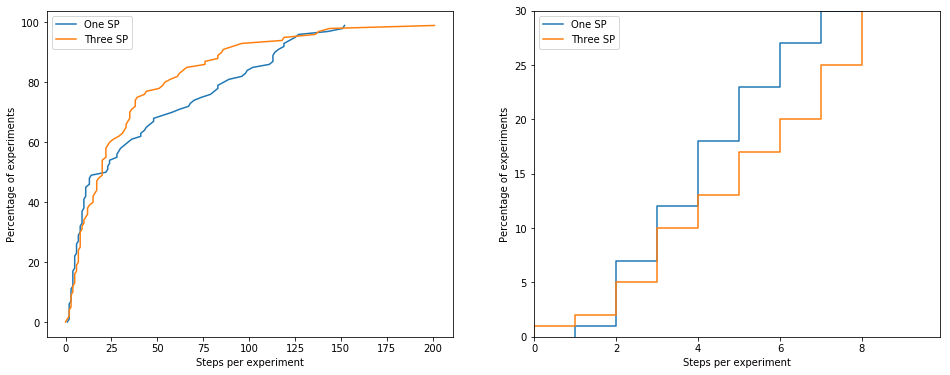

In [6]:
sorted_A = np.sort(jumpsA)

sorted_B = np.sort(jumpsB)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax1.plot(sorted_A, np.arange(sorted_A.size), label = 'One SP')
ax1.plot(sorted_B, np.arange(sorted_B.size), label = 'Three SP')
plt.legend()
plt.xlabel('Steps per experiment')
plt.ylabel('Percentage of experiments')

ax2 = fig.add_subplot(122)
ax2.step(sorted_A, np.arange(sorted_A.size), label = 'One SP')
ax2.step(sorted_B, np.arange(sorted_B.size), label = 'Three SP')
ax2.set_ylim([0,30])
ax2.set_xlim([0,9.9])

plt.legend()
plt.xlabel('Steps per experiment')
plt.ylabel('Percentage of experiments')

plt.show()

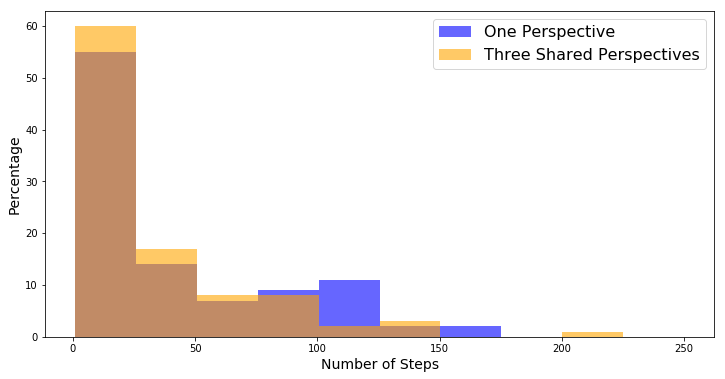

In [7]:
fig = plt.figure(figsize=(12,6))
plt.hist(sorted_A, alpha=0.6, color='blue', bins=10, label = 'One Perspective', range = (1, 250))
plt.hist(sorted_B, alpha=0.6, color='orange', bins=10, label = 'Three Shared Perspectives', range = (1, 250))
plt.legend(fontsize = 16)
plt.xlabel('Number of Steps',fontsize = 14)
plt.ylabel('Percentage',fontsize = 14)
plt.show()
#plt.savefig('histogram.pdf', bbox_inches='tight')

In [36]:
hist1 = sorted_A
hist2 = sorted_B
fig = plt.figure(figsize=(12,6))
plt.hist([hist1, hist2], bins = 8)
plt.legend(['One Perspective', 'Three Shared Perspectives'], fontsize = 16, loc='upper right')
plt.xlabel('Number of Steps',fontsize = 14)
plt.ylabel('Percentage',fontsize = 14)
#plt.show()
plt.savefig('histogram.pdf', bbox_inches='tight')

In [65]:
with open(r"data/3kinverted_reviews.pickle", "rb") as input_file:
    inverted_reviews = pickle.load(input_file)

In [63]:
with open(r"data/review_text.pickle", "rb") as input_file:
    inverted_reviews = pickle.load(input_file)

<H2>PATH EVALUATION</H2>

In [129]:
test_pairs = pairs100[63:65]

In [130]:
start_time = time.time()
for pair in test_pairs:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    for base in movie2vec_perspectives[target[0]]:
        print(base[0], inverted_reviews[base[0]])
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            print(base[0], inverted_reviews[base[0]])
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
            topk_cosine = sorted_cosine[:15]
   
            
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    if len(display) % 3 == 0 and len(display) != 0:
                        break
        
        print('Display', '-'*50)
        for movie in display:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
            print(movie, cursor.fetchone())    
    
# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            break
        else:
            steps = steps + 1

# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

        cosine = {}
        for movie in display:
            if movie not in discarded:
                for perspective in movie2vec_perspectives[movie]:
                    v1 = perspective[2:102]
                    for perspective_target in movie2vec_perspectives[target[0]]:
                        v2 = perspective_target[2:102]
                        v1v2 = str(perspective[0]+'-'+perspective_target[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0]
        print(closest)
        s = closest[0]
        closest = s[s.index('|')+1:s.index('-')]
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
print(round((time.time() - start_time), 2))

Start = ('Transamerica ', )
Target = ('Intolerable Cruelty ', )
Target movie perspectives:
A1TJMJQ2SK4V40|B00005JMET there were a few laugh out loud moments especially with billy bob thornton but this is an ultimately forgettable movie clooney and jones never realy click although she is nice to look at i expect better from the coen brothers well maybe next time this is worth a rental if you want something light and sappy but i would not advise buying it
A16F2K8VG7GDS9|B00005JMET while on the surface containing all the elements for a good cinematic experience george clooney catherine zeta jones the coen brothers cedric the entertainer etc intolerable cruelty suffers from the most basic problem namely that it s so unsure of what kind of movie it s supposed to be that it ends up failing for the most part across the board at first it would seem to be an update of the classic screwball comedy given the setup of clooney as the divorce attorney and zeta jones as a woman who chooses her husban

A3D92U8D1UHR5T|B00003CXTS great movie and i always loved julia stiles movies a white girl goes to a new school where she is the minority she try s to fit in and she does loved it
A2C2H81GT5VHZA|B00003CXTS this movie in my opinion was boring it had a lot of trash talk no really good dancing and a predictable ending julia stiles was dull but sean patrick thomas was good so if you like him watch it
A2U6CW4WGP3JH7|B00003CXTS this is a good movie to watch of you re in the mood for some hip hop teen romance i found it to be an entertaining movie to watch and cute as a romance
Display --------------------------------------------------
6303853102 ('Clueless ', )
B00009XITP ('What a Girl Wants ', )
B00000INCI ('A Woman of Substance ', )
1415719284 ('Elizabethtown', )
B005LAII2Q ('The Watch', )
B00DB43PLI ('Summer in February', )
B00004WMDT ('Center Stage ', )
B005J4TLN4 ('Attack the Block', )
B001DPHD9C ("You Don't Mess With the Zohan ", )
('ALJZLOIRCRX2U|B005LAII2Q-A1TJMJQ2SK4V40|B00005JMET', 

A11XKY4EIU2KNR|B00005JN0A it s not hard to see that eurotrip was from the same branch as road trip and old school these movies just aren t that funny you can lump them all together stir them up and come up with the same thing mild amusement it s not that they don t try i think they just try to hard to be funnier than 80 s comedies like revenge of the nerds but fall short scotty graduates from high school and gets dumped by his girlfriend who is supposedly the biggest slut in the world but he doesn t know so all through the movie we get to hear the scotty doesn t know song he is email penpals with a german girl named mike but he doesn t know it s a girl which is stupid from the get go how could you not tell the sex of someone after lots of writing it takes his little brother to tell him so to make a long story short he and his friends end up in europe to find his mike they have a run in with the manc soccer team in england a dominatrix nightmare in amsterdam an all male nude beach a fre

AL91HYB8K0Z17|630557605X i liked this movie when i had it on vhs it still is very funny and silly too you have to have movies that are a lot of fun sometimes drew barrymore does a great job also
A2Z2ZCEBXPGY1Q|630557605X never been kissed is a movie about a newspaper reporter josie geller drew barrymore that has been given her first story to go undercover as a high school student to find out what really happens to today s teens there is only one problem she was a total nerd when she went to high school never been kissed is a hilarious wacky movie that s shows that you can always go back to high school
A152C8GYY25HAH|630557605X josie geller drew barrymore is the youngest copywriter with her own office at the chicago sun times gawky clumsy and dressed in clothes that look like they came from the salvation army store she is one of hollywood s favorite characters the goofy but lovable nerd she wants to be an investigative reporter but her colleagues tell her it takes guts and courage to be

Display --------------------------------------------------
6300263681 ('The Monster Squad ', )
6300185788 ('Howard the Duck ', )
6302946387 ('Robin Hood ', )
6304546335 ('Clash of the Titans ', )
6301928555 ('Near Dark ', )
0767827716 ('Christine', )
B00001QEE2 ('Hercules ', )
B00003BDZW ('Vampire Hunter D ', )
6301773578 ('Star Wars ', )
('A2YNCV28ZNYR30|0767827716-A1TJMJQ2SK4V40|B00005JMET', 0.44871229871451868)
Selected: ('Christine', )
Selected movie perspectives:
A2YNCV28ZNYR30|0767827716 good movie like i remember and just as i figured and glad that i did buy it good site to get movies when i can t find them anywhere else
A1W702WG1LC6R3|0767827716 keith gordon john stockwell and alexandra paul star in johncarpenter s 1983 horror film based on stephen king s novel a teen gets possessed by his 1958 plymouth fury that killspeople this is a great film and this dvd has good pictureand sound plus neat extras i recommend this carpenter king classic
A3UH3X6PZ7WCWG|0767827716 poor artie c

A12B2L6ZHT5SS4|B00005JMCT i thought the first american pie movie was hilarious one of the funniest movies i ve seen i was anxious to see the sequel but while it had its moments didn t win me over like the first movie american wedding is the third installment and is it one funny movie it has been a while since i remember laughing so much at a film the basic premise is that jim is getting married the rest is just a setup for rude gags that just keep getting better
A3AOKQCH0YBZDS|B00005JMCT i enjoyed watching this movie lots of laughs and sophomoric fun that you ve come to expect from watching all the movies in the american pie series yes this movie is a bit predictable but nonetheless entertaining to watch it is nice to see jim and michelle get married in this movie and all the funny things that happen and go wrong along the way in planning for the wedding
A22UU4G210AII2|B00005JMCT well jim and the gang are back for the final installment of the american pie series but expect to see less 

A3F8J54XT1QJ7|B000QGDY06 sandra does a great job in this movie like some of her other movies i like it i felt a little sad at the end on what happen
A2Y3CWITEF9JGY|B000QGDY06 a new era of films has arrived this genre we d like to call alternate universe melodrama that is full of characters that live in impossible situations incomprehensive plots cheesy explanation and last but not least movie stars with dying careers the title says it all premonition is about a soccer mom who can see the future few days ahead by simple falling asleep does it sound like a cool concept indeed but the story is so poorly explained that you ll get frustrated by trying to figure out what day she is in and why she is having these strange visions you might also get frustrated by how much screen time sandra gets in this movie brief intro story premonition begins when jim hanson julian mcmahon shows the new house he just bought for his young wife linda sandra bullock they are thrilled about the house and this ne

Selected movie perspectives:
A2Z29N73CUH3GB|B00020BVYW this movie is worth seeing good story good acting great scenery if you like snow i found this movie pretty interesting all the way to the end
A1R2E2FETD8VYU|B00020BVYW i loved the learning experience charlie goes through to come to a respect of the inuit people i also enjoyed seeing how sweet he could be once he get that respect for kanaalaq
A24VWR9SO2C59I|B00020BVYW a story that develops through the struggle to survive in the wilds of the arctic tundra the character of charlie learns to respect and admire the inuit people when his survival depends on the skills and expertise of the inuit girl who was his passenger
Display --------------------------------------------------
B00003CXJC ('The Perfect Storm ', )
B00005V4XW ('Bandits', )
B005S9ELVC ('Gangster Squad', )
B00150N8EY ('Belle And The Beast', )
B000G1R38U ('Akeelah and the Bee ', )
B000F4PDF8 ('Eight Below ', )
B000059HAF ('The Sand Pebbles', )
B0007KIFI2 ('Flight of the Phoe

A3SBUOVMRR6XH6|B000BUNZXS not as bad as everybody made it out to be i actually liked it even though it could have been alot better rent it to see if you like it
A21VGNU5959O85|B000BUNZXS i rented this movie after seeing the more recent release of the descent because i had heard people compare the two when i brought it up in conversation the cave is nothing like the descent only that they both take place in the dark underground now that doesn t make the cave equal to bat guano its more like a distant cousin of a better movie we have a hodgepodge of cave explorers token black guy beautiful foreign woman the girl next door the handsome rebel the fearless leader the old scientist and the other monster fodder that s usually backing them up the story is familiar uncharted caves that in the beginning thanks to flashbacks show an ominous presence and make us realize these caves aren t inhabited by just blind albino fish and a gollum or two bring in the main cast who are there to stake their cl

Selected movie perspectives:
A2EIK4L9730WWJ|B00005JO16 land of the dead is gross zombie movie and if i was you i wouldn t eat while watching this movie because they show everything and anything go out and rent this movie
A1ZKAHFYCJRGQM|B00005JO16 the question above is what i asked myself repeatedly while watching his latest zombie opus land of the dead like the first two sequels to romero s 1968 night of the living dead land isn t so much a sequel as much as it is another view of a world overrun by walking flesh eating corpses the focus is on an unnamed fortress like city where the residents try to maintain some semblance of what life was like before the rise of the zombies of course in a perfect world land of the dead wouldn t even exist and romero s zombie saga would have been brought to a fitting conclusion with 1985 s day of the dead that movie came on the heels of night s masterpiece sequel dawn of the dead in 1978 for those who are not hardcore fans of romero s original zombie tr

Selected movie perspectives:
A3VDWPYWFGU2W1|B00005JLZK well if your looking for a movie with tons of gore and crazy deaths then this is the movie for you this movie had even better more creative deaths than the original i found it very entertaining and while very gory the deaths were cool and i liked this movie
A139ZF7CJVVTJU|B00005JLZK at heart all horror movies operate on the human response to mortality your average horror fan gets a thrill from the films because they are a sort of spice for life they are the seasoning that makes the mundane parts of life all the more richer watch a bunch of people get sliced and diced by a monster or madman and that adrenaline rush makes you feel as if on some level you yourself have cheated death for awhile or more it s nice to be alive the final destination films utilize the same premise but instead of creating a defeatable or relatable villain it makes the very act of dying the villain watching the movies it s very much like they decided that the

Selected: ('Joy Ride', )
Selected movie perspectives:
A2B1CGKA8K5G6C|B00005UV34 joyride it s a very good movie not that scary more of a thriller you can t wait to see what happens next i highly recommend this movie
AW4MT9WP95TVD|B00005UV34 joy ride is one of those crazy chase films that delivers a surprise ay every turn part duel part the hitcher this is one crazy chase film all the actors are fine in their roles and the trucker voice is more frightening than any of those calling the scared babysitters lots of thrills and chills with this one and a nice and nasty payoff has it s light moments too thanks to the casting of zahn as the irresponsible brother joy ride is a ride worth taking
A6VXZ1EEPRTLV|B00005UV34 directed by john dahl rounders joy ride 2001 is a thriller about the unexpected repercussions of a foolish prank a tense compelling adventure is built around the tragic consequences of a simple childish joke lewis thomas paul walker is driving his 1971 chrysler newport to boulder

Selected: ('Notting Hill ', )
Selected movie perspectives:
A91LE0MPYE8GJ|0783241569 this was good i liked it well julia roberts is a good actress and hugh grant is good too well you ll like this enjoy this movie
A1ZJIS0G21RMR2|0783241569 a great movie that has clever lines interesting characters and a good plot julia roberts and hugh grant have a chemistry that is delightful to watch
A12QR7VLSRYGDC|0783241569 notting hill is possibly julia roberts most enjoyable performance if you like her you will love this movie she is human and needs love like the rest of us magnificent supporting cast
Display --------------------------------------------------
0783241917 ('End of Days ', )
B001BEK86K ('Then She Found Me ', )
0792838963 ('Moonstruck', )
B00G7QPXAI ('Austenland', )
6306012389 ('Return to Me ', )
0783235593 ('The Man Who Knew Too Much ', )
6305470448 ('Shakespeare in Love ', )
0767812166 ('Starman', )
078322706X ('Meet Joe Black ', )
('A1AIKETKYWVID9|0783235593-A16F2K8VG7GDS9|B00005JME

Selected movie perspectives:
AB1EJ4MN1CZA0|0783233493 the hit song from this musical say it all a spectacular flop at the time of its 1978 release the movie has since amazingly gained some respect fans and critical acclaim a far cry from the original wide spread declaration that it was the movie that killed black films admittedly the movie does have its setbacks and embarressing moments but the fault lies with the talents behind the camera as opposed to the talents in front as donald bogle claimed in his book blacks in american films and television the movie s quot most important creators the director sidney lumet and the writer joel schumacher were white artists totally out of tune with the material and the style of their performers quot i might add that sidney lumet serpico dog day afternoon was totally out of his element what was he doing directing a musical being a fan of diana ross i remember the concern and snide remarks at the time of her being quot too old quot to portray dorot

Selected: ('Joyful Noise  ', )
Selected movie perspectives:
A3Q50SYF16WQWE|B007HHWJD0 can t beat queen latifa or dolly parton for singing good acting good music the plot was a little slow and too close to sister act plot
A21X7PJN5UNVQ3|B007HHWJD0 i love this movie it has it all laughter drama and triumph i highly recommend it for anyone who is looking for a fun uplifting movie dolly and queen latifia are great together
A1IM26W03K6RUN|B007HHWJD0 i and my wife thought this movie was a movie to be watched over again the songs actors the plot were worth the time watching i rate this movie 4 stars
Display --------------------------------------------------
B000J3OTSM ('Step Up ', )
B007C4ZJ0S ('Haywire', )
B00005JM4Z ('2 Fast 2 Furious ', )
B000TGUUFA ('The Christmas Card ', )
B005LAIIKS ('The Odd Life of Timothy Green', )
6303124798 ("What's Eating Gilbert Grape ", )
B005S9EJS2 ('None', )
B00BPEJZEM ('The Best Man Holiday', )
B00ARA4SLU ('Hitchcock ', )
('A2CEZNU9P1X3ZS|B00BPEJZEM-A1TJMJQ2S

AHPV4F8IVSC39|B001LM6VV8 if you think raunchy material is _inherently_ funny ignore this review if you think that raunchy material can be funny _if_appropriately_used_ skip this movie pointless banal boring raunch substitutes for humor this movie has boring dialogue no sense of pacing bad transitions only the pretense of a story arc and an unsatisfying ending the movie showed the characters zack et al knowing that even an amateur porno needs to do better than this except for zack all the characters were badly underwritten and this was especially notable for the female roles elizabeth banks role was little more than being luminous and how could a movie with two porn stars lords and morgan not have their characters making or responding to comments about their real life selves for this aspect and many more i disagree with other reviews labeling this movie as formulaic because it so badly botches the formulas that it dishonors that characterization for me the only real entertainment value 

Selected: ('Lars and the Real Girl', )
Selected movie perspectives:
AB4OYPWGHYAPO|B0014D5RBE it was very quirky thought it was going to be more of a comedy but turned out not to be it was kinda heartwarming story but not a movie that i thought was a ryan gosling film
A18G7GG53G2X8A|B0014D5RBE in lars and the real girl ryan gosling plays a damaged young man who lives a delusion he orders a life sized sex doll from the internet and interacts with it as if it were an actual living person in order to help him work through this the small town he lives in plays along going so far as to include the doll as a member of the community clearly this idea is completely unrealistic downright implausible but somehow in some maddeningly unexplainable way this film manages to be both engaging and endearing much like the character of lars we also buy into a delusional premise and see it through to the end the film itself is the delusion one of the most enjoyable delusions i ve experienced this year almo

A229MXLBXBXKD0|B0021L8UPS this movie actually surprised me it was a good horror film from 2009 it managed to make me jump a few times twisted ending didn t see coming
A2V5LCS9W2G7UB|B0021L8UPS this was a very good movie i definitely did not expect the surprise ending intense suspenful and a very a good thriller actors were solid i would recommend the movie this is evil at its worst
AN0U0GNJJPEUR|B0021L8UPS normally a movie like this would make the audience question if the child really is evil or if the recovering alcoholic mom grieving her stillborn child is losing it but not orphan no the audience immediately finds out that esther is absolutely evil there are few surprises in this contrived plot most disappointing was the chilling alternate ending there s no context for the scene so while it might be chilling under some circumstances there s no way to know what crimes esther has committed before this ending
Display --------------------------------------------------
B00009MEC4 ('May', 

ACGLEAX5YSA5I|B001QOGYAO this was not really my type of movie it was good but it was sadi know these things really happen i like more of an upbeat movie try this one out for yourself and see what you think
A1JV4QKTEB7QBL|B001QOGYAO without a doubt peter jackson the lord of the rings the motion picture trilogy widescreen edition will get an oscar nod for his utterly fantastic computer generated images in his depiction of heaven and an in between state in his film adaptation of the 2002 novel by alice sebold the lovely bones unfortunately the dream vistas portrayed detract rather than enhance the plotline of this bittersweet portrayal of susie a fourteen year old girl played to perfection by saorise ronan atonement widescreen edition whose murder by quintessential creepy mr harvey stellar stanley tucci as the loathsome 40 something loner wreaks havoc on her otherwise winsome family living in a fairly well depicted early 70s suburbia as in the novel susie narrates her story from the vanta

Selected movie perspectives:
A1ZK87ONRJTIL0|B00AENNHOE this show was more of a downer type and i didn t like it overall the acting was good but the whole things was rather depressing i wouldn t recommend it as a must see
A1EQO7W4NS3V2I|B00AENNHOE this is a touching movie the relationship he develops with this robot is so charming seeing an man getting old and feeling useless until he meets his robot friend it s a relationship meant to be you ll love this one
A24IJY3V0804WJ|B00AENNHOE is about frank langella a man in his seventies who is starting to lose his comprehension and thus an alarmed son hunter james marsden figures that he needs a home attendant to take care of him and gets a robot the robot does the housework doles out dietary advice and even reminds frank about his medicines frank does not like this and rejects him one day frank discovers that the robot can pick locks and this impresses frank who is a thief who has in the past spent many years in prison they begin a partnersh

Selected: ('Guess Who', )
Selected movie perspectives:
A1N8V6Q1IATBY3|B0009RCPUW this movie is cute and i think ashton kutcher was funny i would recommend this for a good laugh and to add to your movie collection
A3LZBOBV9H1HDV|B0009RCPUW guess who is funny bernie mac and ashton kutcher are a great comedic team it is a very impressive retake on guess who s coming to dinner
A30VR8MH9VKA3Z|B0009RCPUW after watching half of this film because that was all i can stand i never want to hear black people complain about racial issues anymore i can t believe in this day and age they can make a movie about black people not accepting white people and vice versa and not only that going on and on and on about it too apart from that i felt this movie was just a rip off of meet the parents the only twist being the racial subject i must admit i ve never been a bernie mac fan and after seeing this movie i know for sure i am not a fan there are some really bad and stupid moments in this film too like the

Selected movie perspectives:
A767V4FT94ZEM|B000QFCD7W this is a funny movie that i enjoy each time i see it great cast and acting makes me want to go cross country on a harley
AUJX2DUPAHI3T|B000QFCD7W this movie is better than i thought it would be this cast of characters are a great fit and a laugh out loud movie that will have you rolling
A139ZF7CJVVTJU|B000QFCD7W if it weren t for the homophobic jokes wild hogs would be about as long as an episode ofhome improvement although maybe not as funny i m not sure i guess that depends on your opinion of homophobic jokes four middle aged men with aspirations of gnarliness decide to de tame their adequate but unexciting lives with an old fashioned bike trip doug tim allen is a dentist on a diet bobby martin lawrence is a writer plumber who is whipped by every female in his family woody john travolta once wealthy now finds himself broke and dumped and dudley william h macy is a painfully nerdy computer programmer who is smart enough to install

A370BVOQEXO2GN|B00005JL7Q okay i think that you can stand the fumbling bumblings of hugh grant in this movie this movie is sweet and has a feel good message i found it pretty enjoyable
A1GQAKL9CGQLP1|B00005JL7Q charming film about how a young boy who needs a male in his life ambles into will s hugh grant life and changes it and him grant plays an unmotivated immature slacker it s an movie which will appeal to a diverse audience loved it
A24D0DENA8N7GH|B00005JL7Q about a boy has a problem everyone thought it was a chick flick so men stayed away from it in droves a modest hit in america it suffered from the perception that it was yet another hugh grant movie whose target audience was women but this is a movie for and about guys it is a movie that does a great job of examining the isolation so many men place themselves in and their relationships to the boys who will follow in their footsteps its proof that every boy needs a father in his life will hugh grant is a man who is living what a 

Selected: ('House of Sand and Fog', )
Selected movie perspectives:
A2OXDJP1Z3LNOK|B0001DMVBC could this movie be any more depressing i watched thinking quot it can t get any worse quot but i was continually wrong the film itself is good and the acting is superb jennifer connelly and ben kingsley are amazing in their roles still i never want to see this movie again it s that sad glad i watched it but i d never buy it
A2Z0A3DOG0EVTY|B0001DMVBC i have to be painfully honest before i begin i m a down home protestant at heart i spent my entire life going to sunday school and church so when i sat down to write my review for the house of sand and fog those pesky ten commandments kept jumping back into my head because i believe just about every commandment is represented and therefore broken it was impossible for me to not see it philosophically i believe humans to be fallen and therefore evil to the core this is not a judgement but a spiritual absolute i have lied stolen coveted and so theref

Selected: ('Larry Crowne ', )
Selected movie perspectives:
A28M2F3ANXTR3I|B005HWAOHK it was such an entertaining and touching film and in the current economic times the things that happen to larry crowne could happen to anyone feel good movie
AB9OT78S8YTVQ|B005HWAOHK it took me awhile to watch this because i had been sick but anything with tom hanks and julia roberts i always fine 1 great movie to get i know i enjoyed it
A328S9RN3U5M68|B005HWAOHK larry crowne is not a bad movie it is simply an unremarkable movie seeing the opening credits read a tom hanks production and written by tom hanks with nia vardalos directed by tom hanks starring tom hanks with cameos by rita wilson mrs tom hanks and chet hanks son of tom hanks we know we are in for a tom hanks family outing so expect a feel good flick and that is what is delivered not that feel good flicks are a bad thing in this particular time we need more of them but larry crowne seems to candy coat the current major problem of economic di

Selected: ('Righteous Kill', )
Selected movie perspectives:
AOMPYFMZU7S1O|B0015OKWL2 pacino and de niro together again this movie had a twist you just didn t see till the end great writing and perfect cast these two together are fantastic definitely a must see
A27VY7BUVD09I2|B0015OKWL2 two veteran cops turk and rooster robert de niro al pacino work to solve a string of murders in which the victims are criminals that they have previously arrested and have been acquitted of their crimes something s seems a bit fishy at least that s what two younger cops detectives riley and perez donnie wahlberg john leguizamo start to think furthermore they suspect it s a cop anyway you splice it the decorated members of the nypd are looking for a killer one who leaves a bit of poetry at every scene and happens to murder the filth of society that has slipped through the cracks of the judicial system righteous kill is only a slightly above average thriller given the big name talent de niro and pacino bot

Selected movie perspectives:
A2P8W1ZCW46E2A|0780628799 the other fantastic prison movie the first one being the shawshank redemption this one is a little more magical and very touching do not miss it
AUTUYKL8525WP|0780628799 i found this movie very captivating and heart warming it makes you wish there were really people like that in the world to take away the bad
A3QBB4DINWSBM4|0780628799 this film was better than shawshank though i did like it too the film has some great casting great script adaptation and a pace to keep you interrested one of the few film adaptations of king s work that seems to hit a home run for me well worth purchasing for repeated viewing
Display --------------------------------------------------
080018520X ('On the Waterfront ', )
0767811100 ('As Good As It Gets', )
6300214184 ('Flashdance ', )
0790740281 ('Defending Your Life ', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
6302468027 ('Fried Green Tomatoes ', )
B002XTBEDI ('Cranford: Return to Cranford', 

Selected: ('Ghost & Mrs. Muir ', )
Selected movie perspectives:
A1U6R9WN7DJZFX|6301586042 gene tierney and rex harrison present a quiet endearing story of a romance between a widow and a ghost there is nothing in this movie that should be changed
A3HRJSLRXGPC48|6301586042 put this in on a rainy day and thoroughly enjoy yourself sweet and tender a classic romance never tire of it rex harrison is a perfect sea captain
A38I37UOS450LN|6301586042 i have always loved this movie and was so happy that it worked on my dvd player one of the best movies of it s time
Display --------------------------------------------------
B004X181TY ('Jane Eyre ', )
6302227127 ("The Bishop's Wife ", )
6300214567 ('Witness ', )
6302728657 ('Enchanted April ', )
079073463X ('Ladyhawke ', )
0790744759 ('Meet Me in St Louis ', )
6304030959 ('Jumanji ', )
0790741105 ('Caddyshack ', )
6304107250 ('Great Race ', )
('A1345VRK5MYG7|6304107250-A16F2K8VG7GDS9|B00005JMET', 0.41957384020685917)
Selected: ('Great Race ', )
S

Selected movie perspectives:
A8BW6F16DEZOZ|B008JPZUYE i like jeff dunham and i enjoyed minding the monsters but i did not feel it was as good as his other dvd s i would recommend this to all jeff dunham fans
A2Q81DVUISSQIG|B008JPZUYE we have all of jeff dunhams dvd s and he is hilarious as usual and the best comedian ventriloquist we ll ever see because with his characters he makes so much fun of himself
AL76ZXAYKV9YA|B008JPZUYE all of jeff dunham dvd s are great if you get one you should get them all it will be worth it you won t be sorry
Display --------------------------------------------------
B0034JKZ3G ('The Princess and The Frog ', )
B002ZG99G8 ('The Losers', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
6303610811 ('Tommy Boy ', )
B00005ALS0 ('Best in Show', )
B0083H6APG ('Jesse Stone: Benefit of the Doubt', )
6300216403 ('Paper Moon ', )
B001M5UDGS ("Dr. Horrible's Sing", )
B001GCUNW6 ('Ice Age: Dawn of the Dinosaurs ', )
('A11PYOYGM70DNY|6303610811-A3HDK0RC04OJ9R|B00005JMET', 0.

Selected movie perspectives:
A3HEI2B90ZEYF6|6300183467 i grew up in the 8o s so of course i had to have sixteen candles a very funny movie with a great cast if you like to laugh then this is a definite buy
A461VTLW9G9YB|6300183467 i am anti molly ringwald but this movie is too funny to ignore girls sweet 16 is coming up no one remembers then she has a major crush then she has an exchange student living in her home then her grandparents come not for her sam but for her sister s wedding too funny
A3EXGUW41NVFGO|6300183467 i loved this movie when it first came out and now my daughters love it as well i m so glad i decided to buy it nice for my collection
Display --------------------------------------------------
6300214370 ('Footloose ', )
6302878616 ('The Sandlot ', )
0792164482 ('Runaway Bride ', )
6300275213 ('Splash ', )
0783233078 ('Fast Times at Ridgemont High ', )
B00005O5DJ ('Cats & Dogs ', )
6300214508 ('Young Sherlock Holmes ', )
6300183483 ('The Last Starfighter ', )
6305283362

Selected movie perspectives:
A26PHIM4GGF479|B000F3UAFC i liked the scenery and i always like helen hunt but the young scarlett johansson was a bit annoying maybe this could have used a bit of wilde s farce
A129ARXHWO9ZZM|B000F3UAFC i had never heard of this movie but it looked interesting it was good story with a surprise ending well sort of a surprise if you like period pieces it is a good one to see
A2EEUQ81DTY7G3|B000F3UAFC the lovely mrs erlynne has a problem spurned by all the society ladies for discreetly servicing their husbands she can no longer afford to spend her days living in new york as the woman of ill repute suddenly she finds herself an outcast and penniless so she decides to travel to the amalfi coast of italy where she hopes to squeeze some cash out of some fresh prey she sets herself on the young newlyweds robert and meg windermere mark umbers and scarlett johansson and in the process she hopes to find herself a new man but mrs erlynne also holds a secret a secret th

Selected: ('Mirrors ', )
Selected movie perspectives:
AER15RIMV8E6D|B001JNNDC4 i thought mirrors was pretty good kiefer sutherland does an awesome job just like in 24 there were some scenes that were kinda creepy although i was a little disappointed about the ending if you love horror and kiefer sutherland you might like mirrors
A1FJ4WAOIDPEF4|B001JNNDC4 i don t do plot synopsis in my reviews so just scroll up for that this is the newest alexander aja film directed high tension and remake of the hills have eyes so far his films have been about human killers and sociopaths but this one veers into the supernatural he s got the goods when it comes to moody lighting and a good set up but he brings along some ultra gorey sequences that were more fitting in his previous films well there are actually only two in the film but the second scene of major graphic violence is real grotesque and may turn off those tuning in for simple haunting the set up is basic horror stuff ex cop swear they re al

Selected: ('The Lords of Salem', )
Selected movie perspectives:
ASK2W48SIC34W|B00C7C00JU lords of salem is definitely something that many probably will not like i however loved it was creepy and dark definitely weird which is what i like to see from mr zombie
A1XGH8W57Z5TSJ|B00C7C00JU this movie sucks how rob zombie is a director and gets money to make these crap and awful movies i just don t know the only ok movie he did was the remake of halloween and that was somebodies else work he copied from so please rob leave the horror movies alone
A10HR2LD9ZY0VU|B00C7C00JU but this movie was awful i am a rob zombie fan i like his music and i ve enjoyed his other films this looks like a patchwork two hour music video and makes about as much sense in fact i probably would have enjoyed this more if it had been some kind of extended music video project as a movie this fails it is ploddingly slow disjointed and highly contrived the 34 twist 34 if you want to call it that can be seen from a mile aw

Selected: ('Gremlins ', )
Selected movie perspectives:
A2B3Z2QHW3V35S|0790742705 this is a good movie a must see movie for family night it s not scary at all i think gizmo is the cutiest gremlin i wish he was real so i can have him as my own pet i would like to also talk about gremlins 2 that movie is a lot more fun to watch the gremlins have a lot of lines they are funnnnnnnnyyyyyyy
AILWN0QU28S1Y|0790742705 i always loved this movie as a kid and when i seen it for sale i had to buy it it is a great price for a classic movie now my kids will be able to enjoy the same movies i was able to when i was younger
A2TDK8D4HEMUYW|0790742705 some films are not what they seem take gremlins 1984 for example it is the story of a small town kid who acquires a strange creature that spawns a pack of menacing green beings that terrorize the inhabitants of the cheery little area a silly idea yes but surely a fun one and surely one to be cherished it isn t technically a great movie or even a very good on

Selected: ('Killer Joe', )
Selected movie perspectives:
A3S0MEW66XORZQ|B0090SI3CA matthew mcconaughey can do anything and everything good don t get this if you get creeped out easily i loved it but it is an acquired taste
A231X2N9KL3BU5|B0090SI3CA the only highlight of this movie was looking at matthew mcconaughey the story line was ridiculous it has twists and turns but all and all it s stupid rent it if you 34 have 34 to see it but don t buy
A34D06JL7LC6MU|B0090SI3CA few films contain such a palpable mix of dark comedy and brutality as william friedkin s killer joe the film reunites friedkin with writer tracy letts who last worked together on 2006 s bug that film was a memorable little oddity that polarized audiences if you have the stomach for it killer joe is the superior film for friedkin whose career was built on successes he had decades ago it s a roaring comeback for the star matthew mcconaughey it s a career renaissance in the last year after serving time as the go to guy for 

Selected movie perspectives:
A2OVTQN1M9OHVJ|B00005JLK0 ghost ship is a classic ghost story at sea despite being a bit gory it s got a great cast a solid plot and some spooky ghosts
A3528P8SBSBH7T|B00005JLK0 this movie was only 2 91 so i figured i was out nothing to try it it would not be worth full price but it is cheap entertainment it was not horrible and kept my attention although i thought it could have been more spooky anyhow no complaints for just over 2 bucks
A2HUU0YW6HNNQE|B00005JLK0 as if dark castle entertainment didn t learn its lesson yet ghost ship is by far the worst film to date to be released by the company they also produced the remakes of house on haunted hill and thirteen ghosts both were equally terrible films in their own right but ghost ship takes the cake if those two films were bad ghost ship achieves a new level of awfulness all i kept thinking while watching this film was how notable actors like gabriel byrne juliana marguilles and isaiah washington would degr

Selected movie perspectives:
A391UG1CNFK463|6304286325 a great movie full of skating and throwing a little bit of love this movie is very cute and i have watched it over and over again i would think those who like chick flicks this is definitely a must watch
A2UUS5CMDXZN8B|6304286325 if you haven t seen this flick you re missing out after watching this flick i wondered why there weren t more hockey players who moved into figure skating and though i will probably never watch figure skating for reals this film does make you appreciate how difficult a sport it actually is plus d b sweeney is a dude
A986RVMAE8HH2|6304286325 in this underrated romantic comedy of u s olympic pairs figure skaters which star moira kelly as a top figure skater and co star d b sweeney a unlikely partner a tough hockey player are teamed together to go for olympic gold along the way find that they are more than just partners as well as what they can accomplish together towards their goal to be olympic champions a 

Selected: ('Madagascar: Escape 2 Africa ', )
Selected movie perspectives:
A2YW2DVVYTZV2U|B001NCDFTW purchased this blue ray for the grand kids of course they liked it the voice over characters are really great my wife and i enjoyed watching it to funny
A2X2FD6YEV5PLW|B001NCDFTW another good installment in the madagascar line like the other movies it is entertaining for the kids and has good humor for the adults a good family movie night movie
AQJFYKOCB3YYB|B001NCDFTW the kids never got tired of this movie so it was worth it to buy i thought it was better than the first madagascar it s still funny after watching over 20 times
Display --------------------------------------------------
B001DPHDCY ('Horton Hears a Who ', )
B001HN6922 ('Cars 2', )
B00005JNQS ('Robots ', )
B005LAII62 ('ParaNorman', )
B007MDB548 ('Secret of the Wings ', )
B00005JNQG ('The Pacifier ', )
B0002IKSFM ('Love Comes Softly', )
B000WZEZFY ('Superbad ', )
0780614097 ('Mr Blandings Builds His Dream House ', )
('A3R6PR5

A2HVL790PBWYTU|6303118240 my opinion only but fans of animation must bow down to hayao miyazaki in fact fans of movies in general and of art must give mr miyazaki his due propers i ve seen his recent stuff princess mononoke spirited away howl s moving castle and am left awestruck the man is a genius in his purview and he works hard simply remarkable the craftsmanship and soul and depth fused into these pictures having fanned myself into an addiction for more of mr miyazaki s works i ve started to backtrack and catch up on his older films my neighbor totoro released in 1988 was my intro to his more classic stuff not too surprisingly i really enjoyed it most folks consider my neighbor totoro or tonari no totoro to be a masterpiece and who am i to argue set on a more intimate scale than mr miyazaki s other more grandiose efforts it s one of the best family films around particularly in terms of portraying the family interrelationships the way in which the two young girls connect to each ot

AFUNA1LC6D5U5|B000F6IOAM this movie seriously could have been 10 minutes long nothing happened almost the whole time i paid 10 to watch a girl pace around a creeky house for 2 hours then get chased for 5 minutes at the end there were no scares until literally the last ten minutes of the movie which weren t even scarey it was ridiculous the tense scenes before then all kept ending up to be nothing like her friend stopping by the house to say hello or the cat knocking something over do not see this movie if your expecting a good horror flick not even the music is scarey come on
A7PZZXJJZM4N2|B000F6IOAM when a stranger calls is all about things that go bump in the night about prank phone calls and about the fear that someone may be inside the house on a windy night director simon west has taken the reigns of a project with extremely limited material which is more than obvious when you watch actress camilla bell run around with a phone in one hand and a flash light in the other breathing d

Selected: ('Darkness Falls ', )
Selected movie perspectives:
A2EIK4L9730WWJ|B00008LUNW darkness falls is one of the best horror flicks out there and it has its jolts and chills within the movie a tooth fairy witch is out to kill everyone in darkness falls the only way to stay alive is to be in light and you have to stay out of darkness if you want a really good scary movie then go check out this movie
A271UZ21OANCYP|B00008LUNW now don t get me wrong here i thought this movie wasn t so bad but it s just another generic tasteless today s scary kubric wanabe films the plot let s face it stinks after the kid loosing a tooth at night come a simple generic monster with a mask after people that can t see the light gimme a break as generic as possible but that s not only that the worst part actually is in the final part of the movie when the guy is about to be eaten by the demon in the lighthouse when he puts down his arm on fire without suffering and punch the monster common the guy should ge

Selected: ('Urban Legend ', )
Selected movie perspectives:
A1LBVM332AACDW|0767819438 well this is probably the worst of all the teen slasher films but still okay scream and i know what you did last summer are better the storyline gets you hooked and the acting isnt all that bad the ending wasnt a five star one but it kept it interesting the killer was a big suprise but they shouldnt make the killer the hottest girl in the movie
A37AY3YMDYH7BY|0767819438 a killer is killing students on a college campus by copying urban legends if you know a lot about urban legends this movie will get you re familiarized with them unfortunately if you are very familiar with urban legends the outcome of each killing is sometimes predictable a small role by robert quot freddy krueger quot englund and some good acting by alicia witt and rebecca grayheart makes this a watchable movie
A3NNNBUFPK7DGT|0767819438 although i really liked urban legend its just an imitation of other horror movies it is kind of simi

Selected: ('Michael Clayton ', )
Selected movie perspectives:
A3VW2V576DTJFH|B00121QGPY in my opinion this is george clooney s best screen effort playing a flawed attorney who cleans up the messes created by a high powered law firm s clients there is redemption at the end
A1FG5WAHN094AM|B00121QGPY george clooney s acting is what makes this movie worth a watch screenplay is good but could have been better and that would have made the movie more interesting overall you will like it if you like suspense dramas
A2FEJIORC1MBG3|B00121QGPY the late great paddy chayefsky would surely be pleased by the opening salvo of searing verbiage that launches writer director tony gilroy s superb new legal thriller michael clayton the fine british actor tom wilkinson nearly walks off with the movie before the opening credits are even finished rolling with a magnificently performed voiceover rant that recalls howard beale s cleansing moment of clarity in network wilkinson portrays arthur edens a crack lawy

Selected movie perspectives:
AU34RSYOPPCRT|0784011796 the plot did not grab me it seemed to be a homemade movie i couldn t continue watching it because it was a bit boring and i was looking for something that would be more entertaining
A3QVAKVRAH657N|0784011796 some information is simply not safe for us not because there is something wrong with its possession in the abstract but because it is the sort of thing we humans are not well suited to cope with there are various things we simply ought not not to know if we did not have to live our lives amidst a fog of uncertainty about a whole range of matters that are actually of fundamental interest and importance to us it would no longer be a human mode of existence that we would live instead we would become a being of another sort perhaps angelic perhaps machine like but certainly not human nicholas rescher an essay entitled forbidden knowledgein his excellent book forbidden knowledge see orrin s review roger shattuck discussed the persist

Selected: ('Megamind ', )
Selected movie perspectives:
A11PK2MO25K5QW|B003UESJF6 great story and fun movie i liked it and it will be watched more than once the animation is not the greatest but is good the story line is different and fun
A3C0TQBK5GWKX9|B003UESJF6 i kinda wish i had seen this in the theater before purchasing it because honestly it s not a keeper the package comes with a blue ray 3d 2d disk but no regular dvd bummer an ok movie probably more entertaining for kids i suppose
AP1WE2DB14IL1|B003UESJF6 megamind is something of a mix but a good one on the one hand it takes the existing traditional tropes of comic book superhero and supervillain and works within them but at the same time it ventures into territory that one rarely sees going one step beyond the traditional to answer two questions 1 what really makes a supervillain truly bad and 2 what happens when the supervillain unexpectedly wins the film starts off with a traditional hook megamind apparently falling to his do

A1TDSPN5G1PP2L|0790735172 bruce lee s first and only american film enter the dragon is amazing it has a good plot and good dialogue and actors but it s bruce lee that makes this picture so enjoyable his incredible martial arts techniques will blow you away second only to return of the dragon this is a must own for any serious martial arts film fan
A1QA7MERUNITNO|0790735172 i loved the late bruce lee and all of his movies i still think he s the best martial artist there ever was enter the dragon was missing from my collection and i m happy i was able to get it good movie
A3VJI9L000VRYT|0790735172 this movie is great in any format however it is even better in the hd dvd format if you have hd dvd player the extras are like nothing you have ever seen before all in one place
Display --------------------------------------------------
B0009S4IHY ('Kung Fu Hustle ', )
B002UZCJ8Y ('Surrogates', )
0783240961 ('The Invisible Man', )
0790729687 ('Interview With the Vampire', )
0790731533 ('Purple 

Selected: ('Bridget Jones ', )
Selected movie perspectives:
AK1OBVI54SY73|B00005JNDZ i really was worried how well i would like the second movie of this plot i really enjoyed the first one and wanted to enjoy this one as well it took me awhile but i decided while at the movie place to get the film and i must say i was relieved that this film was just as witty and interesting as the first one bridget is a cool character that you just have to watch and she doesn t fail on the second story on her it s a romance comedy in all its glory and even though i usually find romance comedies silly and overdone at times i find both bridget jones great and original i love the little quiz they give throughout the film as well that makes the movie fun and that is what this movie is fun and just a film you watch with your friends or when you just need to lift your spirits ps daniel and mark fight again don t miss it it s hilarious
AZTDHDUTVOSCC|B00005JNDZ at the end of bridget jones diary sweet sexy clu

Selected: ('Dolphin Tale', )
Selected movie perspectives:
AFT0AINBQZWEE|B004EPZ01G i bought this movie after i had watched it and loved it i wanted my mother and good friends to see it it s special that winter is a real dolphin
A1UWMOFWP3NTF8|B004EPZ01G dolphin tale was very well made and left me with that warm fuzzy feeling i would recommend this movie for a movie night with the kids and is a great family movie
A2EPVK7MO9I1Q7|B004EPZ01G the dolphin tale was a wonderful true story about a dolphin that was very fortunate to have been rescued and helped by so many caring people anyone would highly enjoy this film who loves dolphins
Display --------------------------------------------------
B000NA6CP4 ("Charlotte's Web ", )
0790730987 ('Driving Miss Daisy', )
B005LAIGN2 ('Red Tails', )
B00005JPL5 ('Bridge to Terabithia ', )
6303122876 ('The Dark Crystal ', )
0783234066 ('The Land Before Time', )
0783240694 ('October Sky ', )
B00005JMCN ('Seabiscuit ', )
B001TOD6N4 ('Taking Chance', )
('A3

Selected movie perspectives:
A1QAZTE8GMGQQI|6305126062 good romance but i thought it was going to be more about the horse i was a little disappointed there the story is good but i wanted to watch the relationship between the horse and the whisperer more those moments when he is with the horse are powerful good acting just wanted more horse time lol
A2IVVR7QXDCBGJ|6305126062 although this is suppose to be a love story it takes a backsit to healing the spirit of both horse and rider who had a horrendous accident together and can t get over the memory beautiful landscapes and what life should be all about family and togetherness
A39CX0EE4BZCZC|6305126062 here s a beautifully filmed horse opera about a new york teenage girl scarlett johannsson who is now a well known actress but wasn t when this was made and her horse both of whom are badly injured in a mishap and are healed by a montana horse expert played by robert redford redford also directed this film and being such an outdoorsman you

A2809U2S14N0K1|B004LWZW8I visually it is very good the colors are brilliant the special effects are very good if you do see it make sure it is blu ray the acting overall was quite good i thought i did like the acting of king hyperion what let it down for me was the story which i thought was terrible so i would not see it again nor recommend it
A1MPQZEPFMJ1R6|B004LWZW8I i thought like a lot of other people this movie was going to be like 300 not really the visuals maybe but it was more like clash of the titans but better i did like clash of the titans the fight scences where awesome but i was confused this being about the theseus and the gods why did everyone look like and fought like the had some training in mma but thats just me
A73QPH7NGI0DJ|B004LWZW8I western literature has been mining greek mythology ever since the time of the romans but the last few years have seen a volume of screen adaptations not seen since ray harryhausen was in his prime the start of the 2000s saw a couple of

Selected: ('King Kong Vs. Godzilla ', )
Selected movie perspectives:
A2LYN6JF4EV5UX|630362572X this movie was laughable king kong looked like a stuffed animal and him getting stronger from electricity was ridiculous the fight scenes were funny i wouldn t recommend this movie if you want to see a godzilla movie with good special effects
ABUN1TISYVQ37|630362572X godzilla escapes from his ice imprisonment where he was defeated in the end of the previous entry godzilla raids again aka gigantis the fire monster and invades japan fairly ticked off about being in that ice for so many years meanwhile a tv pharmasutical company has discovered an island where special berries can be found the berries are used to placate a giant god mr tako the ceo of the tv pharmasutical company sends men to go get the monster who turns out to be toho s version of king kong a giant ape after kong defeats a giant octopus he gets drunk on the rare berry juice and passes out tako s men tie kong up and try to tow him

Selected movie perspectives:
A36NUDST4Y5JBA|B002R0ELCY this was a different take on good and evil personally i rather liked the criminal versions ofbatman superman and wonder woman but that s just me four stars
A1OG3N2BYWTKR|B002R0ELCY i like the other dc movies as well as this one just love the justice league great xtras animation action and of course the old jl jla cartoons w it
A3OLP2A09TCFU9|B002R0ELCY i liked this film i watched right after the superman doomsday film which was horrible although this film seemed very rushed it had a fun story and lots of nice battles and a cool story line i think owlman was a bit over the edge in the i m so dark no one understands the world like i do department and wonder woman was watered down especially considering that her counterpart superwoman was pretty amazing basically an alternate earth where the justice league are actually criminals want to invade the normal dc earth and our justice league has to prevent it by teaming up with the alternat

Selected: ('Blade ', )
Selected movie perspectives:
A1K7AGSTZ1206I|078062369X finally a mainstream vampire flick that is cool and delivers the action right away it is established that this is going to be different from every other vamp movie you ve seen before i don t mind big budget hollywood productions as long as they are somewhat creative with the storyline don t bore me with endless dialog build up and provide lots of action and fun blade was a real surprise as i wasn t expecting much but it really blew me away with spectacular visuals chase scenes that get your heart racing a badass hero snipes character blade stunning action and an overall ultra sleek feel with tight pacing and a real lack of dullness how refreshing the gory death scenes are a nice treat as well this is the advantage with cg effects you can do pretty much anything if you can imagine it villains are sliced to pieces and spray geysers of blood similar to shogun assassin another cool movie people should check out w

A18JPN9WD6V98F|0792845684 if you like kurt russel then you ll love this flick the second one really wasn t as original but oh well still a good time
ACL34V7IL9SQH|0792845684 the cult classic from john carpenter kurt russell plays snake a tough criminal who is sent into new york which is now a prison to save the president
A25ZVI6RH1KA5L|0792845684 back in 1981 john carpenter released a film set in 1997 that depicted a somewhat bleak future for the united states in that the crime rate had risen to the point where it was necessary to turn new york city into a maximum security prison by enclosing the island in giant concrete walls installing landmines on the access bridges and providing constant surveillance with the threat of death for any that try to escape felons convicted and sent to this prison are given the option of execution rather than being forced to try and survive in this hellish nightmare environment truly only the strongest and most ruthless survive behind these walls the fem

A2D8CUJPOSRPNA|6301888901 in die hard bruce willis character john mcclane found himself having to battle a whole truckload of german terrorists in a los angeles skyscraper two years later in the 1990 sequel die hard 2 die harder he finds himself battling terrorists again this time of a homegrown nature and in the nation s capitol no less willis is awaiting the arrival of his wife s bonnie bedelia flight from los angeles at washington s dulles airport on a night where a blizzard is battering a good part of the eastern seaboard but while waiting his well oiled cop instincts get wind of some funny business involving army mercenaries as it turns out willis will be forced to fight once again for these mercenaries led by an extremely ruthless right wing colonel william sadler have now disabled the entire airport so that they may escort a deposed south american dictator franco nero whose anti communist credentials apparently overshadow the fact that he was also a drug lord and as had been the

Selected movie perspectives:
A1NTU1944WGIYG|B002XTBEDS a remake of the movie done by hitchcock humorous full of twists and moves quickly it s worth a look to see this new bbc re make
A3OA9N1B5OHYCV|B002XTBEDS if you were a fan of mi5 and want more from penry jones this is a good choice the story is a bit dated but very well done and penry jones is very handsome
A2TXR85WQLE32N|B002XTBEDS diplomat intelligence officer and adventure writer john buchan s superb 1915 thriller the 39 steps has been recreated several times on the big and small screens most famously in alfred hitchcock s 1935 movie the 2008 bbc production is now available on dvd it stars rupert penry jones familiar to pbs fans as captain wentworth in 2007 s persuasion as richard hannay a resourceful scottish mining engineer just returned from south africa to the united kingdom in 1914 as tensions rise with an aggressive imperial germany at loose ends hannay encounters a british secret service agent on the run who imparts a not

A3M1OVHZM41MLQ|B0007CNXUK this is a very touching movie it s so lovely here you see that you can make a movie without an action or love scene the actors johnny depp kate winslet and freddie highmore peter are brilliant the story is very good and very sad
A73AVAAV1PVGP|B0007CNXUK wonderful thats the word that comes to mind when i think of this movie i m not going to give anything away watch and find out but by the end there wasn t a dry eye in the cinerma kate winslet and the boy who played peter did a fantastic job
AO19QQOF7E2SX|B0007CNXUK finding neverland is the story of a man who doesn t want to grow up and writes the story of a boy who never does the boy is peter pan and the man is sir j m barrie who wrote his famous play after falling under the spell of a widow and her four young boys that barrie was married at the time that he all but ignored his wife that he all but moved into the widow s home that his interest in the boys raised little suspicion would make this story play very 

A2FBWEM0ZO11WL|0790729709 love the movie and the soundtrack is great as well i think that this being whitney s first movie she did a good job good love story
A22QBPOG0A08AB|0790729709 i had this movieon vhs and had to have it on dvd great movie with whitney houston and kevin costner makes you laugh and it will make you cry
A2W6UY1E7YI3BG|0790729709 this action film with its stunning soundtrack reaffirms a cherished tradition for nobility under fire some of the great warriors throughout history were bodyguards for women overtures codes of conduct epic stories of chivalry and unrelenting heroism were written to honor those who took a sword or bullet for the women under their protective wing rules of conduct prevailed in antiquity even for passionate men who found themselves in service to and falling in love with women of noble birth to hold dear the memory of service and requited love to a wealthy woman this would be the premise of bodyguard the motion picture accepting the consequences 

Selected movie perspectives:
A1GWE517BA5038|6303187064 you cant say much about this movie except masterpiece however it was made more real by the sad death of brandon lee knowing he died gave the film an dark feeling but it is a great movie watch it
A2CIDRAKPEEQKM|6303187064 i loved this movie it still sad to think this was brandon lee s last movie i look forward to seeing this on blu ray it can t rain all the time
A39UKBJJXJ82FO|6303187064 based on the brutal graphic novels of james o barr the crow follows a murdered rock star named eric draven brandon lee who was murdered along with his fianc eacute who was also brutally raped by a pack of savage hoodlums on the night before halloween a year later a crow brings eric back to life as a kind of zombie in order for him to avenge the death of his loved one so that they can finally rest in peace after putting on mime make up and dressing himself in dark clothing he goes out and exacts gruesome revenge he eventually comes across the drug lo

A2PGD2M7FYUQFA|6303327974 this is a movie i d been wanting to see for a while but my local movie place never had it i m pretty sure somebody stole it p anyway i finally got around to watching it and i was not disappointed it s got two of my favorite actors woody harrelson and robert downey jr along with juliette lewis not to mention a cameo by the one and only rodney dangerfield woody and juliette are traveling across the country while going on a killing spree and becoming famous in the process it s wonderful metaphor for the media and in a way i feel it predicted the reality tv boom we re living in honestly i sometimes think producers are purposely putting crap on the air just to see what people are willing to watch scary as it sounds the idea of mass murderers becoming celebrities doesn t seem that far fetched to me this is a very 90s movie if you don t know what that means i m not sure how to explain it it just has that nineties feel to it the same way 80s movies have a certain feel

Selected: ('Burn After Reading ', )
Selected movie perspectives:
A117T9RJCLJZVP|B001IZNIZU this is a quirky funny flick about the cia and it should be no surprise that it came from the coen brothers brad pitt is fine as an air head and john malkovich and george clooney are great as usual if you like the other coen brothers films as i do you will enjoy this one
A36EW68H08UOCS|B001IZNIZU joel and ethan coen make movies that are at right angles to most of the rest of hollywood their dramas going back to blood simple have a refreshing splash of humor and their comedies going back to raising arizona have dark elements the coen s are so adept at crossing stylishly from one genre to another it is no surprise that their grim oscar winning no country for old men is followed by this delightfully twisted comedy i repeatedly find in coen comedies characters who are not only entertainly dumb but as happens so often in real life doesn t it unaware of their stupidity think back to the big lebowski an

Selected movie perspectives:
A29BQ6B90Y1R5F|B00005JPQZ let s get one thing straight from the get go the simpsons is one of the most beloved tv shows in the world let s also get another thing straight the show has been around for nearly twenty years and has actually caused a divide among fans those who believe the show is still good or sometimes better than ever and still has legs and those who believe the show has been declining in quality for years i warn you of two things before you read on the first i am one of the simpsons fans who believes the show has been declining for years i still sit down and watch the show but in all honesty the last good season was probably season 10 the second because of my stance this review is heavily biased i love the simpsons i ve sat down and watched it since the first episode aired but sometimes even fans have to realize when their favorite show churns out something that doesn t live up to the standards of fans perhaps its because i ve been with the 

Selected movie perspectives:
AQ1F3NP2G15S5|B000HCPS8U when i saw this film it looked like a promising comedy but turned out to be a drama all the trailers pointed to it being a comedy so i went to see it i was disappointed in that it did not make me laugh and both jennifer aniston s and vince vaugn s characters were not likable i was just mostly bored watching the movie this tale of lovers at the end of a relationship would have been handled better with other actors not that i think jennifer and vince are bad but they just don t seem to fit these characters
A2R1HAXRNU0QX7|B000HCPS8U i only just saw this film after all the mediocre reviews when it came to theatres i wasn t exactly clamboring to see it but yesterday it presented itself and we had time to kill and now i know why it wasn t much of a hit the trailers of the film promised a comedy about breaking up and showed lots of jennifer aniston and vince vaughan two performers who have a lot of goodwill stored up with the public yikes 

Selected movie perspectives:
A3LUJ8N9XO3O4E|B001GCUO4S they took these movies too far and they just get more stupid i only got this one because i have all the other final destinations but won t watch it that often
AA9GGQTQPA0EZ|B001GCUO4S a good but rated movie the final destination rental is a very nice job if you like this type of movies i will wait final destination 5 on blu ray dvd
A18G7GG53G2X8A|B001GCUO4S i know why the final destination was released in 3 d it s to distract you from the fact that you re being told the exact same story all over again only with new characters and a plot stripped so bare that the word simple hardly begins to describe it what started as a clever and frightening idea back in 2000 has grown tiresome and derivative and while it isn t quite campy it definitely takes itself less seriously i think i heard more laughing in the audience with this film than i did watching the ugly truth consider an early scene in which a couple of boys cover their ears to shu

AZ5JGGV2SAP1R|0767817710 the quick and the dead has to be one of the most heartwarming movie westerns of all time it has sharon stone as a gun slinging woman back to test the taste of vengeance gene hackman co stars with leonardo dicaprio this movie has some fine music scores and an excellent camera work out
AZ4QMF43NPDUZ|0767817710 yes leonardo dicaprio again movie was watchable but you have to appreciate it for what it is a spaghetti western i got a few laughs and it was good to see russell crowe acting too this movie was nothing spectacular but i would watch it again sometime if only to see a younger leo acting
A27PSZX2SE0B51|0767817710 in the town of redemption the ultimate gunfighter tournament is held organized annually by the town s fascistic dictator herod gene hackman every hour on the hour a duel is fought those who win quot the quick quot live to duel again tomorrow and are another day closer to claiming the ultimate jackpot those who lose quot the dead quot end up as corpse

Selected movie perspectives:
A2PV6GK1HV54Y9|6303026206 the age of innocence is a beautiful period piece based on the classic novel it s still strange to me that this film was directed by martin scorcese daniel day lewis michelle pfeiffer and winona ryder play the lead characters pfeiffer is so vulnerable and stunning here she never got the respect she deserved as a serious actress i like this film but it isn t flawless but still good enough to check it out enjoy
AYPS4RCXEFSJP|6303026206 more renowned for his action and crime films the age of innocence just happens to my favorite of scorsese s works it isn t perfect but it s very very good based on the eponymous novel by the great american writer edith wharton the film exposes the unwritten but ironclad social mores and their attendant hypocrisies of upper class new york society in the late nineteenth century therefore this film required the director to make his points in a subtler manner than we are accustomed to seeing from scorsese o

Selected movie perspectives:
AGZEF6W4ASE49|0767020308 a terrific adaptation of a wonderful novel i can and have watched this many times and have yet to be bored or to find fault with this other than the fact that i wish they would have adapted it in a similar format to pride and prejudice by making it longer and exploring all the little nuances of the novel and its characters significantly better than gwenyth paltrow s emma this is well worth adding to any movie collection
A1GJ5HAK5SKHH4|0767020308 i love kate beckinsale as an actress pre underworld and this is a far better adaptation than the paltrow version though it got overshadowed by it admittedly her mr knightly is not as yummy as jeremy northam but her performance is pitch perfect and the simmer of passion under the surface is just right her awakening to her own faults and her relationship with harriet is also very well done another wonderful british adaptation of an english literary classic
ATA9L747CJ622|0767020308 although thi

A2NX0ONWZV9P2L|6305034397 it was fun to see how young dustin hoffman was when he made this movie well directed and even better acting make this a must see this was the first date movie i was on
A1RECBDKHVOJMW|6305034397 i don t know if every generation has one particular film that defines it but mike nichols the graduate is the one which defines mine this masterpiece with its themes of alienation idealism social consciousness cultural and generation gaps and the extraordinary music of simon garfunkel brings back strong and poignant memories of life in the late 1960s and early 70s oddly enough the specific issues which really separated generations the vietnam war civil rights and the women s movement are not mentioned here at all perhaps these matters were circumvented even as points of reference so that the movie would not become dated or like easy rider be labeled as too revolutionary for the mainstream benjamin braddock superbly portrayed by dustin hoffman has just graduated from col

A1KYHRUYFY0STD|B0000CG89W i believe that there s no need to argue with the reviewers here as someone said that s one of the little subtleties of the internet everyone can post their opinions instead i m going to do my hopefully unbiased review of the dvd i have to say that i love rush but i m not a rush inconditional there s no way i can listen to red lenses even with a gun pointing at my head for example that said let s begin video the overall quality is pretty good except from two or tree cameras that stand behind neil and i think geddy sound you get dolby digital 5 1 and 2 0 sound and no dts by now you surely have read the whining about how much the crowd sounds and yep it s true the crowd sounds a lot and you know what i like it damn it it s a live performance all you audiophiles with a zillion bucks equipment out there go on and put your studio cd s hope you have mfsl editions it would be a loss to the world if your ears get hurt if clean sound is what you want come on i love exit

AEQETO9WVO3XR|6302797624 old movie that i had never seen but always wanted i really enjoyed the this movie the actors like glenn close and kevin kline among others were great in this emotional drama i recommend it if you have long time friends that you cherish you will be able to relate
AYTOWD87ZB3M6|6302797624 saw this movie when it came out great movie it was like all the stars got their big break in this movie enjoyed it very much like a baby boomer movie they don t make movies like this anymore for sure
A1XIOOXV9LAZXZ|6302797624 i first saw this movie when i was a teenager i thought it was a great film with an absolutely fantastic soundtrack in fact the soundtrack is so great that i ran out and bought it as soon as it hit the stores but very few movies get even better with age the big chill is one such movie the story begins with a group of college friends reuniting to attend the funeral of one of their group who has committed suicide we never get to meet alex a part played by kevi

A8CYA88A463SC|B000OVLBEO a guy that turns into a firy skeleton at night because he made a deal with the devil i like this movie i liked that sam elliot was in it i liked nicholas cage if you are a fan of ghost rider you should get this
A3DPLL63LBKJM1|B000OVLBEO ghost rider extended cut blu ray the special effects in this movie is outstand and creative i have to recommend it purely on this basis fantastic special effects
AGCJDJH2CTDD9|B000OVLBEO after nearly losing his father barton blaze brian cullen to a bout of cancer young johnny blaze matt long sold his soul to mephistopheles peter fonda to help erradicate it however johnny s happy times came to an end when barton was fatally injured during a motorcycle stunt show to make matters worse johnny had to split from his girlfriend roxanne raquel alessi flash forward a few years later to an older johnny blaze nicolas cage who is an international stuntman sensation his girlfriend eva mendes returns to his life now a news reporter as well a

Selected movie perspectives:
AJRP8DZHH17S6|B00004RYDC a must own movie looks good but not great on blu ray just not the best transfer i ve seen but still you have to add it to you blu ray list as it still looks much better than the normal dvd version so go buy it
A3DIMK33JFV9ER|B00004RYDC i honest thought i wasn t going to like this movie at first but it turned out to be pretty awesome bruce willis is great chris tucker great milla jovovich hot and great add this to your collectionn
A1V3U1IQ5F89LD|B00004RYDC if you are looking for the ultimate cheesy blu ray movie experience this is it luc besson s sumptuous sci fi visuals are impressive in high definition the film s multiple opening stories would become tedious and irrelevant if not for the beautifully rendered surroundings why worry about continuity internal consistency or even common sense when you have vehicles flying through cityscapes in 1080p some of the widescreen shots of space or the egyptian landscape are as startlingly wide

Selected movie perspectives:
A1ID9FX1MKSPUH|6305958041 i love sci fi s even corny sci fi s but the crappy dialogue and non stop phony emergency scenarios were just too much i did manage to get through to the end just to see what the writers had in store for us the ending was laughable don t waste your time and especially not your money on this one
A3CWH6VKCTJAD|6305958041 imagine building a car completely from used parts of various classicautomobiles without any original equipment and you have a basicunderstanding of the creative process for mission to mars however despite being utterly unoriginal with a disturbing amount ofbanal dialogue it is actually a fairly entertaining film thanks tobrian de palma s innovative camera work and some outstanding specialeffects the film was panned by the critics and a loser at the boxoffice but it really didn t deserve quite as much abuse as itreceived though the story was a patchwork of ideas pilfered fromother films they happened to be the greatest

Selected movie perspectives:
A3AOKQCH0YBZDS|B000BKVQTS hmmmm disappointing movie for the likes of major film stars matt damon and heath ledger i like the premise of the movie being that of the grimm brothers and how they may have come up with the fairy tales they wrote but other than really good special effects i can t say the movie was really worth watching pass on this film
A3M2WW0PO34B94|B000BKVQTS in a recent interview matt damon recounted a story told by jonathan pryce both actors appear in terry gilliam s new film the brothers grimm pryce had just finished filming his first scene in brazil and thought it went well prepared to move on pryce was startled when gilliam wanted to do it again approaching the director pryce inquired about the reason for a retake gilliam put his hands on pryce s shoulders turned him around and said look at that set you aren t registering against that pryce s performance was too subtle against gilliam s elaborate production design it strikes me that this 

Selected movie perspectives:
A4CHIXX0HOB3G|B00003CXS4 this movie was incredibly cool i watched it 2 times in one day i loved it so much it is a great movie to watch if you liked lock stock amp 2 smoking barrels jason stratham amp brad pitt make this movie rock i highly recommend you get to the store amp purchase this title
A3C6CZC2JP67VK|B00003CXS4 what a follow up to lock stock and two smoking barrels it s the closest thing to a sequel without being one some say that snatch is a poor follow up of ritchie s first film i say that this is an improvement on his signature style an aggressive and a supercharged 21 gun salute to britain film filmmakers the deftness displayed in this writer director s pacing and editing is at times electrifying and sometimes simply beautiful the soundtrack is not only superb and includes one of my personal favorite bands oasis and is used to great comic effect as an poignant accompaniment to certain scenes in the vein of pulp fiction trainspotting and fight c

Selected movie perspectives:
A3AOKQCH0YBZDS|078324021X add one part love story and one part baseball sports flick and you have a great date night movie this is a wonderful movie to watch kelly preston and kevin costner do really great jobs of playing their roles in this movie but more importantly the storyline is really well done costner plays an aging professional pitcher at the end of his career on the last game he pitches we see not only what is going on in his mind as a professional pitcher but also flashbacks of his career over the years and his on again off again romantic relationship with preston s character definitely worth watching
A3O9X6AUXHNTHN|078324021X not being a baseball fan at all i hesitated to get this movie i have bull durham and like it the more i see it great humor in that movie but for love of the game is the best ever it has almost made me a baseball fan kevin costner does an outstanding job in this movie he throws all the pitches and makes the catches himself t

Selected movie perspectives:
A2EAI4948TW53X|6304435096 absolutely no sense can be made from this but that is like so many other horror movies the end makes you say quot huh quot their are much better italian horror zombie movies out there
A2V3P1XE33NYC3|6304435096 no figure in the horror film genre is as divisive as lucio fulci after watching one or two of his films viewers tend to move into one of two camps one side hails fulci as a master of terror a man who upped the gore quotient in his films while creating wonderfully atmospheric pictures for these people fulci is right up there with the likes of dario argento as one of the best filmmakers ever to emerge from italy the other camp sneers at these claims pointing to the plodding pace of his films the use of extreme gore to camouflage plot holes and the director s inability to draw good performances out of his cast as evidence of mediocrity initially i enjoyed fulci s films specifically zombie the beyond and the new york ripper becau

A1VBYS3G8NQUY1|B000RGN2IY i ve always thought that horror flicks are better when you can watch it and say that could happen to me cannibal chainsaw maniacs chasing me around my neighborhood possible but not likely flesh eating zombies breaking into my house not possible not but the events in this film are when i was a kid my father and i would go on fishing trips though out colorado and we stayed in many a seedy hotel needless to say the plot hit close to home vacancy follows the story of a couple taking a road trip the boyfriend played by luke wilson decides to save sometime and take a back road he soon finds that he s lost and having car trouble the girlfriend kate beckinsale starts to nag him and we find that the two are having trouble due to the death of their child and have decided to call it quits after the road trip the two abandon their car and check into a seedy hotel with a creepy hotel manager who seems way too eager to get them checked into a room when they check in the cou

A3D90ZN7V5TJ38|B002ZG99G8 the losers blu ray this is a great dude flick really fun to watch and go brain dead for the entire run time of the film oh yeah great price too
A18G7GG53G2X8A|B002ZG99G8 the losers has been released on the heels of kick ass a comic book adaptation that audiences love and will probably always prefer that s a shame the losers is in my view a winner vastly superior as an action spectacle a comedy a character study and above all a story this means that while it certainly revels in all manner of fun comic book violence it also has the ambition to be about more than violence we re engaged because we re actually being told something i left the theater feeling not empty and sad as i had with kick ass but energized entertained and satisfied instead this is how the movies are supposed to make you feel right for the first time in what felt like ages i was confident that i had gotten my money s worth based on the comic book series created by andy diggle the losers begins 

Selected movie perspectives:
A1D5OEDREUGJF6|B008KEQM3W fun light hearted film i was not expecting much but was genuinely surprised i liked all of the actresses and it really had some funny scenes
A18C1XO7WMOFTD|B008KEQM3W was a good movie and i enjoyed watching it but it wasn t as funny as i had expected i wouldn t buy it but definitely rent it and see it once
A1ZKS5ELYJHJPV|B008KEQM3W what to expect when you re expecting is great it shows all facets of pregnancy and parenthood you can really relate to the actors and actresses
Display --------------------------------------------------
B002ZG984Q ('Killers', )
B00DL477I0 ('Don Jon', )
B002ZG9968 ('The Back', )
B007REV4LQ ('Seven Psychopaths', )
B004A8ZWWO ('Tower Heist', )
B00HX0KIAM ('Ride Along', )
B00CS5RBPM ('Home Run', )
B000K7UBSO ('Crank ', )
6304383827 ('Emma ', )
('A234K2NTGRXA2Y|B002ZG984Q-A3QPWCZWZN4BV2|B002ZG99G8', 0.79561508003501213)
Selected: ('Killers', )
Selected movie perspectives:
A2NCPCPLS34DQ2|B002ZG984Q this movie 

In [234]:
start_movie = 'B009NNMAZI'
start = (start_movie, movie2vec_perspectives[start_movie])
cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
print('Start =', cursor.fetchone())
selected = start_movie

discarded = []
discarded.append(selected)
topk_cosine = []
steps = 0

display = []
for base in movie2vec_perspectives[selected]:
    v1 = base[2:102]
    print(base[0], inverted_reviews[base[0]])
    cosine = {}
    for key in movie2vec_perspectives:
        if key not in discarded:
            for perspective in movie2vec_perspectives[key]:
                v2 = perspective[2:102]
                v1v2 = str(perspective[0])
                cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
    sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
    topk_cosine = sorted_cosine[:15]


    for perspective in topk_cosine:
        s = perspective[0]
        movie = s[(s.index('|')+1):]
        if movie not in display:
            display.append(movie)
            if len(display) % 3 == 0 and len(display) != 0:
                break

print('Display', '-'*50)
for movie in display:
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
    print(cursor.fetchone())

selected = '0800130227'
    
display = []
for base in movie2vec_perspectives[selected]:
    v1 = base[2:102]
    print(base[0], inverted_reviews[base[0]])
    cosine = {}
    for key in movie2vec_perspectives:
        if key not in discarded:
            for perspective in movie2vec_perspectives[key]:
                v2 = perspective[2:102]
                v1v2 = str(perspective[0])
                cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
    sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
    topk_cosine = sorted_cosine[:15]


    for perspective in topk_cosine:
        s = perspective[0]
        movie = s[(s.index('|')+1):]
        if movie not in display:
            display.append(movie)
            if len(display) % 3 == 0 and len(display) != 0:
                break

print('Display', '-'*50)
for movie in display:
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
    print(cursor.fetchone())

Start = ('White House Down', )
A28ANBQBJUHBQ2|B009NNMAZI this is a great movie i usually do not like action movies this one was really good it had an excellent story line i highly recommend this movie
A2U1SWUB5HDQ5J|B009NNMAZI it was not a bad movie it just wasn t as good as olympus has fallen i am sorry that i watched it but i don t believe that i will buy it
A3M2WW0PO34B94|B009NNMAZI this summer has had some hits but it will most likely be remembered for a string of high profile box office bombs featuring highly paid stars who usually deliver better films and better box office the string of bombs continues with white house down the latest roland emmerich independence day 2012 film starring channing tatum as capitol policeman john cale and jamie foxx as president sawyer emmerich has created an impressive number of very successful summer popcorn films he isn t trying to make oscar winners he is trying to elevate the b movie to an art form with each new film he combines wholly improbabl

In [64]:
#A2JHFIDA2RW5XE|078881107X from Superman: Doom to kiki's delivery service 

#A19VBMQ058Y2AE|B003Y5H5AG from Pinoccio to Shrek - the hangover ii

# AMPUMIAOJGM09|0780628799  for the Green Mile to Patriot Games A2Z2DS60HRIER5|079212569X

# Green Mile thesis example 

base = movie2vec_perspectives['0780628799'][2] 

v1 = base[2:102]
print(base[0], inverted_reviews[base[0]])
cosine = {}
for key in movie2vec_perspectives:
    if key not in discarded:
        for perspective in movie2vec_perspectives[key]:
            v2 = perspective[2:102]
            v1v2 = str(perspective[0])
            cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
topk_cosine = sorted_cosine[:25]

A3QBB4DINWSBM4|0780628799 this film was better than shawshank though i did like it too the film has some great casting great script adaptation and a pace to keep you interrested one of the few film adaptations of king s work that seems to hit a home run for me well worth purchasing for repeated viewing


In [123]:
for perspective in topk_cosine:
    print('-----', perspective[0], inverted_reviews[perspective[0]])

----- AOIK5Y70IZXY9|B005LAIHAY I really liked this movie, but fast paced and engaging. The acting was very good, the special effects just as good and great story. Fun movie!
----- A2EIVLGSLHLA4T|0790720434 I have seen several versions and this one is my favorite. The acting is wonderful and the story is very sweet. A very well done movie.
----- A2Z2DS60HRIER5|079212569X Very good movie version of Tom Clancy's book.  I still think Harrison Ford is the best Jack Ryan.  Really good plot and good acting.  I highly recommend this one.
----- A3V4Q7PM15PRSY|B005LAIGLE Mark Wahlberg is GREAT in any movie he's in!  really enjoyed him in this one, too!  The story was very good and, of course the acting was spot on! Another super Mark Wahlberg action-packed flick!
----- A3U0ER6TKM83C8|0780631641 This is one of Clint's best.  I loved the story, the acting and the movie.  This one  you can watch over and over and still enjoy.
----- AWG2O9C42XW5G|B000E5KQOQ Is a very good movie, intense drama and go

<H2> REPLICATE VALUES OF USER STUDY </H2>

In [139]:
#mov = ['0780628799','0792842499', '6304089767', '6304500831','6305229449', 'B00001QEE2','B00003CXQX','B00004TJTQ','B00004ZEU5'] # over 3
mov = ['0780628799','0792842499','6304500831','6305229449','B00003CXQX','B00004TJTQ','B00004ZEU5'] # over 4
#mov = ['0780628799', '0792842499', '6304500831', 'B00003CXQX', 'B00004TJTQ', 'B00004ZEU5'] #over 5
#mov = ['0780628799'] 
# bad  B00004ZEU5, 6305229449
# good B00003CXQX, 6304500831 

fx = np.poly1d([ -2.26167634e+06,   8.53815283e+04,  -1.05157231e+03, 4.85927435e+00])

std_list = []
for moviex in mov:
    #start_movie = random.choice(just_movies)
    start_movie = moviex
    start = (start_movie, movie2vec_perspectives[start_movie])
#    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
#    print('Start =', cursor.fetchone())
    selected = start_movie
    discarded = []
    # Initialize target movie

    # target = random.choice(just_movies)
    # target = (target, movie2vec_perspectives[target])
    # cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    # print('Target =', cursor.fetchone())
    # print('Target movie perspectives:')
    
    u_index = {}
    display = []
    discarded.append(start_movie)
    topcosines_small = {}
    topcosines_large = {}

    #print('Selected movie perspectives:')
    for base in movie2vec_perspectives[selected]:
        v1 = base[2:102]
        #print(base[0], inverted_reviews[base[0]])
        cosine = {}
        for key in movie2vec_perspectives:
            if key not in discarded:
                for perspective in movie2vec_perspectives[key]:
                    v2 = perspective[2:102]
                    v1v2 = str(perspective[0])
                    cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        topk_cosine = sorted_cosine[:15]
        topcosines_large[base[0]] = (sorted_cosine[0:105])
        topcosines_small[base[0]] = (sorted_cosine[0:8])

        top105_cosine = sorted_cosine[:105]
        val = []
        for x in top105_cosine:
            val.append(x[1])
        x = (np.average(val)-np.median(val))
        u = fx(x)

        for perspective in topk_cosine:
            s = perspective[0]
            movie = s[(s.index('|')+1):]
            if movie not in display:
                if movie not in discarded:
                    display.append(movie)
                    u_index[movie] = u
                    if len(display) % 3 == 0 and len(display) != 0:
                        break

#     print('Display', '-'*50)
#     for movie in display:
#         cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
#         print(movie, cursor.fetchone(), u_index[movie])   

    std_small = []
    for cos in topcosines_small:
        val = []
        for x in topcosines_small[cos]:
            val.append(x[1])
        #print(len(val), 'AVG', round(np.average(val), 3), 'MED', round(np.median(val), 3), 'STD', 
        #    round(np.std(val), 3),  round(max(val)-min(val), 3))
        
        std_small.append(np.average(val)-np.median(val))
    
    std_large = []
    for cos in topcosines_large:
        val = []
        for x in topcosines_large[cos]:
            val.append(x[1])
        #print(len(val), 'AVG', round(np.average(val), 3), 'MED', round(np.median(val), 3), 'STD', 
        #    round(np.std(val), 3),  round(max(val)-min(val), 3))
        
        #std_large.append(np.average(val)-np.median(val))
        std_large.append(kurtosis(val))
        
        
# FOR DENSITY BASED OPTIMIZATION TRIAL

#         c = 0
#         for x in val:
#             if x > 0.6:
#                 c = c + 1
#         std_large.append(c)
        
        
#         y = []
#         for v in val:
#             y.append(val.index(v))
#         plt.scatter(y, val)
#         plt.show()

#     print(moviex, (np.array(std_large) - np.array(std_small))*100)
#     s_l = ((np.array(std_large) - np.array(std_small))*100).tolist()    
#     for x in s_l:
#         std_list.append(x)
        
    for x in std_large:
        std_list.append(x)

print(std_list)

[1.705117365151989, 0.9425084738635632, 1.9060944277996548, 2.07421310377201, -0.15704007010939858, 3.804985762097039, -0.22193257924227927, 1.8144091238129239, -0.0175977450476954, 2.126404210687924, 3.7177893686517747, 2.444428784258209, 1.5035080529323803, 2.8342941156013977, 3.709810724057709, 1.0323880512642178, 0.27409121958965477, 2.692436598434907, 1.8300013409945688, 3.5321871299465446, -0.4363267960846202]


In [148]:
mov = ['0780628799','0792842499','6304500831','6305229449','B00003CXQX','B00004TJTQ','B00004ZEU5'] 

std_list = []
for moviex in mov:
    start_movie = moviex
    start = (start_movie, movie2vec_perspectives[start_movie])
    selected = start_movie
    discarded = []
    
    u_index = {}
    display = []
    discarded.append(start_movie)
    topcosines_small = {}
    topcosines_large = {}

    for base in movie2vec_perspectives[selected]:
        v1 = base[2:102]
        cosine = {}
        for key in movie2vec_perspectives:
            if key not in discarded:
                for perspective in movie2vec_perspectives[key]:
                    v2 = perspective[2:102]
                    v1v2 = str(perspective[0])
                    cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        topk_cosine = sorted_cosine[:15]
        topcosines_large[base[0]] = (sorted_cosine[0:9])
        topcosines_small[base[0]] = (sorted_cosine[0:8])
    
    std_large = []
    for cos in topcosines_large:
        val = []
        for x in topcosines_large[cos]:
            val.append(x[1])
        
        std_large.append(np.average(val)-np.median(val))
        #std_large.append(skew(val))
        
    for x in std_large:
        std_list.append(x)

print(std_list)

[0.0096493552744576494, 0.0017530326556812748, 0.0062693123084101021, 0.010052778099442272, 0.0058274793706347694, -0.0022213508143136274, 0.0084134207316067799, 0.0094300027974574818, 0.007144212191521504, 0.00042950955655207679, 0.01940711403025619, 0.013252690609722562, 0.0048314884985088957, 0.0074004289566915737, 0.016386041820000141, 0.0023010433160096655, 0.005383809549274754, 0.010855903636684761, 0.0090409182762932749, 0.013100438181441965, 0.0036890407957084759]


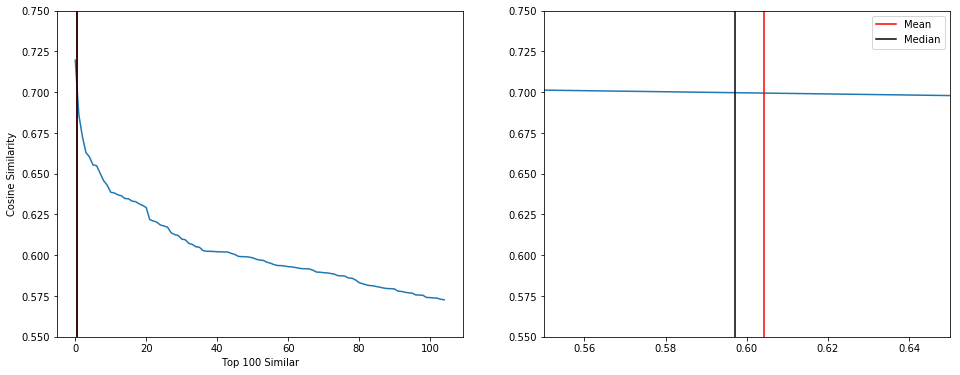

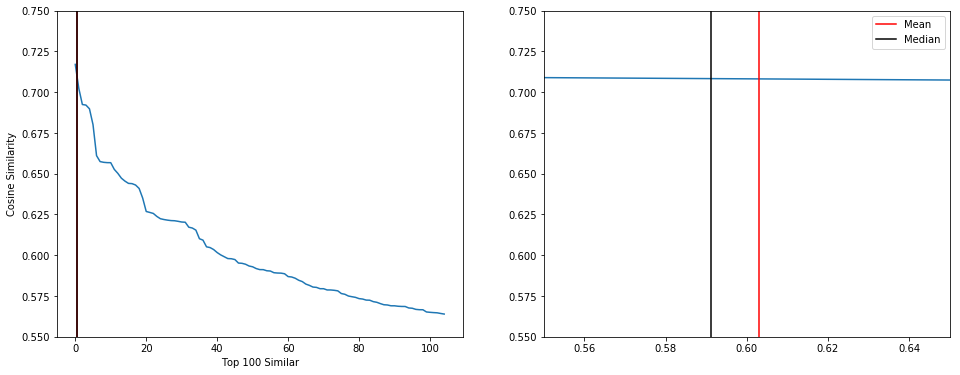

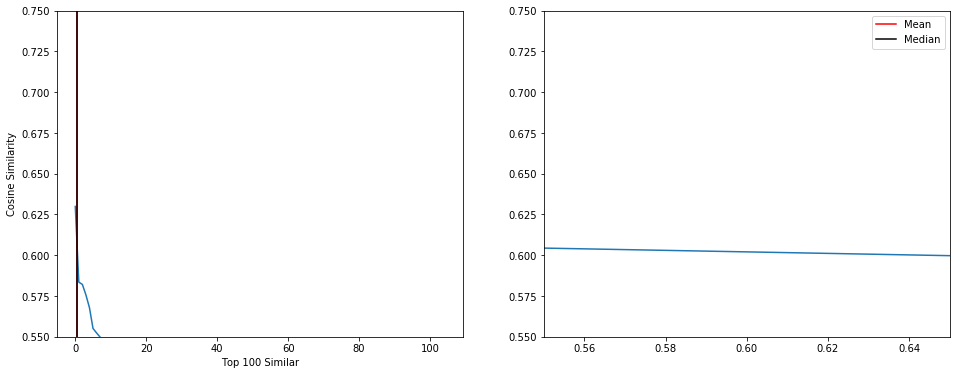

In [105]:
# GOOD 6304500831

std_large = []
for cos in topcosines_large:
    val = []
    for x in topcosines_large[cos]:
        val.append(x[1])
        
    y = []
    for v in val:
        y.append(val.index(v))

    # plt.axvline(np.mean(val), c='red', label='Mean')
    # plt.axvline(np.median(val), c='black', label='Median')
    # #plt.axis([0.4, 0.6, 0, 1])
    # plt.legend()
    # plt.scatter(y, val)
    # plt.show()

    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(121)
    ax1.plot(y, val)
    ax1.axvline(np.mean(val), c='red', label='Mean')
    ax1.axvline(np.median(val), c='black', label='Median')
    plt.ylabel('Cosine Similarity')
    plt.xlabel('Top 100 Similar')
    ax1.set_ylim([0.55, 0.75])
    

    ax2 = fig.add_subplot(122)
    ax2.plot(y, val)
    ax2.axvline(np.mean(val), c='red', label='Mean')
    ax2.axvline(np.median(val), c='black', label='Median')
    ax2.set_ylim([0.55, 0.75])
    ax2.set_xlim([0.55, 0.65])
    #print(np.mean(val)-np.median(val))
    plt.legend()
    plt.show()
    

<H2> OPTIMIZED EXPERIMENT B, WITH USEFULNESS WEIGHT</H2>

In [130]:
# Cubic, multiplied

experimentsC = []
start_time = time.time()
fx = np.poly1d([ -2.26167634e+06,   8.53815283e+04,  -1.05157231e+03, 4.85927435e+00])

for pair in pairs:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    #for base in movie2vec_perspectives[target[0]]:
    #    print(base[0], inverted_reviews[base[0]])
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        u_index = {}
        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True)
            topk_cosine = sorted_cosine[:15]     
            
            top105_cosine = sorted_cosine[:105]
            val = []
            for x in top105_cosine:
                val.append(x[1])
            x = (np.average(val)-np.median(val))
            u = fx(x)
        
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    u_index[movie] = u
                    if len(display) % 3 == 0 and len(display) != 0:
                        break
        
        print('Display', '-'*50)
        for movie in display:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
            print(movie, cursor.fetchone())    
    
# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            experimentsC.append((start[0], target[0], steps))
            #print((len(set(discarded)))/(steps+1))
            break
        else:
            steps = steps + 1

# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

        cosine = {}
        for movie in display:
            if movie not in discarded:
                for perspective in movie2vec_perspectives[movie]:
                    v1 = perspective[2:102]
                    opt = u_index[movie]
                    for perspective_target in movie2vec_perspectives[target[0]]:
                        v2 = perspective_target[2:102]
                        v1v2 = str(perspective[0]+'-'+perspective_target[0])
                        cosine[v1v2] = (1 - spatial.distance.cosine(v1, v2))*opt
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0] 
        s = closest[0]
        print(s)
        closest = s[s.index('|')+1:s.index('-')]
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
timeC = round((time.time() - start_time), 2)

Start = ('Paranormal Activity 4', )
Target = ('Ghost ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B008JFUORW ('The Hangover Part III ', )
B002ZG98UA ('Resident Evil: Afterlife', )
B003L20IEW ('The Last Exorcism', )
B002ZG97TW ('Grown Ups', )
B00A2H9L2E ('None', )
B001GCUO4S ('The Final Destination', )
B003Q6D25K ('Paranormal Activity 2', )
B00005UQ9W ('Thirteen Ghosts', )
B008VPCL7G ('Chernobyl Diaries ', )
A3RPRPV8OELZC7|B008JFUORW-A1XAXFLET6GL1D|6301966988
Selected: ('The Hangover Part III ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYH1A ('Kick', )
B00HX0KIAM ('Ride Along', )
B000V6YROS ('Fantastic Four 2', )
B0090SI53C ('Grown Ups 2', )
B0062P332Y ('Killer Elite ', )
B005S9ELCG ('The Way', )
B00005JMCT ('American Wedding ', )
B008220CFG ('The Possession', )
B00002E233 ('Deep Blue Sea', )
A1P6RQKZ880ZQD|B00HX0KIAM-A1XAXFLET6GL1D|6301966988
Selected: ('Ride

Display --------------------------------------------------
6303153348 ('Ref ', )
0790740885 ('The Witches', )
B00005JPS6 ('Bee Movie ', )
B008RNYMG0 ("That's My Boy", )
630339406X ('Big ', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
B002ZG97XI ('Hot Tub Time Machine', )
0790749858 ('Space Jam', )
630220366X ('What About Bob ', )
A3HVFPZ16DO82Y|B005LAIH1S-A1XAXFLET6GL1D|6301966988
Selected: ("Tyler Perry's Good Deeds", )
Selected movie perspectives:
Display --------------------------------------------------
B008220BW0 ('Of Men and Mavericks ', )
0783217048 ('To Wong Foo Thanks for Everything ', )
B0051MKMNC ('Limitless ', )
B002935GMS ('Race To Witch Mountain', )
B005S9ELVC ('Gangster Squad', )
B005LAIHAY ('Lockout', )
B004A8ZX3C ("Mr. Popper's Penguins", )
B004A8ZWW4 ('Real Steel', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
ADZC0BC3SU8RI|B005S9ELVC-A1XAXFLET6GL1D|6301966988
Selected: ('Gangster Squad', )
Selected movie perspectives:
Display --------------------------------

Selected: ('Jesse Stone: Sea Change', )
Selected movie perspectives:
Display --------------------------------------------------
B000OVLBG2 ('Jesse Stone: Death In Paradise', )
0780619552 ('Austin Powers ', )
B001HN6922 ('Cars 2', )
B002ZG99N6 ('The Town', )
B0011HOEY4 ('American Gangster ', )
B000059HAF ('The Sand Pebbles', )
B00CENSU1W ('Justice League: The Flashpoint Paradox', )
B004EPZ070 ('Something Borrowed', )
B000CEXG0U ('Bleak House', )
A11IMHB7QPZZFJ|B000OVLBG2-A1XAXFLET6GL1D|6301966988
Selected: ('Jesse Stone: Death In Paradise', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG98Z0 ('Sex and the City 2', )
B00005JOYL ('Nochnoy dozor', )
B001GCUO5M ('Shutter Island', )
B00AJLHVES ("Tyler Perry's Madea Gets A Job ", )
B005NKIPWC ('The Double ', )
6301590740 ('Being There ', )
B002ZG998G ('The Bounty Hunter', )
6300214567 ('Witness ', )
6302418828 ('No Time for Sergeants ', )
AYJ0YY96HNT94|B002ZG98Z0-A1XAXFLET6GL1D|6301966988
Selec

Display --------------------------------------------------
B00005JN5T ('Meet the Fockers ', )
B00003CY5X ('Rush Hour 2 ', )
B00005JM4Q ('Anger Management ', )
B0015I2RSO ('27 Dresses ', )
B00005JKMN ('Super Troopers', )
6305128324 ('Friendly Persuasion ', )
B00005JMX6 ('The Girl Next Door ', )
B000EMGICS ('Rumor Has It...', )
079074676X ('Victor Victoria ', )
A1OI6OC4KGUQOX|6305128324-A1XAXFLET6GL1D|6301966988
Selected: ('Friendly Persuasion ', )
Selected movie perspectives:
Display --------------------------------------------------
6300184234 ('Back to the Future ', )
630305725X ('The Longest Day ', )
B006IW8EA2 ('The Flowers of War', )
1424810248 ('Facing the Giants', )
B000BHZ2BO ('March of the Penguins', )
B00005JPOE ('Amazing Grace ', )
6302928540 ('Dave ', )
B00006HBUA ('Scooby', )
6304618344 ('Face/Off ', )
A1VCF00H72XU0V|1424810248-A1R8HWCZWU8QV1|6301966988
Selected: ('Facing the Giants', )
Selected movie perspectives:
Display --------------------------------------------------


Selected: ('The A', )
Selected movie perspectives:
Display --------------------------------------------------
B0015OKWL2 ('Righteous Kill', )
B007R6D74G ('Journey 2: The Mysterious Island  ', )
B0010YSD7M ('Stargate ', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
B003NFM3JK ("Disney's A Christmas Carol", )
B00E00OGE2 ('Turbo', )
B002ZG99H2 ('The Other Guys ', )
B002ZG99B8 ('The Green Hornet', )
B002ZG993Q ('The American', )
A3ITTX33YHDJSE|B007R6D74G-A1XAXFLET6GL1D|6301966988
Selected: ('Journey 2: The Mysterious Island  ', )
Selected movie perspectives:
Display --------------------------------------------------
B0012RLX7Y ('Hitman', )
B001GMAVGE ('Get Smart ', )
B0013FZUQK ('The Forbidden Kingdom ', )
B008JFUN1O ('I, Frankenstein', )
B00003CXJC ('The Perfect Storm ', )
B00020BVYW ('The Snow Walker', )
B001UV4XXS ('Cloudy with a Chance of Meatballs ', )
B000K4WPCC ('The Covenant', )
B000CQM4XI ('Just Like Heaven ', )
A6AOLZK82A67C|B001GMAVGE-A1XAXFLET6GL1D|6301966988
Selected: ('Get Smart ', 

Selected: ('Arthur Christmas ', )
Selected movie perspectives:
Display --------------------------------------------------
B008U1ANHG ('A Princess for Christmas', )
B008Y1YJN6 ('Sparkle', )
B004LWZW9C ("New Year's Eve", )
0790720434 ('The Secret Garden ', )
B000TGUUFA ('The Christmas Card ', )
0767836324 ('Hook', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
B007L6VRBM ('Seeking a Friend for the End of the World', )
B005LAIIA8 ('Frankenweenie ', )
ABXNBD3J1PLJO|B005LAIIA8-A2T6T8JBP9DVCG|6302098424
Selected: ('Frankenweenie ', )
Selected movie perspectives:
Display --------------------------------------------------
B008220CFG ('The Possession', )
B00H5RYIBI ('The Pirate Fairy', )
B00029NLGO ('The Prince and Me ', )
B00C7C00JU ('The Lords of Salem', )
B003Y5H54W ('Red Riding Hood', )
B003EYVXUU ('Let Me In [Blu', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
B004A8ZX3C ("Mr. Popper's Penguins", )
B001OMU6UM ('Bolt ', )
A2ENK7V7DSSPIE|B001OMU6UM-A2T6T8JBP9DVCG|6302098424
Selected: ('Bol

Display --------------------------------------------------
6302969972 ('Coneheads ', )
6303206204 ('The Secret of NIMH ', )
6301744136 ('Short Circuit  ', )
0788803743 ('Pocahontas ', )
B00001QEE2 ('Hercules ', )
779913027X ('The Secret World of Arrietty ', )
0788812807 ('Lady and the Tramp ', )
0790740044 ('Funny Farm ', )
6302642248 ('Pinocchio ', )
A2FX9P37W5ZYC0|6302642248-AQP0ZARDB6SLN|6302098424
Selected: ('Pinocchio ', )
Selected movie perspectives:
Display --------------------------------------------------
1558908358 ('Tron', )
6304546386 ('The Adventures of Robin Hood ', )
6302814782 ('The Lost Boys ', )
B00005JM5Q ('Ella Enchanted ', )
0783219598 ('Babe', )
0780628799 ('The Green Mile ', )
6302794331 ('The Muppet Christmas Carol  ', )
079073463X ('Ladyhawke ', )
6303167314 ('A Charlie Brown Christmas', )
A22YA6SR2GWCBA|1558908358-A2T6T8JBP9DVCG|6302098424
Selected: ('Tron', )
Selected movie perspectives:
Display --------------------------------------------------
6302158095 ('

Selected: ('The Man With the Golden Gun ', )
Selected movie perspectives:
Display --------------------------------------------------
6302380596 ("On Her Majesty's Secret Service ", )
6302380588 ('You Only Live Twice ', )
630251004X ('Bond: For Your Eyes Only ', )
6302928540 ('Dave ', )
B00005JOXC ('Bones', )
6304291701 ('Swiss Family Robinson ', )
6302510007 ('Live and Let Die ', )
6302510198 ('Bond: View to a Kill ', )
630238060X ('Diamonds are Forever ', )
A1HOAZVYI1YISL|6302380596-A2T6T8JBP9DVCG|6302098424
Selected: ("On Her Majesty's Secret Service ", )
Selected movie perspectives:
Display --------------------------------------------------
6304406096 ('Never Say Never Again ', )
6304383827 ('Emma ', )
6304047843 ('License ', )
6305784906 ('The World Is Not Enough ', )
6302510023 ('Bond: Spy Who Loved Me ', )
B000A0GP0Y ('The Longest Yard ', )
630251018X ('Octopussy ', )
6303651453 ('Dr. No', )
6302380561 ('From Russia With Love ', )
A290Z24MST01QT|6304383827-A2T6T8JBP9DVCG|63020984

Display --------------------------------------------------
B002ZG97XI ('Hot Tub Time Machine', )
B00AENNHOE ('Robot and Frank', )
B004A8ZX28 ('Unknown', )
B004RC8NUQ ('No Strings Attached ', )
B000CEXGAK ('The Legend of Zorro ', )
B005LAIIS0 ('The Grey ', )
B008J691HU ('People Like Us', )
B002ZG97TW ('Grown Ups', )
B000BKJ74Y ('The Dukes of Hazzard ', )
ATZPI8XK3KP7|B002ZG97XI-A2T6T8JBP9DVCG|6302098424
Selected: ('Hot Tub Time Machine', )
Selected movie perspectives:
Display --------------------------------------------------
B004XCM89M ('Your Highness ', )
B000J3OTO6 ('Talladega Nights ', )
B00G2P79BU ('Bad Grandpa', )
6300184269 ('Weird Science ', )
B002ZG97II ('Due Date', )
6300214338 ('Trading Places ', )
B002USF1VS ("Jennifer's Body ", )
B002P7UCJ0 ('Bruno', )
B002ZG982S ('Jonah Hex', )
A2C5X4KQVL0ZRM|B002ZG982S-A2T6T8JBP9DVCG|6302098424
Selected: ('Jonah Hex', )
Selected movie perspectives:
Display --------------------------------------------------
B009AMAJPA ('Dead Man Down', )
B

Selected movie perspectives:
Display --------------------------------------------------
B00008KDGZ ('How to Lose a Guy in 10 Days', )
630482615X ('Mrs. Brown ', )
B00062IZ0Y ('The Inheritance', )
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B000031WD7 ('The Red Violin', )
078323418X ('THE BEST MAN', )
B0013D8L7M ('Teeth', )
B001PPGAIA ('Australia', )
078322172X ('12 Monkeys ', )
A1VROECQMM0FDC|B000031WD7-A2T6T8JBP9DVCG|6302098424
Selected: ('The Red Violin', )
Selected movie perspectives:
Display --------------------------------------------------
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
6305428115 ('Enemy Of The State', )
B00005R874 ('Evolution', )
B001C4CI8A ('Body of Lies ', )
6305282854 ('Carousel ', )
6301972279 ('The Long, Long Trailer ', )
B00HLSW6TW ('The Legend of Hercules', )
6304080859 ('The City of Lost Children ', )
B000GRUMPU ('Poseidon ', )
A16BH1YLSGBJEB|B001C4CI8A-A2T6T8JBP9DVCG|6302098424
Selected: ('Body of Lies ', )
Selected movie perspectives:
Disp

Selected: ('Toy Story ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXQX ("The Emperor's New Groove ", )
B00003CY6L ('Serendipity ', )
6302428122 ('Bill Cosby, Himself ', )
6304285396 ('Pollyanna ', )
B000Q66FAW ('The Last Mimzy ', )
B0077MFBYO ('Emperor And The White Snake ', )
B00005JN0A ('EuroTrip ', )
6304819927 ('Zombie ', )
0783225873 ('The Sting ', )
A1GVG0RFM2J8PP|0783225873-AQP0ZARDB6SLN|6302098424
Selected: ('The Sting ', )
Selected movie perspectives:
Display --------------------------------------------------
1415718113 ("Breakfast at Tiffany's ", )
0780618548 ('The Long Kiss Goodnight', )
079074676X ('Victor Victoria ', )
6304308388 ('The Apartment ', )
B000OVLBFS ('Jesse Stone: Night Passage', )
B0011HOEY4 ('American Gangster ', )
0767805267 ('Fifth Element ', )
1419828371 ('Supergirl', )
B009JBZH54 ('The Dark Knight Trilogy ', )
A1SEOAGH951R3P|0767805267-A2T6T8JBP9DVCG|6302098424
Selected: ('Fifth Element ', )
Selected 

Display --------------------------------------------------
B003CI2G6S ('Agora ', )
0788814664 ('Good Will Hunting', )
B00067BCBI ('Something the Lord Made', )
B00605MY0S ('The Thing ', )
B00BEIYMAG ('The Conjuring ', )
B008RNYMG0 ("That's My Boy", )
076780922X ('A League of Their Own ', )
B0034G4OUO ('Faster', )
B00111YM5Q ('30 Days of Night', )
A2GPEV42IO41CI|B00067BCBI-A2T6T8JBP9DVCG|6302098424
Selected: ('Something the Lord Made', )
Selected movie perspectives:
Display --------------------------------------------------
B001TOD6N4 ('Taking Chance', )
6302098424 ('Journey to the Center of the Earth ', )
B0001I2BUI ('Angels in America', )
6303269826 ('Wyatt Earp ', )
B001LK8SKW ('Wonder Woman', )
6301590740 ('Being There ', )
B001N26GFM ('The Boy in the Striped Pajamas', )
6301996135 ('The Civil War ', )
6300181472 ('Midway ', )
Target Reached in 117 steps
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++

Selected movie perspectives:
Display --------------------------------------------------
B004A8ZX28 ('Unknown', )
B00BEIYNIW ("You're Next", )
B00A2H9VKG ('Promised Land', )
B00003CXWL ('Heartbreakers ', )
0783224079 ('Peacemaker ', )
B000GFLKEY ('Inside Man ', )
B00008YJDK ('Narc', )
B003L20IG0 ('The Next Three Days', )
079072961X ('The Fugitive', )
A1UFV4HALV2OXW|B000GFLKEY-A13E0ARAXI6KJW|630347327X
Selected: ('Inside Man ', )
Selected movie perspectives:
Display --------------------------------------------------
B002DU39GW ('State of Play', )
B001L2ZSKS ('Eagle Eye ', )
6305132100 ('Sliding Doors ', )
0792164962 ('The Firm', )
6303257844 ('Speed ', )
B002ZG998G ('The Bounty Hunter', )
B00005JLQN ('Phone Booth', )
B000G5SILC ('The Sentinel ', )
B0000VJG72 ('Out Of Time', )
ANGZU4OT31H4|0792164962-A13E0ARAXI6KJW|630347327X
Selected: ('The Firm', )
Selected movie perspectives:
Display --------------------------------------------------
6304429754 ('Red River ', )
B0010ZR160 ('Gone Baby G

Selected: ('Chernobyl Diaries ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYG98 ('Dark Skies', )
B00AZMFINM ('A Haunted House', )
0784011168 ("Jacob's Ladder", )
B0073U2F12 ('The Darkest Hour ', )
B0000VCZNE ('Cabin Fever', )
B002ZG98N2 ('Priest ', )
6300181472 ('Midway ', )
6301965817 ('Battle of Britain ', )
0783240953 ('Creature From the Black Lagoon', )
AF3HRSNPOQ3CV|0783240953-A3JX5C8CIOJ5L5|630347327X
Selected: ('Creature From the Black Lagoon', )
Selected movie perspectives:
Display --------------------------------------------------
078062565X ('King Kong ', )
6300183483 ('The Last Starfighter ', )
6303066720 ('The Three Musketeers ', )
6302510023 ('Bond: Spy Who Loved Me ', )
6303651488 ('Thunderball ', )
B0001GV4PI ('Night of the Comet', )
0767812166 ('Starman', )
0307514161 ('Rudolph the Red Nosed Reindeer', )
0783103107 ('Godzilla Vs Biollante ', )
A3AUECYM0M0YSX|078062565X-A3JX5C8CIOJ5L5|630347327X
Selected: ('King Kong 

Selected: ('Butch Cassidy & Sundance Kid ', )
Selected movie perspectives:
Display --------------------------------------------------
0790731517 ('Grumpy Old Men', )
0792164482 ('Runaway Bride ', )
B00003CXPP ('Men of Honor', )
6302814782 ('The Lost Boys ', )
6301744160 ('Fantastic Voyage ', )
0790731533 ('Purple Rain', )
6301562178 ('The Towering Inferno ', )
6301217977 ('Coming to America ', )
0790729369 ('The Bridges of Madison County ', )
A2RG3YBUDEPXN0|6301217977-A1EB3EO0NZ1LO|630347327X
Selected: ('Coming to America ', )
Selected movie perspectives:
Display --------------------------------------------------
B000S6LS66 ('Jeff Dunham: Spark of Insanity', )
6304337183 ('The First Wives Club ', )
0790740044 ('Funny Farm ', )
B0007CNXUK ('Finding Neverland ', )
6301398912 ('Beaches ', )
B000EMGJ72 ('The Family Stone ', )
0783240694 ('October Sky ', )
B0038N9X3G ('Leap Year ', )
0783113145 ('Bronx Tale ', )
A3M1OVHZM41MLQ|B0007CNXUK-A1EB3EO0NZ1LO|630347327X
Selected: ('Finding Neverlan

Display --------------------------------------------------
0792837592 ('Seven Brides for Seven Brothers ', )
0783237979 ('Cats', )
0780614097 ('Mr Blandings Builds His Dream House ', )
0788806270 ('Bambi ', )
630141277X ('Working Girl ', )
B00006RCNY ('Unfaithful ', )
B0012OVCE6 ('Sense & Sensibility ', )
B002ZG976U ('Burlesque', )
6304411448 ('Benny & Joon ', )
Target Reached in 7 steps
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start = ('The Arrival / The Arrival II', )
Target = ('Zookeeper', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H5GK ('Skyline', )
B005LAIGXW ('This Means War', )
B002ZG993Q ('The American', )
6300181537 ('Andromeda Strain ', )
B0051MKMNC ('Limitless ', )
B00H9HZGQ0 ('Her [Blu', )
6305077754 ('They Live', )
B005LAIGPA ('Chronicl

Display --------------------------------------------------
B001CTA1UM ('Four Christmases', )
B00CC3464E ('Admission', )
B0011N1WE8 ('Penelope', )
B0081FSMMO ('Hatfields & McCoys ', )
B001GCUO7A ('Monsters vs. Aliens', )
B0015I2RSO ('27 Dresses ', )
B005S9EL08 ('The Three Stooges', )
B003Y5H5AG ('The Smurfs', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
A2EDS2YOGL1541|B003Y5H5AG-A1RR75AX8BX23G|B005F3XV62
Selected: ('The Smurfs', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPZ03O ('The Muppets', )
B0034G4P1W ('The Pirates! Band of Misfits', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
B001GCUO4S ('The Final Destination', )
B002ZG98N2 ('Priest ', )
B00006HBUA ('Scooby', )
B000BYRCGU ('Into the Blue', )
6304618344 ('Face/Off ', )
B00004RF9H ('The Dirty Dozen', )
A2JUYTW6Q7DB6A|B004EPZ03O-A1RR75AX8BX23G|B005F3XV62
Selected: ('The Muppets', )
Selected movie perspectives:
Display -------------------------------------------

Selected: ('Of Men and Mavericks ', )
Selected movie perspectives:
Display --------------------------------------------------
B008Y1YJ90 ('Arthur Christmas ', )
B0011N1WE8 ('Penelope', )
B005LAIH1S ("Tyler Perry's Good Deeds", )
B00CZB9BCU ('Emperor ', )
630482615X ('Mrs. Brown ', )
B001EAWMGA ('Outlander', )
B000056VP3 ('Remember the Titans ', )
B0077ATSSQ ('Extremely Loud & Incredibly Close ', )
6300183483 ('The Last Starfighter ', )
AUUWC7BB1HMGA|B0011N1WE8-A3308LTSKQY4BU|B000G1R38U
Selected: ('Penelope', )
Selected movie perspectives:
Display --------------------------------------------------
6302468027 ('Fried Green Tomatoes ', )
B00113O7MM ('Alvin and the Chipmunks ', )
0783217048 ('To Wong Foo Thanks for Everything ', )
B002ZG975Q ('Beastly', )
B002ZG989G ('Life as We Know It', )
B00003CXIF ('Where the Heart Is ', )
B00150N8EY ('Belle And The Beast', )
B0002OXRSG ('Saved!', )
6305110859 ('Sabrina', )
A3EY4YAZHYDJCS|0783217048-A3308LTSKQY4BU|B000G1R38U
Selected: ('To Wong Foo Tha

Display --------------------------------------------------
B005S9ELVC ('Gangster Squad', )
B00BPEJZEM ('The Best Man Holiday', )
B009NNMAZI ('White House Down', )
B004QL7K6G ('Wanderlust', )
B002ZG9968 ('The Back', )
B002BFBAUG ('Adventureland ', )
B004LWZW9C ("New Year's Eve", )
0792837207 ('When Harry Met Sally... ', )
B004RC8NUQ ('No Strings Attached ', )
A2DHUA3FKCYBE8|B00BPEJZEM-A3308LTSKQY4BU|B000G1R38U
Selected: ('The Best Man Holiday', )
Selected movie perspectives:
Display --------------------------------------------------
0767836324 ('Hook', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
6300184234 ('Back to the Future ', )
B00A2H9UG6 ('Playing for Keeps', )
B000CQM4XI ('Just Like Heaven ', )
B0085A9HXS ('The Raid: Redemption ', )
B003IHUI0O ('Prince of Persia: The Sands of Time ', )
B009NNM77E ('Lego: The Piece of Resistance', )
B005LAIGLE ('Contraband', )
ALPH9BXNWKMGY|0767836324-A3308LTSKQY4BU|B000G1R38U
Selected: ('Hook', )
Selected movie perspectives:
Display

Selected: ('Chicken Little', )
Selected movie perspectives:
Display --------------------------------------------------
B000ION726 ('Barnyard: The Original Party Animals ', )
B0034G4P1W ('The Pirates! Band of Misfits', )
B000F1IQNC ('Nanny McPhee ', )
B000E6EHE0 ('Just Friends', )
B009AMAH3O ('Escape From Planet Earth', )
B000DBHX4M ('Zathura ', )
B003Y5H5AG ('The Smurfs', )
B001DPHDCY ('Horton Hears a Who ', )
0792843592 ('Hoosiers', )
A3BLWCZRABGP02|0792843592-A3308LTSKQY4BU|B000G1R38U
Selected: ('Hoosiers', )
Selected movie perspectives:
Display --------------------------------------------------
0792100085 ('Saturday Night Fever ', )
0792107683 ('Shane ', )
B0021L8V3Y ('Dear John', )
B0000399WC ('Papillon', )
6304457278 ('The Cowboys ', )
B00003CXPP ('Men of Honor', )
B00005ASOC ('Finding Forrester', )
B002JCSWV6 ('Invictus', )
B000J3OTT6 ('Invincible', )
A1WP8IXH2DSHI9|B00003CXPP-A3308LTSKQY4BU|B000G1R38U
Selected: ('Men of Honor', )
Selected movie perspectives:
Display ------------

Selected movie perspectives:
Display --------------------------------------------------
B00111YM5Q ('30 Days of Night', )
B00005ALS2 ('Space Cowboys', )
B004XQO90E ('Source Code ', )
B006BZ8NXY ('Dead, The', )
B0021L8UXA ('The Crazies', )
0790742802 ('The Omega Man', )
B000RGN2IY ('Vacancy ', )
6304277385 ('Last Man on Earth ', )
B000R7NBMK ('The War ', )
AZ1LOWZZZJE8B|B00111YM5Q-A1H39RQWV86750|B005CRM0Q8
Selected: ('30 Days of Night', )
Selected movie perspectives:
Display --------------------------------------------------
B003NFM3JK ("Disney's A Christmas Carol", )
B00HX0KIAM ('Ride Along', )
B002ZG98UA ('Resident Evil: Afterlife', )
B0034G4OVS ('Frozen', )
0767834739 ('Resident Evil: Apocalypse ', )
B005LAIIS0 ('The Grey ', )
B002ZG98LO ('Predators', )
B002ZG98N2 ('Priest ', )
B001QB9H1U ('Punisher: War Zone', )
AI30VLGAHG9J9|B003NFM3JK-A1H39RQWV86750|B005CRM0Q8
Selected: ("Disney's A Christmas Carol", )
Selected movie perspectives:
Display ------------------------------------------

Selected movie perspectives:
Display --------------------------------------------------
B000ZOXDFA ('Elizabeth ', )
B000VKL6ZM ('The Last Legion', )
B00005JKYF ('Castle in the Sky ', )
B000V6YROS ('Fantastic Four 2', )
B004EPZ06G ('The Hangover Part II', )
B002ZG98Z0 ('Sex and the City 2', )
B0090SI53C ('Grown Ups 2', )
B001GMAVGE ('Get Smart ', )
B00B4ZN3XQ ('Hyde Park on Hudson', )
A1DNAMQ1L3IB7N|B004EPZ06G-A1H39RQWV86750|B005CRM0Q8
Selected: ('The Hangover Part II', )
Selected movie perspectives:
Display --------------------------------------------------
B000UVKGPI ('Shrek the Third ', )
B0001AW0HU ('Scary Movie 3 ', )
B006LL3WAM ('Jack and Jill ', )
B009AMAGQM ('Beautiful Creatures ', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B00C7BZYRO ('The Spectacular Now', )
6302428122 ('Bill Cosby, Himself ', )
B002ZG97XI ('Hot Tub Time Machine', )
B00005JL57 ('Y Tu Mama Tambien', )
A3O03FDVX4EZ0S|6302428122-A1H39RQWV86750|B005CRM0Q8
Selected: ('Bill Cosby, Himself ', )
Selected

Selected: ('Scream 4', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9L2E ('None', )
B008JFUORW ('The Hangover Part III ', )
B002ZG98UA ('Resident Evil: Afterlife', )
6304675348 ('Scream ', )
B00116GEFW ('Day of the Dead', )
B004EPZ08O ('Final Destination 5', )
6305892946 ('Scream 3', )
1558908498 ('Scream 2', )
0783229887 ('Bride of Chucky ', )
AEY8NWA47TZ0E|0783229887-A3POXF1M27GOPS|0780622588
Selected: ('Bride of Chucky ', )
Selected movie perspectives:
Display --------------------------------------------------
0790732157 ('Ace Ventura: Pet Detective', )
B00HLSW6TW ('The Legend of Hercules', )
6301427076 ('Pet Sematary ', )
B000009O8A ('I Spit on Your Grave', )
B005TK22CU ("Don't Be Afraid of the Dark ", )
6303579388 ('Jason Goes to Hell ', )
B000WC389G ('Hatchet ', )
B00DTPRZ0G ('Curse of Chucky ', )
B000E6EHE0 ('Just Friends', )
A2N69DJM8NVYZ6|0790732157-A3POXF1M27GOPS|0780622588
Selected: ('Ace Ventura: Pet Detective', )
Selected 

Target = ('Young Adult', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
630021639X ('The Godfather, Part II ', )
6302182557 ('Willow ', )
B0011HOEY4 ('American Gangster ', )
6300214338 ('Trading Places ', )
6304089767 ('Toy Story ', )
6305537798 ('10 Things I Hate About You ', )
6304411448 ('Benny & Joon ', )
B003UESJHO ('The Fighter', )
6301247485 ('The Great Gatsby ', )
A22ZE30JQPMQ5Z|6300214338-AU32WCV4GOUWT|B005FITIK0
Selected: ('Trading Places ', )
Selected movie perspectives:
Display --------------------------------------------------
6300213730 ('Beverly Hills Cop ', )
6300268179 ("What's Up Doc ", )
B004LWZWBU ('The Big Year', )
6300270270 ('Bad Seed ', )
6301390725 ('Bedknobs and Broomsticks ', )
0792837207 ('When Harry Met Sally... ', )
6300249964 ('Raising Arizona ', )
6300216233 ('The Odd Couple ', )
B00003CXO0 ('Meet the Parents ', )
AHRAPXQ75IZB5|6300270270-A33AWQABFZ314A|B005FITIK0
Selected: ('Bad Seed 

Selected: ('Definitely, Maybe ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYGK2 ('About Time', )
B003EYVXUU ('Let Me In [Blu', )
B004LWZW7E ('In Time', )
6301412761 ('Say Anything ', )
B00003CY6L ('Serendipity ', )
B0015OKWKS ('Last Chance Harvey', )
B0038N9X3G ('Leap Year ', )
B0041KKYCY ('I Spit on Your Grave ', )
B00005JNQG ('The Pacifier ', )
A21K28EQ023UUU|B00003CY6L-AU32WCV4GOUWT|B005FITIK0
Selected: ('Serendipity ', )
Selected movie perspectives:
Display --------------------------------------------------
B000F4PDF8 ('Eight Below ', )
6302797624 ('Big Chill ', )
6302227127 ("The Bishop's Wife ", )
6302428122 ('Bill Cosby, Himself ', )
6300275213 ('Splash ', )
6300215644 ('A Place in the Sun ', )
B004EPZ084 ('Horrible Bosses', )
B00003CXSM ('The Wedding Planner', )
B00003CXQR ('What Women Want', )
APZZ1I14L7CHH|B004EPZ084-AU32WCV4GOUWT|B005FITIK0
Selected: ('Horrible Bosses', )
Selected movie perspectives:
Display -------------

Selected movie perspectives:
Display --------------------------------------------------
0790731908 ("National Lampoon's Vacation ", )
6305492247 ('Lock, Stock, and Two Smoking Barrels ', )
B00005JO16 ('Land of the Dead ', )
B000CCBC9E ('The Fog ', )
6305841985 ('Sleepaway Camp', )
B0007P0X9G ('Birth', )
6300182177 ('Jaws 2 ', )
0790748193 ('Message in a Bottle ', )
6300181987 ('Duel ', )
A2EIK4L9730WWJ|B00005JO16-AU32WCV4GOUWT|B005FITIK0
Selected: ('Land of the Dead ', )
Selected movie perspectives:
Display --------------------------------------------------
B00003CXJ3 ('Chicken Run ', )
6305191867 ('Henry: Portrait of a Serial Killer ', )
B00005JON3 ('Wolf Creek', )
B002ZG98UA ('Resident Evil: Afterlife', )
B00005JO24 ('The Producers', )
B00116GEFW ('Day of the Dead', )
B00005JLZK ('Final Destination 2', )
B000AXWHS0 ("The Devil's Rejects", )
6304432488 ('Die Hard With a Vengeance ', )
A2VOL5ZISJIG5K|B000AXWHS0-A33AWQABFZ314A|B005FITIK0
Selected: ("The Devil's Rejects", )
Selected movi

Selected: ('The Purge', )
Selected movie perspectives:
Display --------------------------------------------------
0784011168 ("Jacob's Ladder", )
6301620208 ('The Day After ', )
B007C3TVEY ('We Need to Talk About Kevin ', )
B002IRYYCI ('The Objective', )
B003L20IEC ('The Human Centipede', )
B003Y5H5GK ('Skyline', )
B00BB67UNW ('Broken City', )
B002XMGGJM ('Law Abiding Citizen ', )
B00A2H9VKG ('Promised Land', )
A2GEIWGBZFGMET|B003Y5H5GK-AU32WCV4GOUWT|B005FITIK0
Selected: ('Skyline', )
Selected movie perspectives:
Display --------------------------------------------------
B0013J55B6 ('Hancock ', )
6300183181 ('Jaws 3 ', )
0784012822 ('The Arrival / The Arrival II', )
B0073U2F12 ('The Darkest Hour ', )
B00BEIYNIW ("You're Next", )
B000F6IOBG ('Underworld: Evolution ', )
B000F6IOAM ('When a Stranger Calls', )
B003Y5H5FG ('Fright Night', )
0792841344 ('Phantasm ', )
A3NVVNCN0CXX2Z|B0013J55B6-AU32WCV4GOUWT|B005FITIK0
Selected: ('Hancock ', )
Selected movie perspectives:
Display ------------

Display --------------------------------------------------
6304765789 ('The Game ', )
B000077VRT ("Stephen King's The Shining  ", )
B00003CXUX ('Along Came a Spider ', )
B00007976T ('One Hour Photo ', )
B00005JLX2 ('The Recruit', )
6305622825 ('Entrapment ', )
B000GFLKEY ('Inside Man ', )
B000F8DV1M ('Firewall ', )
B002XTBEDS ('The 39 Steps', )
A3J32CP7XVRNS8|B00005JLX2-AU32WCV4GOUWT|B005FITIK0
Selected: ('The Recruit', )
Selected movie perspectives:
Display --------------------------------------------------
B00008EYA5 ('S.W.A.T. ', )
B00005BCKG ('The Pledge', )
B00005JN5T ('Meet the Fockers ', )
B000MXPE7O ('The Good Shepherd ', )
B000OYAT3U ('Breach ', )
B00003CX9I ('The Conversation', )
B00000JDIQ ('Payback', )
B00003CXPP ('Men of Honor', )
B00005JKBB ('Spy Game ', )
A2VTRED8UM7C1F|B00000JDIQ-AU32WCV4GOUWT|B005FITIK0
Selected: ('Payback', )
Selected movie perspectives:
Display --------------------------------------------------
6304457278 ('The Cowboys ', )
0790750414 ('The Whole Nin

Selected: ('While You Were Sleeping ', )
Selected movie perspectives:
Display --------------------------------------------------
6304961685 ('In the Heat of the Night ', )
6302753295 ('McLintock! ', )
6302787068 ('Aladdin ', )
0783241569 ('Notting Hill ', )
6305108277 ('Hope Floats ', )
6300215628 ('Houseboat ', )
B00008NRI7 ('Two Weeks Notice ', )
6302800420 ('Tootsie ', )
6303507689 ("Nobody's Fool ", )
A91LE0MPYE8GJ|0783241569-A287M1JE3THPYP|B004QOB8UC
Selected: ('Notting Hill ', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYGK2 ('About Time', )
B002ZG9968 ('The Back', )
0783241917 ('End of Days ', )
B002ZG97O2 ('From Paris with Love', )
0788821075 ('Pretty Woman ', )
B00005V4XW ('Bandits', )
B00G7QPXAI ('Austenland', )
6305470448 ('Shakespeare in Love ', )
0767812166 ('Starman', )
A3027AUQUHJQ3Z|B00G7QPXAI-A287M1JE3THPYP|B004QOB8UC
Selected: ('Austenland', )
Selected movie perspectives:
Display -------------------------------------

Selected: ('The Muppets', )
Selected movie perspectives:
Display --------------------------------------------------
0767836324 ('Hook', )
B003Y5H5AG ('The Smurfs', )
B002R0EIVI ('Michael Jackson: This Is It ', )
B004EPZ01G ('Dolphin Tale', )
B001NFNFF8 ('In the Electric Mist ', )
B004A8ZWW4 ('Real Steel', )
6302178924 ('Robin Hood ', )
B008Y1YJ90 ('Arthur Christmas ', )
B000ROAK2W ('Meet the Robinsons', )
ALPH9BXNWKMGY|0767836324-A287M1JE3THPYP|B004QOB8UC
Selected: ('Hook', )
Selected movie perspectives:
Display --------------------------------------------------
B00029NLGO ('The Prince and Me ', )
B007MDB548 ('Secret of the Wings ', )
0790738074 ('The Music Man ', )
078881172X ('Peter Pan ', )
0780626478 ('Blast From the Past ', )
0790731010 ('Chariots of Fire', )
0790725657 ('A Little Princess ', )
B00005JL2O ('Austin Powers in Goldmember', )
0767839129 ('The Messenger: The Story of Joan of Arc ', )
ASPYMPLDVDWSH|0790738074-A287M1JE3THPYP|B004QOB8UC
Selected: ('The Music Man ', )
Sele

In [52]:
# Cubic added a fraction

experimentsC1 = []
start_time = time.time()
fx = np.poly1d([ -2.26167634e+06,   8.53815283e+04,  -1.05157231e+03, 4.85927435e+00])
#fx = np.poly1d([-117.39248008,    1.83954149]) for linear
for pair in pairs:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    #for base in movie2vec_perspectives[target[0]]:
    #    print(base[0], inverted_reviews[base[0]])
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        u_index = {}
        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True)
            topk_cosine = sorted_cosine[:15]     
            
            top105_cosine = sorted_cosine[:105]
            val = []
            for x in top105_cosine:
                val.append(x[1])
            x = (np.average(val)-np.median(val))
            u = fx(x)
        
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    u_index[movie] = u
                    if len(display) % 3 == 0 and len(display) != 0:
                        break
        
        print('Display', '-'*50)
        for movie in display:
            cursor.execute("SELECT title FROM movies WHERE id = ? ", str(movie))
            print(movie, cursor.fetchone())    
    
# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            experimentsC1.append((start[0], target[0], steps))
            break
        else:
            steps = steps + 1

# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

        cosine = {}
        for movie in display:
            if movie not in discarded:
                for perspective in movie2vec_perspectives[movie]:
                    v1 = perspective[2:102]
                    opt = u_index[movie]
                    for perspective_target in movie2vec_perspectives[target[0]]:
                        v2 = perspective_target[2:102]
                        v1v2 = str(perspective[0]+'-'+perspective_target[0])
                        cosine[v1v2] = (1 - spatial.distance.cosine(v1, v2)) + (opt/30)
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0] 
        s = closest[0]
        print(s)
        closest = s[s.index('|')+1:s.index('-')]
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
timeC1 = round((time.time() - start_time), 2)

Start = ('What the Bleep Do We Know', )
Target = ('Robin Hood ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
B001BYLFFS ('Expelled: No Intelligence Allowed', )
B003GAMOIW ('The Adjustment Bureau ', )
B00005YU1O ('Waking Life', )
6300246981 ('The Song of Bernadette ', )
6300270270 ('Bad Seed ', )
6300214338 ('Trading Places ', )
B000KLQUV2 ('Jesus Camp', )
B009OCR1OI ('Compliance ', )
B003CI2G6S ('Agora ', )
A22ZE30JQPMQ5Z|6300214338-A1P139Q8UXXGTR|6302946387
Selected: ('Trading Places ', )
Selected movie perspectives:
Display --------------------------------------------------
6300213730 ('Beverly Hills Cop ', )
6300268179 ("What's Up Doc ", )
B004LWZWBU ('The Big Year', )
630021639X ('The Godfather, Part II ', )
6301390725 ('Bedknobs and Broomsticks ', )
0792837207 ('When Harry Met Sally... ', )
6300249964 ('Raising Arizona ', )
6300216233 ('The Odd Couple ', )
B00003CXO0 ('Meet the Parents ', )
A142YADDOJALKL|630

Selected: ('The Wedding Date ', )
Selected movie perspectives:
Display --------------------------------------------------
B000BNX3AU ('Must Love Dogs ', )
B001HN69C2 ("The Time Traveler's Wife", )
B002ZG989G ('Life as We Know It', )
B001L58000 ('Ghost Town', )
B00094AS9A ('Dear Frankie', )
B00008KDGZ ('How to Lose a Guy in 10 Days', )
B00DL46ZN8 ('The Way, Way Back', )
B000PATZJW ('Norbit ', )
1415719284 ('Elizabethtown', )
A9GD148Q47WKL|B00DL46ZN8-AYD66PXUK9O12|630201106X
Selected: ('The Way, Way Back', )
Selected movie perspectives:
Display --------------------------------------------------
B00CS5RBPM ('Home Run', )
B0041KKYGU ('Bad Teacher ', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B001REZM6K ('Marley and Me ', )
B008220BW0 ('Of Men and Mavericks ', )
B000EMGJ72 ('The Family Stone ', )
B007L6VRBM ('Seeking a Friend for the End of the World', )
B0038N9X3G ('Leap Year ', )
B004UXUWEC ('Our Idiot Brother', )
A2Q9A0I50T1EDG|B00CS5RBPM-AYD66PXUK9O12|630201106X
Selected: ('Hom

Selected: ('Yours Mine And Ours ', )
Selected movie perspectives:
Display --------------------------------------------------
630026923X ('Auntie Mame ', )
6304331851 ('Camelot ', )
6302794331 ('The Muppet Christmas Carol  ', )
6301967275 ('Christmas Carol ', )
6303625800 ('March of the Wooden Soldiers ', )
6301175239 ("Mr. Magoo's Christmas Carol ", )
6301972279 ('The Long, Long Trailer ', )
630150528X ('The African Queen ', )
6301976061 ('12 Angry Men ', )
AEMPM951Y1NPQ|6304331851-AYD66PXUK9O12|630201106X
Selected: ('Camelot ', )
Selected movie perspectives:
Display --------------------------------------------------
630438551X ('Romeo & Juliet ', )
0800129806 ('First Knight ', )
B002KISB56 ('Emma', )
6303066720 ('The Three Musketeers ', )
6303206204 ('The Secret of NIMH ', )
B00001QEE2 ('Hercules ', )
6304089767 ('Toy Story ', )
6301773578 ('Star Wars ', )
0783226039 ('Spartacus', )
A349J1WNYOLKVX|6303066720-AYD66PXUK9O12|630201106X
Selected: ('The Three Musketeers ', )
Selected movie

Selected: ('Mrs Doubtfire ', )
Selected movie perspectives:
Display --------------------------------------------------
0788806270 ('Bambi ', )
6303442447 ('The Santa Clause ', )
6301390725 ('Bedknobs and Broomsticks ', )
6303111874 ('Getaway ', )
6302800420 ('Tootsie ', )
B001PR0Y6W ('I Love You, Man', )
B00003CXO0 ('Meet the Parents ', )
B00023GFUE ('Diary of a Mad Black Woman ', )
B001E95ZNS ('Rachel Getting Married', )
AT91TDFMJ3FXE|0788806270-A2UVWAH7UEIA0G|0790734680
Selected: ('Bambi ', )
Selected movie perspectives:
Display --------------------------------------------------
6300274195 ('Dumbo ', )
0790740885 ('The Witches', )
6302642256 ('Flight of the Navigator ', )
6304872402 ('Anastasia ', )
6300183467 ('Sixteen Candles ', )
0780622642 ('Lost in Space ', )
6302320402 ('101 Dalmatians ', )
6304500831 ('The Jungle Book ', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
A1L1XPT9JQM55J|6302642256-A2UVWAH7UEIA0G|0790734680
Selected: ('Flight of the Navigator ', )
Select

Target = ('Pee', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
6302182557 ('Willow ', )
6301390725 ('Bedknobs and Broomsticks ', )
6302800420 ('Tootsie ', )
0790742705 ('Gremlins ', )
6300183467 ('Sixteen Candles ', )
6303257844 ('Speed ', )
B004QL7K6G ('Wanderlust', )
6300213781 ('Popeye', )
6305958041 ('Mission to Mars', )
A142YADDOJALKL|6301390725-A370Z6I5GBWU44|0790749351
Selected: ('Bedknobs and Broomsticks ', )
Selected movie perspectives:
Display --------------------------------------------------
6302787068 ('Aladdin ', )
6302946387 ('Robin Hood ', )
6302178924 ('Robin Hood ', )
6300214508 ('Young Sherlock Holmes ', )
0788812807 ('Lady and the Tramp ', )
0800130227 ('Matilda', )
6305784078 ('The Aristocats ', )
6301404440 ('Who Framed Roger Rabbit ', )
6301991311 ("Pete's Dragon ", )
A1XRNZ1RAEIK4K|6302946387-A370Z6I5GBWU44|0790749351
Selected: ('Robin Hood ', )
Selected movie perspectives:
Display ----------

Selected: ('The Fast and the Furious: Tokyo Drift', )
Selected movie perspectives:
Display --------------------------------------------------
B004EPYZOO ('Drive Angry', )
B000J3OTSM ('Step Up ', )
B005LAIILM ('Parker', )
6305814694 ('Jaws 4:Revenge ', )
7799437278 ('Soul Surfer ', )
6305297525 ('What Dreams May Come ', )
B000067J3S ('In the Bedroom', )
B00005JKMN ('Super Troopers', )
B00005JLR2 ('Treasure Planet', )
AUKJ5Z239CLO8|6305814694-A1G5LJ8T1IGYC5|B00005NG6E
Selected: ('Jaws 4:Revenge ', )
Selected movie perspectives:
Display --------------------------------------------------
B000QGDY06 ('Premonition ', )
B0009X763C ('The Ring Two', )
6305492247 ('Lock, Stock, and Two Smoking Barrels ', )
B000CCBC9E ('The Fog ', )
6305841985 ('Sleepaway Camp', )
B0007P0X9G ('Birth', )
6300182177 ('Jaws 2 ', )
B000AA4JKW ('The Amityville Horror', )
0790748193 ('Message in a Bottle ', )
AMWIHOAIY1BY7|B0009X763C-A1G5LJ8T1IGYC5|B00005NG6E
Selected: ('The Ring Two', )
Selected movie perspectives:
Di

Selected: ("The World's End", )
Selected movie perspectives:
Display --------------------------------------------------
B00C7C00JU ('The Lords of Salem', )
B000RJO578 ('Hot Fuzz ', )
B000BUNZXS ('The Cave ', )
B005LAIGLE ('Contraband', )
B0083XXVFW ('Anchorman 2: The Legend Continues', )
B004A8ZWWO ('Tower Heist', )
0790741105 ('Caddyshack ', )
630179799X ('History of the World Part 1 ', )
6300216233 ('The Odd Couple ', )
A1T4Q5EJ8YJF43|B004A8ZWWO-A1L2HTX451W609|6300213730
Selected: ('Tower Heist', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAII94 ('Savages', )
B0041KKYHE ('Water for Elephants', )
B000V6YROS ('Fantastic Four 2', )
B005LAIILM ('Parker', )
B00GEKO51U ('Delivery Man', )
B002ZG998G ('The Bounty Hunter', )
B000127ZC8 ('Foolproof', )
B00005V4XW ('Bandits', )
B00005JMYF ('Dodgeball: A True Underdog Story', )
A2AMREE1VCCYPZ|B002ZG998G-A1L2HTX451W609|6300213730
Selected: ('The Bounty Hunter', )
Selected movie perspectives:
Disp

Selected movie perspectives:
Display --------------------------------------------------
B0012KJ0DK ("Fool's Gold ", )
B004EPYZQC ('Fast Five', )
B005LAII94 ('Savages', )
B000FS9UK8 ('Basic Instinct 2 ', )
B00C7BZYRO ('The Spectacular Now', )
B003Y5H574 ('Crazy, Stupid, Love', )
B000BTITKS ('Transporter 2', )
B00004RF9H ('The Dirty Dozen', )
0790735172 ('Enter the Dragon ', )
AGLT3L7ALL4O4|B000BTITKS-AG1M4XYLBPCXN|0790732238
Selected: ('Transporter 2', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG98C8 ('Machete', )
B000BUNZXS ('The Cave ', )
B001QB9H1U ('Punisher: War Zone', )
B001QB9H10 ('Transporter 3 ', )
B00008AOVL ('Transporter, The', )
B000TGJ8A8 ('Next [Blu', )
6304578482 ("Romy and Michele's High School Reunion ", )
6304925077 ('Untouchables ', )
6301969634 ('House of Dark Shadows ', )
A11DDX2UO4D747|6304925077-AG1M4XYLBPCXN|0790732238
Selected: ('Untouchables ', )
Selected movie perspectives:
Display ---------------------------

Selected: ('A Few Good Men ', )
Selected movie perspectives:
Display --------------------------------------------------
0790729709 ('The Bodyguard ', )
0800141741 ('Jerry Maguire', )
6301978587 ('Yentl ', )
6302120624 ('Inherit the Wind ', )
B00005JKWW ('John Q. ', )
079284677X ('The Amityville Horror ', )
0790730987 ('Driving Miss Daisy', )
0800130944 ('Sleepless in Seattle', )
0788821075 ('Pretty Woman ', )
A91LE0MPYE8GJ|0800141741-AG1M4XYLBPCXN|0790732238
Selected: ('Jerry Maguire', )
Selected movie perspectives:
Display --------------------------------------------------
0792160207 ('Double Jeopardy', )
0783241569 ('Notting Hill ', )
630201106X ('Quigley Down Under ', )
B000068DBE ('The Rookie ', )
B0009OL7Z4 ('The Wedding Date ', )
B00000JDIQ ('Payback', )
1404974725 ('Fun with Dick and Jane', )
0800184319 ('I Know What You Did Last Summer ', )
0800179501 ('The Karate Kid', )
A1ZJIS0G21RMR2|0783241569-AG1M4XYLBPCXN|0790732238
Selected: ('Notting Hill ', )
Selected movie perspective

Selected movie perspectives:
Display --------------------------------------------------
B005F3XV62 ('Zookeeper', )
0792833198 ('The Birdcage', )
6304337183 ('The First Wives Club ', )
B005LAIIA8 ('Frankenweenie ', )
0792102320 ("In Harm's Way ", )
B002BFBAUG ('Adventureland ', )
B002UOMGZQ ('9 [Blu', )
0788812807 ('Lady and the Tramp ', )
0788806270 ('Bambi ', )
ABXNBD3J1PLJO|B005LAIIA8-AG1M4XYLBPCXN|0790732238
Selected: ('Frankenweenie ', )
Selected movie perspectives:
Display --------------------------------------------------
B008220CFG ('The Possession', )
B00H5RYIBI ('The Pirate Fairy', )
B00029NLGO ('The Prince and Me ', )
B008Y1YJ90 ('Arthur Christmas ', )
B00C7C00JU ('The Lords of Salem', )
B003Y5H54W ('Red Riding Hood', )
B000F4PDF8 ('Eight Below ', )
B004A8ZX3C ("Mr. Popper's Penguins", )
0790720434 ('The Secret Garden ', )
A2EIVLGSLHLA4T|0790720434-AG1M4XYLBPCXN|0790732238
Selected: ('The Secret Garden ', )
Selected movie perspectives:
Display --------------------------------

Selected movie perspectives:
Display --------------------------------------------------
0784011168 ("Jacob's Ladder", )
B002VECM4A ('Precious ', )
B005J4TLN4 ('Attack the Block', )
B001E95ZNS ('Rachel Getting Married', )
B002IRYYCI ('The Objective', )
B004AV5GX6 ('Dinner for Schmucks', )
B007L6VRBM ('Seeking a Friend for the End of the World', )
B00BB67UNW ('Broken City', )
B005LAIGXW ('This Means War', )
A3PGKWX6S08ZEV|B002IRYYCI-ACNSO2AJWRO3D|B00008YOD2
Selected: ('The Objective', )
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H5GK ('Skyline', )
B002UZCJ8Y ('Surrogates', )
B0090SI3CA ('Killer Joe', )
B008KZ06A6 ('October Baby', )
B00BEIYPN0 ('Runner, Runner', )
B00BEIYRQA ('The Counselor', )
B002935GMS ('Race To Witch Mountain', )
078322172X ('12 Monkeys ', )
6305428220 ('The Faculty', )
A3KFT766XIAM3|B008KZ06A6-ACNSO2AJWRO3D|B00008YOD2
Selected: ('October Baby', )
Selected movie perspectives:
Display ----------------------------------

Selected: ('The Place Beyond the Pines', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYOHC ('Insidious Chapter 2', )
B00BEIYG98 ('Dark Skies', )
B008JFUORW ('The Hangover Part III ', )
B00JA3RPAG ('3 Days To Kill ', )
B004XQO90E ('Source Code ', )
B002ZG993Q ('The American', )
6304618344 ('Face/Off ', )
B002ZG99TA ('Unstoppable', )
B000N6U0DS ('The Pursuit of Happyness ', )
A3SN9G1IWCOZBS|B00BEIYG98-A2YAMJL14NQ2VF|B00BN3ED8I
Selected: ('Dark Skies', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGXW ('This Means War', )
B00A2H9VKG ('Promised Land', )
B00BEIYH1A ('Kick', )
B005WFWVL4 ('Contagion ', )
B005LAIHCW ('House at the End of the Street ', )
B00BEIYNIW ("You're Next", )
0782009980 ('Invasion of the Body Snatchers', )
B0007Z2556 ('Boogeyman ', )
B000GJ0NU2 ('An American Haunting ', )
AEAXOQHJNUPT|B005LAIHCW-A2YAMJL14NQ2VF|B00BN3ED8I
Selected: ('House at the End of the Street ', )
S

Target = ('Last Tango in Paris ', )
Target movie perspectives:
Selected movie perspectives:
Display --------------------------------------------------
6303464831 ('I.Q. ', )
0783241569 ('Notting Hill ', )
B000EMGICS ('Rumor Has It...', )
6304383827 ('Emma ', )
B0015OKWKI ('Visitor, The', )
B00005K3OI ('Someone Like You', )
B00062IZ0Y ('The Inheritance', )
6301247485 ('The Great Gatsby ', )
B00005JLQH ('Far from Heaven', )
APFV687XCAXVY|B000EMGICS-A1LWG7AJRZM3AC|0792838343
Selected: ('Rumor Has It...', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGSM ('The Vow', )
B0068RHSCW ('Dream House', )
B002ZG989G ('Life as We Know It', )
B00005JMX6 ('The Girl Next Door ', )
B00003CXO0 ('Meet the Parents ', )
6304112254 ('Baby Boom ', )
6300213919 ('Mommie Dearest ', )
B002ZG993Q ('The American', )
0790741105 ('Caddyshack ', )
AS8G48CYSGZ3G|B002ZG993Q-A1LWG7AJRZM3AC|0792838343
Selected: ('The American', )
Selected movie perspectives:
Display ----

Selected: ('From Paris with Love', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIHAY ('Lockout', )
0783241569 ('Notting Hill ', )
B00BEIYPN0 ('Runner, Runner', )
B00JA3RPAG ('3 Days To Kill ', )
6302380561 ('From Russia With Love ', )
6303111874 ('Getaway ', )
B005CMSDKA ('Hanna ', )
6304415346 ('Star Trek ', )
6303314015 ('The Lion King ', )
AOIK5Y70IZXY9|B005LAIHAY-A1V3IO23FZFF9L|B00005JNQG
Selected: ('Lockout', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG99KO ("The Sorcerer's Apprentice", )
B005LAIGXW ('This Means War', )
B005S9ELVC ('Gangster Squad', )
B005LAIGWS ('Ghost Rider: Spirit of Vengeance ', )
B005LAIGPA ('Chronicle', )
B005LAIHGI ('The Dictator ', )
B002LMSWN2 ("Trick 'r Treat", )
B002ZG99G8 ('The Losers', )
B002VECM3Q ('Ninja Assassin ', )
A3LH6PQZQEY3YO|B002ZG99KO-A1V3IO23FZFF9L|B00005JNQG
Selected: ("The Sorcerer's Apprentice", )
Selected movie perspectives:
Display -

Selected: ('Kick', )
Selected movie perspectives:
Display --------------------------------------------------
B008JFUORW ('The Hangover Part III ', )
B00JA3RPAG ('3 Days To Kill ', )
B009AMAGQM ('Beautiful Creatures ', )
B00CS5RBPM ('Home Run', )
B00168OINK ('Kung Fu Panda ', )
B004RC8NUQ ('No Strings Attached ', )
B00008YOD2 ('Saw II ', )
B000077VRT ("Stephen King's The Shining  ", )
B00009L1TA ('Basic', )
A3RPRPV8OELZC7|B008JFUORW-A3AGB6EW676WY|6304925131
Selected: ('The Hangover Part III ', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIGLE ('Contraband', )
B004EPZ06G ('The Hangover Part II', )
B000UVKGPI ('Shrek the Third ', )
B0062P332Y ('Killer Elite ', )
B005S9ELCG ('The Way', )
B005LAIHAY ('Lockout', )
B00005JMCT ('American Wedding ', )
B008220CFG ('The Possession', )
B00002E233 ('Deep Blue Sea', )
A3V4Q7PM15PRSY|B005LAIGLE-A2N6RRNCN99DBD|6304925131
Selected: ('Contraband', )
Selected movie perspectives:
Display -----------------

Selected: ('Bambi ', )
Selected movie perspectives:
Display --------------------------------------------------
6300274195 ('Dumbo ', )
0790740885 ('The Witches', )
0790725657 ('A Little Princess ', )
6304872402 ('Anastasia ', )
0780622642 ('Lost in Space ', )
0788812807 ('Lady and the Tramp ', )
6302320402 ('101 Dalmatians ', )
6304500831 ('The Jungle Book ', )
B003DKJ5ZU ('Tinker Bell and the Great Fairy Rescue ', )
A3D5CBC18W2FG0|0790740885-A1D3XQC2DIT|B00005JPNY
Selected: ('The Witches', )
Selected movie perspectives:
Display --------------------------------------------------
B00466HN6S ('Hop', )
B005LAII62 ('ParaNorman', )
B007MDB548 ('Secret of the Wings ', )
6300214508 ('Young Sherlock Holmes ', )
0783234066 ('The Land Before Time', )
078881172X ('Peter Pan ', )
0790744473 ('Brigadoon ', )
B001OMU6UM ('Bolt ', )
6300183181 ('Jaws 3 ', )
A2ENK7V7DSSPIE|B001OMU6UM-A1D3XQC2DIT|B00005JPNY
Selected: ('Bolt ', )
Selected movie perspectives:
Display -------------------------------------

Selected: ('None', )
Selected movie perspectives:
Display --------------------------------------------------
B00A2H9UG6 ('Playing for Keeps', )
B002ZG994U ('The A', )
B009NNM77E ('Lego: The Piece of Resistance', )
B004LWZW2O ('Scream 4', )
B002ZG98UA ('Resident Evil: Afterlife', )
B000UJ48OU ('Hostel ', )
B001451HWU ('AVP: Aliens vs. Predator ', )
B00BEIYOHC ('Insidious Chapter 2', )
B004EPYZO4 ('The Rite', )
A3FNFIHPF0OMEZ|B00BEIYOHC-A19OQ7LWE2YJL3|B00005JPNY
Selected: ('Insidious Chapter 2', )
Selected movie perspectives:
Display --------------------------------------------------
B008VPCL7G ('Chernobyl Diaries ', )
B005WFWVL4 ('Contagion ', )
B00BEIYG98 ('Dark Skies', )
B00BEIYGT8 ('The Purge', )
B004EPZ0BG ('Friends with Benefits', )
B005S9ELCG ('The Way', )
6301247485 ('The Great Gatsby ', )
B00BEIYRQA ('The Counselor', )
B002DKGWSE ('The Last House on the Left ', )
A2OEK4I709CDJJ|B00BEIYRQA-A19OQ7LWE2YJL3|B00005JPNY
Selected: ('The Counselor', )
Selected movie perspectives:
Displa

Selected: ('The Big Wedding', )
Selected movie perspectives:
Display --------------------------------------------------
B002ZG984Q ('Killers', )
B001GMAVGE ('Get Smart ', )
B005LAIHE0 ('The Five', )
B0083XXVFW ('Anchorman 2: The Legend Continues', )
B003B3V0N4 ('When In Rome', )
B0015OKWL2 ('Righteous Kill', )
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B00GEKO51U ('Delivery Man', )
B00CC3464E ('Admission', )
A36GEO8IRSNRPI|B005LAIHE0-A19OQ7LWE2YJL3|B00005JPNY
Selected: ('The Five', )
Selected movie perspectives:
Display --------------------------------------------------
B009AMAKBI ('The Paperboy', )
B006LL3WAM ('Jack and Jill ', )
B00ARA4SLU ('Hitchcock ', )
B001PR0Y6W ('I Love You, Man', )
B004HO6I2E ('The Change', )
B004QL7K6G ('Wanderlust', )
B004UXUWEC ('Our Idiot Brother', )
B0038N9X3G ('Leap Year ', )
B000N6U0DS ('The Pursuit of Happyness ', )
A2EHKLV6YNO7T8|B00ARA4SLU-A19OQ7LWE2YJL3|B00005JPNY
Selected: ('Hitchcock ', )
Selected movie perspectives:
Display ---------------

Selected: ('30 Days of Night', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JEC ('Superman/Batman: Apocalypse ', )
B0012RLX7Y ('Hitman', )
B005LAIGYQ ('Act of Valor', )
B0034G4OVS ('Frozen', )
0767834739 ('Resident Evil: Apocalypse ', )
B006BZ8NXY ('Dead, The', )
B001QB9H1U ('Punisher: War Zone', )
B002935GMS ('Race To Witch Mountain', )
B00116GEFW ('Day of the Dead', )
AWG2O9C42XW5G|B003ES5JEC-A36PYL1X0N2HBX|B00005JPNY
Selected: ('Superman/Batman: Apocalypse ', )
Selected movie perspectives:
Display --------------------------------------------------
B003ES5JDS ('Batman: Under the Red Hood ', )
B0009S4IHY ('Kung Fu Hustle ', )
B000CDGVOE ("Howl's Moving Castle", )
B0027FG29Y ('Superman/Batman: Public Enemies ', )
B000PFSYO4 ('Justice League ', )
B0021AENIM ('Green Lantern: First Flight ', )
6300270122 ('Superman 3 ', )
B001GLX74I ('Star Wars: The Clone Wars ', )
630242335X ('Star Trek VI ', )
A3QQGPI3CTV9SX|B000PFSYO4-A36PYL1X0N2HBX|B

Selected: ('The Host', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAIIS0 ('The Grey ', )
B004LWZW7E ('In Time', )
B006ZL84EW ('Endeavour ', )
B009AMAGQM ('Beautiful Creatures ', )
B009EU6F1U ('Hit & Run', )
B002ZG98Z0 ('Sex and the City 2', )
1419802356 ('Everything Is Illuminated', )
B005LAIGQ4 ('Big Miracle', )
B008220BW0 ('Of Men and Mavericks ', )
A2XZA7T703UZ7U|B004LWZW7E-A1E8HIVNGUM53A|6301928555
Selected: ('In Time', )
Selected movie perspectives:
Display --------------------------------------------------
B000127ZC8 ('Foolproof', )
B00DL477I0 ('Don Jon', )
B005LAIHAY ('Lockout', )
B00005ALS1 ('Pay It Forward', )
B009AMAL4Y ('Killing Them Softly', )
B00HLSW6TW ('The Legend of Hercules', )
B0051MKMNC ('Limitless ', )
B0000VJG72 ('Out Of Time', )
B000R4SMCW ('Fracture ', )
A28QQRIVOHYIDE|B000127ZC8-A1E8HIVNGUM53A|6301928555
Selected: ('Foolproof', )
Selected movie perspectives:
Display ----------------------------------------------

Selected: ('Seeking a Friend for the End of the World', )
Selected movie perspectives:
Display --------------------------------------------------
B005LAII94 ('Savages', )
B004A8ZWWO ('Tower Heist', )
B005WFWVL4 ('Contagion ', )
B00HX0KIAM ('Ride Along', )
B00H7KJRVY ('The Secret Life of Walter Mitty', )
B003Y5H574 ('Crazy, Stupid, Love', )
B00DL46ZN8 ('The Way, Way Back', )
B004UXUWEC ('Our Idiot Brother', )
B00AENNHOE ('Robot and Frank', )
ASM9QI0KTQVIX|B00H7KJRVY-A3PM15PDZPRDID|6300215555
Selected: ('The Secret Life of Walter Mitty', )
Selected movie perspectives:
Display --------------------------------------------------
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B00DL47YY2 ('Out of the Furnace', )
B0051MKMNC ('Limitless ', )
B008Y1YJ90 ('Arthur Christmas ', )
B005LAIIKS ('The Odd Life of Timothy Green', )
B00DB43PLI ('Summer in February', )
B00H9HZGQ0 ('Her [Blu', )
B00GMV8KGW ('Inside Llewyn Davis ', )
B005LAIHE0 ('The Five', )
A3V8KIVIDCW4ZG|B008Y1YJ90-A3PM15PDZPRDID|63002

Display --------------------------------------------------
6300263681 ('The Monster Squad ', )
B00003CY6L ('Serendipity ', )
6302428122 ('Bill Cosby, Himself ', )
B001DPHDCY ('Horton Hears a Who ', )
079284209X ('Ronin ', )
6305229449 ('Mulan ', )
0783226039 ('Spartacus', )
6303314015 ('The Lion King ', )
078062369X ('Blade ', )
A10BLJM6USDHWK|6300263681-A3PM15PDZPRDID|6300215555
Selected: ('The Monster Squad ', )
Selected movie perspectives:
Display --------------------------------------------------
6300277089 ('Anne of Green Gables ', )
0800179501 ('The Karate Kid', )
1419827154 ('August Rush', )
6301928555 ('Near Dark ', )
6300181286 ('Frankenstein ', )
0783219857 ('Waterworld', )
6300247236 ('9 to 5 ', )
6302320402 ('101 Dalmatians ', )
6305692688 ('The 13th Warrior', )
A1R1GWP7Q0B1IE|6300277089-A3PM15PDZPRDID|6300215555
Selected: ('Anne of Green Gables ', )
Selected movie perspectives:
Display --------------------------------------------------
B007MDB548 ('Secret of the Wings ', )

Selected: ("You Don't Mess With the Zohan ", )
Selected movie perspectives:
Display --------------------------------------------------
B003Y5H54W ('Red Riding Hood', )
B00HX0KIAM ('Ride Along', )
B001HQZJMU ('The Mummy: Tomb of the Dragon Emperor ', )
B004AV5GX6 ('Dinner for Schmucks', )
B00CC3464E ('Admission', )
B002ZG97TW ('Grown Ups', )
B00005JNQS ('Robots ', )
B002P7UCJ0 ('Bruno', )
B001CD6FKI ('Speed Racer ', )
A38UNI88GFRH60|B00CC3464E-A2UE3GIHZKN5WV|B00008972B
Selected: ('Admission', )
Selected movie perspectives:
Display --------------------------------------------------
B00CJ5BG8Y ('The Incredible Burt Wonderstone ', )
B005LAIGSM ('The Vow', )
B0041KKYGU ('Bad Teacher ', )
B00AZMFINM ('A Haunted House', )
B002ZG993Q ('The American', )
B00BEIYKM6 ('The Place Beyond the Pines', )
B008KEQM3W ("What to Expect When You're Expecting ", )
B002ZG984Q ('Killers', )
B009NNM77E ('Lego: The Piece of Resistance', )
A19Y4UC0KNK5NG|B00AZMFINM-A2UE3GIHZKN5WV|B00008972B
Selected: ('A Haunted 

Selected movie perspectives:
Display --------------------------------------------------
6304429754 ('Red River ', )
B0010ZR160 ('Gone Baby Gone', )
0793927501 ('The Edge ', )
6304925131 ('The Rainmaker ', )
B005LAIILM ('Parker', )
B004L3AQLU ('Love And Other Drugs ', )
0767816234 ('Wild Things', )
6304457316 ('Stagecoach ', )
079072961X ('The Fugitive', )
A3V1JHRWLS1YLT|B005LAIILM-A13WOT3RSXKRD5|6305622825
Selected: ('Parker', )
Selected movie perspectives:
Display --------------------------------------------------
B00BEIYGT8 ('The Purge', )
B0017JHQPK ('Definitely, Maybe ', )
B005LAIGXW ('This Means War', )
B005LAIGLE ('Contraband', )
B005LAIHCW ('House at the End of the Street ', )
B005NKIPWC ('The Double ', )
B007C4ZJ0S ('Haywire', )
6300213919 ('Mommie Dearest ', )
6303637574 ('While You Were Sleeping ', )
AMMRGJ5V3WP3H|B005NKIPWC-A13WOT3RSXKRD5|6305622825
Selected: ('The Double ', )
Selected movie perspectives:
Display --------------------------------------------------
B009NNMAZI 

Selected: ('Ladies in Lavender', )
Selected movie perspectives:
Display --------------------------------------------------
6300215717 ('Roman Holiday ', )
B000IJ7H2C ('Jane Eyre ', )
B008J691HU ('People Like Us', )
6302728657 ('Enchanted April ', )
0790740281 ('Defending Your Life ', )
079073463X ('Ladyhawke ', )
B00094AS9A ('Dear Frankie', )
B000UVKGPI ('Shrek the Third ', )
B004A8ZWW4 ('Real Steel', )
A697WSC7EN7VH|B000IJ7H2C-A13WOT3RSXKRD5|6305622825
Selected: ('Jane Eyre ', )
Selected movie perspectives:
Display --------------------------------------------------
6300248569 ('Pride and Prejudice ', )
B002ZG988M ('Letters to Juliet', )
6300248550 ('Jane Eyre ', )
B004X181TY ('Jane Eyre ', )
B000JJSJO6 ('One Night with the King', )
B000I0RNVQ ('Clerks II ', )
6300251004 ('Scrooge ', )
0783240171 ('Out of Africa', )
B001U0HBPG ('The Curious Case of Benjamin Button ', )
A3D3TTURVDY1YK|6300251004-A13WOT3RSXKRD5|6305622825
Selected: ('Scrooge ', )
Selected movie perspectives:
Display ----

Display --------------------------------------------------
B0011KQSZ4 ('Death At A Funeral', )
6304107250 ('Great Race ', )
6301972279 ('The Long, Long Trailer ', )
6305132666 ('The American President ', )
6304331851 ('Camelot ', )
6303066720 ('The Three Musketeers ', )
0767821556 ('Bell, Book and Candle', )
0800130944 ('Sleepless in Seattle', )
B00000INCI ('A Woman of Substance ', )
A36D8S9JWEKR1F|6305132666-A13WOT3RSXKRD5|6305622825
Selected: ('The American President ', )
Selected movie perspectives:
Display --------------------------------------------------
B0030Y11O2 ('Capitalism: A Love Story ', )
B00AIBZFDI ('Atlas Shrugged II: The Strike', )
B00D6MB83W ('White House Down', )
B00003CXQX ("The Emperor's New Groove ", )
6305364664 ('Commando', )
6300184234 ('Back to the Future ', )
6303507689 ("Nobody's Fool ", )
6305128324 ('Friendly Persuasion ', )
6304411448 ('Benny & Joon ', )
A2RGJ6BMGI1MEV|6305128324-A13WOT3RSXKRD5|6305622825
Selected: ('Friendly Persuasion ', )
Selected movi

Selected: ("Tyler Perry's Madea Gets A Job ", )
Selected movie perspectives:
Display --------------------------------------------------
B00BEL4QFO ("Tyler Perry's Temptation: Confessions Of A Marriage Counselor ", )
6300183483 ('The Last Starfighter ', )
B00A2H9L2E ('None', )
B008Y1YJN6 ('Sparkle', )
B001OQCVH4 ('My Bloody Valentine 3D ', )
B002R0EIVI ('Michael Jackson: This Is It ', )
0780628799 ('The Green Mile ', )
B001CTA1UM ('Four Christmases', )
B008220BW0 ('Of Men and Mavericks ', )
AUZEZ2B0369L|B008220BW0-A13WOT3RSXKRD5|6305622825
Selected: ('Of Men and Mavericks ', )
Selected movie perspectives:
Display --------------------------------------------------
B0011N1WE8 ('Penelope', )
B001REZM6K ('Marley and Me ', )
B00113O7MM ('Alvin and the Chipmunks ', )
B001EAWMGA ('Outlander', )
B008220CFG ('The Possession', )
B004DK5CW4 ('Secretariat', )
B000056VP3 ('Remember the Titans ', )
B0077ATSSQ ('Extremely Loud & Incredibly Close ', )
B00003CXPC ('Billy Elliot ', )
AMWRP4IFXWIJL|B00003

Display --------------------------------------------------
0800100832 ('From Here to Eternity ', )
0790744473 ('Brigadoon ', )
0790746050 ('Quo Vadis ', )
0790741105 ('Caddyshack ', )
0783227361 ('Dazed and Confused', )
0790749858 ('Space Jam', )
0790732262 ('The Witches of Eastwick', )
B00003CXQR ('What Women Want', )
0790749653 ('The Big Sleep ', )
A3DUUKOEX7AQD8|0790741105-A3TD5IV1HUG7M|6305622825
Selected: ('Caddyshack ', )
Selected movie perspectives:
Display --------------------------------------------------
6305508550 ('Office Space ', )
6305537798 ('10 Things I Hate About You ', )
B008RNYMG0 ("That's My Boy", )
0780623711 ('Rush Hour ', )
630179799X ('History of the World Part 1 ', )
6300213986 ('Airplane ', )
0792833198 ('The Birdcage', )
6304030959 ('Jumanji ', )
0780614097 ('Mr Blandings Builds His Dream House ', )
A31RM5QU797HPJ|0780623711-A3TD5IV1HUG7M|6305622825
Selected: ('Rush Hour ', )
Selected movie perspectives:
Display -----------------------------------------------

Selected movie perspectives:
Display --------------------------------------------------
B00GEKO51U ('Delivery Man', )
B0064JV4LU ('Intouchables ', )
B00BEIYGT8 ('The Purge', )
B005LAIGLE ('Contraband', )
B00HEPC0TS ('Homefront', )
B005S9ELVC ('Gangster Squad', )
B007C4ZJ0S ('Haywire', )
6300213919 ('Mommie Dearest ', )
6303637574 ('While You Were Sleeping ', )
ADZC0BC3SU8RI|B005S9ELVC-A5ZHQLMVMPQZO|B00H7KJTCG
Selected: ('Gangster Squad', )
Selected movie perspectives:
Display --------------------------------------------------
B005SH63HO ('Justice League: Doom', )
B001FB55LW ('Yes Man ', )
B0060ZJ74O ('Moneyball ', )
B00H7KJTCG ('The Secret Life of Walter Mitty ', )
B005LAIHAY ('Lockout', )
B0068RHSCW ('Dream House', )
B00BEIYKM6 ('The Place Beyond the Pines', )
B005TK22CU ("Don't Be Afraid of the Dark ", )
B00007E2F5 ('Sweet Home Alabama', )
Target Reached in 2 steps
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++

In [167]:
# Cubic added a fraction
tests = [15]
for fraction in tests:
    
    experimentsC2 = []
    start_time = time.time()
    #fx = np.poly1d([ -2.26167634e+06,   8.53815283e+04,  -1.05157231e+03, 4.85927435e+00])
    fx = np.poly1d([-1.68396427,  2.24835985]) #for linear
    
    for pair in pairs:

    # Initialize starting movie

        start_movie = pair[0]
        start = (start_movie, movie2vec_perspectives[start_movie])
        selected = start_movie

    # Initialize target movie

        target = (pair[1], movie2vec_perspectives[pair[1]])
        
    # Initialize lists

        discarded = []
        discarded.append(selected)
        topk_cosine = []
        steps = 0

    # Process limited to total amount of movies

        while len(discarded) < len(movie2vec_perspectives):

    # Create "top similar to selected movie" display

            u_index = {}
            display = []
            for base in movie2vec_perspectives[selected]:
                v1 = base[2:102]
                cosine = {}
                for key in movie2vec_perspectives:
                    if key not in discarded:
                        for perspective in movie2vec_perspectives[key]:
                            v2 = perspective[2:102]
                            v1v2 = str(perspective[0])
                            cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
                sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True)
                topk_cosine = sorted_cosine[:15]     

                top105_cosine = sorted_cosine[:105]
                val = []
                for x in top105_cosine:
                    val.append(x[1])
               # x = (np.average(val)-np.median(val))
                x = (3*(np.average(val)-np.median(val))/np.std(val))
                u = fx(x)

                for perspective in topk_cosine:
                    s = perspective[0]
                    movie = s[(s.index('|')+1):]
                    if movie not in display:
                        display.append(movie)
                        u_index[movie] = u
                        if len(display) % 3 == 0 and len(display) != 0:
                            break

    # Check if target movie is in display, if it is: finish. If it's not, continue

            if target[0] in display:
                experimentsC2.append((start[0], target[0], steps))
                break
            else:
                steps = steps + 1

    # Calculate most similar movie by perspective from display to target by perpsective 81 comparison

            cosine = {}
            for movie in display:
                if movie not in discarded:
                    for perspective in movie2vec_perspectives[movie]:
                        v1 = perspective[2:102]
                        opt = u_index[movie]
                        for perspective_target in movie2vec_perspectives[target[0]]:
                            v2 = perspective_target[2:102]
                            v1v2 = str(perspective[0]+'-'+perspective_target[0])
                            cosine[v1v2] = (1 - spatial.distance.cosine(v1, v2)) + (opt/fraction)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
            closest = sorted_cosine[0] 
            s = closest[0]
            closest = s[s.index('|')+1:s.index('-')]

    # Add movies not chosen to the discarded list to avoid repetition

            for row in display:
                discarded.append(row)

    # Update selected movie 

            selected = closest      

    timeC2 = round((time.time() - start_time), 2)
    
    jumpsC2 = []
    for row in experimentsC2: 
        jumpsC2.append(row[2])
    print(jumpsC2)  
    
    print('Average jumps C2', len(jumpsC2), np.average(jumpsC2), np.std(jumpsC2), 'in', timeC2, 'for fraction', fraction) 

[13, 25, 2, 23, 13, 10, 24, 13, 33, 11, 33, 129, 23, 9, 41, 16, 15, 17, 20, 13, 5, 21, 14, 37, 14]
Average jumps C2 25 22.96 23.6296085452 in 440.73 for fraction 15


In [166]:
print('Average jumps B', len(jumpsB25), np.average(jumpsB25), np.std(jumpsB25), 'in', timeB25)
print(jumpsB25)

Average jumps B 25 24.28 29.8603683835 in 552.09
[21, 35, 2, 11, 4, 7, 34, 18, 23, 11, 27, 147, 18, 9, 82, 16, 5, 8, 29, 13, 5, 16, 4, 30, 32]


In [168]:
# Cubic added a fraction
tests = [15]
for fraction in tests:
    
    experimentsC2 = []
    start_time = time.time()
    #fx = np.poly1d([ -2.26167634e+06,   8.53815283e+04,  -1.05157231e+03, 4.85927435e+00])
    fx = np.poly1d([-1.68396427,  2.24835985]) #for linear
    
    for pair in pairs100:

    # Initialize starting movie

        start_movie = pair[0]
        start = (start_movie, movie2vec_perspectives[start_movie])
        selected = start_movie

    # Initialize target movie

        target = (pair[1], movie2vec_perspectives[pair[1]])
        
    # Initialize lists

        discarded = []
        discarded.append(selected)
        topk_cosine = []
        steps = 0

    # Process limited to total amount of movies

        while len(discarded) < len(movie2vec_perspectives):

    # Create "top similar to selected movie" display

            u_index = {}
            display = []
            for base in movie2vec_perspectives[selected]:
                v1 = base[2:102]
                cosine = {}
                for key in movie2vec_perspectives:
                    if key not in discarded:
                        for perspective in movie2vec_perspectives[key]:
                            v2 = perspective[2:102]
                            v1v2 = str(perspective[0])
                            cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
                sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True)
                topk_cosine = sorted_cosine[:15]     

                top105_cosine = sorted_cosine[:105]
                val = []
                for x in top105_cosine:
                    val.append(x[1])
               # x = (np.average(val)-np.median(val))
                x = (3*(np.average(val)-np.median(val))/np.std(val))
                u = fx(x)

                for perspective in topk_cosine:
                    s = perspective[0]
                    movie = s[(s.index('|')+1):]
                    if movie not in display:
                        display.append(movie)
                        u_index[movie] = u
                        if len(display) % 3 == 0 and len(display) != 0:
                            break

    # Check if target movie is in display, if it is: finish. If it's not, continue

            if target[0] in display:
                experimentsC2.append((start[0], target[0], steps))
                break
            else:
                steps = steps + 1

    # Calculate most similar movie by perspective from display to target by perpsective 81 comparison

            cosine = {}
            for movie in display:
                if movie not in discarded:
                    for perspective in movie2vec_perspectives[movie]:
                        v1 = perspective[2:102]
                        opt = u_index[movie]
                        for perspective_target in movie2vec_perspectives[target[0]]:
                            v2 = perspective_target[2:102]
                            v1v2 = str(perspective[0]+'-'+perspective_target[0])
                            cosine[v1v2] = (1 - spatial.distance.cosine(v1, v2)) + (opt/fraction)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
            closest = sorted_cosine[0] 
            s = closest[0]
            closest = s[s.index('|')+1:s.index('-')]

    # Add movies not chosen to the discarded list to avoid repetition

            for row in display:
                discarded.append(row)

    # Update selected movie 

            selected = closest      

    timeC2 = round((time.time() - start_time), 2)
    
    jumpsC2 = []
    for row in experimentsC2: 
        jumpsC2.append(row[2])
    print(jumpsC2)  
    
    print('Average jumps C2', len(jumpsC2), np.average(jumpsC2), np.std(jumpsC2), 'in', timeC2, 'for fraction', fraction) 

[5, 4, 8, 8, 19, 44, 64, 22, 17, 1, 60, 70, 24, 14, 2, 17, 93, 5, 23, 9, 7, 20, 20, 13, 10, 27, 61, 30, 37, 7, 42, 2, 123, 21, 39, 72, 3, 0, 77, 18, 10, 153, 41, 8, 4, 54, 112, 37, 13, 8, 91, 18, 3, 43, 10, 21, 6, 19, 23, 18, 2, 8, 108, 188, 3, 45, 157, 72, 13, 58, 88, 3, 3, 5, 37, 35, 159, 20, 8, 12, 26, 79, 124, 54, 49, 27, 57, 7, 25, 93, 8, 9, 13, 39, 58, 37, 11, 15, 76, 16]
Average jumps C2 100 36.77 39.5425985489 in 2491.91 for fraction 15


In [172]:
print('Average jumps B', len(jumpsA[:50]), np.average(jumpsA[:50]), np.std(jumpsB), 'in', timeB)
print('Average jumps B', len(jumpsB[:50]), np.average(jumpsB[:50]), np.std(jumpsB), 'in', timeB)
print('Average jumps C2', len(jumpsC2[:50]), np.average(jumpsC2[:50]), np.std(jumpsC2), 'in', timeC2, 'for fraction', fraction) 

Average jumps B 50 39.3 37.0460308265 in 2232.88
Average jumps B 50 30.18 37.0460308265 in 2232.88
Average jumps C2 50 31.56 39.5425985489 in 2491.91 for fraction 15


<H3> TESTING EXPONENTIAL MODEL BASED OPTIMIZATION </H3>

In [ ]:
p4 = np.array([-129.74580215,    0.95340242])

experimentsC5 = []
start_time = time.time()

for pair in pairs[:20]:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        u_index = {}
        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True)
            topk_cosine = sorted_cosine[:15]     
            
            top105_cosine = sorted_cosine[:105]
            val = []
            for x in top105_cosine:
                val.append(x[1])
            x = (np.average(val)-np.median(val))
            u = np.exp(p4[1])*np.exp(p4[0]*x)
        
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    u_index[movie] = u
                    if len(display) % 3 == 0 and len(display) != 0:
                        break   
    
# Check if target movie is in display, if it is: finish. If it's not, continue

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            experimentsC5.append((start[0], target[0], steps))
            break
        else:
            steps = steps + 1

# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

        cosine = {}
        for movie in display:
            if movie not in discarded:
                for perspective in movie2vec_perspectives[movie]:
                    v1 = perspective[2:102]
                    opt = u_index[movie]
                    for perspective_target in movie2vec_perspectives[target[0]]:
                        v2 = perspective_target[2:102]
                        v1v2 = str(perspective[0]+'-'+perspective_target[0])
                        cos = (1 - spatial.distance.cosine(v1, v2))
                        cosine[v1v2] = cos+(opt/20)
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0] 
        s = closest[0]
        print(s)
        closest = s[s.index('|')+1:s.index('-')]
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
timeC5 = round((time.time() - start_time), 2)

<H3> TESTING DENSITY BASED </H3>

In [ ]:
experimentsC5 = []
start_time = time.time()

for pair in pairs:

# Initialize starting movie

    start_movie = pair[0]
    start = (start_movie, movie2vec_perspectives[start_movie])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(start[0]))
    print('Start =', cursor.fetchone())
    selected = start_movie

# Initialize target movie

    target = (pair[1], movie2vec_perspectives[pair[1]])
    cursor.execute("SELECT title FROM movies WHERE id = ? ", str(target[0]))
    print('Target =', cursor.fetchone())
    print('Target movie perspectives:')
    #for base in movie2vec_perspectives[target[0]]:
    #    print(base[0], inverted_reviews[base[0]])
    
# Initialize lists

    discarded = []
    discarded.append(selected)
    topk_cosine = []
    steps = 0
    
# Process limited to total amount of movies

    while len(discarded) < len(movie2vec_perspectives):

# Create "top similar to selected movie" display

        u_index = {}
        display = []
        print('Selected movie perspectives:')
        for base in movie2vec_perspectives[selected]:
            v1 = base[2:102]
            cosine = {}
            for key in movie2vec_perspectives:
                if key not in discarded:
                    for perspective in movie2vec_perspectives[key]:
                        v2 = perspective[2:102]
                        v1v2 = str(perspective[0])
                        cosine[v1v2] = 1 - spatial.distance.cosine(v1, v2)
            sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True)
            topk_cosine = sorted_cosine[:15]     
            
            top105_cosine = sorted_cosine[:105]
            val = []
            for x in top105_cosine:
                val.append(x[1])
            x = (np.average(val)-np.median(val))
            u = np.exp(p4[1])*np.exp(p4[0]*x)


            val = []
            for x in sorted_cosine:
                val.append(x[1])

            c = 0
            for x in val:
                if x > 0.6:
                    c = c + 1
            u = c        
        
            for perspective in topk_cosine:
                s = perspective[0]
                movie = s[(s.index('|')+1):]
                if movie not in display:
                    display.append(movie)
                    u_index[movie] = u
                    if len(display) % 3 == 0 and len(display) != 0:
                        break

        if target[0] in display:
            print('Target Reached in %s steps' %steps)
            print('+'*100)
            print('+'*100)
            experimentsC5.append((start[0], target[0], steps))
            break
        else:
            steps = steps + 1

# Calculate most similar movie by perspective from display to target by perpsective 81 comparison

        cosine = {}
        for movie in display:
            if movie not in discarded:
                for perspective in movie2vec_perspectives[movie]:
                    v1 = perspective[2:102]
                    opt = u_index[movie]
                    for perspective_target in movie2vec_perspectives[target[0]]:
                        v2 = perspective_target[2:102]
                        v1v2 = str(perspective[0]+'-'+perspective_target[0])
                        cos = (1 - spatial.distance.cosine(v1, v2))
                        
                        cosine[v1v2] = cos+opt
        sorted_cosine = sorted(cosine.items(), key=operator.itemgetter(1), reverse=True) 
        closest = sorted_cosine[0] 
        s = closest[0]
        print(s)
        closest = s[s.index('|')+1:s.index('-')]
        
# Add movies not chosen to the discarded list to avoid repetition
        
        for row in display:
            discarded.append(row)

# Update selected movie 
        
        selected = closest
        cursor.execute("SELECT title FROM movies WHERE id = ? ", str(closest))

        print('Selected:', cursor.fetchone())         
        
timeC5 = round((time.time() - start_time), 2)